# Miller age

In [1]:
ood_seed = 2

In [2]:
num_ood = 1  # not functioning

In [3]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [5]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [6]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [7]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [8]:
def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('Bud tip adjacent cells', '18.0'), 777)

Removed datapoint: 777


In [9]:
adata

AnnData object with n_obs × n_vars = 6628 × 8192
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes', 'age_continuous'
    uns: 'rank_genes_groups'
    obsm: 'Unintegrated', 'X_pca', 'harmony'

In [10]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"miller_ood-seed-{ood_seed}_size-{num_ood}"
)

In [11]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [12]:
(
    adata.obs["integration_donor"].nunique(),
    adata.obs["integration_biological_unit"].nunique(),
    adata.obs["integration_sample_status"].nunique(),
    adata.obs["integration_library_platform_coarse"].nunique(),
) 

(8, 1, 1, 1)

In [13]:
warmup_epoch_range = [6, 48]

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

tardis_loss_weight_1 = 100
tardis_loss_weight_2 = 10

disentenglement_targets_configurations=[
    dict(
        obs_key = "age",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = tardis_loss_weight_1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "integration_donor",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = tardis_loss_weight_1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]


In [14]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)), 
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=False,
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key="cell_type",
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: 45c5turd
Name: mythical-transport-299
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/45c5turd
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240505_011141-45c5turd/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `age` for `training` set. Number of elements in each group: 566,2364,1765,608
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `integration_donor` for `training` set. Number of elements in each group: 260,306,559,249,1556,940,825,608
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `age` for `validation` set. Number of elements in each group: 141,560,463,161
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `integration_donor` for `validation` set. Number of elements in each group: 66,75,124,57,379,246,217,161
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:06<1:00:05,  6.02s/it]

Epoch 1/600:   0%|          | 1/600 [00:06<1:00:05,  6.02s/it, v_num=rd_1, total_loss_train=1.26e+3, kl_local_train=15.9, tardis_age_0_train=31.9, tardis_integration_donor_0_train=34]

Epoch 2/600:   0%|          | 1/600 [00:06<1:00:05,  6.02s/it, v_num=rd_1, total_loss_train=1.26e+3, kl_local_train=15.9, tardis_age_0_train=31.9, tardis_integration_donor_0_train=34]

Epoch 2/600:   0%|          | 2/600 [00:10<50:06,  5.03s/it, v_num=rd_1, total_loss_train=1.26e+3, kl_local_train=15.9, tardis_age_0_train=31.9, tardis_integration_donor_0_train=34]  

Epoch 2/600:   0%|          | 2/600 [00:10<50:06,  5.03s/it, v_num=rd_1, total_loss_train=1.1e+3, kl_local_train=39.6, tardis_age_0_train=32.3, tardis_integration_donor_0_train=33.7]

Epoch 3/600:   0%|          | 2/600 [00:10<50:06,  5.03s/it, v_num=rd_1, total_loss_train=1.1e+3, kl_local_train=39.6, tardis_age_0_train=32.3, tardis_integration_donor_0_train=33.7]

Epoch 3/600:   0%|          | 3/600 [00:14<46:40,  4.69s/it, v_num=rd_1, total_loss_train=1.1e+3, kl_local_train=39.6, tardis_age_0_train=32.3, tardis_integration_donor_0_train=33.7]

Epoch 3/600:   0%|          | 3/600 [00:14<46:40,  4.69s/it, v_num=rd_1, total_loss_train=1.05e+3, kl_local_train=43.9, tardis_age_0_train=32.5, tardis_integration_donor_0_train=33.7]

Epoch 4/600:   0%|          | 3/600 [00:14<46:40,  4.69s/it, v_num=rd_1, total_loss_train=1.05e+3, kl_local_train=43.9, tardis_age_0_train=32.5, tardis_integration_donor_0_train=33.7]

Epoch 4/600:   1%|          | 4/600 [00:19<46:30,  4.68s/it, v_num=rd_1, total_loss_train=1.05e+3, kl_local_train=43.9, tardis_age_0_train=32.5, tardis_integration_donor_0_train=33.7]

Epoch 4/600:   1%|          | 4/600 [00:19<46:30,  4.68s/it, v_num=rd_1, total_loss_train=1.03e+3, kl_local_train=35.6, tardis_age_0_train=32.1, tardis_integration_donor_0_train=33.9]

Epoch 5/600:   1%|          | 4/600 [00:19<46:30,  4.68s/it, v_num=rd_1, total_loss_train=1.03e+3, kl_local_train=35.6, tardis_age_0_train=32.1, tardis_integration_donor_0_train=33.9]

Epoch 5/600:   1%|          | 5/600 [00:23<44:50,  4.52s/it, v_num=rd_1, total_loss_train=1.03e+3, kl_local_train=35.6, tardis_age_0_train=32.1, tardis_integration_donor_0_train=33.9]

Epoch 5/600:   1%|          | 5/600 [00:23<44:50,  4.52s/it, v_num=rd_1, total_loss_train=1e+3, kl_local_train=43.8, tardis_age_0_train=31.2, tardis_integration_donor_0_train=34.1]   

Epoch 6/600:   1%|          | 5/600 [00:23<44:50,  4.52s/it, v_num=rd_1, total_loss_train=1e+3, kl_local_train=43.8, tardis_age_0_train=31.2, tardis_integration_donor_0_train=34.1]

Epoch 6/600:   1%|          | 6/600 [00:27<43:35,  4.40s/it, v_num=rd_1, total_loss_train=1e+3, kl_local_train=43.8, tardis_age_0_train=31.2, tardis_integration_donor_0_train=34.1]

Epoch 6/600:   1%|          | 6/600 [00:27<43:35,  4.40s/it, v_num=rd_1, total_loss_train=967, kl_local_train=54.5, tardis_age_0_train=31.6, tardis_integration_donor_0_train=34.4] 

Epoch 7/600:   1%|          | 6/600 [00:27<43:35,  4.40s/it, v_num=rd_1, total_loss_train=967, kl_local_train=54.5, tardis_age_0_train=31.6, tardis_integration_donor_0_train=34.4]

Epoch 7/600:   1%|          | 7/600 [00:32<44:45,  4.53s/it, v_num=rd_1, total_loss_train=967, kl_local_train=54.5, tardis_age_0_train=31.6, tardis_integration_donor_0_train=34.4]

Epoch 7/600:   1%|          | 7/600 [00:32<44:45,  4.53s/it, v_num=rd_1, total_loss_train=944, kl_local_train=57.7, tardis_age_0_train=32.2, tardis_integration_donor_0_train=35.1]

Epoch 8/600:   1%|          | 7/600 [00:32<44:45,  4.53s/it, v_num=rd_1, total_loss_train=944, kl_local_train=57.7, tardis_age_0_train=32.2, tardis_integration_donor_0_train=35.1]

Epoch 8/600:   1%|▏         | 8/600 [00:36<43:33,  4.41s/it, v_num=rd_1, total_loss_train=944, kl_local_train=57.7, tardis_age_0_train=32.2, tardis_integration_donor_0_train=35.1]

Epoch 8/600:   1%|▏         | 8/600 [00:36<43:33,  4.41s/it, v_num=rd_1, total_loss_train=940, kl_local_train=54.7, tardis_age_0_train=34.2, tardis_integration_donor_0_train=35]  

Epoch 9/600:   1%|▏         | 8/600 [00:36<43:33,  4.41s/it, v_num=rd_1, total_loss_train=940, kl_local_train=54.7, tardis_age_0_train=34.2, tardis_integration_donor_0_train=35]

Epoch 9/600:   2%|▏         | 9/600 [00:41<43:31,  4.42s/it, v_num=rd_1, total_loss_train=940, kl_local_train=54.7, tardis_age_0_train=34.2, tardis_integration_donor_0_train=35]

Epoch 9/600:   2%|▏         | 9/600 [00:41<43:31,  4.42s/it, v_num=rd_1, total_loss_train=938, kl_local_train=46.7, tardis_age_0_train=35.4, tardis_integration_donor_0_train=35.3]

Epoch 10/600:   2%|▏         | 9/600 [00:41<43:31,  4.42s/it, v_num=rd_1, total_loss_train=938, kl_local_train=46.7, tardis_age_0_train=35.4, tardis_integration_donor_0_train=35.3]

Epoch 10/600:   2%|▏         | 10/600 [00:45<43:43,  4.45s/it, v_num=rd_1, total_loss_train=938, kl_local_train=46.7, tardis_age_0_train=35.4, tardis_integration_donor_0_train=35.3]

Epoch 10/600:   2%|▏         | 10/600 [00:45<43:43,  4.45s/it, v_num=rd_1, total_loss_train=938, kl_local_train=42.6, tardis_age_0_train=34.8, tardis_integration_donor_0_train=33.6]

Epoch 11/600:   2%|▏         | 10/600 [00:45<43:43,  4.45s/it, v_num=rd_1, total_loss_train=938, kl_local_train=42.6, tardis_age_0_train=34.8, tardis_integration_donor_0_train=33.6]

Epoch 11/600:   2%|▏         | 11/600 [00:49<42:45,  4.36s/it, v_num=rd_1, total_loss_train=938, kl_local_train=42.6, tardis_age_0_train=34.8, tardis_integration_donor_0_train=33.6]

Epoch 11/600:   2%|▏         | 11/600 [00:49<42:45,  4.36s/it, v_num=rd_1, total_loss_train=938, kl_local_train=44.1, tardis_age_0_train=34.3, tardis_integration_donor_0_train=30.7]

Epoch 12/600:   2%|▏         | 11/600 [00:49<42:45,  4.36s/it, v_num=rd_1, total_loss_train=938, kl_local_train=44.1, tardis_age_0_train=34.3, tardis_integration_donor_0_train=30.7]

Epoch 12/600:   2%|▏         | 12/600 [00:54<43:45,  4.47s/it, v_num=rd_1, total_loss_train=938, kl_local_train=44.1, tardis_age_0_train=34.3, tardis_integration_donor_0_train=30.7]

Epoch 12/600:   2%|▏         | 12/600 [00:54<43:45,  4.47s/it, v_num=rd_1, total_loss_train=939, kl_local_train=47.4, tardis_age_0_train=33.6, tardis_integration_donor_0_train=28]  

Epoch 13/600:   2%|▏         | 12/600 [00:54<43:45,  4.47s/it, v_num=rd_1, total_loss_train=939, kl_local_train=47.4, tardis_age_0_train=33.6, tardis_integration_donor_0_train=28]

Epoch 13/600:   2%|▏         | 13/600 [00:58<42:51,  4.38s/it, v_num=rd_1, total_loss_train=939, kl_local_train=47.4, tardis_age_0_train=33.6, tardis_integration_donor_0_train=28]

Epoch 13/600:   2%|▏         | 13/600 [00:58<42:51,  4.38s/it, v_num=rd_1, total_loss_train=939, kl_local_train=50.6, tardis_age_0_train=32.8, tardis_integration_donor_0_train=26.5]

Epoch 14/600:   2%|▏         | 13/600 [00:58<42:51,  4.38s/it, v_num=rd_1, total_loss_train=939, kl_local_train=50.6, tardis_age_0_train=32.8, tardis_integration_donor_0_train=26.5]

Epoch 14/600:   2%|▏         | 14/600 [01:02<42:27,  4.35s/it, v_num=rd_1, total_loss_train=939, kl_local_train=50.6, tardis_age_0_train=32.8, tardis_integration_donor_0_train=26.5]

Epoch 14/600:   2%|▏         | 14/600 [01:02<42:27,  4.35s/it, v_num=rd_1, total_loss_train=941, kl_local_train=53.2, tardis_age_0_train=32.3, tardis_integration_donor_0_train=26.3]

Epoch 15/600:   2%|▏         | 14/600 [01:02<42:27,  4.35s/it, v_num=rd_1, total_loss_train=941, kl_local_train=53.2, tardis_age_0_train=32.3, tardis_integration_donor_0_train=26.3]

Epoch 15/600:   2%|▎         | 15/600 [01:07<43:18,  4.44s/it, v_num=rd_1, total_loss_train=941, kl_local_train=53.2, tardis_age_0_train=32.3, tardis_integration_donor_0_train=26.3]

Epoch 15/600:   2%|▎         | 15/600 [01:07<43:18,  4.44s/it, v_num=rd_1, total_loss_train=942, kl_local_train=55.6, tardis_age_0_train=32.4, tardis_integration_donor_0_train=25.7]

Epoch 16/600:   2%|▎         | 15/600 [01:07<43:18,  4.44s/it, v_num=rd_1, total_loss_train=942, kl_local_train=55.6, tardis_age_0_train=32.4, tardis_integration_donor_0_train=25.7]

Epoch 16/600:   3%|▎         | 16/600 [01:11<42:31,  4.37s/it, v_num=rd_1, total_loss_train=942, kl_local_train=55.6, tardis_age_0_train=32.4, tardis_integration_donor_0_train=25.7]

Epoch 16/600:   3%|▎         | 16/600 [01:11<42:31,  4.37s/it, v_num=rd_1, total_loss_train=943, kl_local_train=55.8, tardis_age_0_train=31.8, tardis_integration_donor_0_train=25.1]

Epoch 17/600:   3%|▎         | 16/600 [01:11<42:31,  4.37s/it, v_num=rd_1, total_loss_train=943, kl_local_train=55.8, tardis_age_0_train=31.8, tardis_integration_donor_0_train=25.1]

Epoch 17/600:   3%|▎         | 17/600 [01:16<43:27,  4.47s/it, v_num=rd_1, total_loss_train=943, kl_local_train=55.8, tardis_age_0_train=31.8, tardis_integration_donor_0_train=25.1]

Epoch 17/600:   3%|▎         | 17/600 [01:16<43:27,  4.47s/it, v_num=rd_1, total_loss_train=945, kl_local_train=57.2, tardis_age_0_train=31.9, tardis_integration_donor_0_train=24.7]

Epoch 18/600:   3%|▎         | 17/600 [01:16<43:27,  4.47s/it, v_num=rd_1, total_loss_train=945, kl_local_train=57.2, tardis_age_0_train=31.9, tardis_integration_donor_0_train=24.7]

Epoch 18/600:   3%|▎         | 18/600 [01:20<42:33,  4.39s/it, v_num=rd_1, total_loss_train=945, kl_local_train=57.2, tardis_age_0_train=31.9, tardis_integration_donor_0_train=24.7]

Epoch 18/600:   3%|▎         | 18/600 [01:20<42:33,  4.39s/it, v_num=rd_1, total_loss_train=946, kl_local_train=58, tardis_age_0_train=31.4, tardis_integration_donor_0_train=24.3]  

Epoch 19/600:   3%|▎         | 18/600 [01:20<42:33,  4.39s/it, v_num=rd_1, total_loss_train=946, kl_local_train=58, tardis_age_0_train=31.4, tardis_integration_donor_0_train=24.3]

Epoch 19/600:   3%|▎         | 19/600 [01:24<41:54,  4.33s/it, v_num=rd_1, total_loss_train=946, kl_local_train=58, tardis_age_0_train=31.4, tardis_integration_donor_0_train=24.3]

Epoch 19/600:   3%|▎         | 19/600 [01:24<41:54,  4.33s/it, v_num=rd_1, total_loss_train=947, kl_local_train=59.9, tardis_age_0_train=30.5, tardis_integration_donor_0_train=23.5]

Epoch 20/600:   3%|▎         | 19/600 [01:24<41:54,  4.33s/it, v_num=rd_1, total_loss_train=947, kl_local_train=59.9, tardis_age_0_train=30.5, tardis_integration_donor_0_train=23.5]

Epoch 20/600:   3%|▎         | 20/600 [01:29<42:55,  4.44s/it, v_num=rd_1, total_loss_train=947, kl_local_train=59.9, tardis_age_0_train=30.5, tardis_integration_donor_0_train=23.5]

Epoch 20/600:   3%|▎         | 20/600 [01:29<42:55,  4.44s/it, v_num=rd_1, total_loss_train=948, kl_local_train=62.8, tardis_age_0_train=29.1, tardis_integration_donor_0_train=23.3]

Epoch 21/600:   3%|▎         | 20/600 [01:29<42:55,  4.44s/it, v_num=rd_1, total_loss_train=948, kl_local_train=62.8, tardis_age_0_train=29.1, tardis_integration_donor_0_train=23.3]

Epoch 21/600:   4%|▎         | 21/600 [01:33<42:02,  4.36s/it, v_num=rd_1, total_loss_train=948, kl_local_train=62.8, tardis_age_0_train=29.1, tardis_integration_donor_0_train=23.3]

Epoch 21/600:   4%|▎         | 21/600 [01:33<42:02,  4.36s/it, v_num=rd_1, total_loss_train=950, kl_local_train=65.9, tardis_age_0_train=28.2, tardis_integration_donor_0_train=22.4]

Epoch 22/600:   4%|▎         | 21/600 [01:33<42:02,  4.36s/it, v_num=rd_1, total_loss_train=950, kl_local_train=65.9, tardis_age_0_train=28.2, tardis_integration_donor_0_train=22.4]

Epoch 22/600:   4%|▎         | 22/600 [01:38<42:58,  4.46s/it, v_num=rd_1, total_loss_train=950, kl_local_train=65.9, tardis_age_0_train=28.2, tardis_integration_donor_0_train=22.4]

Epoch 22/600:   4%|▎         | 22/600 [01:38<42:58,  4.46s/it, v_num=rd_1, total_loss_train=950, kl_local_train=72.5, tardis_age_0_train=26, tardis_integration_donor_0_train=22]    

Epoch 23/600:   4%|▎         | 22/600 [01:38<42:58,  4.46s/it, v_num=rd_1, total_loss_train=950, kl_local_train=72.5, tardis_age_0_train=26, tardis_integration_donor_0_train=22]

Epoch 23/600:   4%|▍         | 23/600 [01:42<42:07,  4.38s/it, v_num=rd_1, total_loss_train=950, kl_local_train=72.5, tardis_age_0_train=26, tardis_integration_donor_0_train=22]

Epoch 23/600:   4%|▍         | 23/600 [01:42<42:07,  4.38s/it, v_num=rd_1, total_loss_train=951, kl_local_train=77.6, tardis_age_0_train=23.8, tardis_integration_donor_0_train=21.1]

Epoch 24/600:   4%|▍         | 23/600 [01:42<42:07,  4.38s/it, v_num=rd_1, total_loss_train=951, kl_local_train=77.6, tardis_age_0_train=23.8, tardis_integration_donor_0_train=21.1]

Epoch 24/600:   4%|▍         | 24/600 [01:46<41:28,  4.32s/it, v_num=rd_1, total_loss_train=951, kl_local_train=77.6, tardis_age_0_train=23.8, tardis_integration_donor_0_train=21.1]

Epoch 24/600:   4%|▍         | 24/600 [01:46<41:28,  4.32s/it, v_num=rd_1, total_loss_train=951, kl_local_train=86.4, tardis_age_0_train=21.9, tardis_integration_donor_0_train=19.4]

Epoch 25/600:   4%|▍         | 24/600 [01:46<41:28,  4.32s/it, v_num=rd_1, total_loss_train=951, kl_local_train=86.4, tardis_age_0_train=21.9, tardis_integration_donor_0_train=19.4]

Epoch 25/600:   4%|▍         | 25/600 [01:51<42:37,  4.45s/it, v_num=rd_1, total_loss_train=951, kl_local_train=86.4, tardis_age_0_train=21.9, tardis_integration_donor_0_train=19.4]

Epoch 25/600:   4%|▍         | 25/600 [01:51<42:37,  4.45s/it, v_num=rd_1, total_loss_train=951, kl_local_train=96.8, tardis_age_0_train=19.8, tardis_integration_donor_0_train=18.1]

Epoch 26/600:   4%|▍         | 25/600 [01:51<42:37,  4.45s/it, v_num=rd_1, total_loss_train=951, kl_local_train=96.8, tardis_age_0_train=19.8, tardis_integration_donor_0_train=18.1]

Epoch 26/600:   4%|▍         | 26/600 [01:55<41:42,  4.36s/it, v_num=rd_1, total_loss_train=951, kl_local_train=96.8, tardis_age_0_train=19.8, tardis_integration_donor_0_train=18.1]

Epoch 26/600:   4%|▍         | 26/600 [01:55<41:42,  4.36s/it, v_num=rd_1, total_loss_train=953, kl_local_train=110, tardis_age_0_train=19.9, tardis_integration_donor_0_train=17.9] 

Epoch 27/600:   4%|▍         | 26/600 [01:55<41:42,  4.36s/it, v_num=rd_1, total_loss_train=953, kl_local_train=110, tardis_age_0_train=19.9, tardis_integration_donor_0_train=17.9]

Epoch 27/600:   4%|▍         | 27/600 [02:00<41:42,  4.37s/it, v_num=rd_1, total_loss_train=953, kl_local_train=110, tardis_age_0_train=19.9, tardis_integration_donor_0_train=17.9]

Epoch 27/600:   4%|▍         | 27/600 [02:00<41:42,  4.37s/it, v_num=rd_1, total_loss_train=954, kl_local_train=125, tardis_age_0_train=17.8, tardis_integration_donor_0_train=16.8]

Epoch 28/600:   4%|▍         | 27/600 [02:00<41:42,  4.37s/it, v_num=rd_1, total_loss_train=954, kl_local_train=125, tardis_age_0_train=17.8, tardis_integration_donor_0_train=16.8]

Epoch 28/600:   5%|▍         | 28/600 [02:04<41:47,  4.38s/it, v_num=rd_1, total_loss_train=954, kl_local_train=125, tardis_age_0_train=17.8, tardis_integration_donor_0_train=16.8]

Epoch 28/600:   5%|▍         | 28/600 [02:04<41:47,  4.38s/it, v_num=rd_1, total_loss_train=954, kl_local_train=134, tardis_age_0_train=16.4, tardis_integration_donor_0_train=15]  

Epoch 29/600:   5%|▍         | 28/600 [02:04<41:47,  4.38s/it, v_num=rd_1, total_loss_train=954, kl_local_train=134, tardis_age_0_train=16.4, tardis_integration_donor_0_train=15]

Epoch 29/600:   5%|▍         | 29/600 [02:08<41:09,  4.32s/it, v_num=rd_1, total_loss_train=954, kl_local_train=134, tardis_age_0_train=16.4, tardis_integration_donor_0_train=15]

Epoch 29/600:   5%|▍         | 29/600 [02:08<41:09,  4.32s/it, v_num=rd_1, total_loss_train=955, kl_local_train=146, tardis_age_0_train=15.2, tardis_integration_donor_0_train=14.5]

Epoch 30/600:   5%|▍         | 29/600 [02:08<41:09,  4.32s/it, v_num=rd_1, total_loss_train=955, kl_local_train=146, tardis_age_0_train=15.2, tardis_integration_donor_0_train=14.5]

Epoch 30/600:   5%|▌         | 30/600 [02:13<41:49,  4.40s/it, v_num=rd_1, total_loss_train=955, kl_local_train=146, tardis_age_0_train=15.2, tardis_integration_donor_0_train=14.5]

Epoch 30/600:   5%|▌         | 30/600 [02:13<41:49,  4.40s/it, v_num=rd_1, total_loss_train=956, kl_local_train=161, tardis_age_0_train=14.1, tardis_integration_donor_0_train=13.6]

Epoch 31/600:   5%|▌         | 30/600 [02:13<41:49,  4.40s/it, v_num=rd_1, total_loss_train=956, kl_local_train=161, tardis_age_0_train=14.1, tardis_integration_donor_0_train=13.6]

Epoch 31/600:   5%|▌         | 31/600 [02:17<41:17,  4.35s/it, v_num=rd_1, total_loss_train=956, kl_local_train=161, tardis_age_0_train=14.1, tardis_integration_donor_0_train=13.6]

Epoch 31/600:   5%|▌         | 31/600 [02:17<41:17,  4.35s/it, v_num=rd_1, total_loss_train=957, kl_local_train=171, tardis_age_0_train=13.2, tardis_integration_donor_0_train=12.6]

Epoch 32/600:   5%|▌         | 31/600 [02:17<41:17,  4.35s/it, v_num=rd_1, total_loss_train=957, kl_local_train=171, tardis_age_0_train=13.2, tardis_integration_donor_0_train=12.6]

Epoch 32/600:   5%|▌         | 32/600 [02:21<40:45,  4.31s/it, v_num=rd_1, total_loss_train=957, kl_local_train=171, tardis_age_0_train=13.2, tardis_integration_donor_0_train=12.6]

Epoch 32/600:   5%|▌         | 32/600 [02:21<40:45,  4.31s/it, v_num=rd_1, total_loss_train=958, kl_local_train=170, tardis_age_0_train=12.1, tardis_integration_donor_0_train=12.2]

Epoch 33/600:   5%|▌         | 32/600 [02:21<40:45,  4.31s/it, v_num=rd_1, total_loss_train=958, kl_local_train=170, tardis_age_0_train=12.1, tardis_integration_donor_0_train=12.2]

Epoch 33/600:   6%|▌         | 33/600 [02:26<41:50,  4.43s/it, v_num=rd_1, total_loss_train=958, kl_local_train=170, tardis_age_0_train=12.1, tardis_integration_donor_0_train=12.2]

Epoch 33/600:   6%|▌         | 33/600 [02:26<41:50,  4.43s/it, v_num=rd_1, total_loss_train=960, kl_local_train=175, tardis_age_0_train=11.9, tardis_integration_donor_0_train=11.9]

Epoch 34/600:   6%|▌         | 33/600 [02:26<41:50,  4.43s/it, v_num=rd_1, total_loss_train=960, kl_local_train=175, tardis_age_0_train=11.9, tardis_integration_donor_0_train=11.9]

Epoch 34/600:   6%|▌         | 34/600 [02:30<41:02,  4.35s/it, v_num=rd_1, total_loss_train=960, kl_local_train=175, tardis_age_0_train=11.9, tardis_integration_donor_0_train=11.9]

Epoch 34/600:   6%|▌         | 34/600 [02:30<41:02,  4.35s/it, v_num=rd_1, total_loss_train=961, kl_local_train=179, tardis_age_0_train=10.9, tardis_integration_donor_0_train=11.3]

Epoch 35/600:   6%|▌         | 34/600 [02:30<41:02,  4.35s/it, v_num=rd_1, total_loss_train=961, kl_local_train=179, tardis_age_0_train=10.9, tardis_integration_donor_0_train=11.3]

Epoch 35/600:   6%|▌         | 35/600 [02:35<41:23,  4.40s/it, v_num=rd_1, total_loss_train=961, kl_local_train=179, tardis_age_0_train=10.9, tardis_integration_donor_0_train=11.3]

Epoch 35/600:   6%|▌         | 35/600 [02:35<41:23,  4.40s/it, v_num=rd_1, total_loss_train=963, kl_local_train=182, tardis_age_0_train=10.9, tardis_integration_donor_0_train=11.4]

Epoch 36/600:   6%|▌         | 35/600 [02:35<41:23,  4.40s/it, v_num=rd_1, total_loss_train=963, kl_local_train=182, tardis_age_0_train=10.9, tardis_integration_donor_0_train=11.4]

Epoch 36/600:   6%|▌         | 36/600 [02:39<40:58,  4.36s/it, v_num=rd_1, total_loss_train=963, kl_local_train=182, tardis_age_0_train=10.9, tardis_integration_donor_0_train=11.4]

Epoch 36/600:   6%|▌         | 36/600 [02:39<40:58,  4.36s/it, v_num=rd_1, total_loss_train=965, kl_local_train=185, tardis_age_0_train=10.5, tardis_integration_donor_0_train=11.1]

Epoch 37/600:   6%|▌         | 36/600 [02:39<40:58,  4.36s/it, v_num=rd_1, total_loss_train=965, kl_local_train=185, tardis_age_0_train=10.5, tardis_integration_donor_0_train=11.1]

Epoch 37/600:   6%|▌         | 37/600 [02:43<40:24,  4.31s/it, v_num=rd_1, total_loss_train=965, kl_local_train=185, tardis_age_0_train=10.5, tardis_integration_donor_0_train=11.1]

Epoch 37/600:   6%|▌         | 37/600 [02:43<40:24,  4.31s/it, v_num=rd_1, total_loss_train=966, kl_local_train=182, tardis_age_0_train=9.7, tardis_integration_donor_0_train=10.5] 

Epoch 38/600:   6%|▌         | 37/600 [02:43<40:24,  4.31s/it, v_num=rd_1, total_loss_train=966, kl_local_train=182, tardis_age_0_train=9.7, tardis_integration_donor_0_train=10.5]

Epoch 38/600:   6%|▋         | 38/600 [02:48<41:21,  4.42s/it, v_num=rd_1, total_loss_train=966, kl_local_train=182, tardis_age_0_train=9.7, tardis_integration_donor_0_train=10.5]

Epoch 38/600:   6%|▋         | 38/600 [02:48<41:21,  4.42s/it, v_num=rd_1, total_loss_train=967, kl_local_train=180, tardis_age_0_train=9.46, tardis_integration_donor_0_train=9.79]

Epoch 39/600:   6%|▋         | 38/600 [02:48<41:21,  4.42s/it, v_num=rd_1, total_loss_train=967, kl_local_train=180, tardis_age_0_train=9.46, tardis_integration_donor_0_train=9.79]

Epoch 39/600:   6%|▋         | 39/600 [02:52<40:29,  4.33s/it, v_num=rd_1, total_loss_train=967, kl_local_train=180, tardis_age_0_train=9.46, tardis_integration_donor_0_train=9.79]

Epoch 39/600:   6%|▋         | 39/600 [02:52<40:29,  4.33s/it, v_num=rd_1, total_loss_train=969, kl_local_train=170, tardis_age_0_train=9.07, tardis_integration_donor_0_train=9.84]

Epoch 40/600:   6%|▋         | 39/600 [02:52<40:29,  4.33s/it, v_num=rd_1, total_loss_train=969, kl_local_train=170, tardis_age_0_train=9.07, tardis_integration_donor_0_train=9.84]

Epoch 40/600:   7%|▋         | 40/600 [02:56<41:08,  4.41s/it, v_num=rd_1, total_loss_train=969, kl_local_train=170, tardis_age_0_train=9.07, tardis_integration_donor_0_train=9.84]

Epoch 40/600:   7%|▋         | 40/600 [02:56<41:08,  4.41s/it, v_num=rd_1, total_loss_train=970, kl_local_train=169, tardis_age_0_train=8.67, tardis_integration_donor_0_train=9.59]

Epoch 41/600:   7%|▋         | 40/600 [02:56<41:08,  4.41s/it, v_num=rd_1, total_loss_train=970, kl_local_train=169, tardis_age_0_train=8.67, tardis_integration_donor_0_train=9.59]

Epoch 41/600:   7%|▋         | 41/600 [03:01<40:28,  4.34s/it, v_num=rd_1, total_loss_train=970, kl_local_train=169, tardis_age_0_train=8.67, tardis_integration_donor_0_train=9.59]

Epoch 41/600:   7%|▋         | 41/600 [03:01<40:28,  4.34s/it, v_num=rd_1, total_loss_train=972, kl_local_train=170, tardis_age_0_train=8.34, tardis_integration_donor_0_train=9.22]

Epoch 42/600:   7%|▋         | 41/600 [03:01<40:28,  4.34s/it, v_num=rd_1, total_loss_train=972, kl_local_train=170, tardis_age_0_train=8.34, tardis_integration_donor_0_train=9.22]

Epoch 42/600:   7%|▋         | 42/600 [03:05<39:50,  4.28s/it, v_num=rd_1, total_loss_train=972, kl_local_train=170, tardis_age_0_train=8.34, tardis_integration_donor_0_train=9.22]

Epoch 42/600:   7%|▋         | 42/600 [03:05<39:50,  4.28s/it, v_num=rd_1, total_loss_train=974, kl_local_train=170, tardis_age_0_train=8.68, tardis_integration_donor_0_train=9.19]

Epoch 43/600:   7%|▋         | 42/600 [03:05<39:50,  4.28s/it, v_num=rd_1, total_loss_train=974, kl_local_train=170, tardis_age_0_train=8.68, tardis_integration_donor_0_train=9.19]

Epoch 43/600:   7%|▋         | 43/600 [03:10<40:53,  4.41s/it, v_num=rd_1, total_loss_train=974, kl_local_train=170, tardis_age_0_train=8.68, tardis_integration_donor_0_train=9.19]

Epoch 43/600:   7%|▋         | 43/600 [03:10<40:53,  4.41s/it, v_num=rd_1, total_loss_train=976, kl_local_train=173, tardis_age_0_train=7.97, tardis_integration_donor_0_train=8.79]

Epoch 44/600:   7%|▋         | 43/600 [03:10<40:53,  4.41s/it, v_num=rd_1, total_loss_train=976, kl_local_train=173, tardis_age_0_train=7.97, tardis_integration_donor_0_train=8.79]

Epoch 44/600:   7%|▋         | 44/600 [03:14<40:04,  4.32s/it, v_num=rd_1, total_loss_train=976, kl_local_train=173, tardis_age_0_train=7.97, tardis_integration_donor_0_train=8.79]

Epoch 44/600:   7%|▋         | 44/600 [03:14<40:04,  4.32s/it, v_num=rd_1, total_loss_train=979, kl_local_train=172, tardis_age_0_train=7.96, tardis_integration_donor_0_train=8.72]

Epoch 45/600:   7%|▋         | 44/600 [03:14<40:04,  4.32s/it, v_num=rd_1, total_loss_train=979, kl_local_train=172, tardis_age_0_train=7.96, tardis_integration_donor_0_train=8.72]

Epoch 45/600:   8%|▊         | 45/600 [03:18<39:32,  4.28s/it, v_num=rd_1, total_loss_train=979, kl_local_train=172, tardis_age_0_train=7.96, tardis_integration_donor_0_train=8.72]

Epoch 45/600:   8%|▊         | 45/600 [03:18<39:32,  4.28s/it, v_num=rd_1, total_loss_train=980, kl_local_train=178, tardis_age_0_train=7.66, tardis_integration_donor_0_train=8.56]

Epoch 46/600:   8%|▊         | 45/600 [03:18<39:32,  4.28s/it, v_num=rd_1, total_loss_train=980, kl_local_train=178, tardis_age_0_train=7.66, tardis_integration_donor_0_train=8.56]

Epoch 46/600:   8%|▊         | 46/600 [03:23<40:46,  4.42s/it, v_num=rd_1, total_loss_train=980, kl_local_train=178, tardis_age_0_train=7.66, tardis_integration_donor_0_train=8.56]

Epoch 46/600:   8%|▊         | 46/600 [03:23<40:46,  4.42s/it, v_num=rd_1, total_loss_train=982, kl_local_train=174, tardis_age_0_train=7.18, tardis_integration_donor_0_train=8.06]

Epoch 47/600:   8%|▊         | 46/600 [03:23<40:46,  4.42s/it, v_num=rd_1, total_loss_train=982, kl_local_train=174, tardis_age_0_train=7.18, tardis_integration_donor_0_train=8.06]

Epoch 47/600:   8%|▊         | 47/600 [03:27<39:55,  4.33s/it, v_num=rd_1, total_loss_train=982, kl_local_train=174, tardis_age_0_train=7.18, tardis_integration_donor_0_train=8.06]

Epoch 47/600:   8%|▊         | 47/600 [03:27<39:55,  4.33s/it, v_num=rd_1, total_loss_train=984, kl_local_train=166, tardis_age_0_train=7.35, tardis_integration_donor_0_train=8.17]

Epoch 48/600:   8%|▊         | 47/600 [03:27<39:55,  4.33s/it, v_num=rd_1, total_loss_train=984, kl_local_train=166, tardis_age_0_train=7.35, tardis_integration_donor_0_train=8.17]

Epoch 48/600:   8%|▊         | 48/600 [03:31<40:43,  4.43s/it, v_num=rd_1, total_loss_train=984, kl_local_train=166, tardis_age_0_train=7.35, tardis_integration_donor_0_train=8.17]

Epoch 48/600:   8%|▊         | 48/600 [03:31<40:43,  4.43s/it, v_num=rd_1, total_loss_train=985, kl_local_train=164, tardis_age_0_train=7.11, tardis_integration_donor_0_train=8.18]

Epoch 49/600:   8%|▊         | 48/600 [03:31<40:43,  4.43s/it, v_num=rd_1, total_loss_train=985, kl_local_train=164, tardis_age_0_train=7.11, tardis_integration_donor_0_train=8.18]

Epoch 49/600:   8%|▊         | 49/600 [03:36<40:13,  4.38s/it, v_num=rd_1, total_loss_train=985, kl_local_train=164, tardis_age_0_train=7.11, tardis_integration_donor_0_train=8.18]

Epoch 49/600:   8%|▊         | 49/600 [03:36<40:13,  4.38s/it, v_num=rd_1, total_loss_train=987, kl_local_train=161, tardis_age_0_train=7.18, tardis_integration_donor_0_train=7.67]

Epoch 50/600:   8%|▊         | 49/600 [03:36<40:13,  4.38s/it, v_num=rd_1, total_loss_train=987, kl_local_train=161, tardis_age_0_train=7.18, tardis_integration_donor_0_train=7.67]

Epoch 50/600:   8%|▊         | 50/600 [03:40<39:39,  4.33s/it, v_num=rd_1, total_loss_train=987, kl_local_train=161, tardis_age_0_train=7.18, tardis_integration_donor_0_train=7.67]

Epoch 50/600:   8%|▊         | 50/600 [03:40<39:39,  4.33s/it, v_num=rd_1, total_loss_train=990, kl_local_train=161, tardis_age_0_train=7.03, tardis_integration_donor_0_train=7.94]

Epoch 51/600:   8%|▊         | 50/600 [03:40<39:39,  4.33s/it, v_num=rd_1, total_loss_train=990, kl_local_train=161, tardis_age_0_train=7.03, tardis_integration_donor_0_train=7.94]

Epoch 51/600:   8%|▊         | 51/600 [03:44<40:33,  4.43s/it, v_num=rd_1, total_loss_train=990, kl_local_train=161, tardis_age_0_train=7.03, tardis_integration_donor_0_train=7.94]

Epoch 51/600:   8%|▊         | 51/600 [03:44<40:33,  4.43s/it, v_num=rd_1, total_loss_train=989, kl_local_train=159, tardis_age_0_train=7.13, tardis_integration_donor_0_train=8.03]

Epoch 52/600:   8%|▊         | 51/600 [03:44<40:33,  4.43s/it, v_num=rd_1, total_loss_train=989, kl_local_train=159, tardis_age_0_train=7.13, tardis_integration_donor_0_train=8.03]

Epoch 52/600:   9%|▊         | 52/600 [03:49<39:43,  4.35s/it, v_num=rd_1, total_loss_train=989, kl_local_train=159, tardis_age_0_train=7.13, tardis_integration_donor_0_train=8.03]

Epoch 52/600:   9%|▊         | 52/600 [03:49<39:43,  4.35s/it, v_num=rd_1, total_loss_train=988, kl_local_train=155, tardis_age_0_train=7.1, tardis_integration_donor_0_train=7.74] 

Epoch 53/600:   9%|▊         | 52/600 [03:49<39:43,  4.35s/it, v_num=rd_1, total_loss_train=988, kl_local_train=155, tardis_age_0_train=7.1, tardis_integration_donor_0_train=7.74]

Epoch 53/600:   9%|▉         | 53/600 [03:53<40:25,  4.43s/it, v_num=rd_1, total_loss_train=988, kl_local_train=155, tardis_age_0_train=7.1, tardis_integration_donor_0_train=7.74]

Epoch 53/600:   9%|▉         | 53/600 [03:53<40:25,  4.43s/it, v_num=rd_1, total_loss_train=987, kl_local_train=154, tardis_age_0_train=7.02, tardis_integration_donor_0_train=7.69]

Epoch 54/600:   9%|▉         | 53/600 [03:53<40:25,  4.43s/it, v_num=rd_1, total_loss_train=987, kl_local_train=154, tardis_age_0_train=7.02, tardis_integration_donor_0_train=7.69]

Epoch 54/600:   9%|▉         | 54/600 [03:57<39:43,  4.37s/it, v_num=rd_1, total_loss_train=987, kl_local_train=154, tardis_age_0_train=7.02, tardis_integration_donor_0_train=7.69]

Epoch 54/600:   9%|▉         | 54/600 [03:57<39:43,  4.37s/it, v_num=rd_1, total_loss_train=986, kl_local_train=151, tardis_age_0_train=7.05, tardis_integration_donor_0_train=7.71]

Epoch 55/600:   9%|▉         | 54/600 [03:57<39:43,  4.37s/it, v_num=rd_1, total_loss_train=986, kl_local_train=151, tardis_age_0_train=7.05, tardis_integration_donor_0_train=7.71]

Epoch 55/600:   9%|▉         | 55/600 [04:02<39:17,  4.33s/it, v_num=rd_1, total_loss_train=986, kl_local_train=151, tardis_age_0_train=7.05, tardis_integration_donor_0_train=7.71]

Epoch 55/600:   9%|▉         | 55/600 [04:02<39:17,  4.33s/it, v_num=rd_1, total_loss_train=985, kl_local_train=151, tardis_age_0_train=6.82, tardis_integration_donor_0_train=7.49]

Epoch 56/600:   9%|▉         | 55/600 [04:02<39:17,  4.33s/it, v_num=rd_1, total_loss_train=985, kl_local_train=151, tardis_age_0_train=6.82, tardis_integration_donor_0_train=7.49]

Epoch 56/600:   9%|▉         | 56/600 [04:06<40:11,  4.43s/it, v_num=rd_1, total_loss_train=985, kl_local_train=151, tardis_age_0_train=6.82, tardis_integration_donor_0_train=7.49]

Epoch 56/600:   9%|▉         | 56/600 [04:06<40:11,  4.43s/it, v_num=rd_1, total_loss_train=984, kl_local_train=146, tardis_age_0_train=7.02, tardis_integration_donor_0_train=7.67]

Epoch 57/600:   9%|▉         | 56/600 [04:06<40:11,  4.43s/it, v_num=rd_1, total_loss_train=984, kl_local_train=146, tardis_age_0_train=7.02, tardis_integration_donor_0_train=7.67]

Epoch 57/600:  10%|▉         | 57/600 [04:11<39:41,  4.39s/it, v_num=rd_1, total_loss_train=984, kl_local_train=146, tardis_age_0_train=7.02, tardis_integration_donor_0_train=7.67]

Epoch 57/600:  10%|▉         | 57/600 [04:11<39:41,  4.39s/it, v_num=rd_1, total_loss_train=984, kl_local_train=143, tardis_age_0_train=6.95, tardis_integration_donor_0_train=7.58]

Epoch 58/600:  10%|▉         | 57/600 [04:11<39:41,  4.39s/it, v_num=rd_1, total_loss_train=984, kl_local_train=143, tardis_age_0_train=6.95, tardis_integration_donor_0_train=7.58]

Epoch 58/600:  10%|▉         | 58/600 [04:15<40:46,  4.51s/it, v_num=rd_1, total_loss_train=984, kl_local_train=143, tardis_age_0_train=6.95, tardis_integration_donor_0_train=7.58]

Epoch 58/600:  10%|▉         | 58/600 [04:15<40:46,  4.51s/it, v_num=rd_1, total_loss_train=983, kl_local_train=143, tardis_age_0_train=6.87, tardis_integration_donor_0_train=7.56]

Epoch 59/600:  10%|▉         | 58/600 [04:15<40:46,  4.51s/it, v_num=rd_1, total_loss_train=983, kl_local_train=143, tardis_age_0_train=6.87, tardis_integration_donor_0_train=7.56]

Epoch 59/600:  10%|▉         | 59/600 [04:20<39:49,  4.42s/it, v_num=rd_1, total_loss_train=983, kl_local_train=143, tardis_age_0_train=6.87, tardis_integration_donor_0_train=7.56]

Epoch 59/600:  10%|▉         | 59/600 [04:20<39:49,  4.42s/it, v_num=rd_1, total_loss_train=982, kl_local_train=141, tardis_age_0_train=6.88, tardis_integration_donor_0_train=7.78]

Epoch 60/600:  10%|▉         | 59/600 [04:20<39:49,  4.42s/it, v_num=rd_1, total_loss_train=982, kl_local_train=141, tardis_age_0_train=6.88, tardis_integration_donor_0_train=7.78]

Epoch 60/600:  10%|█         | 60/600 [04:24<39:08,  4.35s/it, v_num=rd_1, total_loss_train=982, kl_local_train=141, tardis_age_0_train=6.88, tardis_integration_donor_0_train=7.78]

Epoch 60/600:  10%|█         | 60/600 [04:24<39:08,  4.35s/it, v_num=rd_1, total_loss_train=981, kl_local_train=139, tardis_age_0_train=6.83, tardis_integration_donor_0_train=7.54]

Epoch 61/600:  10%|█         | 60/600 [04:24<39:08,  4.35s/it, v_num=rd_1, total_loss_train=981, kl_local_train=139, tardis_age_0_train=6.83, tardis_integration_donor_0_train=7.54]

Epoch 61/600:  10%|█         | 61/600 [04:29<39:56,  4.45s/it, v_num=rd_1, total_loss_train=981, kl_local_train=139, tardis_age_0_train=6.83, tardis_integration_donor_0_train=7.54]

Epoch 61/600:  10%|█         | 61/600 [04:29<39:56,  4.45s/it, v_num=rd_1, total_loss_train=981, kl_local_train=133, tardis_age_0_train=7.13, tardis_integration_donor_0_train=7.73]

Epoch 62/600:  10%|█         | 61/600 [04:29<39:56,  4.45s/it, v_num=rd_1, total_loss_train=981, kl_local_train=133, tardis_age_0_train=7.13, tardis_integration_donor_0_train=7.73]

Epoch 62/600:  10%|█         | 62/600 [04:33<39:12,  4.37s/it, v_num=rd_1, total_loss_train=981, kl_local_train=133, tardis_age_0_train=7.13, tardis_integration_donor_0_train=7.73]

Epoch 62/600:  10%|█         | 62/600 [04:33<39:12,  4.37s/it, v_num=rd_1, total_loss_train=980, kl_local_train=133, tardis_age_0_train=7.13, tardis_integration_donor_0_train=7.57]

Epoch 63/600:  10%|█         | 62/600 [04:33<39:12,  4.37s/it, v_num=rd_1, total_loss_train=980, kl_local_train=133, tardis_age_0_train=7.13, tardis_integration_donor_0_train=7.57]

Epoch 63/600:  10%|█         | 63/600 [04:37<38:43,  4.33s/it, v_num=rd_1, total_loss_train=980, kl_local_train=133, tardis_age_0_train=7.13, tardis_integration_donor_0_train=7.57]

Epoch 63/600:  10%|█         | 63/600 [04:37<38:43,  4.33s/it, v_num=rd_1, total_loss_train=979, kl_local_train=133, tardis_age_0_train=6.91, tardis_integration_donor_0_train=7.42]

Epoch 64/600:  10%|█         | 63/600 [04:37<38:43,  4.33s/it, v_num=rd_1, total_loss_train=979, kl_local_train=133, tardis_age_0_train=6.91, tardis_integration_donor_0_train=7.42]

Epoch 64/600:  11%|█         | 64/600 [04:42<39:29,  4.42s/it, v_num=rd_1, total_loss_train=979, kl_local_train=133, tardis_age_0_train=6.91, tardis_integration_donor_0_train=7.42]

Epoch 64/600:  11%|█         | 64/600 [04:42<39:29,  4.42s/it, v_num=rd_1, total_loss_train=979, kl_local_train=131, tardis_age_0_train=6.87, tardis_integration_donor_0_train=7.43]

Epoch 65/600:  11%|█         | 64/600 [04:42<39:29,  4.42s/it, v_num=rd_1, total_loss_train=979, kl_local_train=131, tardis_age_0_train=6.87, tardis_integration_donor_0_train=7.43]

Epoch 65/600:  11%|█         | 65/600 [04:46<38:49,  4.35s/it, v_num=rd_1, total_loss_train=979, kl_local_train=131, tardis_age_0_train=6.87, tardis_integration_donor_0_train=7.43]

Epoch 65/600:  11%|█         | 65/600 [04:46<38:49,  4.35s/it, v_num=rd_1, total_loss_train=979, kl_local_train=132, tardis_age_0_train=6.75, tardis_integration_donor_0_train=7.49]

Epoch 66/600:  11%|█         | 65/600 [04:46<38:49,  4.35s/it, v_num=rd_1, total_loss_train=979, kl_local_train=132, tardis_age_0_train=6.75, tardis_integration_donor_0_train=7.49]

Epoch 66/600:  11%|█         | 66/600 [04:50<39:28,  4.44s/it, v_num=rd_1, total_loss_train=979, kl_local_train=132, tardis_age_0_train=6.75, tardis_integration_donor_0_train=7.49]

Epoch 66/600:  11%|█         | 66/600 [04:50<39:28,  4.44s/it, v_num=rd_1, total_loss_train=978, kl_local_train=130, tardis_age_0_train=7.09, tardis_integration_donor_0_train=7.31]

Epoch 67/600:  11%|█         | 66/600 [04:50<39:28,  4.44s/it, v_num=rd_1, total_loss_train=978, kl_local_train=130, tardis_age_0_train=7.09, tardis_integration_donor_0_train=7.31]

Epoch 67/600:  11%|█         | 67/600 [04:55<38:57,  4.39s/it, v_num=rd_1, total_loss_train=978, kl_local_train=130, tardis_age_0_train=7.09, tardis_integration_donor_0_train=7.31]

Epoch 67/600:  11%|█         | 67/600 [04:55<38:57,  4.39s/it, v_num=rd_1, total_loss_train=978, kl_local_train=128, tardis_age_0_train=7.23, tardis_integration_donor_0_train=7.27]

Epoch 68/600:  11%|█         | 67/600 [04:55<38:57,  4.39s/it, v_num=rd_1, total_loss_train=978, kl_local_train=128, tardis_age_0_train=7.23, tardis_integration_donor_0_train=7.27]

Epoch 68/600:  11%|█▏        | 68/600 [04:59<38:31,  4.34s/it, v_num=rd_1, total_loss_train=978, kl_local_train=128, tardis_age_0_train=7.23, tardis_integration_donor_0_train=7.27]

Epoch 68/600:  11%|█▏        | 68/600 [04:59<38:31,  4.34s/it, v_num=rd_1, total_loss_train=977, kl_local_train=129, tardis_age_0_train=6.84, tardis_integration_donor_0_train=7.96]

Epoch 69/600:  11%|█▏        | 68/600 [04:59<38:31,  4.34s/it, v_num=rd_1, total_loss_train=977, kl_local_train=129, tardis_age_0_train=6.84, tardis_integration_donor_0_train=7.96]

Epoch 69/600:  12%|█▏        | 69/600 [05:04<39:23,  4.45s/it, v_num=rd_1, total_loss_train=977, kl_local_train=129, tardis_age_0_train=6.84, tardis_integration_donor_0_train=7.96]

Epoch 69/600:  12%|█▏        | 69/600 [05:04<39:23,  4.45s/it, v_num=rd_1, total_loss_train=977, kl_local_train=128, tardis_age_0_train=6.94, tardis_integration_donor_0_train=7.32]

Epoch 70/600:  12%|█▏        | 69/600 [05:04<39:23,  4.45s/it, v_num=rd_1, total_loss_train=977, kl_local_train=128, tardis_age_0_train=6.94, tardis_integration_donor_0_train=7.32]

Epoch 70/600:  12%|█▏        | 70/600 [05:08<38:47,  4.39s/it, v_num=rd_1, total_loss_train=977, kl_local_train=128, tardis_age_0_train=6.94, tardis_integration_donor_0_train=7.32]

Epoch 70/600:  12%|█▏        | 70/600 [05:08<38:47,  4.39s/it, v_num=rd_1, total_loss_train=976, kl_local_train=127, tardis_age_0_train=6.93, tardis_integration_donor_0_train=7.42]

Epoch 71/600:  12%|█▏        | 70/600 [05:08<38:47,  4.39s/it, v_num=rd_1, total_loss_train=976, kl_local_train=127, tardis_age_0_train=6.93, tardis_integration_donor_0_train=7.42]

Epoch 71/600:  12%|█▏        | 71/600 [05:12<38:26,  4.36s/it, v_num=rd_1, total_loss_train=976, kl_local_train=127, tardis_age_0_train=6.93, tardis_integration_donor_0_train=7.42]

Epoch 71/600:  12%|█▏        | 71/600 [05:12<38:26,  4.36s/it, v_num=rd_1, total_loss_train=976, kl_local_train=127, tardis_age_0_train=6.9, tardis_integration_donor_0_train=7.5]  

Epoch 72/600:  12%|█▏        | 71/600 [05:12<38:26,  4.36s/it, v_num=rd_1, total_loss_train=976, kl_local_train=127, tardis_age_0_train=6.9, tardis_integration_donor_0_train=7.5]

Epoch 72/600:  12%|█▏        | 72/600 [05:17<38:31,  4.38s/it, v_num=rd_1, total_loss_train=976, kl_local_train=127, tardis_age_0_train=6.9, tardis_integration_donor_0_train=7.5]

Epoch 72/600:  12%|█▏        | 72/600 [05:17<38:31,  4.38s/it, v_num=rd_1, total_loss_train=975, kl_local_train=124, tardis_age_0_train=6.97, tardis_integration_donor_0_train=7.53]

Epoch 73/600:  12%|█▏        | 72/600 [05:17<38:31,  4.38s/it, v_num=rd_1, total_loss_train=975, kl_local_train=124, tardis_age_0_train=6.97, tardis_integration_donor_0_train=7.53]

Epoch 73/600:  12%|█▏        | 73/600 [05:21<38:07,  4.34s/it, v_num=rd_1, total_loss_train=975, kl_local_train=124, tardis_age_0_train=6.97, tardis_integration_donor_0_train=7.53]

Epoch 73/600:  12%|█▏        | 73/600 [05:21<38:07,  4.34s/it, v_num=rd_1, total_loss_train=975, kl_local_train=121, tardis_age_0_train=7.1, tardis_integration_donor_0_train=7.47] 

Epoch 74/600:  12%|█▏        | 73/600 [05:21<38:07,  4.34s/it, v_num=rd_1, total_loss_train=975, kl_local_train=121, tardis_age_0_train=7.1, tardis_integration_donor_0_train=7.47]

Epoch 74/600:  12%|█▏        | 74/600 [05:25<38:30,  4.39s/it, v_num=rd_1, total_loss_train=975, kl_local_train=121, tardis_age_0_train=7.1, tardis_integration_donor_0_train=7.47]

Epoch 74/600:  12%|█▏        | 74/600 [05:25<38:30,  4.39s/it, v_num=rd_1, total_loss_train=974, kl_local_train=120, tardis_age_0_train=7.05, tardis_integration_donor_0_train=7.44]

Epoch 75/600:  12%|█▏        | 74/600 [05:25<38:30,  4.39s/it, v_num=rd_1, total_loss_train=974, kl_local_train=120, tardis_age_0_train=7.05, tardis_integration_donor_0_train=7.44]

Epoch 75/600:  12%|█▎        | 75/600 [05:30<37:49,  4.32s/it, v_num=rd_1, total_loss_train=974, kl_local_train=120, tardis_age_0_train=7.05, tardis_integration_donor_0_train=7.44]

Epoch 75/600:  12%|█▎        | 75/600 [05:30<37:49,  4.32s/it, v_num=rd_1, total_loss_train=973, kl_local_train=121, tardis_age_0_train=6.86, tardis_integration_donor_0_train=7.55]

Epoch 76/600:  12%|█▎        | 75/600 [05:30<37:49,  4.32s/it, v_num=rd_1, total_loss_train=973, kl_local_train=121, tardis_age_0_train=6.86, tardis_integration_donor_0_train=7.55]

Epoch 76/600:  13%|█▎        | 76/600 [05:34<37:55,  4.34s/it, v_num=rd_1, total_loss_train=973, kl_local_train=121, tardis_age_0_train=6.86, tardis_integration_donor_0_train=7.55]

Epoch 76/600:  13%|█▎        | 76/600 [05:34<37:55,  4.34s/it, v_num=rd_1, total_loss_train=974, kl_local_train=121, tardis_age_0_train=6.88, tardis_integration_donor_0_train=7.45]

Epoch 77/600:  13%|█▎        | 76/600 [05:34<37:55,  4.34s/it, v_num=rd_1, total_loss_train=974, kl_local_train=121, tardis_age_0_train=6.88, tardis_integration_donor_0_train=7.45]

Epoch 77/600:  13%|█▎        | 77/600 [05:38<38:21,  4.40s/it, v_num=rd_1, total_loss_train=974, kl_local_train=121, tardis_age_0_train=6.88, tardis_integration_donor_0_train=7.45]

Epoch 77/600:  13%|█▎        | 77/600 [05:38<38:21,  4.40s/it, v_num=rd_1, total_loss_train=973, kl_local_train=121, tardis_age_0_train=6.71, tardis_integration_donor_0_train=7.25]

Epoch 78/600:  13%|█▎        | 77/600 [05:38<38:21,  4.40s/it, v_num=rd_1, total_loss_train=973, kl_local_train=121, tardis_age_0_train=6.71, tardis_integration_donor_0_train=7.25]

Epoch 78/600:  13%|█▎        | 78/600 [05:43<37:56,  4.36s/it, v_num=rd_1, total_loss_train=973, kl_local_train=121, tardis_age_0_train=6.71, tardis_integration_donor_0_train=7.25]

Epoch 78/600:  13%|█▎        | 78/600 [05:43<37:56,  4.36s/it, v_num=rd_1, total_loss_train=972, kl_local_train=120, tardis_age_0_train=6.74, tardis_integration_donor_0_train=7.4] 

Epoch 79/600:  13%|█▎        | 78/600 [05:43<37:56,  4.36s/it, v_num=rd_1, total_loss_train=972, kl_local_train=120, tardis_age_0_train=6.74, tardis_integration_donor_0_train=7.4]

Epoch 79/600:  13%|█▎        | 79/600 [05:47<38:29,  4.43s/it, v_num=rd_1, total_loss_train=972, kl_local_train=120, tardis_age_0_train=6.74, tardis_integration_donor_0_train=7.4]

Epoch 79/600:  13%|█▎        | 79/600 [05:47<38:29,  4.43s/it, v_num=rd_1, total_loss_train=972, kl_local_train=118, tardis_age_0_train=6.82, tardis_integration_donor_0_train=7.31]

Epoch 80/600:  13%|█▎        | 79/600 [05:47<38:29,  4.43s/it, v_num=rd_1, total_loss_train=972, kl_local_train=118, tardis_age_0_train=6.82, tardis_integration_donor_0_train=7.31]

Epoch 80/600:  13%|█▎        | 80/600 [05:52<37:50,  4.37s/it, v_num=rd_1, total_loss_train=972, kl_local_train=118, tardis_age_0_train=6.82, tardis_integration_donor_0_train=7.31]

Epoch 80/600:  13%|█▎        | 80/600 [05:52<37:50,  4.37s/it, v_num=rd_1, total_loss_train=973, kl_local_train=115, tardis_age_0_train=6.95, tardis_integration_donor_0_train=7.75]

Epoch 81/600:  13%|█▎        | 80/600 [05:52<37:50,  4.37s/it, v_num=rd_1, total_loss_train=973, kl_local_train=115, tardis_age_0_train=6.95, tardis_integration_donor_0_train=7.75]

Epoch 81/600:  14%|█▎        | 81/600 [05:56<38:40,  4.47s/it, v_num=rd_1, total_loss_train=973, kl_local_train=115, tardis_age_0_train=6.95, tardis_integration_donor_0_train=7.75]

Epoch 81/600:  14%|█▎        | 81/600 [05:56<38:40,  4.47s/it, v_num=rd_1, total_loss_train=972, kl_local_train=115, tardis_age_0_train=6.85, tardis_integration_donor_0_train=7.4] 

Epoch 82/600:  14%|█▎        | 81/600 [05:56<38:40,  4.47s/it, v_num=rd_1, total_loss_train=972, kl_local_train=115, tardis_age_0_train=6.85, tardis_integration_donor_0_train=7.4]

Epoch 82/600:  14%|█▎        | 82/600 [06:00<37:58,  4.40s/it, v_num=rd_1, total_loss_train=972, kl_local_train=115, tardis_age_0_train=6.85, tardis_integration_donor_0_train=7.4]

Epoch 82/600:  14%|█▎        | 82/600 [06:00<37:58,  4.40s/it, v_num=rd_1, total_loss_train=971, kl_local_train=115, tardis_age_0_train=6.82, tardis_integration_donor_0_train=7.05]

Epoch 83/600:  14%|█▎        | 82/600 [06:00<37:58,  4.40s/it, v_num=rd_1, total_loss_train=971, kl_local_train=115, tardis_age_0_train=6.82, tardis_integration_donor_0_train=7.05]

Epoch 83/600:  14%|█▍        | 83/600 [06:05<38:17,  4.44s/it, v_num=rd_1, total_loss_train=971, kl_local_train=115, tardis_age_0_train=6.82, tardis_integration_donor_0_train=7.05]

Epoch 83/600:  14%|█▍        | 83/600 [06:05<38:17,  4.44s/it, v_num=rd_1, total_loss_train=971, kl_local_train=114, tardis_age_0_train=6.97, tardis_integration_donor_0_train=7.35]

Epoch 84/600:  14%|█▍        | 83/600 [06:05<38:17,  4.44s/it, v_num=rd_1, total_loss_train=971, kl_local_train=114, tardis_age_0_train=6.97, tardis_integration_donor_0_train=7.35]

Epoch 84/600:  14%|█▍        | 84/600 [06:09<37:18,  4.34s/it, v_num=rd_1, total_loss_train=971, kl_local_train=114, tardis_age_0_train=6.97, tardis_integration_donor_0_train=7.35]

Epoch 84/600:  14%|█▍        | 84/600 [06:09<37:18,  4.34s/it, v_num=rd_1, total_loss_train=970, kl_local_train=113, tardis_age_0_train=6.95, tardis_integration_donor_0_train=7.38]

Epoch 85/600:  14%|█▍        | 84/600 [06:09<37:18,  4.34s/it, v_num=rd_1, total_loss_train=970, kl_local_train=113, tardis_age_0_train=6.95, tardis_integration_donor_0_train=7.38]

Epoch 85/600:  14%|█▍        | 85/600 [06:13<36:24,  4.24s/it, v_num=rd_1, total_loss_train=970, kl_local_train=113, tardis_age_0_train=6.95, tardis_integration_donor_0_train=7.38]

Epoch 85/600:  14%|█▍        | 85/600 [06:13<36:24,  4.24s/it, v_num=rd_1, total_loss_train=970, kl_local_train=114, tardis_age_0_train=6.73, tardis_integration_donor_0_train=7.27]

Epoch 86/600:  14%|█▍        | 85/600 [06:13<36:24,  4.24s/it, v_num=rd_1, total_loss_train=970, kl_local_train=114, tardis_age_0_train=6.73, tardis_integration_donor_0_train=7.27]

Epoch 86/600:  14%|█▍        | 86/600 [06:17<35:47,  4.18s/it, v_num=rd_1, total_loss_train=970, kl_local_train=114, tardis_age_0_train=6.73, tardis_integration_donor_0_train=7.27]

Epoch 86/600:  14%|█▍        | 86/600 [06:17<35:47,  4.18s/it, v_num=rd_1, total_loss_train=970, kl_local_train=113, tardis_age_0_train=7, tardis_integration_donor_0_train=7.52]   

Epoch 87/600:  14%|█▍        | 86/600 [06:17<35:47,  4.18s/it, v_num=rd_1, total_loss_train=970, kl_local_train=113, tardis_age_0_train=7, tardis_integration_donor_0_train=7.52]

Epoch 87/600:  14%|█▍        | 87/600 [06:21<35:05,  4.10s/it, v_num=rd_1, total_loss_train=970, kl_local_train=113, tardis_age_0_train=7, tardis_integration_donor_0_train=7.52]

Epoch 87/600:  14%|█▍        | 87/600 [06:21<35:05,  4.10s/it, v_num=rd_1, total_loss_train=969, kl_local_train=113, tardis_age_0_train=6.98, tardis_integration_donor_0_train=7.18]

Epoch 88/600:  14%|█▍        | 87/600 [06:21<35:05,  4.10s/it, v_num=rd_1, total_loss_train=969, kl_local_train=113, tardis_age_0_train=6.98, tardis_integration_donor_0_train=7.18]

Epoch 88/600:  15%|█▍        | 88/600 [06:25<34:32,  4.05s/it, v_num=rd_1, total_loss_train=969, kl_local_train=113, tardis_age_0_train=6.98, tardis_integration_donor_0_train=7.18]

Epoch 88/600:  15%|█▍        | 88/600 [06:25<34:32,  4.05s/it, v_num=rd_1, total_loss_train=969, kl_local_train=113, tardis_age_0_train=7.04, tardis_integration_donor_0_train=7.34]

Epoch 89/600:  15%|█▍        | 88/600 [06:25<34:32,  4.05s/it, v_num=rd_1, total_loss_train=969, kl_local_train=113, tardis_age_0_train=7.04, tardis_integration_donor_0_train=7.34]

Epoch 89/600:  15%|█▍        | 89/600 [06:29<35:24,  4.16s/it, v_num=rd_1, total_loss_train=969, kl_local_train=113, tardis_age_0_train=7.04, tardis_integration_donor_0_train=7.34]

Epoch 89/600:  15%|█▍        | 89/600 [06:29<35:24,  4.16s/it, v_num=rd_1, total_loss_train=969, kl_local_train=114, tardis_age_0_train=6.8, tardis_integration_donor_0_train=7.23] 

Epoch 90/600:  15%|█▍        | 89/600 [06:29<35:24,  4.16s/it, v_num=rd_1, total_loss_train=969, kl_local_train=114, tardis_age_0_train=6.8, tardis_integration_donor_0_train=7.23]

Epoch 90/600:  15%|█▌        | 90/600 [06:34<35:48,  4.21s/it, v_num=rd_1, total_loss_train=969, kl_local_train=114, tardis_age_0_train=6.8, tardis_integration_donor_0_train=7.23]

Epoch 90/600:  15%|█▌        | 90/600 [06:34<35:48,  4.21s/it, v_num=rd_1, total_loss_train=968, kl_local_train=114, tardis_age_0_train=6.71, tardis_integration_donor_0_train=7.28]

Epoch 91/600:  15%|█▌        | 90/600 [06:34<35:48,  4.21s/it, v_num=rd_1, total_loss_train=968, kl_local_train=114, tardis_age_0_train=6.71, tardis_integration_donor_0_train=7.28]

Epoch 91/600:  15%|█▌        | 91/600 [06:38<35:41,  4.21s/it, v_num=rd_1, total_loss_train=968, kl_local_train=114, tardis_age_0_train=6.71, tardis_integration_donor_0_train=7.28]

Epoch 91/600:  15%|█▌        | 91/600 [06:38<35:41,  4.21s/it, v_num=rd_1, total_loss_train=968, kl_local_train=112, tardis_age_0_train=6.86, tardis_integration_donor_0_train=7.32]

Epoch 92/600:  15%|█▌        | 91/600 [06:38<35:41,  4.21s/it, v_num=rd_1, total_loss_train=968, kl_local_train=112, tardis_age_0_train=6.86, tardis_integration_donor_0_train=7.32]

Epoch 92/600:  15%|█▌        | 92/600 [06:42<35:32,  4.20s/it, v_num=rd_1, total_loss_train=968, kl_local_train=112, tardis_age_0_train=6.86, tardis_integration_donor_0_train=7.32]

Epoch 92/600:  15%|█▌        | 92/600 [06:42<35:32,  4.20s/it, v_num=rd_1, total_loss_train=968, kl_local_train=111, tardis_age_0_train=6.93, tardis_integration_donor_0_train=7.61]

Epoch 93/600:  15%|█▌        | 92/600 [06:42<35:32,  4.20s/it, v_num=rd_1, total_loss_train=968, kl_local_train=111, tardis_age_0_train=6.93, tardis_integration_donor_0_train=7.61]

Epoch 93/600:  16%|█▌        | 93/600 [06:46<35:26,  4.19s/it, v_num=rd_1, total_loss_train=968, kl_local_train=111, tardis_age_0_train=6.93, tardis_integration_donor_0_train=7.61]

Epoch 93/600:  16%|█▌        | 93/600 [06:46<35:26,  4.19s/it, v_num=rd_1, total_loss_train=968, kl_local_train=112, tardis_age_0_train=7, tardis_integration_donor_0_train=7.57]   

Epoch 94/600:  16%|█▌        | 93/600 [06:46<35:26,  4.19s/it, v_num=rd_1, total_loss_train=968, kl_local_train=112, tardis_age_0_train=7, tardis_integration_donor_0_train=7.57]

Epoch 94/600:  16%|█▌        | 94/600 [06:51<35:35,  4.22s/it, v_num=rd_1, total_loss_train=968, kl_local_train=112, tardis_age_0_train=7, tardis_integration_donor_0_train=7.57]

Epoch 94/600:  16%|█▌        | 94/600 [06:51<35:35,  4.22s/it, v_num=rd_1, total_loss_train=967, kl_local_train=112, tardis_age_0_train=6.79, tardis_integration_donor_0_train=7.57]

Epoch 95/600:  16%|█▌        | 94/600 [06:51<35:35,  4.22s/it, v_num=rd_1, total_loss_train=967, kl_local_train=112, tardis_age_0_train=6.79, tardis_integration_donor_0_train=7.57]

Epoch 95/600:  16%|█▌        | 95/600 [06:55<35:22,  4.20s/it, v_num=rd_1, total_loss_train=967, kl_local_train=112, tardis_age_0_train=6.79, tardis_integration_donor_0_train=7.57]

Epoch 95/600:  16%|█▌        | 95/600 [06:55<35:22,  4.20s/it, v_num=rd_1, total_loss_train=967, kl_local_train=112, tardis_age_0_train=6.85, tardis_integration_donor_0_train=7.47]

Epoch 96/600:  16%|█▌        | 95/600 [06:55<35:22,  4.20s/it, v_num=rd_1, total_loss_train=967, kl_local_train=112, tardis_age_0_train=6.85, tardis_integration_donor_0_train=7.47]

Epoch 96/600:  16%|█▌        | 96/600 [06:59<35:11,  4.19s/it, v_num=rd_1, total_loss_train=967, kl_local_train=112, tardis_age_0_train=6.85, tardis_integration_donor_0_train=7.47]

Epoch 96/600:  16%|█▌        | 96/600 [06:59<35:11,  4.19s/it, v_num=rd_1, total_loss_train=967, kl_local_train=111, tardis_age_0_train=6.62, tardis_integration_donor_0_train=7.49]

Epoch 97/600:  16%|█▌        | 96/600 [06:59<35:11,  4.19s/it, v_num=rd_1, total_loss_train=967, kl_local_train=111, tardis_age_0_train=6.62, tardis_integration_donor_0_train=7.49]

Epoch 97/600:  16%|█▌        | 97/600 [07:03<35:11,  4.20s/it, v_num=rd_1, total_loss_train=967, kl_local_train=111, tardis_age_0_train=6.62, tardis_integration_donor_0_train=7.49]

Epoch 97/600:  16%|█▌        | 97/600 [07:03<35:11,  4.20s/it, v_num=rd_1, total_loss_train=966, kl_local_train=111, tardis_age_0_train=6.65, tardis_integration_donor_0_train=7.42]

Epoch 98/600:  16%|█▌        | 97/600 [07:03<35:11,  4.20s/it, v_num=rd_1, total_loss_train=966, kl_local_train=111, tardis_age_0_train=6.65, tardis_integration_donor_0_train=7.42]

Epoch 98/600:  16%|█▋        | 98/600 [07:07<35:09,  4.20s/it, v_num=rd_1, total_loss_train=966, kl_local_train=111, tardis_age_0_train=6.65, tardis_integration_donor_0_train=7.42]

Epoch 98/600:  16%|█▋        | 98/600 [07:07<35:09,  4.20s/it, v_num=rd_1, total_loss_train=966, kl_local_train=112, tardis_age_0_train=6.63, tardis_integration_donor_0_train=7.41]

Epoch 99/600:  16%|█▋        | 98/600 [07:07<35:09,  4.20s/it, v_num=rd_1, total_loss_train=966, kl_local_train=112, tardis_age_0_train=6.63, tardis_integration_donor_0_train=7.41]

Epoch 99/600:  16%|█▋        | 99/600 [07:12<35:06,  4.20s/it, v_num=rd_1, total_loss_train=966, kl_local_train=112, tardis_age_0_train=6.63, tardis_integration_donor_0_train=7.41]

Epoch 99/600:  16%|█▋        | 99/600 [07:12<35:06,  4.20s/it, v_num=rd_1, total_loss_train=966, kl_local_train=110, tardis_age_0_train=6.64, tardis_integration_donor_0_train=7.39]

Epoch 100/600:  16%|█▋        | 99/600 [07:12<35:06,  4.20s/it, v_num=rd_1, total_loss_train=966, kl_local_train=110, tardis_age_0_train=6.64, tardis_integration_donor_0_train=7.39]

Epoch 100/600:  17%|█▋        | 100/600 [07:16<35:06,  4.21s/it, v_num=rd_1, total_loss_train=966, kl_local_train=110, tardis_age_0_train=6.64, tardis_integration_donor_0_train=7.39]

Epoch 100/600:  17%|█▋        | 100/600 [07:16<35:06,  4.21s/it, v_num=rd_1, total_loss_train=966, kl_local_train=109, tardis_age_0_train=6.7, tardis_integration_donor_0_train=7.45] 

Epoch 101/600:  17%|█▋        | 100/600 [07:16<35:06,  4.21s/it, v_num=rd_1, total_loss_train=966, kl_local_train=109, tardis_age_0_train=6.7, tardis_integration_donor_0_train=7.45]

Epoch 101/600:  17%|█▋        | 101/600 [07:20<34:45,  4.18s/it, v_num=rd_1, total_loss_train=966, kl_local_train=109, tardis_age_0_train=6.7, tardis_integration_donor_0_train=7.45]

Epoch 101/600:  17%|█▋        | 101/600 [07:20<34:45,  4.18s/it, v_num=rd_1, total_loss_train=965, kl_local_train=109, tardis_age_0_train=6.64, tardis_integration_donor_0_train=7.52]

Epoch 102/600:  17%|█▋        | 101/600 [07:20<34:45,  4.18s/it, v_num=rd_1, total_loss_train=965, kl_local_train=109, tardis_age_0_train=6.64, tardis_integration_donor_0_train=7.52]

Epoch 102/600:  17%|█▋        | 102/600 [07:24<34:44,  4.19s/it, v_num=rd_1, total_loss_train=965, kl_local_train=109, tardis_age_0_train=6.64, tardis_integration_donor_0_train=7.52]

Epoch 102/600:  17%|█▋        | 102/600 [07:24<34:44,  4.19s/it, v_num=rd_1, total_loss_train=965, kl_local_train=107, tardis_age_0_train=6.75, tardis_integration_donor_0_train=7.64]

Epoch 103/600:  17%|█▋        | 102/600 [07:24<34:44,  4.19s/it, v_num=rd_1, total_loss_train=965, kl_local_train=107, tardis_age_0_train=6.75, tardis_integration_donor_0_train=7.64]

Epoch 103/600:  17%|█▋        | 103/600 [07:28<34:41,  4.19s/it, v_num=rd_1, total_loss_train=965, kl_local_train=107, tardis_age_0_train=6.75, tardis_integration_donor_0_train=7.64]

Epoch 103/600:  17%|█▋        | 103/600 [07:28<34:41,  4.19s/it, v_num=rd_1, total_loss_train=964, kl_local_train=108, tardis_age_0_train=6.52, tardis_integration_donor_0_train=7.4] 

Epoch 104/600:  17%|█▋        | 103/600 [07:28<34:41,  4.19s/it, v_num=rd_1, total_loss_train=964, kl_local_train=108, tardis_age_0_train=6.52, tardis_integration_donor_0_train=7.4]

Epoch 104/600:  17%|█▋        | 104/600 [07:32<34:21,  4.16s/it, v_num=rd_1, total_loss_train=964, kl_local_train=108, tardis_age_0_train=6.52, tardis_integration_donor_0_train=7.4]

Epoch 104/600:  17%|█▋        | 104/600 [07:32<34:21,  4.16s/it, v_num=rd_1, total_loss_train=964, kl_local_train=107, tardis_age_0_train=6.59, tardis_integration_donor_0_train=7.58]

Epoch 105/600:  17%|█▋        | 104/600 [07:32<34:21,  4.16s/it, v_num=rd_1, total_loss_train=964, kl_local_train=107, tardis_age_0_train=6.59, tardis_integration_donor_0_train=7.58]

Epoch 105/600:  18%|█▊        | 105/600 [07:37<34:19,  4.16s/it, v_num=rd_1, total_loss_train=964, kl_local_train=107, tardis_age_0_train=6.59, tardis_integration_donor_0_train=7.58]

Epoch 105/600:  18%|█▊        | 105/600 [07:37<34:19,  4.16s/it, v_num=rd_1, total_loss_train=964, kl_local_train=107, tardis_age_0_train=6.8, tardis_integration_donor_0_train=7.44] 

Epoch 106/600:  18%|█▊        | 105/600 [07:37<34:19,  4.16s/it, v_num=rd_1, total_loss_train=964, kl_local_train=107, tardis_age_0_train=6.8, tardis_integration_donor_0_train=7.44]

Epoch 106/600:  18%|█▊        | 106/600 [07:41<34:20,  4.17s/it, v_num=rd_1, total_loss_train=964, kl_local_train=107, tardis_age_0_train=6.8, tardis_integration_donor_0_train=7.44]

Epoch 106/600:  18%|█▊        | 106/600 [07:41<34:20,  4.17s/it, v_num=rd_1, total_loss_train=964, kl_local_train=107, tardis_age_0_train=6.65, tardis_integration_donor_0_train=7.64]

Epoch 107/600:  18%|█▊        | 106/600 [07:41<34:20,  4.17s/it, v_num=rd_1, total_loss_train=964, kl_local_train=107, tardis_age_0_train=6.65, tardis_integration_donor_0_train=7.64]

Epoch 107/600:  18%|█▊        | 107/600 [07:45<34:03,  4.14s/it, v_num=rd_1, total_loss_train=964, kl_local_train=107, tardis_age_0_train=6.65, tardis_integration_donor_0_train=7.64]

Epoch 107/600:  18%|█▊        | 107/600 [07:45<34:03,  4.14s/it, v_num=rd_1, total_loss_train=964, kl_local_train=108, tardis_age_0_train=6.48, tardis_integration_donor_0_train=7.54]

Epoch 108/600:  18%|█▊        | 107/600 [07:45<34:03,  4.14s/it, v_num=rd_1, total_loss_train=964, kl_local_train=108, tardis_age_0_train=6.48, tardis_integration_donor_0_train=7.54]

Epoch 108/600:  18%|█▊        | 108/600 [07:49<34:07,  4.16s/it, v_num=rd_1, total_loss_train=964, kl_local_train=108, tardis_age_0_train=6.48, tardis_integration_donor_0_train=7.54]

Epoch 108/600:  18%|█▊        | 108/600 [07:49<34:07,  4.16s/it, v_num=rd_1, total_loss_train=963, kl_local_train=107, tardis_age_0_train=6.52, tardis_integration_donor_0_train=7.4] 

Epoch 109/600:  18%|█▊        | 108/600 [07:49<34:07,  4.16s/it, v_num=rd_1, total_loss_train=963, kl_local_train=107, tardis_age_0_train=6.52, tardis_integration_donor_0_train=7.4]

Epoch 109/600:  18%|█▊        | 109/600 [07:53<34:10,  4.18s/it, v_num=rd_1, total_loss_train=963, kl_local_train=107, tardis_age_0_train=6.52, tardis_integration_donor_0_train=7.4]

Epoch 109/600:  18%|█▊        | 109/600 [07:53<34:10,  4.18s/it, v_num=rd_1, total_loss_train=963, kl_local_train=107, tardis_age_0_train=6.57, tardis_integration_donor_0_train=7.6]

Epoch 110/600:  18%|█▊        | 109/600 [07:53<34:10,  4.18s/it, v_num=rd_1, total_loss_train=963, kl_local_train=107, tardis_age_0_train=6.57, tardis_integration_donor_0_train=7.6]

Epoch 110/600:  18%|█▊        | 110/600 [07:57<34:00,  4.16s/it, v_num=rd_1, total_loss_train=963, kl_local_train=107, tardis_age_0_train=6.57, tardis_integration_donor_0_train=7.6]

Epoch 110/600:  18%|█▊        | 110/600 [07:57<34:00,  4.16s/it, v_num=rd_1, total_loss_train=962, kl_local_train=107, tardis_age_0_train=6.48, tardis_integration_donor_0_train=7.48]

Epoch 111/600:  18%|█▊        | 110/600 [07:57<34:00,  4.16s/it, v_num=rd_1, total_loss_train=962, kl_local_train=107, tardis_age_0_train=6.48, tardis_integration_donor_0_train=7.48]

Epoch 111/600:  18%|█▊        | 111/600 [08:02<34:17,  4.21s/it, v_num=rd_1, total_loss_train=962, kl_local_train=107, tardis_age_0_train=6.48, tardis_integration_donor_0_train=7.48]

Epoch 111/600:  18%|█▊        | 111/600 [08:02<34:17,  4.21s/it, v_num=rd_1, total_loss_train=962, kl_local_train=107, tardis_age_0_train=6.47, tardis_integration_donor_0_train=7.58]

Epoch 112/600:  18%|█▊        | 111/600 [08:02<34:17,  4.21s/it, v_num=rd_1, total_loss_train=962, kl_local_train=107, tardis_age_0_train=6.47, tardis_integration_donor_0_train=7.58]

Epoch 112/600:  19%|█▊        | 112/600 [08:06<34:22,  4.23s/it, v_num=rd_1, total_loss_train=962, kl_local_train=107, tardis_age_0_train=6.47, tardis_integration_donor_0_train=7.58]

Epoch 112/600:  19%|█▊        | 112/600 [08:06<34:22,  4.23s/it, v_num=rd_1, total_loss_train=962, kl_local_train=105, tardis_age_0_train=6.56, tardis_integration_donor_0_train=7.55]

Epoch 113/600:  19%|█▊        | 112/600 [08:06<34:22,  4.23s/it, v_num=rd_1, total_loss_train=962, kl_local_train=105, tardis_age_0_train=6.56, tardis_integration_donor_0_train=7.55]

Epoch 113/600:  19%|█▉        | 113/600 [08:10<35:00,  4.31s/it, v_num=rd_1, total_loss_train=962, kl_local_train=105, tardis_age_0_train=6.56, tardis_integration_donor_0_train=7.55]

Epoch 113/600:  19%|█▉        | 113/600 [08:10<35:00,  4.31s/it, v_num=rd_1, total_loss_train=961, kl_local_train=105, tardis_age_0_train=6.56, tardis_integration_donor_0_train=7.5] 

Epoch 114/600:  19%|█▉        | 113/600 [08:10<35:00,  4.31s/it, v_num=rd_1, total_loss_train=961, kl_local_train=105, tardis_age_0_train=6.56, tardis_integration_donor_0_train=7.5]

Epoch 114/600:  19%|█▉        | 114/600 [08:15<34:46,  4.29s/it, v_num=rd_1, total_loss_train=961, kl_local_train=105, tardis_age_0_train=6.56, tardis_integration_donor_0_train=7.5]

Epoch 114/600:  19%|█▉        | 114/600 [08:15<34:46,  4.29s/it, v_num=rd_1, total_loss_train=962, kl_local_train=104, tardis_age_0_train=6.67, tardis_integration_donor_0_train=7.97]

Epoch 115/600:  19%|█▉        | 114/600 [08:15<34:46,  4.29s/it, v_num=rd_1, total_loss_train=962, kl_local_train=104, tardis_age_0_train=6.67, tardis_integration_donor_0_train=7.97]

Epoch 115/600:  19%|█▉        | 115/600 [08:19<35:29,  4.39s/it, v_num=rd_1, total_loss_train=962, kl_local_train=104, tardis_age_0_train=6.67, tardis_integration_donor_0_train=7.97]

Epoch 115/600:  19%|█▉        | 115/600 [08:19<35:29,  4.39s/it, v_num=rd_1, total_loss_train=961, kl_local_train=104, tardis_age_0_train=6.68, tardis_integration_donor_0_train=7.71]

Epoch 116/600:  19%|█▉        | 115/600 [08:19<35:29,  4.39s/it, v_num=rd_1, total_loss_train=961, kl_local_train=104, tardis_age_0_train=6.68, tardis_integration_donor_0_train=7.71]

Epoch 116/600:  19%|█▉        | 116/600 [08:24<34:55,  4.33s/it, v_num=rd_1, total_loss_train=961, kl_local_train=104, tardis_age_0_train=6.68, tardis_integration_donor_0_train=7.71]

Epoch 116/600:  19%|█▉        | 116/600 [08:24<34:55,  4.33s/it, v_num=rd_1, total_loss_train=961, kl_local_train=104, tardis_age_0_train=6.67, tardis_integration_donor_0_train=7.89]

Epoch 117/600:  19%|█▉        | 116/600 [08:24<34:55,  4.33s/it, v_num=rd_1, total_loss_train=961, kl_local_train=104, tardis_age_0_train=6.67, tardis_integration_donor_0_train=7.89]

Epoch 117/600:  20%|█▉        | 117/600 [08:28<34:44,  4.32s/it, v_num=rd_1, total_loss_train=961, kl_local_train=104, tardis_age_0_train=6.67, tardis_integration_donor_0_train=7.89]

Epoch 117/600:  20%|█▉        | 117/600 [08:28<34:44,  4.32s/it, v_num=rd_1, total_loss_train=960, kl_local_train=103, tardis_age_0_train=6.69, tardis_integration_donor_0_train=7.94]

Epoch 118/600:  20%|█▉        | 117/600 [08:28<34:44,  4.32s/it, v_num=rd_1, total_loss_train=960, kl_local_train=103, tardis_age_0_train=6.69, tardis_integration_donor_0_train=7.94]

Epoch 118/600:  20%|█▉        | 118/600 [08:32<34:35,  4.31s/it, v_num=rd_1, total_loss_train=960, kl_local_train=103, tardis_age_0_train=6.69, tardis_integration_donor_0_train=7.94]

Epoch 118/600:  20%|█▉        | 118/600 [08:32<34:35,  4.31s/it, v_num=rd_1, total_loss_train=961, kl_local_train=104, tardis_age_0_train=6.67, tardis_integration_donor_0_train=7.7] 

Epoch 119/600:  20%|█▉        | 118/600 [08:32<34:35,  4.31s/it, v_num=rd_1, total_loss_train=961, kl_local_train=104, tardis_age_0_train=6.67, tardis_integration_donor_0_train=7.7]

Epoch 119/600:  20%|█▉        | 119/600 [08:37<35:01,  4.37s/it, v_num=rd_1, total_loss_train=961, kl_local_train=104, tardis_age_0_train=6.67, tardis_integration_donor_0_train=7.7]

Epoch 119/600:  20%|█▉        | 119/600 [08:37<35:01,  4.37s/it, v_num=rd_1, total_loss_train=960, kl_local_train=104, tardis_age_0_train=6.7, tardis_integration_donor_0_train=8]   

Epoch 120/600:  20%|█▉        | 119/600 [08:37<35:01,  4.37s/it, v_num=rd_1, total_loss_train=960, kl_local_train=104, tardis_age_0_train=6.7, tardis_integration_donor_0_train=8]

Epoch 120/600:  20%|██        | 120/600 [08:41<34:39,  4.33s/it, v_num=rd_1, total_loss_train=960, kl_local_train=104, tardis_age_0_train=6.7, tardis_integration_donor_0_train=8]

Epoch 120/600:  20%|██        | 120/600 [08:41<34:39,  4.33s/it, v_num=rd_1, total_loss_train=960, kl_local_train=103, tardis_age_0_train=6.75, tardis_integration_donor_0_train=8.07]

Epoch 121/600:  20%|██        | 120/600 [08:41<34:39,  4.33s/it, v_num=rd_1, total_loss_train=960, kl_local_train=103, tardis_age_0_train=6.75, tardis_integration_donor_0_train=8.07]

Epoch 121/600:  20%|██        | 121/600 [08:45<34:13,  4.29s/it, v_num=rd_1, total_loss_train=960, kl_local_train=103, tardis_age_0_train=6.75, tardis_integration_donor_0_train=8.07]

Epoch 121/600:  20%|██        | 121/600 [08:45<34:13,  4.29s/it, v_num=rd_1, total_loss_train=960, kl_local_train=104, tardis_age_0_train=6.77, tardis_integration_donor_0_train=7.78]

Epoch 122/600:  20%|██        | 121/600 [08:45<34:13,  4.29s/it, v_num=rd_1, total_loss_train=960, kl_local_train=104, tardis_age_0_train=6.77, tardis_integration_donor_0_train=7.78]

Epoch 122/600:  20%|██        | 122/600 [08:50<34:51,  4.37s/it, v_num=rd_1, total_loss_train=960, kl_local_train=104, tardis_age_0_train=6.77, tardis_integration_donor_0_train=7.78]

Epoch 122/600:  20%|██        | 122/600 [08:50<34:51,  4.37s/it, v_num=rd_1, total_loss_train=960, kl_local_train=102, tardis_age_0_train=6.75, tardis_integration_donor_0_train=7.75]

Epoch 123/600:  20%|██        | 122/600 [08:50<34:51,  4.37s/it, v_num=rd_1, total_loss_train=960, kl_local_train=102, tardis_age_0_train=6.75, tardis_integration_donor_0_train=7.75]

Epoch 123/600:  20%|██        | 123/600 [08:54<34:30,  4.34s/it, v_num=rd_1, total_loss_train=960, kl_local_train=102, tardis_age_0_train=6.75, tardis_integration_donor_0_train=7.75]

Epoch 123/600:  20%|██        | 123/600 [08:54<34:30,  4.34s/it, v_num=rd_1, total_loss_train=959, kl_local_train=102, tardis_age_0_train=6.7, tardis_integration_donor_0_train=7.9]  

Epoch 124/600:  20%|██        | 123/600 [08:54<34:30,  4.34s/it, v_num=rd_1, total_loss_train=959, kl_local_train=102, tardis_age_0_train=6.7, tardis_integration_donor_0_train=7.9]

Epoch 124/600:  21%|██        | 124/600 [08:58<34:40,  4.37s/it, v_num=rd_1, total_loss_train=959, kl_local_train=102, tardis_age_0_train=6.7, tardis_integration_donor_0_train=7.9]

Epoch 124/600:  21%|██        | 124/600 [08:58<34:40,  4.37s/it, v_num=rd_1, total_loss_train=959, kl_local_train=101, tardis_age_0_train=6.75, tardis_integration_donor_0_train=7.98]

Epoch 125/600:  21%|██        | 124/600 [08:58<34:40,  4.37s/it, v_num=rd_1, total_loss_train=959, kl_local_train=101, tardis_age_0_train=6.75, tardis_integration_donor_0_train=7.98]

Epoch 125/600:  21%|██        | 125/600 [09:03<34:28,  4.36s/it, v_num=rd_1, total_loss_train=959, kl_local_train=101, tardis_age_0_train=6.75, tardis_integration_donor_0_train=7.98]

Epoch 125/600:  21%|██        | 125/600 [09:03<34:28,  4.36s/it, v_num=rd_1, total_loss_train=959, kl_local_train=101, tardis_age_0_train=6.69, tardis_integration_donor_0_train=7.98]

Epoch 126/600:  21%|██        | 125/600 [09:03<34:28,  4.36s/it, v_num=rd_1, total_loss_train=959, kl_local_train=101, tardis_age_0_train=6.69, tardis_integration_donor_0_train=7.98]

Epoch 126/600:  21%|██        | 126/600 [09:07<34:11,  4.33s/it, v_num=rd_1, total_loss_train=959, kl_local_train=101, tardis_age_0_train=6.69, tardis_integration_donor_0_train=7.98]

Epoch 126/600:  21%|██        | 126/600 [09:07<34:11,  4.33s/it, v_num=rd_1, total_loss_train=959, kl_local_train=100, tardis_age_0_train=6.85, tardis_integration_donor_0_train=7.91]

Epoch 127/600:  21%|██        | 126/600 [09:07<34:11,  4.33s/it, v_num=rd_1, total_loss_train=959, kl_local_train=100, tardis_age_0_train=6.85, tardis_integration_donor_0_train=7.91]

Epoch 127/600:  21%|██        | 127/600 [09:11<34:30,  4.38s/it, v_num=rd_1, total_loss_train=959, kl_local_train=100, tardis_age_0_train=6.85, tardis_integration_donor_0_train=7.91]

Epoch 127/600:  21%|██        | 127/600 [09:11<34:30,  4.38s/it, v_num=rd_1, total_loss_train=958, kl_local_train=98.6, tardis_age_0_train=6.89, tardis_integration_donor_0_train=8.16]

Epoch 128/600:  21%|██        | 127/600 [09:11<34:30,  4.38s/it, v_num=rd_1, total_loss_train=958, kl_local_train=98.6, tardis_age_0_train=6.89, tardis_integration_donor_0_train=8.16]

Epoch 128/600:  21%|██▏       | 128/600 [09:16<34:36,  4.40s/it, v_num=rd_1, total_loss_train=958, kl_local_train=98.6, tardis_age_0_train=6.89, tardis_integration_donor_0_train=8.16]

Epoch 128/600:  21%|██▏       | 128/600 [09:16<34:36,  4.40s/it, v_num=rd_1, total_loss_train=958, kl_local_train=99.6, tardis_age_0_train=6.75, tardis_integration_donor_0_train=8.17]

Epoch 129/600:  21%|██▏       | 128/600 [09:16<34:36,  4.40s/it, v_num=rd_1, total_loss_train=958, kl_local_train=99.6, tardis_age_0_train=6.75, tardis_integration_donor_0_train=8.17]

Epoch 129/600:  22%|██▏       | 129/600 [09:20<35:07,  4.47s/it, v_num=rd_1, total_loss_train=958, kl_local_train=99.6, tardis_age_0_train=6.75, tardis_integration_donor_0_train=8.17]

Epoch 129/600:  22%|██▏       | 129/600 [09:20<35:07,  4.47s/it, v_num=rd_1, total_loss_train=958, kl_local_train=99.1, tardis_age_0_train=6.8, tardis_integration_donor_0_train=8.2]  

Epoch 130/600:  22%|██▏       | 129/600 [09:20<35:07,  4.47s/it, v_num=rd_1, total_loss_train=958, kl_local_train=99.1, tardis_age_0_train=6.8, tardis_integration_donor_0_train=8.2]

Epoch 130/600:  22%|██▏       | 130/600 [09:25<34:09,  4.36s/it, v_num=rd_1, total_loss_train=958, kl_local_train=99.1, tardis_age_0_train=6.8, tardis_integration_donor_0_train=8.2]

Epoch 130/600:  22%|██▏       | 130/600 [09:25<34:09,  4.36s/it, v_num=rd_1, total_loss_train=958, kl_local_train=99.2, tardis_age_0_train=6.8, tardis_integration_donor_0_train=7.92]

Epoch 131/600:  22%|██▏       | 130/600 [09:25<34:09,  4.36s/it, v_num=rd_1, total_loss_train=958, kl_local_train=99.2, tardis_age_0_train=6.8, tardis_integration_donor_0_train=7.92]

Epoch 131/600:  22%|██▏       | 131/600 [09:29<34:31,  4.42s/it, v_num=rd_1, total_loss_train=958, kl_local_train=99.2, tardis_age_0_train=6.8, tardis_integration_donor_0_train=7.92]

Epoch 131/600:  22%|██▏       | 131/600 [09:29<34:31,  4.42s/it, v_num=rd_1, total_loss_train=957, kl_local_train=99.2, tardis_age_0_train=6.84, tardis_integration_donor_0_train=7.91]

Epoch 132/600:  22%|██▏       | 131/600 [09:29<34:31,  4.42s/it, v_num=rd_1, total_loss_train=957, kl_local_train=99.2, tardis_age_0_train=6.84, tardis_integration_donor_0_train=7.91]

Epoch 132/600:  22%|██▏       | 132/600 [09:34<34:42,  4.45s/it, v_num=rd_1, total_loss_train=957, kl_local_train=99.2, tardis_age_0_train=6.84, tardis_integration_donor_0_train=7.91]

Epoch 132/600:  22%|██▏       | 132/600 [09:34<34:42,  4.45s/it, v_num=rd_1, total_loss_train=957, kl_local_train=98.8, tardis_age_0_train=6.74, tardis_integration_donor_0_train=7.98]

Epoch 133/600:  22%|██▏       | 132/600 [09:34<34:42,  4.45s/it, v_num=rd_1, total_loss_train=957, kl_local_train=98.8, tardis_age_0_train=6.74, tardis_integration_donor_0_train=7.98]

Epoch 133/600:  22%|██▏       | 133/600 [09:38<34:26,  4.43s/it, v_num=rd_1, total_loss_train=957, kl_local_train=98.8, tardis_age_0_train=6.74, tardis_integration_donor_0_train=7.98]

Epoch 133/600:  22%|██▏       | 133/600 [09:38<34:26,  4.43s/it, v_num=rd_1, total_loss_train=957, kl_local_train=98, tardis_age_0_train=6.75, tardis_integration_donor_0_train=8.09]  

Epoch 134/600:  22%|██▏       | 133/600 [09:38<34:26,  4.43s/it, v_num=rd_1, total_loss_train=957, kl_local_train=98, tardis_age_0_train=6.75, tardis_integration_donor_0_train=8.09]

Epoch 134/600:  22%|██▏       | 134/600 [09:43<35:26,  4.56s/it, v_num=rd_1, total_loss_train=957, kl_local_train=98, tardis_age_0_train=6.75, tardis_integration_donor_0_train=8.09]

Epoch 134/600:  22%|██▏       | 134/600 [09:43<35:26,  4.56s/it, v_num=rd_1, total_loss_train=957, kl_local_train=96.4, tardis_age_0_train=6.93, tardis_integration_donor_0_train=8.43]

Epoch 135/600:  22%|██▏       | 134/600 [09:43<35:26,  4.56s/it, v_num=rd_1, total_loss_train=957, kl_local_train=96.4, tardis_age_0_train=6.93, tardis_integration_donor_0_train=8.43]

Epoch 135/600:  22%|██▎       | 135/600 [09:47<35:00,  4.52s/it, v_num=rd_1, total_loss_train=957, kl_local_train=96.4, tardis_age_0_train=6.93, tardis_integration_donor_0_train=8.43]

Epoch 135/600:  22%|██▎       | 135/600 [09:47<35:00,  4.52s/it, v_num=rd_1, total_loss_train=956, kl_local_train=96.7, tardis_age_0_train=6.81, tardis_integration_donor_0_train=8.35]

Epoch 136/600:  22%|██▎       | 135/600 [09:47<35:00,  4.52s/it, v_num=rd_1, total_loss_train=956, kl_local_train=96.7, tardis_age_0_train=6.81, tardis_integration_donor_0_train=8.35]

Epoch 136/600:  23%|██▎       | 136/600 [09:52<35:41,  4.61s/it, v_num=rd_1, total_loss_train=956, kl_local_train=96.7, tardis_age_0_train=6.81, tardis_integration_donor_0_train=8.35]

Epoch 136/600:  23%|██▎       | 136/600 [09:52<35:41,  4.61s/it, v_num=rd_1, total_loss_train=957, kl_local_train=97.9, tardis_age_0_train=6.88, tardis_integration_donor_0_train=8.3] 

Epoch 137/600:  23%|██▎       | 136/600 [09:52<35:41,  4.61s/it, v_num=rd_1, total_loss_train=957, kl_local_train=97.9, tardis_age_0_train=6.88, tardis_integration_donor_0_train=8.3]

Epoch 137/600:  23%|██▎       | 137/600 [09:57<35:05,  4.55s/it, v_num=rd_1, total_loss_train=957, kl_local_train=97.9, tardis_age_0_train=6.88, tardis_integration_donor_0_train=8.3]

Epoch 137/600:  23%|██▎       | 137/600 [09:57<35:05,  4.55s/it, v_num=rd_1, total_loss_train=956, kl_local_train=97.2, tardis_age_0_train=6.92, tardis_integration_donor_0_train=8.22]

Epoch 138/600:  23%|██▎       | 137/600 [09:57<35:05,  4.55s/it, v_num=rd_1, total_loss_train=956, kl_local_train=97.2, tardis_age_0_train=6.92, tardis_integration_donor_0_train=8.22]

Epoch 138/600:  23%|██▎       | 138/600 [10:01<34:43,  4.51s/it, v_num=rd_1, total_loss_train=956, kl_local_train=97.2, tardis_age_0_train=6.92, tardis_integration_donor_0_train=8.22]

Epoch 138/600:  23%|██▎       | 138/600 [10:01<34:43,  4.51s/it, v_num=rd_1, total_loss_train=956, kl_local_train=98.1, tardis_age_0_train=6.76, tardis_integration_donor_0_train=8.18]

Epoch 139/600:  23%|██▎       | 138/600 [10:01<34:43,  4.51s/it, v_num=rd_1, total_loss_train=956, kl_local_train=98.1, tardis_age_0_train=6.76, tardis_integration_donor_0_train=8.18]

Epoch 139/600:  23%|██▎       | 139/600 [10:06<35:30,  4.62s/it, v_num=rd_1, total_loss_train=956, kl_local_train=98.1, tardis_age_0_train=6.76, tardis_integration_donor_0_train=8.18]

Epoch 139/600:  23%|██▎       | 139/600 [10:06<35:30,  4.62s/it, v_num=rd_1, total_loss_train=956, kl_local_train=96.9, tardis_age_0_train=6.79, tardis_integration_donor_0_train=8.25]

Epoch 140/600:  23%|██▎       | 139/600 [10:06<35:30,  4.62s/it, v_num=rd_1, total_loss_train=956, kl_local_train=96.9, tardis_age_0_train=6.79, tardis_integration_donor_0_train=8.25]

Epoch 140/600:  23%|██▎       | 140/600 [10:10<35:03,  4.57s/it, v_num=rd_1, total_loss_train=956, kl_local_train=96.9, tardis_age_0_train=6.79, tardis_integration_donor_0_train=8.25]

Epoch 140/600:  23%|██▎       | 140/600 [10:10<35:03,  4.57s/it, v_num=rd_1, total_loss_train=956, kl_local_train=96, tardis_age_0_train=6.98, tardis_integration_donor_0_train=8.26]  

Epoch 141/600:  23%|██▎       | 140/600 [10:10<35:03,  4.57s/it, v_num=rd_1, total_loss_train=956, kl_local_train=96, tardis_age_0_train=6.98, tardis_integration_donor_0_train=8.26]

Epoch 141/600:  24%|██▎       | 141/600 [10:15<35:34,  4.65s/it, v_num=rd_1, total_loss_train=956, kl_local_train=96, tardis_age_0_train=6.98, tardis_integration_donor_0_train=8.26]

Epoch 141/600:  24%|██▎       | 141/600 [10:15<35:34,  4.65s/it, v_num=rd_1, total_loss_train=955, kl_local_train=95, tardis_age_0_train=6.98, tardis_integration_donor_0_train=8.46]

Epoch 142/600:  24%|██▎       | 141/600 [10:15<35:34,  4.65s/it, v_num=rd_1, total_loss_train=955, kl_local_train=95, tardis_age_0_train=6.98, tardis_integration_donor_0_train=8.46]

Epoch 142/600:  24%|██▎       | 142/600 [10:20<34:56,  4.58s/it, v_num=rd_1, total_loss_train=955, kl_local_train=95, tardis_age_0_train=6.98, tardis_integration_donor_0_train=8.46]

Epoch 142/600:  24%|██▎       | 142/600 [10:20<34:56,  4.58s/it, v_num=rd_1, total_loss_train=955, kl_local_train=96.2, tardis_age_0_train=6.83, tardis_integration_donor_0_train=8.12]

Epoch 143/600:  24%|██▎       | 142/600 [10:20<34:56,  4.58s/it, v_num=rd_1, total_loss_train=955, kl_local_train=96.2, tardis_age_0_train=6.83, tardis_integration_donor_0_train=8.12]

Epoch 143/600:  24%|██▍       | 143/600 [10:24<35:26,  4.65s/it, v_num=rd_1, total_loss_train=955, kl_local_train=96.2, tardis_age_0_train=6.83, tardis_integration_donor_0_train=8.12]

Epoch 143/600:  24%|██▍       | 143/600 [10:24<35:26,  4.65s/it, v_num=rd_1, total_loss_train=955, kl_local_train=94.7, tardis_age_0_train=6.88, tardis_integration_donor_0_train=8.5] 

Epoch 144/600:  24%|██▍       | 143/600 [10:24<35:26,  4.65s/it, v_num=rd_1, total_loss_train=955, kl_local_train=94.7, tardis_age_0_train=6.88, tardis_integration_donor_0_train=8.5]

Epoch 144/600:  24%|██▍       | 144/600 [10:29<34:57,  4.60s/it, v_num=rd_1, total_loss_train=955, kl_local_train=94.7, tardis_age_0_train=6.88, tardis_integration_donor_0_train=8.5]

Epoch 144/600:  24%|██▍       | 144/600 [10:29<34:57,  4.60s/it, v_num=rd_1, total_loss_train=955, kl_local_train=95.5, tardis_age_0_train=6.96, tardis_integration_donor_0_train=8.32]

Epoch 145/600:  24%|██▍       | 144/600 [10:29<34:57,  4.60s/it, v_num=rd_1, total_loss_train=955, kl_local_train=95.5, tardis_age_0_train=6.96, tardis_integration_donor_0_train=8.32]

Epoch 145/600:  24%|██▍       | 145/600 [10:34<35:29,  4.68s/it, v_num=rd_1, total_loss_train=955, kl_local_train=95.5, tardis_age_0_train=6.96, tardis_integration_donor_0_train=8.32]

Epoch 145/600:  24%|██▍       | 145/600 [10:34<35:29,  4.68s/it, v_num=rd_1, total_loss_train=954, kl_local_train=95.1, tardis_age_0_train=6.99, tardis_integration_donor_0_train=8.27]

Epoch 146/600:  24%|██▍       | 145/600 [10:34<35:29,  4.68s/it, v_num=rd_1, total_loss_train=954, kl_local_train=95.1, tardis_age_0_train=6.99, tardis_integration_donor_0_train=8.27]

Epoch 146/600:  24%|██▍       | 146/600 [10:38<34:40,  4.58s/it, v_num=rd_1, total_loss_train=954, kl_local_train=95.1, tardis_age_0_train=6.99, tardis_integration_donor_0_train=8.27]

Epoch 146/600:  24%|██▍       | 146/600 [10:38<34:40,  4.58s/it, v_num=rd_1, total_loss_train=954, kl_local_train=94.3, tardis_age_0_train=6.89, tardis_integration_donor_0_train=8.18]

Epoch 147/600:  24%|██▍       | 146/600 [10:38<34:40,  4.58s/it, v_num=rd_1, total_loss_train=954, kl_local_train=94.3, tardis_age_0_train=6.89, tardis_integration_donor_0_train=8.18]

Epoch 147/600:  24%|██▍       | 147/600 [10:43<34:38,  4.59s/it, v_num=rd_1, total_loss_train=954, kl_local_train=94.3, tardis_age_0_train=6.89, tardis_integration_donor_0_train=8.18]

Epoch 147/600:  24%|██▍       | 147/600 [10:43<34:38,  4.59s/it, v_num=rd_1, total_loss_train=954, kl_local_train=93.2, tardis_age_0_train=7, tardis_integration_donor_0_train=8.48]   

Epoch 148/600:  24%|██▍       | 147/600 [10:43<34:38,  4.59s/it, v_num=rd_1, total_loss_train=954, kl_local_train=93.2, tardis_age_0_train=7, tardis_integration_donor_0_train=8.48]

Epoch 148/600:  25%|██▍       | 148/600 [10:47<34:40,  4.60s/it, v_num=rd_1, total_loss_train=954, kl_local_train=93.2, tardis_age_0_train=7, tardis_integration_donor_0_train=8.48]

Epoch 148/600:  25%|██▍       | 148/600 [10:47<34:40,  4.60s/it, v_num=rd_1, total_loss_train=954, kl_local_train=93.4, tardis_age_0_train=7.01, tardis_integration_donor_0_train=8.27]

Epoch 149/600:  25%|██▍       | 148/600 [10:47<34:40,  4.60s/it, v_num=rd_1, total_loss_train=954, kl_local_train=93.4, tardis_age_0_train=7.01, tardis_integration_donor_0_train=8.27]

Epoch 149/600:  25%|██▍       | 149/600 [10:52<34:51,  4.64s/it, v_num=rd_1, total_loss_train=954, kl_local_train=93.4, tardis_age_0_train=7.01, tardis_integration_donor_0_train=8.27]

Epoch 149/600:  25%|██▍       | 149/600 [10:52<34:51,  4.64s/it, v_num=rd_1, total_loss_train=954, kl_local_train=93.2, tardis_age_0_train=7.06, tardis_integration_donor_0_train=8.13]

Epoch 150/600:  25%|██▍       | 149/600 [10:52<34:51,  4.64s/it, v_num=rd_1, total_loss_train=954, kl_local_train=93.2, tardis_age_0_train=7.06, tardis_integration_donor_0_train=8.13]

Epoch 150/600:  25%|██▌       | 150/600 [10:56<34:23,  4.59s/it, v_num=rd_1, total_loss_train=954, kl_local_train=93.2, tardis_age_0_train=7.06, tardis_integration_donor_0_train=8.13]

Epoch 150/600:  25%|██▌       | 150/600 [10:56<34:23,  4.59s/it, v_num=rd_1, total_loss_train=953, kl_local_train=92.9, tardis_age_0_train=7.08, tardis_integration_donor_0_train=8.26]

Epoch 151/600:  25%|██▌       | 150/600 [10:57<34:23,  4.59s/it, v_num=rd_1, total_loss_train=953, kl_local_train=92.9, tardis_age_0_train=7.08, tardis_integration_donor_0_train=8.26]

Epoch 151/600:  25%|██▌       | 151/600 [11:01<33:50,  4.52s/it, v_num=rd_1, total_loss_train=953, kl_local_train=92.9, tardis_age_0_train=7.08, tardis_integration_donor_0_train=8.26]

Epoch 151/600:  25%|██▌       | 151/600 [11:01<33:50,  4.52s/it, v_num=rd_1, total_loss_train=953, kl_local_train=93.3, tardis_age_0_train=7.04, tardis_integration_donor_0_train=8.41]

Epoch 152/600:  25%|██▌       | 151/600 [11:01<33:50,  4.52s/it, v_num=rd_1, total_loss_train=953, kl_local_train=93.3, tardis_age_0_train=7.04, tardis_integration_donor_0_train=8.41]

Epoch 152/600:  25%|██▌       | 152/600 [11:06<34:29,  4.62s/it, v_num=rd_1, total_loss_train=953, kl_local_train=93.3, tardis_age_0_train=7.04, tardis_integration_donor_0_train=8.41]

Epoch 152/600:  25%|██▌       | 152/600 [11:06<34:29,  4.62s/it, v_num=rd_1, total_loss_train=953, kl_local_train=93.1, tardis_age_0_train=6.98, tardis_integration_donor_0_train=8.33]

Epoch 153/600:  25%|██▌       | 152/600 [11:06<34:29,  4.62s/it, v_num=rd_1, total_loss_train=953, kl_local_train=93.1, tardis_age_0_train=6.98, tardis_integration_donor_0_train=8.33]

Epoch 153/600:  26%|██▌       | 153/600 [11:10<33:55,  4.55s/it, v_num=rd_1, total_loss_train=953, kl_local_train=93.1, tardis_age_0_train=6.98, tardis_integration_donor_0_train=8.33]

Epoch 153/600:  26%|██▌       | 153/600 [11:10<33:55,  4.55s/it, v_num=rd_1, total_loss_train=952, kl_local_train=92.6, tardis_age_0_train=7.06, tardis_integration_donor_0_train=8.49]

Epoch 154/600:  26%|██▌       | 153/600 [11:10<33:55,  4.55s/it, v_num=rd_1, total_loss_train=952, kl_local_train=92.6, tardis_age_0_train=7.06, tardis_integration_donor_0_train=8.49]

Epoch 154/600:  26%|██▌       | 154/600 [11:15<34:28,  4.64s/it, v_num=rd_1, total_loss_train=952, kl_local_train=92.6, tardis_age_0_train=7.06, tardis_integration_donor_0_train=8.49]

Epoch 154/600:  26%|██▌       | 154/600 [11:15<34:28,  4.64s/it, v_num=rd_1, total_loss_train=953, kl_local_train=92.4, tardis_age_0_train=7.1, tardis_integration_donor_0_train=8.54] 

Epoch 155/600:  26%|██▌       | 154/600 [11:15<34:28,  4.64s/it, v_num=rd_1, total_loss_train=953, kl_local_train=92.4, tardis_age_0_train=7.1, tardis_integration_donor_0_train=8.54]

Epoch 155/600:  26%|██▌       | 155/600 [11:19<34:00,  4.59s/it, v_num=rd_1, total_loss_train=953, kl_local_train=92.4, tardis_age_0_train=7.1, tardis_integration_donor_0_train=8.54]

Epoch 155/600:  26%|██▌       | 155/600 [11:19<34:00,  4.59s/it, v_num=rd_1, total_loss_train=952, kl_local_train=92.4, tardis_age_0_train=7.1, tardis_integration_donor_0_train=8.47]

Epoch 156/600:  26%|██▌       | 155/600 [11:19<34:00,  4.59s/it, v_num=rd_1, total_loss_train=952, kl_local_train=92.4, tardis_age_0_train=7.1, tardis_integration_donor_0_train=8.47]

Epoch 156/600:  26%|██▌       | 156/600 [11:24<34:07,  4.61s/it, v_num=rd_1, total_loss_train=952, kl_local_train=92.4, tardis_age_0_train=7.1, tardis_integration_donor_0_train=8.47]

Epoch 156/600:  26%|██▌       | 156/600 [11:24<34:07,  4.61s/it, v_num=rd_1, total_loss_train=952, kl_local_train=92.3, tardis_age_0_train=7.14, tardis_integration_donor_0_train=8.42]

Epoch 157/600:  26%|██▌       | 156/600 [11:24<34:07,  4.61s/it, v_num=rd_1, total_loss_train=952, kl_local_train=92.3, tardis_age_0_train=7.14, tardis_integration_donor_0_train=8.42]

Epoch 157/600:  26%|██▌       | 157/600 [11:29<34:15,  4.64s/it, v_num=rd_1, total_loss_train=952, kl_local_train=92.3, tardis_age_0_train=7.14, tardis_integration_donor_0_train=8.42]

Epoch 157/600:  26%|██▌       | 157/600 [11:29<34:15,  4.64s/it, v_num=rd_1, total_loss_train=952, kl_local_train=92, tardis_age_0_train=7.19, tardis_integration_donor_0_train=8.63]  

Epoch 158/600:  26%|██▌       | 157/600 [11:29<34:15,  4.64s/it, v_num=rd_1, total_loss_train=952, kl_local_train=92, tardis_age_0_train=7.19, tardis_integration_donor_0_train=8.63]

Epoch 158/600:  26%|██▋       | 158/600 [11:33<33:42,  4.58s/it, v_num=rd_1, total_loss_train=952, kl_local_train=92, tardis_age_0_train=7.19, tardis_integration_donor_0_train=8.63]

Epoch 158/600:  26%|██▋       | 158/600 [11:33<33:42,  4.58s/it, v_num=rd_1, total_loss_train=951, kl_local_train=91.1, tardis_age_0_train=7.3, tardis_integration_donor_0_train=8.58]

Epoch 159/600:  26%|██▋       | 158/600 [11:33<33:42,  4.58s/it, v_num=rd_1, total_loss_train=951, kl_local_train=91.1, tardis_age_0_train=7.3, tardis_integration_donor_0_train=8.58]

Epoch 159/600:  26%|██▋       | 159/600 [11:38<34:11,  4.65s/it, v_num=rd_1, total_loss_train=951, kl_local_train=91.1, tardis_age_0_train=7.3, tardis_integration_donor_0_train=8.58]

Epoch 159/600:  26%|██▋       | 159/600 [11:38<34:11,  4.65s/it, v_num=rd_1, total_loss_train=951, kl_local_train=91.8, tardis_age_0_train=7.26, tardis_integration_donor_0_train=8.46]

Epoch 160/600:  26%|██▋       | 159/600 [11:38<34:11,  4.65s/it, v_num=rd_1, total_loss_train=951, kl_local_train=91.8, tardis_age_0_train=7.26, tardis_integration_donor_0_train=8.46]

Epoch 160/600:  27%|██▋       | 160/600 [11:42<33:36,  4.58s/it, v_num=rd_1, total_loss_train=951, kl_local_train=91.8, tardis_age_0_train=7.26, tardis_integration_donor_0_train=8.46]

Epoch 160/600:  27%|██▋       | 160/600 [11:42<33:36,  4.58s/it, v_num=rd_1, total_loss_train=951, kl_local_train=91.8, tardis_age_0_train=7.18, tardis_integration_donor_0_train=8.56]

Epoch 161/600:  27%|██▋       | 160/600 [11:42<33:36,  4.58s/it, v_num=rd_1, total_loss_train=951, kl_local_train=91.8, tardis_age_0_train=7.18, tardis_integration_donor_0_train=8.56]

Epoch 161/600:  27%|██▋       | 161/600 [11:47<33:45,  4.61s/it, v_num=rd_1, total_loss_train=951, kl_local_train=91.8, tardis_age_0_train=7.18, tardis_integration_donor_0_train=8.56]

Epoch 161/600:  27%|██▋       | 161/600 [11:47<33:45,  4.61s/it, v_num=rd_1, total_loss_train=951, kl_local_train=91.5, tardis_age_0_train=7.23, tardis_integration_donor_0_train=8.48]

Epoch 162/600:  27%|██▋       | 161/600 [11:47<33:45,  4.61s/it, v_num=rd_1, total_loss_train=951, kl_local_train=91.5, tardis_age_0_train=7.23, tardis_integration_donor_0_train=8.48]

Epoch 162/600:  27%|██▋       | 162/600 [11:51<33:02,  4.53s/it, v_num=rd_1, total_loss_train=951, kl_local_train=91.5, tardis_age_0_train=7.23, tardis_integration_donor_0_train=8.48]

Epoch 162/600:  27%|██▋       | 162/600 [11:51<33:02,  4.53s/it, v_num=rd_1, total_loss_train=951, kl_local_train=90.5, tardis_age_0_train=7.22, tardis_integration_donor_0_train=8.53]

Epoch 163/600:  27%|██▋       | 162/600 [11:51<33:02,  4.53s/it, v_num=rd_1, total_loss_train=951, kl_local_train=90.5, tardis_age_0_train=7.22, tardis_integration_donor_0_train=8.53]

Epoch 163/600:  27%|██▋       | 163/600 [11:56<32:13,  4.42s/it, v_num=rd_1, total_loss_train=951, kl_local_train=90.5, tardis_age_0_train=7.22, tardis_integration_donor_0_train=8.53]

Epoch 163/600:  27%|██▋       | 163/600 [11:56<32:13,  4.42s/it, v_num=rd_1, total_loss_train=951, kl_local_train=89.9, tardis_age_0_train=7.26, tardis_integration_donor_0_train=8.64]

Epoch 164/600:  27%|██▋       | 163/600 [11:56<32:13,  4.42s/it, v_num=rd_1, total_loss_train=951, kl_local_train=89.9, tardis_age_0_train=7.26, tardis_integration_donor_0_train=8.64]

Epoch 164/600:  27%|██▋       | 164/600 [12:00<32:40,  4.50s/it, v_num=rd_1, total_loss_train=951, kl_local_train=89.9, tardis_age_0_train=7.26, tardis_integration_donor_0_train=8.64]

Epoch 164/600:  27%|██▋       | 164/600 [12:00<32:40,  4.50s/it, v_num=rd_1, total_loss_train=951, kl_local_train=90.1, tardis_age_0_train=7.43, tardis_integration_donor_0_train=8.63]

Epoch 165/600:  27%|██▋       | 164/600 [12:00<32:40,  4.50s/it, v_num=rd_1, total_loss_train=951, kl_local_train=90.1, tardis_age_0_train=7.43, tardis_integration_donor_0_train=8.63]

Epoch 165/600:  28%|██▊       | 165/600 [12:04<31:46,  4.38s/it, v_num=rd_1, total_loss_train=951, kl_local_train=90.1, tardis_age_0_train=7.43, tardis_integration_donor_0_train=8.63]

Epoch 165/600:  28%|██▊       | 165/600 [12:04<31:46,  4.38s/it, v_num=rd_1, total_loss_train=950, kl_local_train=90.6, tardis_age_0_train=7.35, tardis_integration_donor_0_train=8.57]

Epoch 166/600:  28%|██▊       | 165/600 [12:04<31:46,  4.38s/it, v_num=rd_1, total_loss_train=950, kl_local_train=90.6, tardis_age_0_train=7.35, tardis_integration_donor_0_train=8.57]

Epoch 166/600:  28%|██▊       | 166/600 [12:09<32:25,  4.48s/it, v_num=rd_1, total_loss_train=950, kl_local_train=90.6, tardis_age_0_train=7.35, tardis_integration_donor_0_train=8.57]

Epoch 166/600:  28%|██▊       | 166/600 [12:09<32:25,  4.48s/it, v_num=rd_1, total_loss_train=950, kl_local_train=90, tardis_age_0_train=7.3, tardis_integration_donor_0_train=8.43]   

Epoch 167/600:  28%|██▊       | 166/600 [12:09<32:25,  4.48s/it, v_num=rd_1, total_loss_train=950, kl_local_train=90, tardis_age_0_train=7.3, tardis_integration_donor_0_train=8.43]

Epoch 167/600:  28%|██▊       | 167/600 [12:13<31:34,  4.38s/it, v_num=rd_1, total_loss_train=950, kl_local_train=90, tardis_age_0_train=7.3, tardis_integration_donor_0_train=8.43]

Epoch 167/600:  28%|██▊       | 167/600 [12:13<31:34,  4.38s/it, v_num=rd_1, total_loss_train=950, kl_local_train=89.9, tardis_age_0_train=7.22, tardis_integration_donor_0_train=8.76]

Epoch 168/600:  28%|██▊       | 167/600 [12:13<31:34,  4.38s/it, v_num=rd_1, total_loss_train=950, kl_local_train=89.9, tardis_age_0_train=7.22, tardis_integration_donor_0_train=8.76]

Epoch 168/600:  28%|██▊       | 168/600 [12:18<32:06,  4.46s/it, v_num=rd_1, total_loss_train=950, kl_local_train=89.9, tardis_age_0_train=7.22, tardis_integration_donor_0_train=8.76]

Epoch 168/600:  28%|██▊       | 168/600 [12:18<32:06,  4.46s/it, v_num=rd_1, total_loss_train=949, kl_local_train=89.1, tardis_age_0_train=7.35, tardis_integration_donor_0_train=8.73]

Epoch 169/600:  28%|██▊       | 168/600 [12:18<32:06,  4.46s/it, v_num=rd_1, total_loss_train=949, kl_local_train=89.1, tardis_age_0_train=7.35, tardis_integration_donor_0_train=8.73]

Epoch 169/600:  28%|██▊       | 169/600 [12:22<31:20,  4.36s/it, v_num=rd_1, total_loss_train=949, kl_local_train=89.1, tardis_age_0_train=7.35, tardis_integration_donor_0_train=8.73]

Epoch 169/600:  28%|██▊       | 169/600 [12:22<31:20,  4.36s/it, v_num=rd_1, total_loss_train=949, kl_local_train=89, tardis_age_0_train=7.32, tardis_integration_donor_0_train=8.55]  

Epoch 170/600:  28%|██▊       | 169/600 [12:22<31:20,  4.36s/it, v_num=rd_1, total_loss_train=949, kl_local_train=89, tardis_age_0_train=7.32, tardis_integration_donor_0_train=8.55]

Epoch 170/600:  28%|██▊       | 170/600 [12:26<30:44,  4.29s/it, v_num=rd_1, total_loss_train=949, kl_local_train=89, tardis_age_0_train=7.32, tardis_integration_donor_0_train=8.55]

Epoch 170/600:  28%|██▊       | 170/600 [12:26<30:44,  4.29s/it, v_num=rd_1, total_loss_train=949, kl_local_train=88.8, tardis_age_0_train=7.43, tardis_integration_donor_0_train=8.69]

Epoch 171/600:  28%|██▊       | 170/600 [12:26<30:44,  4.29s/it, v_num=rd_1, total_loss_train=949, kl_local_train=88.8, tardis_age_0_train=7.43, tardis_integration_donor_0_train=8.69]

Epoch 171/600:  28%|██▊       | 171/600 [12:31<31:35,  4.42s/it, v_num=rd_1, total_loss_train=949, kl_local_train=88.8, tardis_age_0_train=7.43, tardis_integration_donor_0_train=8.69]

Epoch 171/600:  28%|██▊       | 171/600 [12:31<31:35,  4.42s/it, v_num=rd_1, total_loss_train=949, kl_local_train=88.5, tardis_age_0_train=7.47, tardis_integration_donor_0_train=8.8] 

Epoch 172/600:  28%|██▊       | 171/600 [12:31<31:35,  4.42s/it, v_num=rd_1, total_loss_train=949, kl_local_train=88.5, tardis_age_0_train=7.47, tardis_integration_donor_0_train=8.8]

Epoch 172/600:  29%|██▊       | 172/600 [12:35<30:54,  4.33s/it, v_num=rd_1, total_loss_train=949, kl_local_train=88.5, tardis_age_0_train=7.47, tardis_integration_donor_0_train=8.8]

Epoch 172/600:  29%|██▊       | 172/600 [12:35<30:54,  4.33s/it, v_num=rd_1, total_loss_train=949, kl_local_train=87.2, tardis_age_0_train=7.48, tardis_integration_donor_0_train=8.84]

Epoch 173/600:  29%|██▊       | 172/600 [12:35<30:54,  4.33s/it, v_num=rd_1, total_loss_train=949, kl_local_train=87.2, tardis_age_0_train=7.48, tardis_integration_donor_0_train=8.84]

Epoch 173/600:  29%|██▉       | 173/600 [12:40<31:31,  4.43s/it, v_num=rd_1, total_loss_train=949, kl_local_train=87.2, tardis_age_0_train=7.48, tardis_integration_donor_0_train=8.84]

Epoch 173/600:  29%|██▉       | 173/600 [12:40<31:31,  4.43s/it, v_num=rd_1, total_loss_train=948, kl_local_train=87.2, tardis_age_0_train=7.46, tardis_integration_donor_0_train=8.9] 

Epoch 174/600:  29%|██▉       | 173/600 [12:40<31:31,  4.43s/it, v_num=rd_1, total_loss_train=948, kl_local_train=87.2, tardis_age_0_train=7.46, tardis_integration_donor_0_train=8.9]

Epoch 174/600:  29%|██▉       | 174/600 [12:44<31:08,  4.39s/it, v_num=rd_1, total_loss_train=948, kl_local_train=87.2, tardis_age_0_train=7.46, tardis_integration_donor_0_train=8.9]

Epoch 174/600:  29%|██▉       | 174/600 [12:44<31:08,  4.39s/it, v_num=rd_1, total_loss_train=948, kl_local_train=87.4, tardis_age_0_train=7.49, tardis_integration_donor_0_train=8.72]

Epoch 175/600:  29%|██▉       | 174/600 [12:44<31:08,  4.39s/it, v_num=rd_1, total_loss_train=948, kl_local_train=87.4, tardis_age_0_train=7.49, tardis_integration_donor_0_train=8.72]

Epoch 175/600:  29%|██▉       | 175/600 [12:49<31:29,  4.45s/it, v_num=rd_1, total_loss_train=948, kl_local_train=87.4, tardis_age_0_train=7.49, tardis_integration_donor_0_train=8.72]

Epoch 175/600:  29%|██▉       | 175/600 [12:49<31:29,  4.45s/it, v_num=rd_1, total_loss_train=948, kl_local_train=87.4, tardis_age_0_train=7.56, tardis_integration_donor_0_train=8.7] 

Epoch 176/600:  29%|██▉       | 175/600 [12:49<31:29,  4.45s/it, v_num=rd_1, total_loss_train=948, kl_local_train=87.4, tardis_age_0_train=7.56, tardis_integration_donor_0_train=8.7]

Epoch 176/600:  29%|██▉       | 176/600 [12:53<31:09,  4.41s/it, v_num=rd_1, total_loss_train=948, kl_local_train=87.4, tardis_age_0_train=7.56, tardis_integration_donor_0_train=8.7]

Epoch 176/600:  29%|██▉       | 176/600 [12:53<31:09,  4.41s/it, v_num=rd_1, total_loss_train=948, kl_local_train=87.4, tardis_age_0_train=7.48, tardis_integration_donor_0_train=8.82]

Epoch 177/600:  29%|██▉       | 176/600 [12:53<31:09,  4.41s/it, v_num=rd_1, total_loss_train=948, kl_local_train=87.4, tardis_age_0_train=7.48, tardis_integration_donor_0_train=8.82]

Epoch 177/600:  30%|██▉       | 177/600 [12:57<30:25,  4.31s/it, v_num=rd_1, total_loss_train=948, kl_local_train=87.4, tardis_age_0_train=7.48, tardis_integration_donor_0_train=8.82]

Epoch 177/600:  30%|██▉       | 177/600 [12:57<30:25,  4.31s/it, v_num=rd_1, total_loss_train=948, kl_local_train=86.9, tardis_age_0_train=7.5, tardis_integration_donor_0_train=8.9]  

Epoch 178/600:  30%|██▉       | 177/600 [12:57<30:25,  4.31s/it, v_num=rd_1, total_loss_train=948, kl_local_train=86.9, tardis_age_0_train=7.5, tardis_integration_donor_0_train=8.9]

Epoch 178/600:  30%|██▉       | 178/600 [13:02<31:14,  4.44s/it, v_num=rd_1, total_loss_train=948, kl_local_train=86.9, tardis_age_0_train=7.5, tardis_integration_donor_0_train=8.9]

Epoch 178/600:  30%|██▉       | 178/600 [13:02<31:14,  4.44s/it, v_num=rd_1, total_loss_train=948, kl_local_train=87.4, tardis_age_0_train=7.53, tardis_integration_donor_0_train=8.73]

Epoch 179/600:  30%|██▉       | 178/600 [13:02<31:14,  4.44s/it, v_num=rd_1, total_loss_train=948, kl_local_train=87.4, tardis_age_0_train=7.53, tardis_integration_donor_0_train=8.73]

Epoch 179/600:  30%|██▉       | 179/600 [13:06<30:27,  4.34s/it, v_num=rd_1, total_loss_train=948, kl_local_train=87.4, tardis_age_0_train=7.53, tardis_integration_donor_0_train=8.73]

Epoch 179/600:  30%|██▉       | 179/600 [13:06<30:27,  4.34s/it, v_num=rd_1, total_loss_train=947, kl_local_train=86.2, tardis_age_0_train=7.48, tardis_integration_donor_0_train=8.75]

Epoch 180/600:  30%|██▉       | 179/600 [13:06<30:27,  4.34s/it, v_num=rd_1, total_loss_train=947, kl_local_train=86.2, tardis_age_0_train=7.48, tardis_integration_donor_0_train=8.75]

Epoch 180/600:  30%|███       | 180/600 [13:10<30:14,  4.32s/it, v_num=rd_1, total_loss_train=947, kl_local_train=86.2, tardis_age_0_train=7.48, tardis_integration_donor_0_train=8.75]

Epoch 180/600:  30%|███       | 180/600 [13:10<30:14,  4.32s/it, v_num=rd_1, total_loss_train=947, kl_local_train=86.1, tardis_age_0_train=7.61, tardis_integration_donor_0_train=8.93]

Epoch 181/600:  30%|███       | 180/600 [13:10<30:14,  4.32s/it, v_num=rd_1, total_loss_train=947, kl_local_train=86.1, tardis_age_0_train=7.61, tardis_integration_donor_0_train=8.93]

Epoch 181/600:  30%|███       | 181/600 [13:15<30:23,  4.35s/it, v_num=rd_1, total_loss_train=947, kl_local_train=86.1, tardis_age_0_train=7.61, tardis_integration_donor_0_train=8.93]

Epoch 181/600:  30%|███       | 181/600 [13:15<30:23,  4.35s/it, v_num=rd_1, total_loss_train=947, kl_local_train=86.4, tardis_age_0_train=7.54, tardis_integration_donor_0_train=8.77]

Epoch 182/600:  30%|███       | 181/600 [13:15<30:23,  4.35s/it, v_num=rd_1, total_loss_train=947, kl_local_train=86.4, tardis_age_0_train=7.54, tardis_integration_donor_0_train=8.77]

Epoch 182/600:  30%|███       | 182/600 [13:19<29:46,  4.27s/it, v_num=rd_1, total_loss_train=947, kl_local_train=86.4, tardis_age_0_train=7.54, tardis_integration_donor_0_train=8.77]

Epoch 182/600:  30%|███       | 182/600 [13:19<29:46,  4.27s/it, v_num=rd_1, total_loss_train=947, kl_local_train=85.6, tardis_age_0_train=7.58, tardis_integration_donor_0_train=8.89]

Epoch 183/600:  30%|███       | 182/600 [13:19<29:46,  4.27s/it, v_num=rd_1, total_loss_train=947, kl_local_train=85.6, tardis_age_0_train=7.58, tardis_integration_donor_0_train=8.89]

Epoch 183/600:  30%|███       | 183/600 [13:23<30:21,  4.37s/it, v_num=rd_1, total_loss_train=947, kl_local_train=85.6, tardis_age_0_train=7.58, tardis_integration_donor_0_train=8.89]

Epoch 183/600:  30%|███       | 183/600 [13:23<30:21,  4.37s/it, v_num=rd_1, total_loss_train=947, kl_local_train=84.9, tardis_age_0_train=7.61, tardis_integration_donor_0_train=9.1] 

Epoch 184/600:  30%|███       | 183/600 [13:23<30:21,  4.37s/it, v_num=rd_1, total_loss_train=947, kl_local_train=84.9, tardis_age_0_train=7.61, tardis_integration_donor_0_train=9.1]

Epoch 184/600:  31%|███       | 184/600 [13:27<29:45,  4.29s/it, v_num=rd_1, total_loss_train=947, kl_local_train=84.9, tardis_age_0_train=7.61, tardis_integration_donor_0_train=9.1]

Epoch 184/600:  31%|███       | 184/600 [13:27<29:45,  4.29s/it, v_num=rd_1, total_loss_train=946, kl_local_train=85.1, tardis_age_0_train=7.52, tardis_integration_donor_0_train=9.02]

Epoch 185/600:  31%|███       | 184/600 [13:27<29:45,  4.29s/it, v_num=rd_1, total_loss_train=946, kl_local_train=85.1, tardis_age_0_train=7.52, tardis_integration_donor_0_train=9.02]

Epoch 185/600:  31%|███       | 185/600 [13:32<29:45,  4.30s/it, v_num=rd_1, total_loss_train=946, kl_local_train=85.1, tardis_age_0_train=7.52, tardis_integration_donor_0_train=9.02]

Epoch 185/600:  31%|███       | 185/600 [13:32<29:45,  4.30s/it, v_num=rd_1, total_loss_train=946, kl_local_train=84.8, tardis_age_0_train=7.6, tardis_integration_donor_0_train=9.09] 

Epoch 186/600:  31%|███       | 185/600 [13:32<29:45,  4.30s/it, v_num=rd_1, total_loss_train=946, kl_local_train=84.8, tardis_age_0_train=7.6, tardis_integration_donor_0_train=9.09]

Epoch 186/600:  31%|███       | 186/600 [13:36<29:56,  4.34s/it, v_num=rd_1, total_loss_train=946, kl_local_train=84.8, tardis_age_0_train=7.6, tardis_integration_donor_0_train=9.09]

Epoch 186/600:  31%|███       | 186/600 [13:36<29:56,  4.34s/it, v_num=rd_1, total_loss_train=946, kl_local_train=85.3, tardis_age_0_train=7.62, tardis_integration_donor_0_train=9.05]

Epoch 187/600:  31%|███       | 186/600 [13:36<29:56,  4.34s/it, v_num=rd_1, total_loss_train=946, kl_local_train=85.3, tardis_age_0_train=7.62, tardis_integration_donor_0_train=9.05]

Epoch 187/600:  31%|███       | 187/600 [13:40<29:20,  4.26s/it, v_num=rd_1, total_loss_train=946, kl_local_train=85.3, tardis_age_0_train=7.62, tardis_integration_donor_0_train=9.05]

Epoch 187/600:  31%|███       | 187/600 [13:40<29:20,  4.26s/it, v_num=rd_1, total_loss_train=946, kl_local_train=85, tardis_age_0_train=7.68, tardis_integration_donor_0_train=8.95]  

Epoch 188/600:  31%|███       | 187/600 [13:40<29:20,  4.26s/it, v_num=rd_1, total_loss_train=946, kl_local_train=85, tardis_age_0_train=7.68, tardis_integration_donor_0_train=8.95]

Epoch 188/600:  31%|███▏      | 188/600 [13:45<29:55,  4.36s/it, v_num=rd_1, total_loss_train=946, kl_local_train=85, tardis_age_0_train=7.68, tardis_integration_donor_0_train=8.95]

Epoch 188/600:  31%|███▏      | 188/600 [13:45<29:55,  4.36s/it, v_num=rd_1, total_loss_train=946, kl_local_train=85, tardis_age_0_train=7.65, tardis_integration_donor_0_train=8.93]

Epoch 189/600:  31%|███▏      | 188/600 [13:45<29:55,  4.36s/it, v_num=rd_1, total_loss_train=946, kl_local_train=85, tardis_age_0_train=7.65, tardis_integration_donor_0_train=8.93]

Epoch 189/600:  32%|███▏      | 189/600 [13:49<29:20,  4.28s/it, v_num=rd_1, total_loss_train=946, kl_local_train=85, tardis_age_0_train=7.65, tardis_integration_donor_0_train=8.93]

Epoch 189/600:  32%|███▏      | 189/600 [13:49<29:20,  4.28s/it, v_num=rd_1, total_loss_train=945, kl_local_train=84.4, tardis_age_0_train=7.75, tardis_integration_donor_0_train=9.11]

Epoch 190/600:  32%|███▏      | 189/600 [13:49<29:20,  4.28s/it, v_num=rd_1, total_loss_train=945, kl_local_train=84.4, tardis_age_0_train=7.75, tardis_integration_donor_0_train=9.11]

Epoch 190/600:  32%|███▏      | 190/600 [13:53<29:36,  4.33s/it, v_num=rd_1, total_loss_train=945, kl_local_train=84.4, tardis_age_0_train=7.75, tardis_integration_donor_0_train=9.11]

Epoch 190/600:  32%|███▏      | 190/600 [13:53<29:36,  4.33s/it, v_num=rd_1, total_loss_train=945, kl_local_train=84.3, tardis_age_0_train=7.72, tardis_integration_donor_0_train=9.02]

Epoch 191/600:  32%|███▏      | 190/600 [13:53<29:36,  4.33s/it, v_num=rd_1, total_loss_train=945, kl_local_train=84.3, tardis_age_0_train=7.72, tardis_integration_donor_0_train=9.02]

Epoch 191/600:  32%|███▏      | 191/600 [13:58<29:23,  4.31s/it, v_num=rd_1, total_loss_train=945, kl_local_train=84.3, tardis_age_0_train=7.72, tardis_integration_donor_0_train=9.02]

Epoch 191/600:  32%|███▏      | 191/600 [13:58<29:23,  4.31s/it, v_num=rd_1, total_loss_train=945, kl_local_train=84, tardis_age_0_train=7.76, tardis_integration_donor_0_train=9.17]  

Epoch 192/600:  32%|███▏      | 191/600 [13:58<29:23,  4.31s/it, v_num=rd_1, total_loss_train=945, kl_local_train=84, tardis_age_0_train=7.76, tardis_integration_donor_0_train=9.17]

Epoch 192/600:  32%|███▏      | 192/600 [14:02<29:04,  4.28s/it, v_num=rd_1, total_loss_train=945, kl_local_train=84, tardis_age_0_train=7.76, tardis_integration_donor_0_train=9.17]

Epoch 192/600:  32%|███▏      | 192/600 [14:02<29:04,  4.28s/it, v_num=rd_1, total_loss_train=945, kl_local_train=84.4, tardis_age_0_train=7.72, tardis_integration_donor_0_train=9.11]

Epoch 193/600:  32%|███▏      | 192/600 [14:02<29:04,  4.28s/it, v_num=rd_1, total_loss_train=945, kl_local_train=84.4, tardis_age_0_train=7.72, tardis_integration_donor_0_train=9.11]

Epoch 193/600:  32%|███▏      | 193/600 [14:06<29:40,  4.37s/it, v_num=rd_1, total_loss_train=945, kl_local_train=84.4, tardis_age_0_train=7.72, tardis_integration_donor_0_train=9.11]

Epoch 193/600:  32%|███▏      | 193/600 [14:06<29:40,  4.37s/it, v_num=rd_1, total_loss_train=944, kl_local_train=83.3, tardis_age_0_train=7.82, tardis_integration_donor_0_train=9.05]

Epoch 194/600:  32%|███▏      | 193/600 [14:06<29:40,  4.37s/it, v_num=rd_1, total_loss_train=944, kl_local_train=83.3, tardis_age_0_train=7.82, tardis_integration_donor_0_train=9.05]

Epoch 194/600:  32%|███▏      | 194/600 [14:11<29:07,  4.30s/it, v_num=rd_1, total_loss_train=944, kl_local_train=83.3, tardis_age_0_train=7.82, tardis_integration_donor_0_train=9.05]

Epoch 194/600:  32%|███▏      | 194/600 [14:11<29:07,  4.30s/it, v_num=rd_1, total_loss_train=945, kl_local_train=83.2, tardis_age_0_train=7.95, tardis_integration_donor_0_train=9.09]

Epoch 195/600:  32%|███▏      | 194/600 [14:11<29:07,  4.30s/it, v_num=rd_1, total_loss_train=945, kl_local_train=83.2, tardis_age_0_train=7.95, tardis_integration_donor_0_train=9.09]

Epoch 195/600:  32%|███▎      | 195/600 [14:15<28:42,  4.25s/it, v_num=rd_1, total_loss_train=945, kl_local_train=83.2, tardis_age_0_train=7.95, tardis_integration_donor_0_train=9.09]

Epoch 195/600:  32%|███▎      | 195/600 [14:15<28:42,  4.25s/it, v_num=rd_1, total_loss_train=944, kl_local_train=83.3, tardis_age_0_train=7.85, tardis_integration_donor_0_train=9.05]

Epoch 196/600:  32%|███▎      | 195/600 [14:15<28:42,  4.25s/it, v_num=rd_1, total_loss_train=944, kl_local_train=83.3, tardis_age_0_train=7.85, tardis_integration_donor_0_train=9.05]

Epoch 196/600:  33%|███▎      | 196/600 [14:19<29:34,  4.39s/it, v_num=rd_1, total_loss_train=944, kl_local_train=83.3, tardis_age_0_train=7.85, tardis_integration_donor_0_train=9.05]

Epoch 196/600:  33%|███▎      | 196/600 [14:19<29:34,  4.39s/it, v_num=rd_1, total_loss_train=944, kl_local_train=83.1, tardis_age_0_train=7.77, tardis_integration_donor_0_train=9.19]

Epoch 197/600:  33%|███▎      | 196/600 [14:19<29:34,  4.39s/it, v_num=rd_1, total_loss_train=944, kl_local_train=83.1, tardis_age_0_train=7.77, tardis_integration_donor_0_train=9.19]

Epoch 197/600:  33%|███▎      | 197/600 [14:23<28:57,  4.31s/it, v_num=rd_1, total_loss_train=944, kl_local_train=83.1, tardis_age_0_train=7.77, tardis_integration_donor_0_train=9.19]

Epoch 197/600:  33%|███▎      | 197/600 [14:23<28:57,  4.31s/it, v_num=rd_1, total_loss_train=944, kl_local_train=82.7, tardis_age_0_train=7.84, tardis_integration_donor_0_train=9.21]

Epoch 198/600:  33%|███▎      | 197/600 [14:23<28:57,  4.31s/it, v_num=rd_1, total_loss_train=944, kl_local_train=82.7, tardis_age_0_train=7.84, tardis_integration_donor_0_train=9.21]

Epoch 198/600:  33%|███▎      | 198/600 [14:28<29:44,  4.44s/it, v_num=rd_1, total_loss_train=944, kl_local_train=82.7, tardis_age_0_train=7.84, tardis_integration_donor_0_train=9.21]

Epoch 198/600:  33%|███▎      | 198/600 [14:28<29:44,  4.44s/it, v_num=rd_1, total_loss_train=944, kl_local_train=82.6, tardis_age_0_train=8, tardis_integration_donor_0_train=9.21]   

Epoch 199/600:  33%|███▎      | 198/600 [14:28<29:44,  4.44s/it, v_num=rd_1, total_loss_train=944, kl_local_train=82.6, tardis_age_0_train=8, tardis_integration_donor_0_train=9.21]

Epoch 199/600:  33%|███▎      | 199/600 [14:32<28:56,  4.33s/it, v_num=rd_1, total_loss_train=944, kl_local_train=82.6, tardis_age_0_train=8, tardis_integration_donor_0_train=9.21]

Epoch 199/600:  33%|███▎      | 199/600 [14:32<28:56,  4.33s/it, v_num=rd_1, total_loss_train=943, kl_local_train=82.1, tardis_age_0_train=7.93, tardis_integration_donor_0_train=9.03]

Epoch 200/600:  33%|███▎      | 199/600 [14:32<28:56,  4.33s/it, v_num=rd_1, total_loss_train=943, kl_local_train=82.1, tardis_age_0_train=7.93, tardis_integration_donor_0_train=9.03]

Epoch 200/600:  33%|███▎      | 200/600 [14:37<28:45,  4.31s/it, v_num=rd_1, total_loss_train=943, kl_local_train=82.1, tardis_age_0_train=7.93, tardis_integration_donor_0_train=9.03]

Epoch 200/600:  33%|███▎      | 200/600 [14:37<28:45,  4.31s/it, v_num=rd_1, total_loss_train=943, kl_local_train=82.2, tardis_age_0_train=7.93, tardis_integration_donor_0_train=9.21]

Epoch 201/600:  33%|███▎      | 200/600 [14:37<28:45,  4.31s/it, v_num=rd_1, total_loss_train=943, kl_local_train=82.2, tardis_age_0_train=7.93, tardis_integration_donor_0_train=9.21]

Epoch 201/600:  34%|███▎      | 201/600 [14:41<29:11,  4.39s/it, v_num=rd_1, total_loss_train=943, kl_local_train=82.2, tardis_age_0_train=7.93, tardis_integration_donor_0_train=9.21]

Epoch 201/600:  34%|███▎      | 201/600 [14:41<29:11,  4.39s/it, v_num=rd_1, total_loss_train=943, kl_local_train=82.7, tardis_age_0_train=7.88, tardis_integration_donor_0_train=9.14]

Epoch 202/600:  34%|███▎      | 201/600 [14:41<29:11,  4.39s/it, v_num=rd_1, total_loss_train=943, kl_local_train=82.7, tardis_age_0_train=7.88, tardis_integration_donor_0_train=9.14]

Epoch 202/600:  34%|███▎      | 202/600 [14:45<28:37,  4.32s/it, v_num=rd_1, total_loss_train=943, kl_local_train=82.7, tardis_age_0_train=7.88, tardis_integration_donor_0_train=9.14]

Epoch 202/600:  34%|███▎      | 202/600 [14:45<28:37,  4.32s/it, v_num=rd_1, total_loss_train=943, kl_local_train=82, tardis_age_0_train=7.9, tardis_integration_donor_0_train=9.27]   

Epoch 203/600:  34%|███▎      | 202/600 [14:45<28:37,  4.32s/it, v_num=rd_1, total_loss_train=943, kl_local_train=82, tardis_age_0_train=7.9, tardis_integration_donor_0_train=9.27]

Epoch 203/600:  34%|███▍      | 203/600 [14:50<29:11,  4.41s/it, v_num=rd_1, total_loss_train=943, kl_local_train=82, tardis_age_0_train=7.9, tardis_integration_donor_0_train=9.27]

Epoch 203/600:  34%|███▍      | 203/600 [14:50<29:11,  4.41s/it, v_num=rd_1, total_loss_train=943, kl_local_train=81.7, tardis_age_0_train=7.92, tardis_integration_donor_0_train=9.26]

Epoch 204/600:  34%|███▍      | 203/600 [14:50<29:11,  4.41s/it, v_num=rd_1, total_loss_train=943, kl_local_train=81.7, tardis_age_0_train=7.92, tardis_integration_donor_0_train=9.26]

Epoch 204/600:  34%|███▍      | 204/600 [14:54<28:27,  4.31s/it, v_num=rd_1, total_loss_train=943, kl_local_train=81.7, tardis_age_0_train=7.92, tardis_integration_donor_0_train=9.26]

Epoch 204/600:  34%|███▍      | 204/600 [14:54<28:27,  4.31s/it, v_num=rd_1, total_loss_train=942, kl_local_train=82.1, tardis_age_0_train=7.8, tardis_integration_donor_0_train=9.26] 

Epoch 205/600:  34%|███▍      | 204/600 [14:54<28:27,  4.31s/it, v_num=rd_1, total_loss_train=942, kl_local_train=82.1, tardis_age_0_train=7.8, tardis_integration_donor_0_train=9.26]

Epoch 205/600:  34%|███▍      | 205/600 [14:59<28:55,  4.39s/it, v_num=rd_1, total_loss_train=942, kl_local_train=82.1, tardis_age_0_train=7.8, tardis_integration_donor_0_train=9.26]

Epoch 205/600:  34%|███▍      | 205/600 [14:59<28:55,  4.39s/it, v_num=rd_1, total_loss_train=942, kl_local_train=81.5, tardis_age_0_train=7.9, tardis_integration_donor_0_train=9.28]

Epoch 206/600:  34%|███▍      | 205/600 [14:59<28:55,  4.39s/it, v_num=rd_1, total_loss_train=942, kl_local_train=81.5, tardis_age_0_train=7.9, tardis_integration_donor_0_train=9.28]

Epoch 206/600:  34%|███▍      | 206/600 [15:03<28:18,  4.31s/it, v_num=rd_1, total_loss_train=942, kl_local_train=81.5, tardis_age_0_train=7.9, tardis_integration_donor_0_train=9.28]

Epoch 206/600:  34%|███▍      | 206/600 [15:03<28:18,  4.31s/it, v_num=rd_1, total_loss_train=942, kl_local_train=81.8, tardis_age_0_train=7.98, tardis_integration_donor_0_train=9.3]

Epoch 207/600:  34%|███▍      | 206/600 [15:03<28:18,  4.31s/it, v_num=rd_1, total_loss_train=942, kl_local_train=81.8, tardis_age_0_train=7.98, tardis_integration_donor_0_train=9.3]

Epoch 207/600:  34%|███▍      | 207/600 [15:07<27:53,  4.26s/it, v_num=rd_1, total_loss_train=942, kl_local_train=81.8, tardis_age_0_train=7.98, tardis_integration_donor_0_train=9.3]

Epoch 207/600:  34%|███▍      | 207/600 [15:07<27:53,  4.26s/it, v_num=rd_1, total_loss_train=942, kl_local_train=80.8, tardis_age_0_train=7.94, tardis_integration_donor_0_train=9.36]

Epoch 208/600:  34%|███▍      | 207/600 [15:07<27:53,  4.26s/it, v_num=rd_1, total_loss_train=942, kl_local_train=80.8, tardis_age_0_train=7.94, tardis_integration_donor_0_train=9.36]

Epoch 208/600:  35%|███▍      | 208/600 [15:11<28:33,  4.37s/it, v_num=rd_1, total_loss_train=942, kl_local_train=80.8, tardis_age_0_train=7.94, tardis_integration_donor_0_train=9.36]

Epoch 208/600:  35%|███▍      | 208/600 [15:11<28:33,  4.37s/it, v_num=rd_1, total_loss_train=942, kl_local_train=81.1, tardis_age_0_train=7.94, tardis_integration_donor_0_train=9.26]

Epoch 209/600:  35%|███▍      | 208/600 [15:11<28:33,  4.37s/it, v_num=rd_1, total_loss_train=942, kl_local_train=81.1, tardis_age_0_train=7.94, tardis_integration_donor_0_train=9.26]

Epoch 209/600:  35%|███▍      | 209/600 [15:16<27:56,  4.29s/it, v_num=rd_1, total_loss_train=942, kl_local_train=81.1, tardis_age_0_train=7.94, tardis_integration_donor_0_train=9.26]

Epoch 209/600:  35%|███▍      | 209/600 [15:16<27:56,  4.29s/it, v_num=rd_1, total_loss_train=942, kl_local_train=81, tardis_age_0_train=7.99, tardis_integration_donor_0_train=9.35]  

Epoch 210/600:  35%|███▍      | 209/600 [15:16<27:56,  4.29s/it, v_num=rd_1, total_loss_train=942, kl_local_train=81, tardis_age_0_train=7.99, tardis_integration_donor_0_train=9.35]

Epoch 210/600:  35%|███▌      | 210/600 [15:20<28:32,  4.39s/it, v_num=rd_1, total_loss_train=942, kl_local_train=81, tardis_age_0_train=7.99, tardis_integration_donor_0_train=9.35]

Epoch 210/600:  35%|███▌      | 210/600 [15:20<28:32,  4.39s/it, v_num=rd_1, total_loss_train=941, kl_local_train=80.3, tardis_age_0_train=8.08, tardis_integration_donor_0_train=9.44]

Epoch 211/600:  35%|███▌      | 210/600 [15:20<28:32,  4.39s/it, v_num=rd_1, total_loss_train=941, kl_local_train=80.3, tardis_age_0_train=8.08, tardis_integration_donor_0_train=9.44]

Epoch 211/600:  35%|███▌      | 211/600 [15:24<27:58,  4.32s/it, v_num=rd_1, total_loss_train=941, kl_local_train=80.3, tardis_age_0_train=8.08, tardis_integration_donor_0_train=9.44]

Epoch 211/600:  35%|███▌      | 211/600 [15:24<27:58,  4.32s/it, v_num=rd_1, total_loss_train=941, kl_local_train=80, tardis_age_0_train=8.02, tardis_integration_donor_0_train=9.53]  

Epoch 212/600:  35%|███▌      | 211/600 [15:24<27:58,  4.32s/it, v_num=rd_1, total_loss_train=941, kl_local_train=80, tardis_age_0_train=8.02, tardis_integration_donor_0_train=9.53]

Epoch 212/600:  35%|███▌      | 212/600 [15:29<28:13,  4.36s/it, v_num=rd_1, total_loss_train=941, kl_local_train=80, tardis_age_0_train=8.02, tardis_integration_donor_0_train=9.53]

Epoch 212/600:  35%|███▌      | 212/600 [15:29<28:13,  4.36s/it, v_num=rd_1, total_loss_train=941, kl_local_train=81.3, tardis_age_0_train=7.92, tardis_integration_donor_0_train=9.37]

Epoch 213/600:  35%|███▌      | 212/600 [15:29<28:13,  4.36s/it, v_num=rd_1, total_loss_train=941, kl_local_train=81.3, tardis_age_0_train=7.92, tardis_integration_donor_0_train=9.37]

Epoch 213/600:  36%|███▌      | 213/600 [15:33<27:53,  4.33s/it, v_num=rd_1, total_loss_train=941, kl_local_train=81.3, tardis_age_0_train=7.92, tardis_integration_donor_0_train=9.37]

Epoch 213/600:  36%|███▌      | 213/600 [15:33<27:53,  4.33s/it, v_num=rd_1, total_loss_train=941, kl_local_train=80.3, tardis_age_0_train=8.12, tardis_integration_donor_0_train=9.49]

Epoch 214/600:  36%|███▌      | 213/600 [15:33<27:53,  4.33s/it, v_num=rd_1, total_loss_train=941, kl_local_train=80.3, tardis_age_0_train=8.12, tardis_integration_donor_0_train=9.49]

Epoch 214/600:  36%|███▌      | 214/600 [15:37<27:27,  4.27s/it, v_num=rd_1, total_loss_train=941, kl_local_train=80.3, tardis_age_0_train=8.12, tardis_integration_donor_0_train=9.49]

Epoch 214/600:  36%|███▌      | 214/600 [15:37<27:27,  4.27s/it, v_num=rd_1, total_loss_train=941, kl_local_train=80.6, tardis_age_0_train=8.04, tardis_integration_donor_0_train=9.46]

Epoch 215/600:  36%|███▌      | 214/600 [15:37<27:27,  4.27s/it, v_num=rd_1, total_loss_train=941, kl_local_train=80.6, tardis_age_0_train=8.04, tardis_integration_donor_0_train=9.46]

Epoch 215/600:  36%|███▌      | 215/600 [15:41<27:25,  4.27s/it, v_num=rd_1, total_loss_train=941, kl_local_train=80.6, tardis_age_0_train=8.04, tardis_integration_donor_0_train=9.46]

Epoch 215/600:  36%|███▌      | 215/600 [15:41<27:25,  4.27s/it, v_num=rd_1, total_loss_train=940, kl_local_train=79.5, tardis_age_0_train=8.09, tardis_integration_donor_0_train=9.27]

Epoch 216/600:  36%|███▌      | 215/600 [15:41<27:25,  4.27s/it, v_num=rd_1, total_loss_train=940, kl_local_train=79.5, tardis_age_0_train=8.09, tardis_integration_donor_0_train=9.27]

Epoch 216/600:  36%|███▌      | 216/600 [15:46<27:40,  4.32s/it, v_num=rd_1, total_loss_train=940, kl_local_train=79.5, tardis_age_0_train=8.09, tardis_integration_donor_0_train=9.27]

Epoch 216/600:  36%|███▌      | 216/600 [15:46<27:40,  4.32s/it, v_num=rd_1, total_loss_train=940, kl_local_train=79.1, tardis_age_0_train=8.12, tardis_integration_donor_0_train=9.51]

Epoch 217/600:  36%|███▌      | 216/600 [15:46<27:40,  4.32s/it, v_num=rd_1, total_loss_train=940, kl_local_train=79.1, tardis_age_0_train=8.12, tardis_integration_donor_0_train=9.51]

Epoch 217/600:  36%|███▌      | 217/600 [15:50<27:12,  4.26s/it, v_num=rd_1, total_loss_train=940, kl_local_train=79.1, tardis_age_0_train=8.12, tardis_integration_donor_0_train=9.51]

Epoch 217/600:  36%|███▌      | 217/600 [15:50<27:12,  4.26s/it, v_num=rd_1, total_loss_train=940, kl_local_train=79, tardis_age_0_train=8.15, tardis_integration_donor_0_train=9.42]  

Epoch 218/600:  36%|███▌      | 217/600 [15:50<27:12,  4.26s/it, v_num=rd_1, total_loss_train=940, kl_local_train=79, tardis_age_0_train=8.15, tardis_integration_donor_0_train=9.42]

Epoch 218/600:  36%|███▋      | 218/600 [15:55<27:49,  4.37s/it, v_num=rd_1, total_loss_train=940, kl_local_train=79, tardis_age_0_train=8.15, tardis_integration_donor_0_train=9.42]

Epoch 218/600:  36%|███▋      | 218/600 [15:55<27:49,  4.37s/it, v_num=rd_1, total_loss_train=940, kl_local_train=78.8, tardis_age_0_train=8.25, tardis_integration_donor_0_train=9.69]

Epoch 219/600:  36%|███▋      | 218/600 [15:55<27:49,  4.37s/it, v_num=rd_1, total_loss_train=940, kl_local_train=78.8, tardis_age_0_train=8.25, tardis_integration_donor_0_train=9.69]

Epoch 219/600:  36%|███▋      | 219/600 [15:59<27:13,  4.29s/it, v_num=rd_1, total_loss_train=940, kl_local_train=78.8, tardis_age_0_train=8.25, tardis_integration_donor_0_train=9.69]

Epoch 219/600:  36%|███▋      | 219/600 [15:59<27:13,  4.29s/it, v_num=rd_1, total_loss_train=940, kl_local_train=79.5, tardis_age_0_train=8.07, tardis_integration_donor_0_train=9.52]

Epoch 220/600:  36%|███▋      | 219/600 [15:59<27:13,  4.29s/it, v_num=rd_1, total_loss_train=940, kl_local_train=79.5, tardis_age_0_train=8.07, tardis_integration_donor_0_train=9.52]

Epoch 220/600:  37%|███▋      | 220/600 [16:03<26:50,  4.24s/it, v_num=rd_1, total_loss_train=940, kl_local_train=79.5, tardis_age_0_train=8.07, tardis_integration_donor_0_train=9.52]

Epoch 220/600:  37%|███▋      | 220/600 [16:03<26:50,  4.24s/it, v_num=rd_1, total_loss_train=939, kl_local_train=79.9, tardis_age_0_train=7.99, tardis_integration_donor_0_train=9.51]

Epoch 221/600:  37%|███▋      | 220/600 [16:03<26:50,  4.24s/it, v_num=rd_1, total_loss_train=939, kl_local_train=79.9, tardis_age_0_train=7.99, tardis_integration_donor_0_train=9.51]

Epoch 221/600:  37%|███▋      | 221/600 [16:08<27:42,  4.39s/it, v_num=rd_1, total_loss_train=939, kl_local_train=79.9, tardis_age_0_train=7.99, tardis_integration_donor_0_train=9.51]

Epoch 221/600:  37%|███▋      | 221/600 [16:08<27:42,  4.39s/it, v_num=rd_1, total_loss_train=939, kl_local_train=79, tardis_age_0_train=8.05, tardis_integration_donor_0_train=9.36]  

Epoch 222/600:  37%|███▋      | 221/600 [16:08<27:42,  4.39s/it, v_num=rd_1, total_loss_train=939, kl_local_train=79, tardis_age_0_train=8.05, tardis_integration_donor_0_train=9.36]

Epoch 222/600:  37%|███▋      | 222/600 [16:12<27:05,  4.30s/it, v_num=rd_1, total_loss_train=939, kl_local_train=79, tardis_age_0_train=8.05, tardis_integration_donor_0_train=9.36]

Epoch 222/600:  37%|███▋      | 222/600 [16:12<27:05,  4.30s/it, v_num=rd_1, total_loss_train=939, kl_local_train=78.4, tardis_age_0_train=8.26, tardis_integration_donor_0_train=9.68]

Epoch 223/600:  37%|███▋      | 222/600 [16:12<27:05,  4.30s/it, v_num=rd_1, total_loss_train=939, kl_local_train=78.4, tardis_age_0_train=8.26, tardis_integration_donor_0_train=9.68]

Epoch 223/600:  37%|███▋      | 223/600 [16:16<27:26,  4.37s/it, v_num=rd_1, total_loss_train=939, kl_local_train=78.4, tardis_age_0_train=8.26, tardis_integration_donor_0_train=9.68]

Epoch 223/600:  37%|███▋      | 223/600 [16:16<27:26,  4.37s/it, v_num=rd_1, total_loss_train=939, kl_local_train=78.4, tardis_age_0_train=8.27, tardis_integration_donor_0_train=9.54]

Epoch 224/600:  37%|███▋      | 223/600 [16:16<27:26,  4.37s/it, v_num=rd_1, total_loss_train=939, kl_local_train=78.4, tardis_age_0_train=8.27, tardis_integration_donor_0_train=9.54]

Epoch 224/600:  37%|███▋      | 224/600 [16:20<26:58,  4.30s/it, v_num=rd_1, total_loss_train=939, kl_local_train=78.4, tardis_age_0_train=8.27, tardis_integration_donor_0_train=9.54]

Epoch 224/600:  37%|███▋      | 224/600 [16:20<26:58,  4.30s/it, v_num=rd_1, total_loss_train=939, kl_local_train=77.8, tardis_age_0_train=8.18, tardis_integration_donor_0_train=9.57]

Epoch 225/600:  37%|███▋      | 224/600 [16:20<26:58,  4.30s/it, v_num=rd_1, total_loss_train=939, kl_local_train=77.8, tardis_age_0_train=8.18, tardis_integration_donor_0_train=9.57]

Epoch 225/600:  38%|███▊      | 225/600 [16:24<26:32,  4.25s/it, v_num=rd_1, total_loss_train=939, kl_local_train=77.8, tardis_age_0_train=8.18, tardis_integration_donor_0_train=9.57]

Epoch 225/600:  38%|███▊      | 225/600 [16:24<26:32,  4.25s/it, v_num=rd_1, total_loss_train=938, kl_local_train=77.6, tardis_age_0_train=8.33, tardis_integration_donor_0_train=9.65]

Epoch 226/600:  38%|███▊      | 225/600 [16:24<26:32,  4.25s/it, v_num=rd_1, total_loss_train=938, kl_local_train=77.6, tardis_age_0_train=8.33, tardis_integration_donor_0_train=9.65]

Epoch 226/600:  38%|███▊      | 226/600 [16:29<27:16,  4.37s/it, v_num=rd_1, total_loss_train=938, kl_local_train=77.6, tardis_age_0_train=8.33, tardis_integration_donor_0_train=9.65]

Epoch 226/600:  38%|███▊      | 226/600 [16:29<27:16,  4.37s/it, v_num=rd_1, total_loss_train=939, kl_local_train=77.8, tardis_age_0_train=8.4, tardis_integration_donor_0_train=9.63] 

Epoch 227/600:  38%|███▊      | 226/600 [16:29<27:16,  4.37s/it, v_num=rd_1, total_loss_train=939, kl_local_train=77.8, tardis_age_0_train=8.4, tardis_integration_donor_0_train=9.63]

Epoch 227/600:  38%|███▊      | 227/600 [16:33<26:45,  4.30s/it, v_num=rd_1, total_loss_train=939, kl_local_train=77.8, tardis_age_0_train=8.4, tardis_integration_donor_0_train=9.63]

Epoch 227/600:  38%|███▊      | 227/600 [16:33<26:45,  4.30s/it, v_num=rd_1, total_loss_train=939, kl_local_train=77.5, tardis_age_0_train=8.35, tardis_integration_donor_0_train=9.74]

Epoch 228/600:  38%|███▊      | 227/600 [16:33<26:45,  4.30s/it, v_num=rd_1, total_loss_train=939, kl_local_train=77.5, tardis_age_0_train=8.35, tardis_integration_donor_0_train=9.74]

Epoch 228/600:  38%|███▊      | 228/600 [16:38<27:19,  4.41s/it, v_num=rd_1, total_loss_train=939, kl_local_train=77.5, tardis_age_0_train=8.35, tardis_integration_donor_0_train=9.74]

Epoch 228/600:  38%|███▊      | 228/600 [16:38<27:19,  4.41s/it, v_num=rd_1, total_loss_train=938, kl_local_train=77.2, tardis_age_0_train=8.36, tardis_integration_donor_0_train=9.85]

Epoch 229/600:  38%|███▊      | 228/600 [16:38<27:19,  4.41s/it, v_num=rd_1, total_loss_train=938, kl_local_train=77.2, tardis_age_0_train=8.36, tardis_integration_donor_0_train=9.85]

Epoch 229/600:  38%|███▊      | 229/600 [16:42<26:43,  4.32s/it, v_num=rd_1, total_loss_train=938, kl_local_train=77.2, tardis_age_0_train=8.36, tardis_integration_donor_0_train=9.85]

Epoch 229/600:  38%|███▊      | 229/600 [16:42<26:43,  4.32s/it, v_num=rd_1, total_loss_train=938, kl_local_train=78.2, tardis_age_0_train=8.33, tardis_integration_donor_0_train=9.65]

Epoch 230/600:  38%|███▊      | 229/600 [16:42<26:43,  4.32s/it, v_num=rd_1, total_loss_train=938, kl_local_train=78.2, tardis_age_0_train=8.33, tardis_integration_donor_0_train=9.65]

Epoch 230/600:  38%|███▊      | 230/600 [16:47<26:54,  4.36s/it, v_num=rd_1, total_loss_train=938, kl_local_train=78.2, tardis_age_0_train=8.33, tardis_integration_donor_0_train=9.65]

Epoch 230/600:  38%|███▊      | 230/600 [16:47<26:54,  4.36s/it, v_num=rd_1, total_loss_train=938, kl_local_train=77.5, tardis_age_0_train=8.37, tardis_integration_donor_0_train=9.65]

Epoch 231/600:  38%|███▊      | 230/600 [16:47<26:54,  4.36s/it, v_num=rd_1, total_loss_train=938, kl_local_train=77.5, tardis_age_0_train=8.37, tardis_integration_donor_0_train=9.65]

Epoch 231/600:  38%|███▊      | 231/600 [16:51<26:30,  4.31s/it, v_num=rd_1, total_loss_train=938, kl_local_train=77.5, tardis_age_0_train=8.37, tardis_integration_donor_0_train=9.65]

Epoch 231/600:  38%|███▊      | 231/600 [16:51<26:30,  4.31s/it, v_num=rd_1, total_loss_train=938, kl_local_train=78.1, tardis_age_0_train=8.33, tardis_integration_donor_0_train=9.6] 

Epoch 232/600:  38%|███▊      | 231/600 [16:51<26:30,  4.31s/it, v_num=rd_1, total_loss_train=938, kl_local_train=78.1, tardis_age_0_train=8.33, tardis_integration_donor_0_train=9.6]

Epoch 232/600:  39%|███▊      | 232/600 [16:55<26:11,  4.27s/it, v_num=rd_1, total_loss_train=938, kl_local_train=78.1, tardis_age_0_train=8.33, tardis_integration_donor_0_train=9.6]

Epoch 232/600:  39%|███▊      | 232/600 [16:55<26:11,  4.27s/it, v_num=rd_1, total_loss_train=938, kl_local_train=77.8, tardis_age_0_train=8.36, tardis_integration_donor_0_train=9.77]

Epoch 233/600:  39%|███▊      | 232/600 [16:55<26:11,  4.27s/it, v_num=rd_1, total_loss_train=938, kl_local_train=77.8, tardis_age_0_train=8.36, tardis_integration_donor_0_train=9.77]

Epoch 233/600:  39%|███▉      | 233/600 [16:59<26:43,  4.37s/it, v_num=rd_1, total_loss_train=938, kl_local_train=77.8, tardis_age_0_train=8.36, tardis_integration_donor_0_train=9.77]

Epoch 233/600:  39%|███▉      | 233/600 [16:59<26:43,  4.37s/it, v_num=rd_1, total_loss_train=938, kl_local_train=76.8, tardis_age_0_train=8.53, tardis_integration_donor_0_train=9.81]

Epoch 234/600:  39%|███▉      | 233/600 [17:00<26:43,  4.37s/it, v_num=rd_1, total_loss_train=938, kl_local_train=76.8, tardis_age_0_train=8.53, tardis_integration_donor_0_train=9.81]

Epoch 234/600:  39%|███▉      | 234/600 [17:04<26:08,  4.29s/it, v_num=rd_1, total_loss_train=938, kl_local_train=76.8, tardis_age_0_train=8.53, tardis_integration_donor_0_train=9.81]

Epoch 234/600:  39%|███▉      | 234/600 [17:04<26:08,  4.29s/it, v_num=rd_1, total_loss_train=937, kl_local_train=76.7, tardis_age_0_train=8.41, tardis_integration_donor_0_train=9.8] 

Epoch 235/600:  39%|███▉      | 234/600 [17:04<26:08,  4.29s/it, v_num=rd_1, total_loss_train=937, kl_local_train=76.7, tardis_age_0_train=8.41, tardis_integration_donor_0_train=9.8]

Epoch 235/600:  39%|███▉      | 235/600 [17:08<25:48,  4.24s/it, v_num=rd_1, total_loss_train=937, kl_local_train=76.7, tardis_age_0_train=8.41, tardis_integration_donor_0_train=9.8]

Epoch 235/600:  39%|███▉      | 235/600 [17:08<25:48,  4.24s/it, v_num=rd_1, total_loss_train=937, kl_local_train=76.9, tardis_age_0_train=8.43, tardis_integration_donor_0_train=9.8]

Epoch 236/600:  39%|███▉      | 235/600 [17:08<25:48,  4.24s/it, v_num=rd_1, total_loss_train=937, kl_local_train=76.9, tardis_age_0_train=8.43, tardis_integration_donor_0_train=9.8]

Epoch 236/600:  39%|███▉      | 236/600 [17:12<26:27,  4.36s/it, v_num=rd_1, total_loss_train=937, kl_local_train=76.9, tardis_age_0_train=8.43, tardis_integration_donor_0_train=9.8]

Epoch 236/600:  39%|███▉      | 236/600 [17:12<26:27,  4.36s/it, v_num=rd_1, total_loss_train=937, kl_local_train=76.7, tardis_age_0_train=8.43, tardis_integration_donor_0_train=9.73]

Epoch 237/600:  39%|███▉      | 236/600 [17:12<26:27,  4.36s/it, v_num=rd_1, total_loss_train=937, kl_local_train=76.7, tardis_age_0_train=8.43, tardis_integration_donor_0_train=9.73]

Epoch 237/600:  40%|███▉      | 237/600 [17:16<25:56,  4.29s/it, v_num=rd_1, total_loss_train=937, kl_local_train=76.7, tardis_age_0_train=8.43, tardis_integration_donor_0_train=9.73]

Epoch 237/600:  40%|███▉      | 237/600 [17:16<25:56,  4.29s/it, v_num=rd_1, total_loss_train=937, kl_local_train=76.6, tardis_age_0_train=8.45, tardis_integration_donor_0_train=9.62]

Epoch 238/600:  40%|███▉      | 237/600 [17:16<25:56,  4.29s/it, v_num=rd_1, total_loss_train=937, kl_local_train=76.6, tardis_age_0_train=8.45, tardis_integration_donor_0_train=9.62]

Epoch 238/600:  40%|███▉      | 238/600 [17:21<26:33,  4.40s/it, v_num=rd_1, total_loss_train=937, kl_local_train=76.6, tardis_age_0_train=8.45, tardis_integration_donor_0_train=9.62]

Epoch 238/600:  40%|███▉      | 238/600 [17:21<26:33,  4.40s/it, v_num=rd_1, total_loss_train=936, kl_local_train=76.4, tardis_age_0_train=8.39, tardis_integration_donor_0_train=9.77]

Epoch 239/600:  40%|███▉      | 238/600 [17:21<26:33,  4.40s/it, v_num=rd_1, total_loss_train=936, kl_local_train=76.4, tardis_age_0_train=8.39, tardis_integration_donor_0_train=9.77]

Epoch 239/600:  40%|███▉      | 239/600 [17:25<25:57,  4.31s/it, v_num=rd_1, total_loss_train=936, kl_local_train=76.4, tardis_age_0_train=8.39, tardis_integration_donor_0_train=9.77]

Epoch 239/600:  40%|███▉      | 239/600 [17:25<25:57,  4.31s/it, v_num=rd_1, total_loss_train=937, kl_local_train=75.8, tardis_age_0_train=8.54, tardis_integration_donor_0_train=9.9] 

Epoch 240/600:  40%|███▉      | 239/600 [17:25<25:57,  4.31s/it, v_num=rd_1, total_loss_train=937, kl_local_train=75.8, tardis_age_0_train=8.54, tardis_integration_donor_0_train=9.9]

Epoch 240/600:  40%|████      | 240/600 [17:29<25:35,  4.27s/it, v_num=rd_1, total_loss_train=937, kl_local_train=75.8, tardis_age_0_train=8.54, tardis_integration_donor_0_train=9.9]

Epoch 240/600:  40%|████      | 240/600 [17:29<25:35,  4.27s/it, v_num=rd_1, total_loss_train=936, kl_local_train=76.3, tardis_age_0_train=8.38, tardis_integration_donor_0_train=9.74]

Epoch 241/600:  40%|████      | 240/600 [17:29<25:35,  4.27s/it, v_num=rd_1, total_loss_train=936, kl_local_train=76.3, tardis_age_0_train=8.38, tardis_integration_donor_0_train=9.74]

Epoch 241/600:  40%|████      | 241/600 [17:34<26:17,  4.39s/it, v_num=rd_1, total_loss_train=936, kl_local_train=76.3, tardis_age_0_train=8.38, tardis_integration_donor_0_train=9.74]

Epoch 241/600:  40%|████      | 241/600 [17:34<26:17,  4.39s/it, v_num=rd_1, total_loss_train=936, kl_local_train=75.7, tardis_age_0_train=8.46, tardis_integration_donor_0_train=9.75]

Epoch 242/600:  40%|████      | 241/600 [17:34<26:17,  4.39s/it, v_num=rd_1, total_loss_train=936, kl_local_train=75.7, tardis_age_0_train=8.46, tardis_integration_donor_0_train=9.75]

Epoch 242/600:  40%|████      | 242/600 [17:38<25:42,  4.31s/it, v_num=rd_1, total_loss_train=936, kl_local_train=75.7, tardis_age_0_train=8.46, tardis_integration_donor_0_train=9.75]

Epoch 242/600:  40%|████      | 242/600 [17:38<25:42,  4.31s/it, v_num=rd_1, total_loss_train=936, kl_local_train=75.6, tardis_age_0_train=8.45, tardis_integration_donor_0_train=9.98]

Epoch 243/600:  40%|████      | 242/600 [17:38<25:42,  4.31s/it, v_num=rd_1, total_loss_train=936, kl_local_train=75.6, tardis_age_0_train=8.45, tardis_integration_donor_0_train=9.98]

Epoch 243/600:  40%|████      | 243/600 [17:43<26:10,  4.40s/it, v_num=rd_1, total_loss_train=936, kl_local_train=75.6, tardis_age_0_train=8.45, tardis_integration_donor_0_train=9.98]

Epoch 243/600:  40%|████      | 243/600 [17:43<26:10,  4.40s/it, v_num=rd_1, total_loss_train=936, kl_local_train=76.4, tardis_age_0_train=8.54, tardis_integration_donor_0_train=9.88]

Epoch 244/600:  40%|████      | 243/600 [17:43<26:10,  4.40s/it, v_num=rd_1, total_loss_train=936, kl_local_train=76.4, tardis_age_0_train=8.54, tardis_integration_donor_0_train=9.88]

Epoch 244/600:  41%|████      | 244/600 [17:47<25:43,  4.34s/it, v_num=rd_1, total_loss_train=936, kl_local_train=76.4, tardis_age_0_train=8.54, tardis_integration_donor_0_train=9.88]

Epoch 244/600:  41%|████      | 244/600 [17:47<25:43,  4.34s/it, v_num=rd_1, total_loss_train=936, kl_local_train=75.5, tardis_age_0_train=8.49, tardis_integration_donor_0_train=10.1]

Epoch 245/600:  41%|████      | 244/600 [17:47<25:43,  4.34s/it, v_num=rd_1, total_loss_train=936, kl_local_train=75.5, tardis_age_0_train=8.49, tardis_integration_donor_0_train=10.1]

Epoch 245/600:  41%|████      | 245/600 [17:51<25:17,  4.27s/it, v_num=rd_1, total_loss_train=936, kl_local_train=75.5, tardis_age_0_train=8.49, tardis_integration_donor_0_train=10.1]

Epoch 245/600:  41%|████      | 245/600 [17:51<25:17,  4.27s/it, v_num=rd_1, total_loss_train=935, kl_local_train=75.2, tardis_age_0_train=8.6, tardis_integration_donor_0_train=10]   

Epoch 246/600:  41%|████      | 245/600 [17:51<25:17,  4.27s/it, v_num=rd_1, total_loss_train=935, kl_local_train=75.2, tardis_age_0_train=8.6, tardis_integration_donor_0_train=10]

Epoch 246/600:  41%|████      | 246/600 [17:56<25:57,  4.40s/it, v_num=rd_1, total_loss_train=935, kl_local_train=75.2, tardis_age_0_train=8.6, tardis_integration_donor_0_train=10]

Epoch 246/600:  41%|████      | 246/600 [17:56<25:57,  4.40s/it, v_num=rd_1, total_loss_train=935, kl_local_train=75.1, tardis_age_0_train=8.67, tardis_integration_donor_0_train=9.96]

Epoch 247/600:  41%|████      | 246/600 [17:56<25:57,  4.40s/it, v_num=rd_1, total_loss_train=935, kl_local_train=75.1, tardis_age_0_train=8.67, tardis_integration_donor_0_train=9.96]

Epoch 247/600:  41%|████      | 247/600 [18:00<25:22,  4.31s/it, v_num=rd_1, total_loss_train=935, kl_local_train=75.1, tardis_age_0_train=8.67, tardis_integration_donor_0_train=9.96]

Epoch 247/600:  41%|████      | 247/600 [18:00<25:22,  4.31s/it, v_num=rd_1, total_loss_train=935, kl_local_train=75, tardis_age_0_train=8.54, tardis_integration_donor_0_train=10.1]  

Epoch 248/600:  41%|████      | 247/600 [18:00<25:22,  4.31s/it, v_num=rd_1, total_loss_train=935, kl_local_train=75, tardis_age_0_train=8.54, tardis_integration_donor_0_train=10.1]

Epoch 248/600:  41%|████▏     | 248/600 [18:04<25:10,  4.29s/it, v_num=rd_1, total_loss_train=935, kl_local_train=75, tardis_age_0_train=8.54, tardis_integration_donor_0_train=10.1]

Epoch 248/600:  41%|████▏     | 248/600 [18:04<25:10,  4.29s/it, v_num=rd_1, total_loss_train=935, kl_local_train=74.9, tardis_age_0_train=8.66, tardis_integration_donor_0_train=10.1]

Epoch 249/600:  41%|████▏     | 248/600 [18:04<25:10,  4.29s/it, v_num=rd_1, total_loss_train=935, kl_local_train=74.9, tardis_age_0_train=8.66, tardis_integration_donor_0_train=10.1]

Epoch 249/600:  42%|████▏     | 249/600 [18:09<25:34,  4.37s/it, v_num=rd_1, total_loss_train=935, kl_local_train=74.9, tardis_age_0_train=8.66, tardis_integration_donor_0_train=10.1]

Epoch 249/600:  42%|████▏     | 249/600 [18:09<25:34,  4.37s/it, v_num=rd_1, total_loss_train=935, kl_local_train=74.7, tardis_age_0_train=8.63, tardis_integration_donor_0_train=10]  

Epoch 250/600:  42%|████▏     | 249/600 [18:09<25:34,  4.37s/it, v_num=rd_1, total_loss_train=935, kl_local_train=74.7, tardis_age_0_train=8.63, tardis_integration_donor_0_train=10]

Epoch 250/600:  42%|████▏     | 250/600 [18:13<25:07,  4.31s/it, v_num=rd_1, total_loss_train=935, kl_local_train=74.7, tardis_age_0_train=8.63, tardis_integration_donor_0_train=10]

Epoch 250/600:  42%|████▏     | 250/600 [18:13<25:07,  4.31s/it, v_num=rd_1, total_loss_train=935, kl_local_train=74.7, tardis_age_0_train=8.66, tardis_integration_donor_0_train=9.92]

Epoch 251/600:  42%|████▏     | 250/600 [18:13<25:07,  4.31s/it, v_num=rd_1, total_loss_train=935, kl_local_train=74.7, tardis_age_0_train=8.66, tardis_integration_donor_0_train=9.92]

Epoch 251/600:  42%|████▏     | 251/600 [18:18<25:44,  4.43s/it, v_num=rd_1, total_loss_train=935, kl_local_train=74.7, tardis_age_0_train=8.66, tardis_integration_donor_0_train=9.92]

Epoch 251/600:  42%|████▏     | 251/600 [18:18<25:44,  4.43s/it, v_num=rd_1, total_loss_train=934, kl_local_train=74.8, tardis_age_0_train=8.72, tardis_integration_donor_0_train=9.96]

Epoch 252/600:  42%|████▏     | 251/600 [18:18<25:44,  4.43s/it, v_num=rd_1, total_loss_train=934, kl_local_train=74.8, tardis_age_0_train=8.72, tardis_integration_donor_0_train=9.96]

Epoch 252/600:  42%|████▏     | 252/600 [18:22<25:09,  4.34s/it, v_num=rd_1, total_loss_train=934, kl_local_train=74.8, tardis_age_0_train=8.72, tardis_integration_donor_0_train=9.96]

Epoch 252/600:  42%|████▏     | 252/600 [18:22<25:09,  4.34s/it, v_num=rd_1, total_loss_train=934, kl_local_train=74.6, tardis_age_0_train=8.7, tardis_integration_donor_0_train=10.2] 

Epoch 253/600:  42%|████▏     | 252/600 [18:22<25:09,  4.34s/it, v_num=rd_1, total_loss_train=934, kl_local_train=74.6, tardis_age_0_train=8.7, tardis_integration_donor_0_train=10.2]

Epoch 253/600:  42%|████▏     | 253/600 [18:26<25:06,  4.34s/it, v_num=rd_1, total_loss_train=934, kl_local_train=74.6, tardis_age_0_train=8.7, tardis_integration_donor_0_train=10.2]

Epoch 253/600:  42%|████▏     | 253/600 [18:26<25:06,  4.34s/it, v_num=rd_1, total_loss_train=934, kl_local_train=74.5, tardis_age_0_train=8.57, tardis_integration_donor_0_train=10.2]

Epoch 254/600:  42%|████▏     | 253/600 [18:26<25:06,  4.34s/it, v_num=rd_1, total_loss_train=934, kl_local_train=74.5, tardis_age_0_train=8.57, tardis_integration_donor_0_train=10.2]

Epoch 254/600:  42%|████▏     | 254/600 [18:30<25:09,  4.36s/it, v_num=rd_1, total_loss_train=934, kl_local_train=74.5, tardis_age_0_train=8.57, tardis_integration_donor_0_train=10.2]

Epoch 254/600:  42%|████▏     | 254/600 [18:30<25:09,  4.36s/it, v_num=rd_1, total_loss_train=934, kl_local_train=74.1, tardis_age_0_train=8.71, tardis_integration_donor_0_train=10.2]

Epoch 255/600:  42%|████▏     | 254/600 [18:31<25:09,  4.36s/it, v_num=rd_1, total_loss_train=934, kl_local_train=74.1, tardis_age_0_train=8.71, tardis_integration_donor_0_train=10.2]

Epoch 255/600:  42%|████▎     | 255/600 [18:35<24:46,  4.31s/it, v_num=rd_1, total_loss_train=934, kl_local_train=74.1, tardis_age_0_train=8.71, tardis_integration_donor_0_train=10.2]

Epoch 255/600:  42%|████▎     | 255/600 [18:35<24:46,  4.31s/it, v_num=rd_1, total_loss_train=933, kl_local_train=73.8, tardis_age_0_train=8.78, tardis_integration_donor_0_train=10]  

Epoch 256/600:  42%|████▎     | 255/600 [18:35<24:46,  4.31s/it, v_num=rd_1, total_loss_train=933, kl_local_train=73.8, tardis_age_0_train=8.78, tardis_integration_donor_0_train=10]

Epoch 256/600:  43%|████▎     | 256/600 [18:39<24:33,  4.28s/it, v_num=rd_1, total_loss_train=933, kl_local_train=73.8, tardis_age_0_train=8.78, tardis_integration_donor_0_train=10]

Epoch 256/600:  43%|████▎     | 256/600 [18:39<24:33,  4.28s/it, v_num=rd_1, total_loss_train=933, kl_local_train=74.1, tardis_age_0_train=8.71, tardis_integration_donor_0_train=10.2]

Epoch 257/600:  43%|████▎     | 256/600 [18:39<24:33,  4.28s/it, v_num=rd_1, total_loss_train=933, kl_local_train=74.1, tardis_age_0_train=8.71, tardis_integration_donor_0_train=10.2]

Epoch 257/600:  43%|████▎     | 257/600 [18:43<24:57,  4.36s/it, v_num=rd_1, total_loss_train=933, kl_local_train=74.1, tardis_age_0_train=8.71, tardis_integration_donor_0_train=10.2]

Epoch 257/600:  43%|████▎     | 257/600 [18:43<24:57,  4.36s/it, v_num=rd_1, total_loss_train=933, kl_local_train=74.6, tardis_age_0_train=8.67, tardis_integration_donor_0_train=10.1]

Epoch 258/600:  43%|████▎     | 257/600 [18:43<24:57,  4.36s/it, v_num=rd_1, total_loss_train=933, kl_local_train=74.6, tardis_age_0_train=8.67, tardis_integration_donor_0_train=10.1]

Epoch 258/600:  43%|████▎     | 258/600 [18:48<24:33,  4.31s/it, v_num=rd_1, total_loss_train=933, kl_local_train=74.6, tardis_age_0_train=8.67, tardis_integration_donor_0_train=10.1]

Epoch 258/600:  43%|████▎     | 258/600 [18:48<24:33,  4.31s/it, v_num=rd_1, total_loss_train=933, kl_local_train=74.1, tardis_age_0_train=8.72, tardis_integration_donor_0_train=10]  

Epoch 259/600:  43%|████▎     | 258/600 [18:48<24:33,  4.31s/it, v_num=rd_1, total_loss_train=933, kl_local_train=74.1, tardis_age_0_train=8.72, tardis_integration_donor_0_train=10]

Epoch 259/600:  43%|████▎     | 259/600 [18:52<25:00,  4.40s/it, v_num=rd_1, total_loss_train=933, kl_local_train=74.1, tardis_age_0_train=8.72, tardis_integration_donor_0_train=10]

Epoch 259/600:  43%|████▎     | 259/600 [18:52<25:00,  4.40s/it, v_num=rd_1, total_loss_train=933, kl_local_train=73.7, tardis_age_0_train=8.74, tardis_integration_donor_0_train=10.3]

Epoch 260/600:  43%|████▎     | 259/600 [18:52<25:00,  4.40s/it, v_num=rd_1, total_loss_train=933, kl_local_train=73.7, tardis_age_0_train=8.74, tardis_integration_donor_0_train=10.3]

Epoch 260/600:  43%|████▎     | 260/600 [18:56<24:33,  4.34s/it, v_num=rd_1, total_loss_train=933, kl_local_train=73.7, tardis_age_0_train=8.74, tardis_integration_donor_0_train=10.3]

Epoch 260/600:  43%|████▎     | 260/600 [18:56<24:33,  4.34s/it, v_num=rd_1, total_loss_train=933, kl_local_train=74, tardis_age_0_train=8.84, tardis_integration_donor_0_train=10.2]  

Epoch 261/600:  43%|████▎     | 260/600 [18:56<24:33,  4.34s/it, v_num=rd_1, total_loss_train=933, kl_local_train=74, tardis_age_0_train=8.84, tardis_integration_donor_0_train=10.2]

Epoch 261/600:  44%|████▎     | 261/600 [19:01<24:21,  4.31s/it, v_num=rd_1, total_loss_train=933, kl_local_train=74, tardis_age_0_train=8.84, tardis_integration_donor_0_train=10.2]

Epoch 261/600:  44%|████▎     | 261/600 [19:01<24:21,  4.31s/it, v_num=rd_1, total_loss_train=933, kl_local_train=73.6, tardis_age_0_train=8.9, tardis_integration_donor_0_train=10.1]

Epoch 262/600:  44%|████▎     | 261/600 [19:01<24:21,  4.31s/it, v_num=rd_1, total_loss_train=933, kl_local_train=73.6, tardis_age_0_train=8.9, tardis_integration_donor_0_train=10.1]

Epoch 262/600:  44%|████▎     | 262/600 [19:05<24:41,  4.38s/it, v_num=rd_1, total_loss_train=933, kl_local_train=73.6, tardis_age_0_train=8.9, tardis_integration_donor_0_train=10.1]

Epoch 262/600:  44%|████▎     | 262/600 [19:05<24:41,  4.38s/it, v_num=rd_1, total_loss_train=932, kl_local_train=73.8, tardis_age_0_train=8.88, tardis_integration_donor_0_train=10.2]

Epoch 263/600:  44%|████▎     | 262/600 [19:05<24:41,  4.38s/it, v_num=rd_1, total_loss_train=932, kl_local_train=73.8, tardis_age_0_train=8.88, tardis_integration_donor_0_train=10.2]

Epoch 263/600:  44%|████▍     | 263/600 [19:09<24:09,  4.30s/it, v_num=rd_1, total_loss_train=932, kl_local_train=73.8, tardis_age_0_train=8.88, tardis_integration_donor_0_train=10.2]

Epoch 263/600:  44%|████▍     | 263/600 [19:09<24:09,  4.30s/it, v_num=rd_1, total_loss_train=932, kl_local_train=73.1, tardis_age_0_train=8.81, tardis_integration_donor_0_train=10.3]

Epoch 264/600:  44%|████▍     | 263/600 [19:09<24:09,  4.30s/it, v_num=rd_1, total_loss_train=932, kl_local_train=73.1, tardis_age_0_train=8.81, tardis_integration_donor_0_train=10.3]

Epoch 264/600:  44%|████▍     | 264/600 [19:14<24:40,  4.41s/it, v_num=rd_1, total_loss_train=932, kl_local_train=73.1, tardis_age_0_train=8.81, tardis_integration_donor_0_train=10.3]

Epoch 264/600:  44%|████▍     | 264/600 [19:14<24:40,  4.41s/it, v_num=rd_1, total_loss_train=932, kl_local_train=73.5, tardis_age_0_train=8.86, tardis_integration_donor_0_train=10.3]

Epoch 265/600:  44%|████▍     | 264/600 [19:14<24:40,  4.41s/it, v_num=rd_1, total_loss_train=932, kl_local_train=73.5, tardis_age_0_train=8.86, tardis_integration_donor_0_train=10.3]

Epoch 265/600:  44%|████▍     | 265/600 [19:18<24:10,  4.33s/it, v_num=rd_1, total_loss_train=932, kl_local_train=73.5, tardis_age_0_train=8.86, tardis_integration_donor_0_train=10.3]

Epoch 265/600:  44%|████▍     | 265/600 [19:18<24:10,  4.33s/it, v_num=rd_1, total_loss_train=932, kl_local_train=73.2, tardis_age_0_train=8.99, tardis_integration_donor_0_train=10.3]

Epoch 266/600:  44%|████▍     | 265/600 [19:18<24:10,  4.33s/it, v_num=rd_1, total_loss_train=932, kl_local_train=73.2, tardis_age_0_train=8.99, tardis_integration_donor_0_train=10.3]

Epoch 266/600:  44%|████▍     | 266/600 [19:23<24:16,  4.36s/it, v_num=rd_1, total_loss_train=932, kl_local_train=73.2, tardis_age_0_train=8.99, tardis_integration_donor_0_train=10.3]

Epoch 266/600:  44%|████▍     | 266/600 [19:23<24:16,  4.36s/it, v_num=rd_1, total_loss_train=931, kl_local_train=72.8, tardis_age_0_train=8.99, tardis_integration_donor_0_train=10.4]

Epoch 267/600:  44%|████▍     | 266/600 [19:23<24:16,  4.36s/it, v_num=rd_1, total_loss_train=931, kl_local_train=72.8, tardis_age_0_train=8.99, tardis_integration_donor_0_train=10.4]

Epoch 267/600:  44%|████▍     | 267/600 [19:27<24:09,  4.35s/it, v_num=rd_1, total_loss_train=931, kl_local_train=72.8, tardis_age_0_train=8.99, tardis_integration_donor_0_train=10.4]

Epoch 267/600:  44%|████▍     | 267/600 [19:27<24:09,  4.35s/it, v_num=rd_1, total_loss_train=932, kl_local_train=73, tardis_age_0_train=8.89, tardis_integration_donor_0_train=10.4]  

Epoch 268/600:  44%|████▍     | 267/600 [19:27<24:09,  4.35s/it, v_num=rd_1, total_loss_train=932, kl_local_train=73, tardis_age_0_train=8.89, tardis_integration_donor_0_train=10.4]

Epoch 268/600:  45%|████▍     | 268/600 [19:32<24:42,  4.46s/it, v_num=rd_1, total_loss_train=932, kl_local_train=73, tardis_age_0_train=8.89, tardis_integration_donor_0_train=10.4]

Epoch 268/600:  45%|████▍     | 268/600 [19:32<24:42,  4.46s/it, v_num=rd_1, total_loss_train=931, kl_local_train=72.9, tardis_age_0_train=8.93, tardis_integration_donor_0_train=10.4]

Epoch 269/600:  45%|████▍     | 268/600 [19:32<24:42,  4.46s/it, v_num=rd_1, total_loss_train=931, kl_local_train=72.9, tardis_age_0_train=8.93, tardis_integration_donor_0_train=10.4]

Epoch 269/600:  45%|████▍     | 269/600 [19:36<24:18,  4.40s/it, v_num=rd_1, total_loss_train=931, kl_local_train=72.9, tardis_age_0_train=8.93, tardis_integration_donor_0_train=10.4]

Epoch 269/600:  45%|████▍     | 269/600 [19:36<24:18,  4.40s/it, v_num=rd_1, total_loss_train=931, kl_local_train=73.1, tardis_age_0_train=8.93, tardis_integration_donor_0_train=10.4]

Epoch 270/600:  45%|████▍     | 269/600 [19:36<24:18,  4.40s/it, v_num=rd_1, total_loss_train=931, kl_local_train=73.1, tardis_age_0_train=8.93, tardis_integration_donor_0_train=10.4]

Epoch 270/600:  45%|████▌     | 270/600 [19:40<23:53,  4.34s/it, v_num=rd_1, total_loss_train=931, kl_local_train=73.1, tardis_age_0_train=8.93, tardis_integration_donor_0_train=10.4]

Epoch 270/600:  45%|████▌     | 270/600 [19:40<23:53,  4.34s/it, v_num=rd_1, total_loss_train=931, kl_local_train=72.8, tardis_age_0_train=8.96, tardis_integration_donor_0_train=10.3]

Epoch 271/600:  45%|████▌     | 270/600 [19:40<23:53,  4.34s/it, v_num=rd_1, total_loss_train=931, kl_local_train=72.8, tardis_age_0_train=8.96, tardis_integration_donor_0_train=10.3]

Epoch 271/600:  45%|████▌     | 271/600 [19:45<24:40,  4.50s/it, v_num=rd_1, total_loss_train=931, kl_local_train=72.8, tardis_age_0_train=8.96, tardis_integration_donor_0_train=10.3]

Epoch 271/600:  45%|████▌     | 271/600 [19:45<24:40,  4.50s/it, v_num=rd_1, total_loss_train=931, kl_local_train=72, tardis_age_0_train=9.03, tardis_integration_donor_0_train=10.5]  

Epoch 272/600:  45%|████▌     | 271/600 [19:45<24:40,  4.50s/it, v_num=rd_1, total_loss_train=931, kl_local_train=72, tardis_age_0_train=9.03, tardis_integration_donor_0_train=10.5]

Epoch 272/600:  45%|████▌     | 272/600 [19:49<24:11,  4.43s/it, v_num=rd_1, total_loss_train=931, kl_local_train=72, tardis_age_0_train=9.03, tardis_integration_donor_0_train=10.5]

Epoch 272/600:  45%|████▌     | 272/600 [19:49<24:11,  4.43s/it, v_num=rd_1, total_loss_train=931, kl_local_train=72.5, tardis_age_0_train=9.03, tardis_integration_donor_0_train=10.4]

Epoch 273/600:  45%|████▌     | 272/600 [19:49<24:11,  4.43s/it, v_num=rd_1, total_loss_train=931, kl_local_train=72.5, tardis_age_0_train=9.03, tardis_integration_donor_0_train=10.4]

Epoch 273/600:  46%|████▌     | 273/600 [19:54<23:55,  4.39s/it, v_num=rd_1, total_loss_train=931, kl_local_train=72.5, tardis_age_0_train=9.03, tardis_integration_donor_0_train=10.4]

Epoch 273/600:  46%|████▌     | 273/600 [19:54<23:55,  4.39s/it, v_num=rd_1, total_loss_train=931, kl_local_train=72.7, tardis_age_0_train=8.94, tardis_integration_donor_0_train=10.4]

Epoch 274/600:  46%|████▌     | 273/600 [19:54<23:55,  4.39s/it, v_num=rd_1, total_loss_train=931, kl_local_train=72.7, tardis_age_0_train=8.94, tardis_integration_donor_0_train=10.4]

Epoch 274/600:  46%|████▌     | 274/600 [19:58<24:28,  4.50s/it, v_num=rd_1, total_loss_train=931, kl_local_train=72.7, tardis_age_0_train=8.94, tardis_integration_donor_0_train=10.4]

Epoch 274/600:  46%|████▌     | 274/600 [19:58<24:28,  4.50s/it, v_num=rd_1, total_loss_train=930, kl_local_train=72.4, tardis_age_0_train=8.94, tardis_integration_donor_0_train=10.5]

Epoch 275/600:  46%|████▌     | 274/600 [19:58<24:28,  4.50s/it, v_num=rd_1, total_loss_train=930, kl_local_train=72.4, tardis_age_0_train=8.94, tardis_integration_donor_0_train=10.5]

Epoch 275/600:  46%|████▌     | 275/600 [20:03<23:59,  4.43s/it, v_num=rd_1, total_loss_train=930, kl_local_train=72.4, tardis_age_0_train=8.94, tardis_integration_donor_0_train=10.5]

Epoch 275/600:  46%|████▌     | 275/600 [20:03<23:59,  4.43s/it, v_num=rd_1, total_loss_train=930, kl_local_train=72.4, tardis_age_0_train=8.95, tardis_integration_donor_0_train=10.5]

Epoch 276/600:  46%|████▌     | 275/600 [20:03<23:59,  4.43s/it, v_num=rd_1, total_loss_train=930, kl_local_train=72.4, tardis_age_0_train=8.95, tardis_integration_donor_0_train=10.5]

Epoch 276/600:  46%|████▌     | 276/600 [20:07<23:36,  4.37s/it, v_num=rd_1, total_loss_train=930, kl_local_train=72.4, tardis_age_0_train=8.95, tardis_integration_donor_0_train=10.5]

Epoch 276/600:  46%|████▌     | 276/600 [20:07<23:36,  4.37s/it, v_num=rd_1, total_loss_train=930, kl_local_train=72.4, tardis_age_0_train=8.91, tardis_integration_donor_0_train=10.5]

Epoch 277/600:  46%|████▌     | 276/600 [20:07<23:36,  4.37s/it, v_num=rd_1, total_loss_train=930, kl_local_train=72.4, tardis_age_0_train=8.91, tardis_integration_donor_0_train=10.5]

Epoch 277/600:  46%|████▌     | 277/600 [20:12<24:15,  4.51s/it, v_num=rd_1, total_loss_train=930, kl_local_train=72.4, tardis_age_0_train=8.91, tardis_integration_donor_0_train=10.5]

Epoch 277/600:  46%|████▌     | 277/600 [20:12<24:15,  4.51s/it, v_num=rd_1, total_loss_train=930, kl_local_train=72.4, tardis_age_0_train=8.97, tardis_integration_donor_0_train=10.5]

Epoch 278/600:  46%|████▌     | 277/600 [20:12<24:15,  4.51s/it, v_num=rd_1, total_loss_train=930, kl_local_train=72.4, tardis_age_0_train=8.97, tardis_integration_donor_0_train=10.5]

Epoch 278/600:  46%|████▋     | 278/600 [20:16<23:43,  4.42s/it, v_num=rd_1, total_loss_train=930, kl_local_train=72.4, tardis_age_0_train=8.97, tardis_integration_donor_0_train=10.5]

Epoch 278/600:  46%|████▋     | 278/600 [20:16<23:43,  4.42s/it, v_num=rd_1, total_loss_train=929, kl_local_train=71.6, tardis_age_0_train=9.06, tardis_integration_donor_0_train=10.5]

Epoch 279/600:  46%|████▋     | 278/600 [20:16<23:43,  4.42s/it, v_num=rd_1, total_loss_train=929, kl_local_train=71.6, tardis_age_0_train=9.06, tardis_integration_donor_0_train=10.5]

Epoch 279/600:  46%|████▋     | 279/600 [20:21<24:11,  4.52s/it, v_num=rd_1, total_loss_train=929, kl_local_train=71.6, tardis_age_0_train=9.06, tardis_integration_donor_0_train=10.5]

Epoch 279/600:  46%|████▋     | 279/600 [20:21<24:11,  4.52s/it, v_num=rd_1, total_loss_train=930, kl_local_train=71.4, tardis_age_0_train=9.12, tardis_integration_donor_0_train=10.5]

Epoch 280/600:  46%|████▋     | 279/600 [20:21<24:11,  4.52s/it, v_num=rd_1, total_loss_train=930, kl_local_train=71.4, tardis_age_0_train=9.12, tardis_integration_donor_0_train=10.5]

Epoch 280/600:  47%|████▋     | 280/600 [20:25<23:41,  4.44s/it, v_num=rd_1, total_loss_train=930, kl_local_train=71.4, tardis_age_0_train=9.12, tardis_integration_donor_0_train=10.5]

Epoch 280/600:  47%|████▋     | 280/600 [20:25<23:41,  4.44s/it, v_num=rd_1, total_loss_train=929, kl_local_train=71.6, tardis_age_0_train=9.21, tardis_integration_donor_0_train=10.5]

Epoch 281/600:  47%|████▋     | 280/600 [20:25<23:41,  4.44s/it, v_num=rd_1, total_loss_train=929, kl_local_train=71.6, tardis_age_0_train=9.21, tardis_integration_donor_0_train=10.5]

Epoch 281/600:  47%|████▋     | 281/600 [20:29<23:17,  4.38s/it, v_num=rd_1, total_loss_train=929, kl_local_train=71.6, tardis_age_0_train=9.21, tardis_integration_donor_0_train=10.5]

Epoch 281/600:  47%|████▋     | 281/600 [20:29<23:17,  4.38s/it, v_num=rd_1, total_loss_train=929, kl_local_train=72.1, tardis_age_0_train=9.08, tardis_integration_donor_0_train=10.5]

Epoch 282/600:  47%|████▋     | 281/600 [20:29<23:17,  4.38s/it, v_num=rd_1, total_loss_train=929, kl_local_train=72.1, tardis_age_0_train=9.08, tardis_integration_donor_0_train=10.5]

Epoch 282/600:  47%|████▋     | 282/600 [20:34<23:52,  4.50s/it, v_num=rd_1, total_loss_train=929, kl_local_train=72.1, tardis_age_0_train=9.08, tardis_integration_donor_0_train=10.5]

Epoch 282/600:  47%|████▋     | 282/600 [20:34<23:52,  4.50s/it, v_num=rd_1, total_loss_train=929, kl_local_train=71.3, tardis_age_0_train=9.15, tardis_integration_donor_0_train=10.5]

Epoch 283/600:  47%|████▋     | 282/600 [20:34<23:52,  4.50s/it, v_num=rd_1, total_loss_train=929, kl_local_train=71.3, tardis_age_0_train=9.15, tardis_integration_donor_0_train=10.5]

Epoch 283/600:  47%|████▋     | 283/600 [20:38<23:27,  4.44s/it, v_num=rd_1, total_loss_train=929, kl_local_train=71.3, tardis_age_0_train=9.15, tardis_integration_donor_0_train=10.5]

Epoch 283/600:  47%|████▋     | 283/600 [20:38<23:27,  4.44s/it, v_num=rd_1, total_loss_train=929, kl_local_train=71.5, tardis_age_0_train=9.14, tardis_integration_donor_0_train=10.5]

Epoch 284/600:  47%|████▋     | 283/600 [20:38<23:27,  4.44s/it, v_num=rd_1, total_loss_train=929, kl_local_train=71.5, tardis_age_0_train=9.14, tardis_integration_donor_0_train=10.5]

Epoch 284/600:  47%|████▋     | 284/600 [20:42<23:01,  4.37s/it, v_num=rd_1, total_loss_train=929, kl_local_train=71.5, tardis_age_0_train=9.14, tardis_integration_donor_0_train=10.5]

Epoch 284/600:  47%|████▋     | 284/600 [20:42<23:01,  4.37s/it, v_num=rd_1, total_loss_train=929, kl_local_train=71.2, tardis_age_0_train=9.21, tardis_integration_donor_0_train=10.6]

Epoch 285/600:  47%|████▋     | 284/600 [20:42<23:01,  4.37s/it, v_num=rd_1, total_loss_train=929, kl_local_train=71.2, tardis_age_0_train=9.21, tardis_integration_donor_0_train=10.6]

Epoch 285/600:  48%|████▊     | 285/600 [20:47<23:28,  4.47s/it, v_num=rd_1, total_loss_train=929, kl_local_train=71.2, tardis_age_0_train=9.21, tardis_integration_donor_0_train=10.6]

Epoch 285/600:  48%|████▊     | 285/600 [20:47<23:28,  4.47s/it, v_num=rd_1, total_loss_train=929, kl_local_train=71.2, tardis_age_0_train=9.21, tardis_integration_donor_0_train=10.7]

Epoch 286/600:  48%|████▊     | 285/600 [20:47<23:28,  4.47s/it, v_num=rd_1, total_loss_train=929, kl_local_train=71.2, tardis_age_0_train=9.21, tardis_integration_donor_0_train=10.7]

Epoch 286/600:  48%|████▊     | 286/600 [20:51<23:08,  4.42s/it, v_num=rd_1, total_loss_train=929, kl_local_train=71.2, tardis_age_0_train=9.21, tardis_integration_donor_0_train=10.7]

Epoch 286/600:  48%|████▊     | 286/600 [20:51<23:08,  4.42s/it, v_num=rd_1, total_loss_train=928, kl_local_train=71, tardis_age_0_train=9.21, tardis_integration_donor_0_train=10.5]  

Epoch 287/600:  48%|████▊     | 286/600 [20:51<23:08,  4.42s/it, v_num=rd_1, total_loss_train=928, kl_local_train=71, tardis_age_0_train=9.21, tardis_integration_donor_0_train=10.5]

Epoch 287/600:  48%|████▊     | 287/600 [20:56<22:55,  4.40s/it, v_num=rd_1, total_loss_train=928, kl_local_train=71, tardis_age_0_train=9.21, tardis_integration_donor_0_train=10.5]

Epoch 287/600:  48%|████▊     | 287/600 [20:56<22:55,  4.40s/it, v_num=rd_1, total_loss_train=928, kl_local_train=70, tardis_age_0_train=9.32, tardis_integration_donor_0_train=10.7]

Epoch 288/600:  48%|████▊     | 287/600 [20:56<22:55,  4.40s/it, v_num=rd_1, total_loss_train=928, kl_local_train=70, tardis_age_0_train=9.32, tardis_integration_donor_0_train=10.7]

Epoch 288/600:  48%|████▊     | 288/600 [21:00<23:09,  4.45s/it, v_num=rd_1, total_loss_train=928, kl_local_train=70, tardis_age_0_train=9.32, tardis_integration_donor_0_train=10.7]

Epoch 288/600:  48%|████▊     | 288/600 [21:00<23:09,  4.45s/it, v_num=rd_1, total_loss_train=928, kl_local_train=70.1, tardis_age_0_train=9.2, tardis_integration_donor_0_train=10.8]

Epoch 289/600:  48%|████▊     | 288/600 [21:00<23:09,  4.45s/it, v_num=rd_1, total_loss_train=928, kl_local_train=70.1, tardis_age_0_train=9.2, tardis_integration_donor_0_train=10.8]

Epoch 289/600:  48%|████▊     | 289/600 [21:05<22:45,  4.39s/it, v_num=rd_1, total_loss_train=928, kl_local_train=70.1, tardis_age_0_train=9.2, tardis_integration_donor_0_train=10.8]

Epoch 289/600:  48%|████▊     | 289/600 [21:05<22:45,  4.39s/it, v_num=rd_1, total_loss_train=928, kl_local_train=70.7, tardis_age_0_train=9.19, tardis_integration_donor_0_train=10.6]

Epoch 290/600:  48%|████▊     | 289/600 [21:05<22:45,  4.39s/it, v_num=rd_1, total_loss_train=928, kl_local_train=70.7, tardis_age_0_train=9.19, tardis_integration_donor_0_train=10.6]

Epoch 290/600:  48%|████▊     | 290/600 [21:09<23:14,  4.50s/it, v_num=rd_1, total_loss_train=928, kl_local_train=70.7, tardis_age_0_train=9.19, tardis_integration_donor_0_train=10.6]

Epoch 290/600:  48%|████▊     | 290/600 [21:09<23:14,  4.50s/it, v_num=rd_1, total_loss_train=928, kl_local_train=70.3, tardis_age_0_train=9.27, tardis_integration_donor_0_train=10.8]

Epoch 291/600:  48%|████▊     | 290/600 [21:09<23:14,  4.50s/it, v_num=rd_1, total_loss_train=928, kl_local_train=70.3, tardis_age_0_train=9.27, tardis_integration_donor_0_train=10.8]

Epoch 291/600:  48%|████▊     | 291/600 [21:14<22:45,  4.42s/it, v_num=rd_1, total_loss_train=928, kl_local_train=70.3, tardis_age_0_train=9.27, tardis_integration_donor_0_train=10.8]

Epoch 291/600:  48%|████▊     | 291/600 [21:14<22:45,  4.42s/it, v_num=rd_1, total_loss_train=928, kl_local_train=70.6, tardis_age_0_train=9.34, tardis_integration_donor_0_train=10.8]

Epoch 292/600:  48%|████▊     | 291/600 [21:14<22:45,  4.42s/it, v_num=rd_1, total_loss_train=928, kl_local_train=70.6, tardis_age_0_train=9.34, tardis_integration_donor_0_train=10.8]

Epoch 292/600:  49%|████▊     | 292/600 [21:18<22:54,  4.46s/it, v_num=rd_1, total_loss_train=928, kl_local_train=70.6, tardis_age_0_train=9.34, tardis_integration_donor_0_train=10.8]

Epoch 292/600:  49%|████▊     | 292/600 [21:18<22:54,  4.46s/it, v_num=rd_1, total_loss_train=927, kl_local_train=71, tardis_age_0_train=9.29, tardis_integration_donor_0_train=10.6]  

Epoch 293/600:  49%|████▊     | 292/600 [21:18<22:54,  4.46s/it, v_num=rd_1, total_loss_train=927, kl_local_train=71, tardis_age_0_train=9.29, tardis_integration_donor_0_train=10.6]

Epoch 293/600:  49%|████▉     | 293/600 [21:23<22:46,  4.45s/it, v_num=rd_1, total_loss_train=927, kl_local_train=71, tardis_age_0_train=9.29, tardis_integration_donor_0_train=10.6]

Epoch 293/600:  49%|████▉     | 293/600 [21:23<22:46,  4.45s/it, v_num=rd_1, total_loss_train=927, kl_local_train=70.6, tardis_age_0_train=9.29, tardis_integration_donor_0_train=10.9]

Epoch 294/600:  49%|████▉     | 293/600 [21:23<22:46,  4.45s/it, v_num=rd_1, total_loss_train=927, kl_local_train=70.6, tardis_age_0_train=9.29, tardis_integration_donor_0_train=10.9]

Epoch 294/600:  49%|████▉     | 294/600 [21:27<22:24,  4.39s/it, v_num=rd_1, total_loss_train=927, kl_local_train=70.6, tardis_age_0_train=9.29, tardis_integration_donor_0_train=10.9]

Epoch 294/600:  49%|████▉     | 294/600 [21:27<22:24,  4.39s/it, v_num=rd_1, total_loss_train=927, kl_local_train=70.5, tardis_age_0_train=9.36, tardis_integration_donor_0_train=10.7]

Epoch 295/600:  49%|████▉     | 294/600 [21:27<22:24,  4.39s/it, v_num=rd_1, total_loss_train=927, kl_local_train=70.5, tardis_age_0_train=9.36, tardis_integration_donor_0_train=10.7]

Epoch 295/600:  49%|████▉     | 295/600 [21:32<22:51,  4.50s/it, v_num=rd_1, total_loss_train=927, kl_local_train=70.5, tardis_age_0_train=9.36, tardis_integration_donor_0_train=10.7]

Epoch 295/600:  49%|████▉     | 295/600 [21:32<22:51,  4.50s/it, v_num=rd_1, total_loss_train=927, kl_local_train=70.5, tardis_age_0_train=9.43, tardis_integration_donor_0_train=10.7]

Epoch 296/600:  49%|████▉     | 295/600 [21:32<22:51,  4.50s/it, v_num=rd_1, total_loss_train=927, kl_local_train=70.5, tardis_age_0_train=9.43, tardis_integration_donor_0_train=10.7]

Epoch 296/600:  49%|████▉     | 296/600 [21:36<22:24,  4.42s/it, v_num=rd_1, total_loss_train=927, kl_local_train=70.5, tardis_age_0_train=9.43, tardis_integration_donor_0_train=10.7]

Epoch 296/600:  49%|████▉     | 296/600 [21:36<22:24,  4.42s/it, v_num=rd_1, total_loss_train=927, kl_local_train=70.6, tardis_age_0_train=9.28, tardis_integration_donor_0_train=10.7]

Epoch 297/600:  49%|████▉     | 296/600 [21:36<22:24,  4.42s/it, v_num=rd_1, total_loss_train=927, kl_local_train=70.6, tardis_age_0_train=9.28, tardis_integration_donor_0_train=10.7]

Epoch 297/600:  50%|████▉     | 297/600 [21:40<22:02,  4.36s/it, v_num=rd_1, total_loss_train=927, kl_local_train=70.6, tardis_age_0_train=9.28, tardis_integration_donor_0_train=10.7]

Epoch 297/600:  50%|████▉     | 297/600 [21:40<22:02,  4.36s/it, v_num=rd_1, total_loss_train=927, kl_local_train=70.1, tardis_age_0_train=9.34, tardis_integration_donor_0_train=10.9]

Epoch 298/600:  50%|████▉     | 297/600 [21:40<22:02,  4.36s/it, v_num=rd_1, total_loss_train=927, kl_local_train=70.1, tardis_age_0_train=9.34, tardis_integration_donor_0_train=10.9]

Epoch 298/600:  50%|████▉     | 298/600 [21:45<22:38,  4.50s/it, v_num=rd_1, total_loss_train=927, kl_local_train=70.1, tardis_age_0_train=9.34, tardis_integration_donor_0_train=10.9]

Epoch 298/600:  50%|████▉     | 298/600 [21:45<22:38,  4.50s/it, v_num=rd_1, total_loss_train=927, kl_local_train=70.1, tardis_age_0_train=9.4, tardis_integration_donor_0_train=11]   

Epoch 299/600:  50%|████▉     | 298/600 [21:45<22:38,  4.50s/it, v_num=rd_1, total_loss_train=927, kl_local_train=70.1, tardis_age_0_train=9.4, tardis_integration_donor_0_train=11]

Epoch 299/600:  50%|████▉     | 299/600 [21:49<22:12,  4.43s/it, v_num=rd_1, total_loss_train=927, kl_local_train=70.1, tardis_age_0_train=9.4, tardis_integration_donor_0_train=11]

Epoch 299/600:  50%|████▉     | 299/600 [21:49<22:12,  4.43s/it, v_num=rd_1, total_loss_train=926, kl_local_train=70.2, tardis_age_0_train=9.28, tardis_integration_donor_0_train=10.7]

Epoch 300/600:  50%|████▉     | 299/600 [21:49<22:12,  4.43s/it, v_num=rd_1, total_loss_train=926, kl_local_train=70.2, tardis_age_0_train=9.28, tardis_integration_donor_0_train=10.7]

Epoch 300/600:  50%|█████     | 300/600 [21:54<22:39,  4.53s/it, v_num=rd_1, total_loss_train=926, kl_local_train=70.2, tardis_age_0_train=9.28, tardis_integration_donor_0_train=10.7]

Epoch 300/600:  50%|█████     | 300/600 [21:54<22:39,  4.53s/it, v_num=rd_1, total_loss_train=926, kl_local_train=69.9, tardis_age_0_train=9.3, tardis_integration_donor_0_train=10.9] 

Epoch 301/600:  50%|█████     | 300/600 [21:54<22:39,  4.53s/it, v_num=rd_1, total_loss_train=926, kl_local_train=69.9, tardis_age_0_train=9.3, tardis_integration_donor_0_train=10.9]

Epoch 301/600:  50%|█████     | 301/600 [21:58<22:04,  4.43s/it, v_num=rd_1, total_loss_train=926, kl_local_train=69.9, tardis_age_0_train=9.3, tardis_integration_donor_0_train=10.9]

Epoch 301/600:  50%|█████     | 301/600 [21:58<22:04,  4.43s/it, v_num=rd_1, total_loss_train=926, kl_local_train=69.9, tardis_age_0_train=9.32, tardis_integration_donor_0_train=10.8]

Epoch 302/600:  50%|█████     | 301/600 [21:58<22:04,  4.43s/it, v_num=rd_1, total_loss_train=926, kl_local_train=69.9, tardis_age_0_train=9.32, tardis_integration_donor_0_train=10.8]

Epoch 302/600:  50%|█████     | 302/600 [22:02<21:56,  4.42s/it, v_num=rd_1, total_loss_train=926, kl_local_train=69.9, tardis_age_0_train=9.32, tardis_integration_donor_0_train=10.8]

Epoch 302/600:  50%|█████     | 302/600 [22:02<21:56,  4.42s/it, v_num=rd_1, total_loss_train=926, kl_local_train=69.6, tardis_age_0_train=9.36, tardis_integration_donor_0_train=10.8]

Epoch 303/600:  50%|█████     | 302/600 [22:02<21:56,  4.42s/it, v_num=rd_1, total_loss_train=926, kl_local_train=69.6, tardis_age_0_train=9.36, tardis_integration_donor_0_train=10.8]

Epoch 303/600:  50%|█████     | 303/600 [22:07<22:15,  4.50s/it, v_num=rd_1, total_loss_train=926, kl_local_train=69.6, tardis_age_0_train=9.36, tardis_integration_donor_0_train=10.8]

Epoch 303/600:  50%|█████     | 303/600 [22:07<22:15,  4.50s/it, v_num=rd_1, total_loss_train=926, kl_local_train=69.7, tardis_age_0_train=9.44, tardis_integration_donor_0_train=10.8]

Epoch 304/600:  50%|█████     | 303/600 [22:07<22:15,  4.50s/it, v_num=rd_1, total_loss_train=926, kl_local_train=69.7, tardis_age_0_train=9.44, tardis_integration_donor_0_train=10.8]

Epoch 304/600:  51%|█████     | 304/600 [22:11<21:47,  4.42s/it, v_num=rd_1, total_loss_train=926, kl_local_train=69.7, tardis_age_0_train=9.44, tardis_integration_donor_0_train=10.8]

Epoch 304/600:  51%|█████     | 304/600 [22:11<21:47,  4.42s/it, v_num=rd_1, total_loss_train=925, kl_local_train=69.7, tardis_age_0_train=9.36, tardis_integration_donor_0_train=10.7]

Epoch 305/600:  51%|█████     | 304/600 [22:11<21:47,  4.42s/it, v_num=rd_1, total_loss_train=925, kl_local_train=69.7, tardis_age_0_train=9.36, tardis_integration_donor_0_train=10.7]

Epoch 305/600:  51%|█████     | 305/600 [22:16<22:16,  4.53s/it, v_num=rd_1, total_loss_train=925, kl_local_train=69.7, tardis_age_0_train=9.36, tardis_integration_donor_0_train=10.7]

Epoch 305/600:  51%|█████     | 305/600 [22:16<22:16,  4.53s/it, v_num=rd_1, total_loss_train=925, kl_local_train=69.1, tardis_age_0_train=9.35, tardis_integration_donor_0_train=11]  

Epoch 306/600:  51%|█████     | 305/600 [22:16<22:16,  4.53s/it, v_num=rd_1, total_loss_train=925, kl_local_train=69.1, tardis_age_0_train=9.35, tardis_integration_donor_0_train=11]

Epoch 306/600:  51%|█████     | 306/600 [22:20<21:44,  4.44s/it, v_num=rd_1, total_loss_train=925, kl_local_train=69.1, tardis_age_0_train=9.35, tardis_integration_donor_0_train=11]

Epoch 306/600:  51%|█████     | 306/600 [22:20<21:44,  4.44s/it, v_num=rd_1, total_loss_train=924, kl_local_train=69.2, tardis_age_0_train=9.34, tardis_integration_donor_0_train=10.8]

Epoch 307/600:  51%|█████     | 306/600 [22:20<21:44,  4.44s/it, v_num=rd_1, total_loss_train=924, kl_local_train=69.2, tardis_age_0_train=9.34, tardis_integration_donor_0_train=10.8]

Epoch 307/600:  51%|█████     | 307/600 [22:25<21:23,  4.38s/it, v_num=rd_1, total_loss_train=924, kl_local_train=69.2, tardis_age_0_train=9.34, tardis_integration_donor_0_train=10.8]

Epoch 307/600:  51%|█████     | 307/600 [22:25<21:23,  4.38s/it, v_num=rd_1, total_loss_train=925, kl_local_train=69.1, tardis_age_0_train=9.31, tardis_integration_donor_0_train=10.7]

Epoch 308/600:  51%|█████     | 307/600 [22:25<21:23,  4.38s/it, v_num=rd_1, total_loss_train=925, kl_local_train=69.1, tardis_age_0_train=9.31, tardis_integration_donor_0_train=10.7]

Epoch 308/600:  51%|█████▏    | 308/600 [22:29<21:25,  4.40s/it, v_num=rd_1, total_loss_train=925, kl_local_train=69.1, tardis_age_0_train=9.31, tardis_integration_donor_0_train=10.7]

Epoch 308/600:  51%|█████▏    | 308/600 [22:29<21:25,  4.40s/it, v_num=rd_1, total_loss_train=925, kl_local_train=69, tardis_age_0_train=9.32, tardis_integration_donor_0_train=10.9]  

Epoch 309/600:  51%|█████▏    | 308/600 [22:29<21:25,  4.40s/it, v_num=rd_1, total_loss_train=925, kl_local_train=69, tardis_age_0_train=9.32, tardis_integration_donor_0_train=10.9]

Epoch 309/600:  52%|█████▏    | 309/600 [22:34<21:36,  4.46s/it, v_num=rd_1, total_loss_train=925, kl_local_train=69, tardis_age_0_train=9.32, tardis_integration_donor_0_train=10.9]

Epoch 309/600:  52%|█████▏    | 309/600 [22:34<21:36,  4.46s/it, v_num=rd_1, total_loss_train=925, kl_local_train=68.8, tardis_age_0_train=9.42, tardis_integration_donor_0_train=11]

Epoch 310/600:  52%|█████▏    | 309/600 [22:34<21:36,  4.46s/it, v_num=rd_1, total_loss_train=925, kl_local_train=68.8, tardis_age_0_train=9.42, tardis_integration_donor_0_train=11]

Epoch 310/600:  52%|█████▏    | 310/600 [22:38<21:14,  4.39s/it, v_num=rd_1, total_loss_train=925, kl_local_train=68.8, tardis_age_0_train=9.42, tardis_integration_donor_0_train=11]

Epoch 310/600:  52%|█████▏    | 310/600 [22:38<21:14,  4.39s/it, v_num=rd_1, total_loss_train=924, kl_local_train=68.7, tardis_age_0_train=9.54, tardis_integration_donor_0_train=11]

Epoch 311/600:  52%|█████▏    | 310/600 [22:38<21:14,  4.39s/it, v_num=rd_1, total_loss_train=924, kl_local_train=68.7, tardis_age_0_train=9.54, tardis_integration_donor_0_train=11]

Epoch 311/600:  52%|█████▏    | 311/600 [22:43<21:47,  4.52s/it, v_num=rd_1, total_loss_train=924, kl_local_train=68.7, tardis_age_0_train=9.54, tardis_integration_donor_0_train=11]

Epoch 311/600:  52%|█████▏    | 311/600 [22:43<21:47,  4.52s/it, v_num=rd_1, total_loss_train=924, kl_local_train=68.6, tardis_age_0_train=9.5, tardis_integration_donor_0_train=11.1]

Epoch 312/600:  52%|█████▏    | 311/600 [22:43<21:47,  4.52s/it, v_num=rd_1, total_loss_train=924, kl_local_train=68.6, tardis_age_0_train=9.5, tardis_integration_donor_0_train=11.1]

Epoch 312/600:  52%|█████▏    | 312/600 [22:47<21:16,  4.43s/it, v_num=rd_1, total_loss_train=924, kl_local_train=68.6, tardis_age_0_train=9.5, tardis_integration_donor_0_train=11.1]

Epoch 312/600:  52%|█████▏    | 312/600 [22:47<21:16,  4.43s/it, v_num=rd_1, total_loss_train=924, kl_local_train=69, tardis_age_0_train=9.43, tardis_integration_donor_0_train=11.1] 

Epoch 313/600:  52%|█████▏    | 312/600 [22:47<21:16,  4.43s/it, v_num=rd_1, total_loss_train=924, kl_local_train=69, tardis_age_0_train=9.43, tardis_integration_donor_0_train=11.1]

Epoch 313/600:  52%|█████▏    | 313/600 [22:52<21:33,  4.51s/it, v_num=rd_1, total_loss_train=924, kl_local_train=69, tardis_age_0_train=9.43, tardis_integration_donor_0_train=11.1]

Epoch 313/600:  52%|█████▏    | 313/600 [22:52<21:33,  4.51s/it, v_num=rd_1, total_loss_train=924, kl_local_train=69.2, tardis_age_0_train=9.46, tardis_integration_donor_0_train=11]

Epoch 314/600:  52%|█████▏    | 313/600 [22:52<21:33,  4.51s/it, v_num=rd_1, total_loss_train=924, kl_local_train=69.2, tardis_age_0_train=9.46, tardis_integration_donor_0_train=11]

Epoch 314/600:  52%|█████▏    | 314/600 [22:56<21:04,  4.42s/it, v_num=rd_1, total_loss_train=924, kl_local_train=69.2, tardis_age_0_train=9.46, tardis_integration_donor_0_train=11]

Epoch 314/600:  52%|█████▏    | 314/600 [22:56<21:04,  4.42s/it, v_num=rd_1, total_loss_train=924, kl_local_train=68.9, tardis_age_0_train=9.5, tardis_integration_donor_0_train=11.2]

Epoch 315/600:  52%|█████▏    | 314/600 [22:56<21:04,  4.42s/it, v_num=rd_1, total_loss_train=924, kl_local_train=68.9, tardis_age_0_train=9.5, tardis_integration_donor_0_train=11.2]

Epoch 315/600:  52%|█████▎    | 315/600 [23:00<20:47,  4.38s/it, v_num=rd_1, total_loss_train=924, kl_local_train=68.9, tardis_age_0_train=9.5, tardis_integration_donor_0_train=11.2]

Epoch 315/600:  52%|█████▎    | 315/600 [23:00<20:47,  4.38s/it, v_num=rd_1, total_loss_train=924, kl_local_train=69, tardis_age_0_train=9.48, tardis_integration_donor_0_train=11]   

Epoch 316/600:  52%|█████▎    | 315/600 [23:00<20:47,  4.38s/it, v_num=rd_1, total_loss_train=924, kl_local_train=69, tardis_age_0_train=9.48, tardis_integration_donor_0_train=11]

Epoch 316/600:  53%|█████▎    | 316/600 [23:05<21:09,  4.47s/it, v_num=rd_1, total_loss_train=924, kl_local_train=69, tardis_age_0_train=9.48, tardis_integration_donor_0_train=11]

Epoch 316/600:  53%|█████▎    | 316/600 [23:05<21:09,  4.47s/it, v_num=rd_1, total_loss_train=923, kl_local_train=68.2, tardis_age_0_train=9.59, tardis_integration_donor_0_train=11.2]

Epoch 317/600:  53%|█████▎    | 316/600 [23:05<21:09,  4.47s/it, v_num=rd_1, total_loss_train=923, kl_local_train=68.2, tardis_age_0_train=9.59, tardis_integration_donor_0_train=11.2]

Epoch 317/600:  53%|█████▎    | 317/600 [23:09<20:43,  4.39s/it, v_num=rd_1, total_loss_train=923, kl_local_train=68.2, tardis_age_0_train=9.59, tardis_integration_donor_0_train=11.2]

Epoch 317/600:  53%|█████▎    | 317/600 [23:09<20:43,  4.39s/it, v_num=rd_1, total_loss_train=923, kl_local_train=68.3, tardis_age_0_train=9.62, tardis_integration_donor_0_train=11.1]

Epoch 318/600:  53%|█████▎    | 317/600 [23:09<20:43,  4.39s/it, v_num=rd_1, total_loss_train=923, kl_local_train=68.3, tardis_age_0_train=9.62, tardis_integration_donor_0_train=11.1]

Epoch 318/600:  53%|█████▎    | 318/600 [23:14<21:06,  4.49s/it, v_num=rd_1, total_loss_train=923, kl_local_train=68.3, tardis_age_0_train=9.62, tardis_integration_donor_0_train=11.1]

Epoch 318/600:  53%|█████▎    | 318/600 [23:14<21:06,  4.49s/it, v_num=rd_1, total_loss_train=923, kl_local_train=68.6, tardis_age_0_train=9.53, tardis_integration_donor_0_train=11]  

Epoch 319/600:  53%|█████▎    | 318/600 [23:14<21:06,  4.49s/it, v_num=rd_1, total_loss_train=923, kl_local_train=68.6, tardis_age_0_train=9.53, tardis_integration_donor_0_train=11]

Epoch 319/600:  53%|█████▎    | 319/600 [23:18<20:40,  4.42s/it, v_num=rd_1, total_loss_train=923, kl_local_train=68.6, tardis_age_0_train=9.53, tardis_integration_donor_0_train=11]

Epoch 319/600:  53%|█████▎    | 319/600 [23:18<20:40,  4.42s/it, v_num=rd_1, total_loss_train=923, kl_local_train=68.1, tardis_age_0_train=9.64, tardis_integration_donor_0_train=11.3]

Epoch 320/600:  53%|█████▎    | 319/600 [23:18<20:40,  4.42s/it, v_num=rd_1, total_loss_train=923, kl_local_train=68.1, tardis_age_0_train=9.64, tardis_integration_donor_0_train=11.3]

Epoch 320/600:  53%|█████▎    | 320/600 [23:23<20:49,  4.46s/it, v_num=rd_1, total_loss_train=923, kl_local_train=68.1, tardis_age_0_train=9.64, tardis_integration_donor_0_train=11.3]

Epoch 320/600:  53%|█████▎    | 320/600 [23:23<20:49,  4.46s/it, v_num=rd_1, total_loss_train=923, kl_local_train=68, tardis_age_0_train=9.57, tardis_integration_donor_0_train=11.3]  

Epoch 321/600:  53%|█████▎    | 320/600 [23:23<20:49,  4.46s/it, v_num=rd_1, total_loss_train=923, kl_local_train=68, tardis_age_0_train=9.57, tardis_integration_donor_0_train=11.3]

Epoch 321/600:  54%|█████▎    | 321/600 [23:27<20:40,  4.45s/it, v_num=rd_1, total_loss_train=923, kl_local_train=68, tardis_age_0_train=9.57, tardis_integration_donor_0_train=11.3]

Epoch 321/600:  54%|█████▎    | 321/600 [23:27<20:40,  4.45s/it, v_num=rd_1, total_loss_train=923, kl_local_train=68.2, tardis_age_0_train=9.53, tardis_integration_donor_0_train=11.2]

Epoch 322/600:  54%|█████▎    | 321/600 [23:27<20:40,  4.45s/it, v_num=rd_1, total_loss_train=923, kl_local_train=68.2, tardis_age_0_train=9.53, tardis_integration_donor_0_train=11.2]

Epoch 322/600:  54%|█████▎    | 322/600 [23:31<20:19,  4.39s/it, v_num=rd_1, total_loss_train=923, kl_local_train=68.2, tardis_age_0_train=9.53, tardis_integration_donor_0_train=11.2]

Epoch 322/600:  54%|█████▎    | 322/600 [23:31<20:19,  4.39s/it, v_num=rd_1, total_loss_train=923, kl_local_train=67.7, tardis_age_0_train=9.67, tardis_integration_donor_0_train=11.4]

Epoch 323/600:  54%|█████▎    | 322/600 [23:31<20:19,  4.39s/it, v_num=rd_1, total_loss_train=923, kl_local_train=67.7, tardis_age_0_train=9.67, tardis_integration_donor_0_train=11.4]

Epoch 323/600:  54%|█████▍    | 323/600 [23:36<20:47,  4.50s/it, v_num=rd_1, total_loss_train=923, kl_local_train=67.7, tardis_age_0_train=9.67, tardis_integration_donor_0_train=11.4]

Epoch 323/600:  54%|█████▍    | 323/600 [23:36<20:47,  4.50s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.9, tardis_age_0_train=9.73, tardis_integration_donor_0_train=11.1]

Epoch 324/600:  54%|█████▍    | 323/600 [23:36<20:47,  4.50s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.9, tardis_age_0_train=9.73, tardis_integration_donor_0_train=11.1]

Epoch 324/600:  54%|█████▍    | 324/600 [23:40<20:31,  4.46s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.9, tardis_age_0_train=9.73, tardis_integration_donor_0_train=11.1]

Epoch 324/600:  54%|█████▍    | 324/600 [23:40<20:31,  4.46s/it, v_num=rd_1, total_loss_train=922, kl_local_train=68.5, tardis_age_0_train=9.5, tardis_integration_donor_0_train=11.1] 

Epoch 325/600:  54%|█████▍    | 324/600 [23:40<20:31,  4.46s/it, v_num=rd_1, total_loss_train=922, kl_local_train=68.5, tardis_age_0_train=9.5, tardis_integration_donor_0_train=11.1]

Epoch 325/600:  54%|█████▍    | 325/600 [23:45<20:53,  4.56s/it, v_num=rd_1, total_loss_train=922, kl_local_train=68.5, tardis_age_0_train=9.5, tardis_integration_donor_0_train=11.1]

Epoch 325/600:  54%|█████▍    | 325/600 [23:45<20:53,  4.56s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.7, tardis_age_0_train=9.7, tardis_integration_donor_0_train=11.3]

Epoch 326/600:  54%|█████▍    | 325/600 [23:45<20:53,  4.56s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.7, tardis_age_0_train=9.7, tardis_integration_donor_0_train=11.3]

Epoch 326/600:  54%|█████▍    | 326/600 [23:49<20:21,  4.46s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.7, tardis_age_0_train=9.7, tardis_integration_donor_0_train=11.3]

Epoch 326/600:  54%|█████▍    | 326/600 [23:49<20:21,  4.46s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.8, tardis_age_0_train=9.65, tardis_integration_donor_0_train=11.1]

Epoch 327/600:  54%|█████▍    | 326/600 [23:49<20:21,  4.46s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.8, tardis_age_0_train=9.65, tardis_integration_donor_0_train=11.1]

Epoch 327/600:  55%|█████▍    | 327/600 [23:54<20:52,  4.59s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.8, tardis_age_0_train=9.65, tardis_integration_donor_0_train=11.1]

Epoch 327/600:  55%|█████▍    | 327/600 [23:54<20:52,  4.59s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67, tardis_age_0_train=9.95, tardis_integration_donor_0_train=11.3]  

Epoch 328/600:  55%|█████▍    | 327/600 [23:54<20:52,  4.59s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67, tardis_age_0_train=9.95, tardis_integration_donor_0_train=11.3]

Epoch 328/600:  55%|█████▍    | 328/600 [23:58<20:17,  4.48s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67, tardis_age_0_train=9.95, tardis_integration_donor_0_train=11.3]

Epoch 328/600:  55%|█████▍    | 328/600 [23:58<20:17,  4.48s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.8, tardis_age_0_train=9.86, tardis_integration_donor_0_train=11.2]

Epoch 329/600:  55%|█████▍    | 328/600 [23:58<20:17,  4.48s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.8, tardis_age_0_train=9.86, tardis_integration_donor_0_train=11.2]

Epoch 329/600:  55%|█████▍    | 329/600 [24:03<19:52,  4.40s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.8, tardis_age_0_train=9.86, tardis_integration_donor_0_train=11.2]

Epoch 329/600:  55%|█████▍    | 329/600 [24:03<19:52,  4.40s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.5, tardis_age_0_train=9.85, tardis_integration_donor_0_train=11.4]

Epoch 330/600:  55%|█████▍    | 329/600 [24:03<19:52,  4.40s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.5, tardis_age_0_train=9.85, tardis_integration_donor_0_train=11.4]

Epoch 330/600:  55%|█████▌    | 330/600 [24:07<20:19,  4.52s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.5, tardis_age_0_train=9.85, tardis_integration_donor_0_train=11.4]

Epoch 330/600:  55%|█████▌    | 330/600 [24:07<20:19,  4.52s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.2, tardis_age_0_train=9.81, tardis_integration_donor_0_train=11.3]

Epoch 331/600:  55%|█████▌    | 330/600 [24:07<20:19,  4.52s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.2, tardis_age_0_train=9.81, tardis_integration_donor_0_train=11.3]

Epoch 331/600:  55%|█████▌    | 331/600 [24:12<19:49,  4.42s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.2, tardis_age_0_train=9.81, tardis_integration_donor_0_train=11.3]

Epoch 331/600:  55%|█████▌    | 331/600 [24:12<19:49,  4.42s/it, v_num=rd_1, total_loss_train=921, kl_local_train=67, tardis_age_0_train=9.7, tardis_integration_donor_0_train=11.4]   

Epoch 332/600:  55%|█████▌    | 331/600 [24:12<19:49,  4.42s/it, v_num=rd_1, total_loss_train=921, kl_local_train=67, tardis_age_0_train=9.7, tardis_integration_donor_0_train=11.4]

Epoch 332/600:  55%|█████▌    | 332/600 [24:16<19:48,  4.43s/it, v_num=rd_1, total_loss_train=921, kl_local_train=67, tardis_age_0_train=9.7, tardis_integration_donor_0_train=11.4]

Epoch 332/600:  55%|█████▌    | 332/600 [24:16<19:48,  4.43s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.1, tardis_age_0_train=9.86, tardis_integration_donor_0_train=11.6]

Epoch 333/600:  55%|█████▌    | 332/600 [24:16<19:48,  4.43s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.1, tardis_age_0_train=9.86, tardis_integration_donor_0_train=11.6]

Epoch 333/600:  56%|█████▌    | 333/600 [24:21<20:32,  4.62s/it, v_num=rd_1, total_loss_train=922, kl_local_train=67.1, tardis_age_0_train=9.86, tardis_integration_donor_0_train=11.6]

Epoch 333/600:  56%|█████▌    | 333/600 [24:21<20:32,  4.62s/it, v_num=rd_1, total_loss_train=921, kl_local_train=67.4, tardis_age_0_train=9.85, tardis_integration_donor_0_train=11.4]

Epoch 334/600:  56%|█████▌    | 333/600 [24:21<20:32,  4.62s/it, v_num=rd_1, total_loss_train=921, kl_local_train=67.4, tardis_age_0_train=9.85, tardis_integration_donor_0_train=11.4]

Epoch 334/600:  56%|█████▌    | 334/600 [24:26<20:18,  4.58s/it, v_num=rd_1, total_loss_train=921, kl_local_train=67.4, tardis_age_0_train=9.85, tardis_integration_donor_0_train=11.4]

Epoch 334/600:  56%|█████▌    | 334/600 [24:26<20:18,  4.58s/it, v_num=rd_1, total_loss_train=921, kl_local_train=67.6, tardis_age_0_train=9.82, tardis_integration_donor_0_train=11.2]

Epoch 335/600:  56%|█████▌    | 334/600 [24:26<20:18,  4.58s/it, v_num=rd_1, total_loss_train=921, kl_local_train=67.6, tardis_age_0_train=9.82, tardis_integration_donor_0_train=11.2]

Epoch 335/600:  56%|█████▌    | 335/600 [24:31<20:44,  4.70s/it, v_num=rd_1, total_loss_train=921, kl_local_train=67.6, tardis_age_0_train=9.82, tardis_integration_donor_0_train=11.2]

Epoch 335/600:  56%|█████▌    | 335/600 [24:31<20:44,  4.70s/it, v_num=rd_1, total_loss_train=920, kl_local_train=67.2, tardis_age_0_train=9.71, tardis_integration_donor_0_train=11.4]

Epoch 336/600:  56%|█████▌    | 335/600 [24:31<20:44,  4.70s/it, v_num=rd_1, total_loss_train=920, kl_local_train=67.2, tardis_age_0_train=9.71, tardis_integration_donor_0_train=11.4]

Epoch 336/600:  56%|█████▌    | 336/600 [24:35<20:03,  4.56s/it, v_num=rd_1, total_loss_train=920, kl_local_train=67.2, tardis_age_0_train=9.71, tardis_integration_donor_0_train=11.4]

Epoch 336/600:  56%|█████▌    | 336/600 [24:35<20:03,  4.56s/it, v_num=rd_1, total_loss_train=920, kl_local_train=67.2, tardis_age_0_train=9.7, tardis_integration_donor_0_train=11.2] 

Epoch 337/600:  56%|█████▌    | 336/600 [24:35<20:03,  4.56s/it, v_num=rd_1, total_loss_train=920, kl_local_train=67.2, tardis_age_0_train=9.7, tardis_integration_donor_0_train=11.2]

Epoch 337/600:  56%|█████▌    | 337/600 [24:39<19:37,  4.48s/it, v_num=rd_1, total_loss_train=920, kl_local_train=67.2, tardis_age_0_train=9.7, tardis_integration_donor_0_train=11.2]

Epoch 337/600:  56%|█████▌    | 337/600 [24:39<19:37,  4.48s/it, v_num=rd_1, total_loss_train=921, kl_local_train=67, tardis_age_0_train=9.86, tardis_integration_donor_0_train=11.5] 

Epoch 338/600:  56%|█████▌    | 337/600 [24:39<19:37,  4.48s/it, v_num=rd_1, total_loss_train=921, kl_local_train=67, tardis_age_0_train=9.86, tardis_integration_donor_0_train=11.5]

Epoch 338/600:  56%|█████▋    | 338/600 [24:44<19:50,  4.54s/it, v_num=rd_1, total_loss_train=921, kl_local_train=67, tardis_age_0_train=9.86, tardis_integration_donor_0_train=11.5]

Epoch 338/600:  56%|█████▋    | 338/600 [24:44<19:50,  4.54s/it, v_num=rd_1, total_loss_train=920, kl_local_train=67, tardis_age_0_train=9.83, tardis_integration_donor_0_train=11.3]

Epoch 339/600:  56%|█████▋    | 338/600 [24:44<19:50,  4.54s/it, v_num=rd_1, total_loss_train=920, kl_local_train=67, tardis_age_0_train=9.83, tardis_integration_donor_0_train=11.3]

Epoch 339/600:  56%|█████▋    | 339/600 [24:48<19:21,  4.45s/it, v_num=rd_1, total_loss_train=920, kl_local_train=67, tardis_age_0_train=9.83, tardis_integration_donor_0_train=11.3]

Epoch 339/600:  56%|█████▋    | 339/600 [24:48<19:21,  4.45s/it, v_num=rd_1, total_loss_train=920, kl_local_train=66.6, tardis_age_0_train=10, tardis_integration_donor_0_train=11.6]

Epoch 340/600:  56%|█████▋    | 339/600 [24:48<19:21,  4.45s/it, v_num=rd_1, total_loss_train=920, kl_local_train=66.6, tardis_age_0_train=10, tardis_integration_donor_0_train=11.6]

Epoch 340/600:  57%|█████▋    | 340/600 [24:53<19:49,  4.58s/it, v_num=rd_1, total_loss_train=920, kl_local_train=66.6, tardis_age_0_train=10, tardis_integration_donor_0_train=11.6]

Epoch 340/600:  57%|█████▋    | 340/600 [24:53<19:49,  4.58s/it, v_num=rd_1, total_loss_train=920, kl_local_train=67, tardis_age_0_train=9.85, tardis_integration_donor_0_train=11.3]

Epoch 341/600:  57%|█████▋    | 340/600 [24:53<19:49,  4.58s/it, v_num=rd_1, total_loss_train=920, kl_local_train=67, tardis_age_0_train=9.85, tardis_integration_donor_0_train=11.3]

Epoch 341/600:  57%|█████▋    | 341/600 [24:57<19:29,  4.52s/it, v_num=rd_1, total_loss_train=920, kl_local_train=67, tardis_age_0_train=9.85, tardis_integration_donor_0_train=11.3]

Epoch 341/600:  57%|█████▋    | 341/600 [24:57<19:29,  4.52s/it, v_num=rd_1, total_loss_train=920, kl_local_train=66.7, tardis_age_0_train=10, tardis_integration_donor_0_train=11.3]

Epoch 342/600:  57%|█████▋    | 341/600 [24:57<19:29,  4.52s/it, v_num=rd_1, total_loss_train=920, kl_local_train=66.7, tardis_age_0_train=10, tardis_integration_donor_0_train=11.3]

Epoch 342/600:  57%|█████▋    | 342/600 [25:02<19:01,  4.42s/it, v_num=rd_1, total_loss_train=920, kl_local_train=66.7, tardis_age_0_train=10, tardis_integration_donor_0_train=11.3]

Epoch 342/600:  57%|█████▋    | 342/600 [25:02<19:01,  4.42s/it, v_num=rd_1, total_loss_train=920, kl_local_train=66.1, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.6]

Epoch 343/600:  57%|█████▋    | 342/600 [25:02<19:01,  4.42s/it, v_num=rd_1, total_loss_train=920, kl_local_train=66.1, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.6]

Epoch 343/600:  57%|█████▋    | 343/600 [25:06<19:23,  4.53s/it, v_num=rd_1, total_loss_train=920, kl_local_train=66.1, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.6]

Epoch 343/600:  57%|█████▋    | 343/600 [25:06<19:23,  4.53s/it, v_num=rd_1, total_loss_train=920, kl_local_train=66, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.6]  

Epoch 344/600:  57%|█████▋    | 343/600 [25:06<19:23,  4.53s/it, v_num=rd_1, total_loss_train=920, kl_local_train=66, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.6]

Epoch 344/600:  57%|█████▋    | 344/600 [25:11<19:00,  4.46s/it, v_num=rd_1, total_loss_train=920, kl_local_train=66, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.6]

Epoch 344/600:  57%|█████▋    | 344/600 [25:11<19:00,  4.46s/it, v_num=rd_1, total_loss_train=919, kl_local_train=66.3, tardis_age_0_train=10, tardis_integration_donor_0_train=11.5]

Epoch 345/600:  57%|█████▋    | 344/600 [25:11<19:00,  4.46s/it, v_num=rd_1, total_loss_train=919, kl_local_train=66.3, tardis_age_0_train=10, tardis_integration_donor_0_train=11.5]

Epoch 345/600:  57%|█████▊    | 345/600 [25:15<19:16,  4.53s/it, v_num=rd_1, total_loss_train=919, kl_local_train=66.3, tardis_age_0_train=10, tardis_integration_donor_0_train=11.5]

Epoch 345/600:  57%|█████▊    | 345/600 [25:15<19:16,  4.53s/it, v_num=rd_1, total_loss_train=919, kl_local_train=66.4, tardis_age_0_train=9.95, tardis_integration_donor_0_train=11.5]

Epoch 346/600:  57%|█████▊    | 345/600 [25:15<19:16,  4.53s/it, v_num=rd_1, total_loss_train=919, kl_local_train=66.4, tardis_age_0_train=9.95, tardis_integration_donor_0_train=11.5]

Epoch 346/600:  58%|█████▊    | 346/600 [25:20<18:45,  4.43s/it, v_num=rd_1, total_loss_train=919, kl_local_train=66.4, tardis_age_0_train=9.95, tardis_integration_donor_0_train=11.5]

Epoch 346/600:  58%|█████▊    | 346/600 [25:20<18:45,  4.43s/it, v_num=rd_1, total_loss_train=920, kl_local_train=65.8, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 347/600:  58%|█████▊    | 346/600 [25:20<18:45,  4.43s/it, v_num=rd_1, total_loss_train=920, kl_local_train=65.8, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 347/600:  58%|█████▊    | 347/600 [25:24<18:33,  4.40s/it, v_num=rd_1, total_loss_train=920, kl_local_train=65.8, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 347/600:  58%|█████▊    | 347/600 [25:24<18:33,  4.40s/it, v_num=rd_1, total_loss_train=919, kl_local_train=66.2, tardis_age_0_train=10, tardis_integration_donor_0_train=11.5]  

Epoch 348/600:  58%|█████▊    | 347/600 [25:24<18:33,  4.40s/it, v_num=rd_1, total_loss_train=919, kl_local_train=66.2, tardis_age_0_train=10, tardis_integration_donor_0_train=11.5]

Epoch 348/600:  58%|█████▊    | 348/600 [25:29<18:57,  4.51s/it, v_num=rd_1, total_loss_train=919, kl_local_train=66.2, tardis_age_0_train=10, tardis_integration_donor_0_train=11.5]

Epoch 348/600:  58%|█████▊    | 348/600 [25:29<18:57,  4.51s/it, v_num=rd_1, total_loss_train=919, kl_local_train=66.2, tardis_age_0_train=10, tardis_integration_donor_0_train=11.5]

Epoch 349/600:  58%|█████▊    | 348/600 [25:29<18:57,  4.51s/it, v_num=rd_1, total_loss_train=919, kl_local_train=66.2, tardis_age_0_train=10, tardis_integration_donor_0_train=11.5]

Epoch 349/600:  58%|█████▊    | 349/600 [25:33<18:33,  4.44s/it, v_num=rd_1, total_loss_train=919, kl_local_train=66.2, tardis_age_0_train=10, tardis_integration_donor_0_train=11.5]

Epoch 349/600:  58%|█████▊    | 349/600 [25:33<18:33,  4.44s/it, v_num=rd_1, total_loss_train=919, kl_local_train=65.8, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.9]

Epoch 350/600:  58%|█████▊    | 349/600 [25:33<18:33,  4.44s/it, v_num=rd_1, total_loss_train=919, kl_local_train=65.8, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.9]

Epoch 350/600:  58%|█████▊    | 350/600 [25:38<18:52,  4.53s/it, v_num=rd_1, total_loss_train=919, kl_local_train=65.8, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.9]

Epoch 350/600:  58%|█████▊    | 350/600 [25:38<18:52,  4.53s/it, v_num=rd_1, total_loss_train=918, kl_local_train=65.5, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 351/600:  58%|█████▊    | 350/600 [25:38<18:52,  4.53s/it, v_num=rd_1, total_loss_train=918, kl_local_train=65.5, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 351/600:  58%|█████▊    | 351/600 [25:42<18:17,  4.41s/it, v_num=rd_1, total_loss_train=918, kl_local_train=65.5, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 351/600:  58%|█████▊    | 351/600 [25:42<18:17,  4.41s/it, v_num=rd_1, total_loss_train=919, kl_local_train=65.7, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.8]

Epoch 352/600:  58%|█████▊    | 351/600 [25:42<18:17,  4.41s/it, v_num=rd_1, total_loss_train=919, kl_local_train=65.7, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.8]

Epoch 352/600:  59%|█████▊    | 352/600 [25:46<17:58,  4.35s/it, v_num=rd_1, total_loss_train=919, kl_local_train=65.7, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.8]

Epoch 352/600:  59%|█████▊    | 352/600 [25:46<17:58,  4.35s/it, v_num=rd_1, total_loss_train=918, kl_local_train=65.9, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 353/600:  59%|█████▊    | 352/600 [25:46<17:58,  4.35s/it, v_num=rd_1, total_loss_train=918, kl_local_train=65.9, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 353/600:  59%|█████▉    | 353/600 [25:51<18:22,  4.46s/it, v_num=rd_1, total_loss_train=918, kl_local_train=65.9, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 353/600:  59%|█████▉    | 353/600 [25:51<18:22,  4.46s/it, v_num=rd_1, total_loss_train=918, kl_local_train=65.6, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.9]

Epoch 354/600:  59%|█████▉    | 353/600 [25:51<18:22,  4.46s/it, v_num=rd_1, total_loss_train=918, kl_local_train=65.6, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.9]

Epoch 354/600:  59%|█████▉    | 354/600 [25:55<17:58,  4.38s/it, v_num=rd_1, total_loss_train=918, kl_local_train=65.6, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.9]

Epoch 354/600:  59%|█████▉    | 354/600 [25:55<17:58,  4.38s/it, v_num=rd_1, total_loss_train=918, kl_local_train=65.4, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 355/600:  59%|█████▉    | 354/600 [25:55<17:58,  4.38s/it, v_num=rd_1, total_loss_train=918, kl_local_train=65.4, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 355/600:  59%|█████▉    | 355/600 [26:00<18:27,  4.52s/it, v_num=rd_1, total_loss_train=918, kl_local_train=65.4, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 355/600:  59%|█████▉    | 355/600 [26:00<18:27,  4.52s/it, v_num=rd_1, total_loss_train=918, kl_local_train=65.4, tardis_age_0_train=10, tardis_integration_donor_0_train=11.6]  

Epoch 356/600:  59%|█████▉    | 355/600 [26:00<18:27,  4.52s/it, v_num=rd_1, total_loss_train=918, kl_local_train=65.4, tardis_age_0_train=10, tardis_integration_donor_0_train=11.6]

Epoch 356/600:  59%|█████▉    | 356/600 [26:04<17:59,  4.42s/it, v_num=rd_1, total_loss_train=918, kl_local_train=65.4, tardis_age_0_train=10, tardis_integration_donor_0_train=11.6]

Epoch 356/600:  59%|█████▉    | 356/600 [26:04<17:59,  4.42s/it, v_num=rd_1, total_loss_train=918, kl_local_train=64.9, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 357/600:  59%|█████▉    | 356/600 [26:04<17:59,  4.42s/it, v_num=rd_1, total_loss_train=918, kl_local_train=64.9, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 357/600:  60%|█████▉    | 357/600 [26:08<17:40,  4.36s/it, v_num=rd_1, total_loss_train=918, kl_local_train=64.9, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 357/600:  60%|█████▉    | 357/600 [26:08<17:40,  4.36s/it, v_num=rd_1, total_loss_train=918, kl_local_train=65, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]  

Epoch 358/600:  60%|█████▉    | 357/600 [26:08<17:40,  4.36s/it, v_num=rd_1, total_loss_train=918, kl_local_train=65, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 358/600:  60%|█████▉    | 358/600 [26:13<18:02,  4.47s/it, v_num=rd_1, total_loss_train=918, kl_local_train=65, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 358/600:  60%|█████▉    | 358/600 [26:13<18:02,  4.47s/it, v_num=rd_1, total_loss_train=917, kl_local_train=65, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 359/600:  60%|█████▉    | 358/600 [26:13<18:02,  4.47s/it, v_num=rd_1, total_loss_train=917, kl_local_train=65, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 359/600:  60%|█████▉    | 359/600 [26:17<17:45,  4.42s/it, v_num=rd_1, total_loss_train=917, kl_local_train=65, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 359/600:  60%|█████▉    | 359/600 [26:17<17:45,  4.42s/it, v_num=rd_1, total_loss_train=917, kl_local_train=65.1, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 360/600:  60%|█████▉    | 359/600 [26:17<17:45,  4.42s/it, v_num=rd_1, total_loss_train=917, kl_local_train=65.1, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 360/600:  60%|██████    | 360/600 [26:22<18:00,  4.50s/it, v_num=rd_1, total_loss_train=917, kl_local_train=65.1, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 360/600:  60%|██████    | 360/600 [26:22<18:00,  4.50s/it, v_num=rd_1, total_loss_train=917, kl_local_train=65.4, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.6]

Epoch 361/600:  60%|██████    | 360/600 [26:22<18:00,  4.50s/it, v_num=rd_1, total_loss_train=917, kl_local_train=65.4, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.6]

Epoch 361/600:  60%|██████    | 361/600 [26:26<17:28,  4.39s/it, v_num=rd_1, total_loss_train=917, kl_local_train=65.4, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.6]

Epoch 361/600:  60%|██████    | 361/600 [26:26<17:28,  4.39s/it, v_num=rd_1, total_loss_train=917, kl_local_train=64.8, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.7]

Epoch 362/600:  60%|██████    | 361/600 [26:26<17:28,  4.39s/it, v_num=rd_1, total_loss_train=917, kl_local_train=64.8, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.7]

Epoch 362/600:  60%|██████    | 362/600 [26:30<17:10,  4.33s/it, v_num=rd_1, total_loss_train=917, kl_local_train=64.8, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.7]

Epoch 362/600:  60%|██████    | 362/600 [26:30<17:10,  4.33s/it, v_num=rd_1, total_loss_train=917, kl_local_train=65, tardis_age_0_train=10.3, tardis_integration_donor_0_train=12]    

Epoch 363/600:  60%|██████    | 362/600 [26:30<17:10,  4.33s/it, v_num=rd_1, total_loss_train=917, kl_local_train=65, tardis_age_0_train=10.3, tardis_integration_donor_0_train=12]

Epoch 363/600:  60%|██████    | 363/600 [26:35<17:37,  4.46s/it, v_num=rd_1, total_loss_train=917, kl_local_train=65, tardis_age_0_train=10.3, tardis_integration_donor_0_train=12]

Epoch 363/600:  60%|██████    | 363/600 [26:35<17:37,  4.46s/it, v_num=rd_1, total_loss_train=917, kl_local_train=64.5, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 364/600:  60%|██████    | 363/600 [26:35<17:37,  4.46s/it, v_num=rd_1, total_loss_train=917, kl_local_train=64.5, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 364/600:  61%|██████    | 364/600 [26:39<17:12,  4.37s/it, v_num=rd_1, total_loss_train=917, kl_local_train=64.5, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 364/600:  61%|██████    | 364/600 [26:39<17:12,  4.37s/it, v_num=rd_1, total_loss_train=916, kl_local_train=64.8, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 365/600:  61%|██████    | 364/600 [26:39<17:12,  4.37s/it, v_num=rd_1, total_loss_train=916, kl_local_train=64.8, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 365/600:  61%|██████    | 365/600 [26:44<17:12,  4.39s/it, v_num=rd_1, total_loss_train=916, kl_local_train=64.8, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 365/600:  61%|██████    | 365/600 [26:44<17:12,  4.39s/it, v_num=rd_1, total_loss_train=916, kl_local_train=64.3, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.9]

Epoch 366/600:  61%|██████    | 365/600 [26:44<17:12,  4.39s/it, v_num=rd_1, total_loss_train=916, kl_local_train=64.3, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.9]

Epoch 366/600:  61%|██████    | 366/600 [26:48<17:13,  4.42s/it, v_num=rd_1, total_loss_train=916, kl_local_train=64.3, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.9]

Epoch 366/600:  61%|██████    | 366/600 [26:48<17:13,  4.42s/it, v_num=rd_1, total_loss_train=916, kl_local_train=64.7, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.8]

Epoch 367/600:  61%|██████    | 366/600 [26:48<17:13,  4.42s/it, v_num=rd_1, total_loss_train=916, kl_local_train=64.7, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.8]

Epoch 367/600:  61%|██████    | 367/600 [26:52<16:52,  4.35s/it, v_num=rd_1, total_loss_train=916, kl_local_train=64.7, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.8]

Epoch 367/600:  61%|██████    | 367/600 [26:52<16:52,  4.35s/it, v_num=rd_1, total_loss_train=916, kl_local_train=64.9, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.9]

Epoch 368/600:  61%|██████    | 367/600 [26:52<16:52,  4.35s/it, v_num=rd_1, total_loss_train=916, kl_local_train=64.9, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.9]

Epoch 368/600:  61%|██████▏   | 368/600 [26:57<16:46,  4.34s/it, v_num=rd_1, total_loss_train=916, kl_local_train=64.9, tardis_age_0_train=10.3, tardis_integration_donor_0_train=11.9]

Epoch 368/600:  61%|██████▏   | 368/600 [26:57<16:46,  4.34s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64.8, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 369/600:  61%|██████▏   | 368/600 [26:57<16:46,  4.34s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64.8, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 369/600:  62%|██████▏   | 369/600 [27:01<16:59,  4.41s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64.8, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.7]

Epoch 369/600:  62%|██████▏   | 369/600 [27:01<16:59,  4.41s/it, v_num=rd_1, total_loss_train=916, kl_local_train=64.7, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 370/600:  62%|██████▏   | 369/600 [27:01<16:59,  4.41s/it, v_num=rd_1, total_loss_train=916, kl_local_train=64.7, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 370/600:  62%|██████▏   | 370/600 [27:05<16:41,  4.35s/it, v_num=rd_1, total_loss_train=916, kl_local_train=64.7, tardis_age_0_train=10.1, tardis_integration_donor_0_train=11.7]

Epoch 370/600:  62%|██████▏   | 370/600 [27:05<16:41,  4.35s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64.5, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 371/600:  62%|██████▏   | 370/600 [27:05<16:41,  4.35s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64.5, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 371/600:  62%|██████▏   | 371/600 [27:10<16:59,  4.45s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64.5, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.8]

Epoch 371/600:  62%|██████▏   | 371/600 [27:10<16:59,  4.45s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64.5, tardis_age_0_train=10.3, tardis_integration_donor_0_train=12]  

Epoch 372/600:  62%|██████▏   | 371/600 [27:10<16:59,  4.45s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64.5, tardis_age_0_train=10.3, tardis_integration_donor_0_train=12]

Epoch 372/600:  62%|██████▏   | 372/600 [27:14<16:38,  4.38s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64.5, tardis_age_0_train=10.3, tardis_integration_donor_0_train=12]

Epoch 372/600:  62%|██████▏   | 372/600 [27:14<16:38,  4.38s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64.6, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.9]

Epoch 373/600:  62%|██████▏   | 372/600 [27:14<16:38,  4.38s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64.6, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.9]

Epoch 373/600:  62%|██████▏   | 373/600 [27:18<16:21,  4.32s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64.6, tardis_age_0_train=10.2, tardis_integration_donor_0_train=11.9]

Epoch 373/600:  62%|██████▏   | 373/600 [27:18<16:21,  4.32s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64.2, tardis_age_0_train=10.3, tardis_integration_donor_0_train=12.1]

Epoch 374/600:  62%|██████▏   | 373/600 [27:18<16:21,  4.32s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64.2, tardis_age_0_train=10.3, tardis_integration_donor_0_train=12.1]

Epoch 374/600:  62%|██████▏   | 374/600 [27:23<16:33,  4.39s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64.2, tardis_age_0_train=10.3, tardis_integration_donor_0_train=12.1]

Epoch 374/600:  62%|██████▏   | 374/600 [27:23<16:33,  4.39s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64.4, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12]  

Epoch 375/600:  62%|██████▏   | 374/600 [27:23<16:33,  4.39s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64.4, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12]

Epoch 375/600:  62%|██████▎   | 375/600 [27:27<16:26,  4.38s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64.4, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12]

Epoch 375/600:  62%|██████▎   | 375/600 [27:27<16:26,  4.38s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]  

Epoch 376/600:  62%|██████▎   | 375/600 [27:27<16:26,  4.38s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 376/600:  63%|██████▎   | 376/600 [27:32<16:08,  4.32s/it, v_num=rd_1, total_loss_train=915, kl_local_train=64, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 376/600:  63%|██████▎   | 376/600 [27:32<16:08,  4.32s/it, v_num=rd_1, total_loss_train=915, kl_local_train=63.7, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 377/600:  63%|██████▎   | 376/600 [27:32<16:08,  4.32s/it, v_num=rd_1, total_loss_train=915, kl_local_train=63.7, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 377/600:  63%|██████▎   | 377/600 [27:36<16:31,  4.45s/it, v_num=rd_1, total_loss_train=915, kl_local_train=63.7, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12]

Epoch 377/600:  63%|██████▎   | 377/600 [27:36<16:31,  4.45s/it, v_num=rd_1, total_loss_train=914, kl_local_train=64.3, tardis_age_0_train=10.4, tardis_integration_donor_0_train=11.9]

Epoch 378/600:  63%|██████▎   | 377/600 [27:36<16:31,  4.45s/it, v_num=rd_1, total_loss_train=914, kl_local_train=64.3, tardis_age_0_train=10.4, tardis_integration_donor_0_train=11.9]

Epoch 378/600:  63%|██████▎   | 378/600 [27:40<16:10,  4.37s/it, v_num=rd_1, total_loss_train=914, kl_local_train=64.3, tardis_age_0_train=10.4, tardis_integration_donor_0_train=11.9]

Epoch 378/600:  63%|██████▎   | 378/600 [27:40<16:10,  4.37s/it, v_num=rd_1, total_loss_train=914, kl_local_train=63.8, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12]  

Epoch 379/600:  63%|██████▎   | 378/600 [27:40<16:10,  4.37s/it, v_num=rd_1, total_loss_train=914, kl_local_train=63.8, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12]

Epoch 379/600:  63%|██████▎   | 379/600 [27:45<15:51,  4.31s/it, v_num=rd_1, total_loss_train=914, kl_local_train=63.8, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12]

Epoch 379/600:  63%|██████▎   | 379/600 [27:45<15:51,  4.31s/it, v_num=rd_1, total_loss_train=914, kl_local_train=63.6, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.1]

Epoch 380/600:  63%|██████▎   | 379/600 [27:45<15:51,  4.31s/it, v_num=rd_1, total_loss_train=914, kl_local_train=63.6, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.1]

Epoch 380/600:  63%|██████▎   | 380/600 [27:49<16:15,  4.44s/it, v_num=rd_1, total_loss_train=914, kl_local_train=63.6, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.1]

Epoch 380/600:  63%|██████▎   | 380/600 [27:49<16:15,  4.44s/it, v_num=rd_1, total_loss_train=914, kl_local_train=63.6, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.2]

Epoch 381/600:  63%|██████▎   | 380/600 [27:49<16:15,  4.44s/it, v_num=rd_1, total_loss_train=914, kl_local_train=63.6, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.2]

Epoch 381/600:  64%|██████▎   | 381/600 [27:54<15:53,  4.36s/it, v_num=rd_1, total_loss_train=914, kl_local_train=63.6, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.2]

Epoch 381/600:  64%|██████▎   | 381/600 [27:54<15:53,  4.36s/it, v_num=rd_1, total_loss_train=914, kl_local_train=63.6, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 382/600:  64%|██████▎   | 381/600 [27:54<15:53,  4.36s/it, v_num=rd_1, total_loss_train=914, kl_local_train=63.6, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 382/600:  64%|██████▎   | 382/600 [27:58<16:12,  4.46s/it, v_num=rd_1, total_loss_train=914, kl_local_train=63.6, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 382/600:  64%|██████▎   | 382/600 [27:58<16:12,  4.46s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.8, tardis_age_0_train=10.5, tardis_integration_donor_0_train=11.9]

Epoch 383/600:  64%|██████▎   | 382/600 [27:58<16:12,  4.46s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.8, tardis_age_0_train=10.5, tardis_integration_donor_0_train=11.9]

Epoch 383/600:  64%|██████▍   | 383/600 [28:02<15:51,  4.39s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.8, tardis_age_0_train=10.5, tardis_integration_donor_0_train=11.9]

Epoch 383/600:  64%|██████▍   | 383/600 [28:02<15:51,  4.39s/it, v_num=rd_1, total_loss_train=914, kl_local_train=63.6, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.2]

Epoch 384/600:  64%|██████▍   | 383/600 [28:02<15:51,  4.39s/it, v_num=rd_1, total_loss_train=914, kl_local_train=63.6, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.2]

Epoch 384/600:  64%|██████▍   | 384/600 [28:07<15:46,  4.38s/it, v_num=rd_1, total_loss_train=914, kl_local_train=63.6, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.2]

Epoch 384/600:  64%|██████▍   | 384/600 [28:07<15:46,  4.38s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.5, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.1]

Epoch 385/600:  64%|██████▍   | 384/600 [28:07<15:46,  4.38s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.5, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.1]

Epoch 385/600:  64%|██████▍   | 385/600 [28:11<15:50,  4.42s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.5, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.1]

Epoch 385/600:  64%|██████▍   | 385/600 [28:11<15:50,  4.42s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12.3]  

Epoch 386/600:  64%|██████▍   | 385/600 [28:11<15:50,  4.42s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12.3]

Epoch 386/600:  64%|██████▍   | 386/600 [28:16<15:32,  4.36s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63, tardis_age_0_train=10.4, tardis_integration_donor_0_train=12.3]

Epoch 386/600:  64%|██████▍   | 386/600 [28:16<15:32,  4.36s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.3, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 387/600:  64%|██████▍   | 386/600 [28:16<15:32,  4.36s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.3, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 387/600:  64%|██████▍   | 387/600 [28:20<15:50,  4.46s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.3, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 387/600:  64%|██████▍   | 387/600 [28:20<15:50,  4.46s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]  

Epoch 388/600:  64%|██████▍   | 387/600 [28:20<15:50,  4.46s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 388/600:  65%|██████▍   | 388/600 [28:24<15:31,  4.39s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 388/600:  65%|██████▍   | 388/600 [28:24<15:31,  4.39s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.2, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 389/600:  65%|██████▍   | 388/600 [28:25<15:31,  4.39s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.2, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 389/600:  65%|██████▍   | 389/600 [28:29<15:33,  4.43s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.2, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.1]

Epoch 389/600:  65%|██████▍   | 389/600 [28:29<15:33,  4.43s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.3, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.1]

Epoch 390/600:  65%|██████▍   | 389/600 [28:29<15:33,  4.43s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.3, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.1]

Epoch 390/600:  65%|██████▌   | 390/600 [28:34<15:36,  4.46s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.3, tardis_age_0_train=10.5, tardis_integration_donor_0_train=12.1]

Epoch 390/600:  65%|██████▌   | 390/600 [28:34<15:36,  4.46s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.1, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.2]

Epoch 391/600:  65%|██████▌   | 390/600 [28:34<15:36,  4.46s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.1, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.2]

Epoch 391/600:  65%|██████▌   | 391/600 [28:38<15:16,  4.39s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.1, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.2]

Epoch 391/600:  65%|██████▌   | 391/600 [28:38<15:16,  4.39s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.4, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 392/600:  65%|██████▌   | 391/600 [28:38<15:16,  4.39s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.4, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 392/600:  65%|██████▌   | 392/600 [28:43<15:35,  4.50s/it, v_num=rd_1, total_loss_train=913, kl_local_train=63.4, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 392/600:  65%|██████▌   | 392/600 [28:43<15:35,  4.50s/it, v_num=rd_1, total_loss_train=912, kl_local_train=62.6, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.3]

Epoch 393/600:  65%|██████▌   | 392/600 [28:43<15:35,  4.50s/it, v_num=rd_1, total_loss_train=912, kl_local_train=62.6, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.3]

Epoch 393/600:  66%|██████▌   | 393/600 [28:47<15:12,  4.41s/it, v_num=rd_1, total_loss_train=912, kl_local_train=62.6, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.3]

Epoch 393/600:  66%|██████▌   | 393/600 [28:47<15:12,  4.41s/it, v_num=rd_1, total_loss_train=912, kl_local_train=62.6, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.3]

Epoch 394/600:  66%|██████▌   | 393/600 [28:47<15:12,  4.41s/it, v_num=rd_1, total_loss_train=912, kl_local_train=62.6, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.3]

Epoch 394/600:  66%|██████▌   | 394/600 [28:51<15:16,  4.45s/it, v_num=rd_1, total_loss_train=912, kl_local_train=62.6, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.3]

Epoch 394/600:  66%|██████▌   | 394/600 [28:51<15:16,  4.45s/it, v_num=rd_1, total_loss_train=912, kl_local_train=62.7, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.4]

Epoch 395/600:  66%|██████▌   | 394/600 [28:51<15:16,  4.45s/it, v_num=rd_1, total_loss_train=912, kl_local_train=62.7, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.4]

Epoch 395/600:  66%|██████▌   | 395/600 [28:56<15:07,  4.43s/it, v_num=rd_1, total_loss_train=912, kl_local_train=62.7, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.4]

Epoch 395/600:  66%|██████▌   | 395/600 [28:56<15:07,  4.43s/it, v_num=rd_1, total_loss_train=912, kl_local_train=62.7, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 396/600:  66%|██████▌   | 395/600 [28:56<15:07,  4.43s/it, v_num=rd_1, total_loss_train=912, kl_local_train=62.7, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 396/600:  66%|██████▌   | 396/600 [29:00<14:55,  4.39s/it, v_num=rd_1, total_loss_train=912, kl_local_train=62.7, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.3]

Epoch 396/600:  66%|██████▌   | 396/600 [29:00<14:55,  4.39s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.4, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.3]

Epoch 397/600:  66%|██████▌   | 396/600 [29:00<14:55,  4.39s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.4, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.3]

Epoch 397/600:  66%|██████▌   | 397/600 [29:05<15:13,  4.50s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.4, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.3]

Epoch 397/600:  66%|██████▌   | 397/600 [29:05<15:13,  4.50s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.8, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 398/600:  66%|██████▌   | 397/600 [29:05<15:13,  4.50s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.8, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 398/600:  66%|██████▋   | 398/600 [29:09<14:51,  4.41s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.8, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.2]

Epoch 398/600:  66%|██████▋   | 398/600 [29:09<14:51,  4.41s/it, v_num=rd_1, total_loss_train=912, kl_local_train=62.5, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.6]

Epoch 399/600:  66%|██████▋   | 398/600 [29:09<14:51,  4.41s/it, v_num=rd_1, total_loss_train=912, kl_local_train=62.5, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.6]

Epoch 399/600:  66%|██████▋   | 399/600 [29:13<14:41,  4.38s/it, v_num=rd_1, total_loss_train=912, kl_local_train=62.5, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.6]

Epoch 399/600:  66%|██████▋   | 399/600 [29:13<14:41,  4.38s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.8, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.4]

Epoch 400/600:  66%|██████▋   | 399/600 [29:13<14:41,  4.38s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.8, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.4]

Epoch 400/600:  67%|██████▋   | 400/600 [29:18<14:53,  4.47s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.8, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.4]

Epoch 400/600:  67%|██████▋   | 400/600 [29:18<14:53,  4.47s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.3, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.3]

Epoch 401/600:  67%|██████▋   | 400/600 [29:18<14:53,  4.47s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.3, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.3]

Epoch 401/600:  67%|██████▋   | 401/600 [29:22<14:33,  4.39s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.3, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.3]

Epoch 401/600:  67%|██████▋   | 401/600 [29:22<14:33,  4.39s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.8, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.3]

Epoch 402/600:  67%|██████▋   | 401/600 [29:22<14:33,  4.39s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.8, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.3]

Epoch 402/600:  67%|██████▋   | 402/600 [29:27<14:50,  4.50s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.8, tardis_age_0_train=10.6, tardis_integration_donor_0_train=12.3]

Epoch 402/600:  67%|██████▋   | 402/600 [29:27<14:50,  4.50s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.5, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.5]

Epoch 403/600:  67%|██████▋   | 402/600 [29:27<14:50,  4.50s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.5, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.5]

Epoch 403/600:  67%|██████▋   | 403/600 [29:31<14:31,  4.42s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.5, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.5]

Epoch 403/600:  67%|██████▋   | 403/600 [29:31<14:31,  4.42s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.6, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 404/600:  67%|██████▋   | 403/600 [29:31<14:31,  4.42s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.6, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 404/600:  67%|██████▋   | 404/600 [29:35<14:14,  4.36s/it, v_num=rd_1, total_loss_train=911, kl_local_train=62.6, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.4]

Epoch 404/600:  67%|██████▋   | 404/600 [29:35<14:14,  4.36s/it, v_num=rd_1, total_loss_train=911, kl_local_train=61.7, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 405/600:  67%|██████▋   | 404/600 [29:35<14:14,  4.36s/it, v_num=rd_1, total_loss_train=911, kl_local_train=61.7, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 405/600:  68%|██████▊   | 405/600 [29:40<14:36,  4.49s/it, v_num=rd_1, total_loss_train=911, kl_local_train=61.7, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 405/600:  68%|██████▊   | 405/600 [29:40<14:36,  4.49s/it, v_num=rd_1, total_loss_train=911, kl_local_train=61.7, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.6]

Epoch 406/600:  68%|██████▊   | 405/600 [29:40<14:36,  4.49s/it, v_num=rd_1, total_loss_train=911, kl_local_train=61.7, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.6]

Epoch 406/600:  68%|██████▊   | 406/600 [29:44<14:16,  4.41s/it, v_num=rd_1, total_loss_train=911, kl_local_train=61.7, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.6]

Epoch 406/600:  68%|██████▊   | 406/600 [29:44<14:16,  4.41s/it, v_num=rd_1, total_loss_train=910, kl_local_train=62.5, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.2]

Epoch 407/600:  68%|██████▊   | 406/600 [29:44<14:16,  4.41s/it, v_num=rd_1, total_loss_train=910, kl_local_train=62.5, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.2]

Epoch 407/600:  68%|██████▊   | 407/600 [29:49<14:27,  4.49s/it, v_num=rd_1, total_loss_train=910, kl_local_train=62.5, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.2]

Epoch 407/600:  68%|██████▊   | 407/600 [29:49<14:27,  4.49s/it, v_num=rd_1, total_loss_train=910, kl_local_train=61.6, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.6]

Epoch 408/600:  68%|██████▊   | 407/600 [29:49<14:27,  4.49s/it, v_num=rd_1, total_loss_train=910, kl_local_train=61.6, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.6]

Epoch 408/600:  68%|██████▊   | 408/600 [29:54<14:31,  4.54s/it, v_num=rd_1, total_loss_train=910, kl_local_train=61.6, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.6]

Epoch 408/600:  68%|██████▊   | 408/600 [29:54<14:31,  4.54s/it, v_num=rd_1, total_loss_train=910, kl_local_train=61.6, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.5]

Epoch 409/600:  68%|██████▊   | 408/600 [29:54<14:31,  4.54s/it, v_num=rd_1, total_loss_train=910, kl_local_train=61.6, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.5]

Epoch 409/600:  68%|██████▊   | 409/600 [29:58<14:23,  4.52s/it, v_num=rd_1, total_loss_train=910, kl_local_train=61.6, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.5]

Epoch 409/600:  68%|██████▊   | 409/600 [29:58<14:23,  4.52s/it, v_num=rd_1, total_loss_train=910, kl_local_train=61.9, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 410/600:  68%|██████▊   | 409/600 [29:58<14:23,  4.52s/it, v_num=rd_1, total_loss_train=910, kl_local_train=61.9, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 410/600:  68%|██████▊   | 410/600 [30:03<14:49,  4.68s/it, v_num=rd_1, total_loss_train=910, kl_local_train=61.9, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 410/600:  68%|██████▊   | 410/600 [30:03<14:49,  4.68s/it, v_num=rd_1, total_loss_train=910, kl_local_train=61.8, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.6]

Epoch 411/600:  68%|██████▊   | 410/600 [30:03<14:49,  4.68s/it, v_num=rd_1, total_loss_train=910, kl_local_train=61.8, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.6]

Epoch 411/600:  68%|██████▊   | 411/600 [30:08<14:38,  4.65s/it, v_num=rd_1, total_loss_train=910, kl_local_train=61.8, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.6]

Epoch 411/600:  68%|██████▊   | 411/600 [30:08<14:38,  4.65s/it, v_num=rd_1, total_loss_train=910, kl_local_train=61.7, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.7]

Epoch 412/600:  68%|██████▊   | 411/600 [30:08<14:38,  4.65s/it, v_num=rd_1, total_loss_train=910, kl_local_train=61.7, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.7]

Epoch 412/600:  69%|██████▊   | 412/600 [30:13<14:47,  4.72s/it, v_num=rd_1, total_loss_train=910, kl_local_train=61.7, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.7]

Epoch 412/600:  69%|██████▊   | 412/600 [30:13<14:47,  4.72s/it, v_num=rd_1, total_loss_train=910, kl_local_train=61.5, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.6]

Epoch 413/600:  69%|██████▊   | 412/600 [30:13<14:47,  4.72s/it, v_num=rd_1, total_loss_train=910, kl_local_train=61.5, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.6]

Epoch 413/600:  69%|██████▉   | 413/600 [30:17<14:28,  4.65s/it, v_num=rd_1, total_loss_train=910, kl_local_train=61.5, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.6]

Epoch 413/600:  69%|██████▉   | 413/600 [30:17<14:28,  4.65s/it, v_num=rd_1, total_loss_train=909, kl_local_train=61.5, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.6]

Epoch 414/600:  69%|██████▉   | 413/600 [30:17<14:28,  4.65s/it, v_num=rd_1, total_loss_train=909, kl_local_train=61.5, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.6]

Epoch 414/600:  69%|██████▉   | 414/600 [30:22<14:09,  4.57s/it, v_num=rd_1, total_loss_train=909, kl_local_train=61.5, tardis_age_0_train=10.7, tardis_integration_donor_0_train=12.6]

Epoch 414/600:  69%|██████▉   | 414/600 [30:22<14:09,  4.57s/it, v_num=rd_1, total_loss_train=909, kl_local_train=61.3, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.6]

Epoch 415/600:  69%|██████▉   | 414/600 [30:22<14:09,  4.57s/it, v_num=rd_1, total_loss_train=909, kl_local_train=61.3, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.6]

Epoch 415/600:  69%|██████▉   | 415/600 [30:26<13:56,  4.52s/it, v_num=rd_1, total_loss_train=909, kl_local_train=61.3, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.6]

Epoch 415/600:  69%|██████▉   | 415/600 [30:26<13:56,  4.52s/it, v_num=rd_1, total_loss_train=908, kl_local_train=61.2, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 416/600:  69%|██████▉   | 415/600 [30:26<13:56,  4.52s/it, v_num=rd_1, total_loss_train=908, kl_local_train=61.2, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 416/600:  69%|██████▉   | 416/600 [30:30<13:47,  4.50s/it, v_num=rd_1, total_loss_train=908, kl_local_train=61.2, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 416/600:  69%|██████▉   | 416/600 [30:30<13:47,  4.50s/it, v_num=rd_1, total_loss_train=909, kl_local_train=61.1, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.7]

Epoch 417/600:  69%|██████▉   | 416/600 [30:30<13:47,  4.50s/it, v_num=rd_1, total_loss_train=909, kl_local_train=61.1, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.7]

Epoch 417/600:  70%|██████▉   | 417/600 [30:35<13:35,  4.45s/it, v_num=rd_1, total_loss_train=909, kl_local_train=61.1, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.7]

Epoch 417/600:  70%|██████▉   | 417/600 [30:35<13:35,  4.45s/it, v_num=rd_1, total_loss_train=909, kl_local_train=60.8, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 418/600:  70%|██████▉   | 417/600 [30:35<13:35,  4.45s/it, v_num=rd_1, total_loss_train=909, kl_local_train=60.8, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 418/600:  70%|██████▉   | 418/600 [30:39<13:32,  4.46s/it, v_num=rd_1, total_loss_train=909, kl_local_train=60.8, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.6]

Epoch 418/600:  70%|██████▉   | 418/600 [30:39<13:32,  4.46s/it, v_num=rd_1, total_loss_train=909, kl_local_train=61, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]  

Epoch 419/600:  70%|██████▉   | 418/600 [30:39<13:32,  4.46s/it, v_num=rd_1, total_loss_train=909, kl_local_train=61, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 419/600:  70%|██████▉   | 419/600 [30:44<13:25,  4.45s/it, v_num=rd_1, total_loss_train=909, kl_local_train=61, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 419/600:  70%|██████▉   | 419/600 [30:44<13:25,  4.45s/it, v_num=rd_1, total_loss_train=908, kl_local_train=61.3, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.5]

Epoch 420/600:  70%|██████▉   | 419/600 [30:44<13:25,  4.45s/it, v_num=rd_1, total_loss_train=908, kl_local_train=61.3, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.5]

Epoch 420/600:  70%|███████   | 420/600 [30:48<13:17,  4.43s/it, v_num=rd_1, total_loss_train=908, kl_local_train=61.3, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.5]

Epoch 420/600:  70%|███████   | 420/600 [30:48<13:17,  4.43s/it, v_num=rd_1, total_loss_train=909, kl_local_train=61.1, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 421/600:  70%|███████   | 420/600 [30:48<13:17,  4.43s/it, v_num=rd_1, total_loss_train=909, kl_local_train=61.1, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 421/600:  70%|███████   | 421/600 [30:52<13:12,  4.43s/it, v_num=rd_1, total_loss_train=909, kl_local_train=61.1, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 421/600:  70%|███████   | 421/600 [30:52<13:12,  4.43s/it, v_num=rd_1, total_loss_train=908, kl_local_train=61.2, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.8]

Epoch 422/600:  70%|███████   | 421/600 [30:52<13:12,  4.43s/it, v_num=rd_1, total_loss_train=908, kl_local_train=61.2, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.8]

Epoch 422/600:  70%|███████   | 422/600 [30:57<13:08,  4.43s/it, v_num=rd_1, total_loss_train=908, kl_local_train=61.2, tardis_age_0_train=10.8, tardis_integration_donor_0_train=12.8]

Epoch 422/600:  70%|███████   | 422/600 [30:57<13:08,  4.43s/it, v_num=rd_1, total_loss_train=908, kl_local_train=61.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.7]  

Epoch 423/600:  70%|███████   | 422/600 [30:57<13:08,  4.43s/it, v_num=rd_1, total_loss_train=908, kl_local_train=61.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.7]

Epoch 423/600:  70%|███████   | 423/600 [31:01<12:59,  4.41s/it, v_num=rd_1, total_loss_train=908, kl_local_train=61.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.7]

Epoch 423/600:  70%|███████   | 423/600 [31:01<12:59,  4.41s/it, v_num=rd_1, total_loss_train=908, kl_local_train=61.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.8]

Epoch 424/600:  70%|███████   | 423/600 [31:01<12:59,  4.41s/it, v_num=rd_1, total_loss_train=908, kl_local_train=61.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.8]

Epoch 424/600:  71%|███████   | 424/600 [31:06<12:56,  4.41s/it, v_num=rd_1, total_loss_train=908, kl_local_train=61.1, tardis_age_0_train=11, tardis_integration_donor_0_train=12.8]

Epoch 424/600:  71%|███████   | 424/600 [31:06<12:56,  4.41s/it, v_num=rd_1, total_loss_train=908, kl_local_train=61.2, tardis_age_0_train=11, tardis_integration_donor_0_train=12.8]

Epoch 425/600:  71%|███████   | 424/600 [31:06<12:56,  4.41s/it, v_num=rd_1, total_loss_train=908, kl_local_train=61.2, tardis_age_0_train=11, tardis_integration_donor_0_train=12.8]

Epoch 425/600:  71%|███████   | 425/600 [31:10<12:51,  4.41s/it, v_num=rd_1, total_loss_train=908, kl_local_train=61.2, tardis_age_0_train=11, tardis_integration_donor_0_train=12.8]

Epoch 425/600:  71%|███████   | 425/600 [31:10<12:51,  4.41s/it, v_num=rd_1, total_loss_train=907, kl_local_train=61.1, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.6]

Epoch 426/600:  71%|███████   | 425/600 [31:10<12:51,  4.41s/it, v_num=rd_1, total_loss_train=907, kl_local_train=61.1, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.6]

Epoch 426/600:  71%|███████   | 426/600 [31:14<12:47,  4.41s/it, v_num=rd_1, total_loss_train=907, kl_local_train=61.1, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.6]

Epoch 426/600:  71%|███████   | 426/600 [31:14<12:47,  4.41s/it, v_num=rd_1, total_loss_train=907, kl_local_train=61.3, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 427/600:  71%|███████   | 426/600 [31:14<12:47,  4.41s/it, v_num=rd_1, total_loss_train=907, kl_local_train=61.3, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 427/600:  71%|███████   | 427/600 [31:19<12:45,  4.42s/it, v_num=rd_1, total_loss_train=907, kl_local_train=61.3, tardis_age_0_train=10.9, tardis_integration_donor_0_train=12.5]

Epoch 427/600:  71%|███████   | 427/600 [31:19<12:45,  4.42s/it, v_num=rd_1, total_loss_train=907, kl_local_train=60.6, tardis_age_0_train=11, tardis_integration_donor_0_train=12.7]  

Epoch 428/600:  71%|███████   | 427/600 [31:19<12:45,  4.42s/it, v_num=rd_1, total_loss_train=907, kl_local_train=60.6, tardis_age_0_train=11, tardis_integration_donor_0_train=12.7]

Epoch 428/600:  71%|███████▏  | 428/600 [31:23<12:38,  4.41s/it, v_num=rd_1, total_loss_train=907, kl_local_train=60.6, tardis_age_0_train=11, tardis_integration_donor_0_train=12.7]

Epoch 428/600:  71%|███████▏  | 428/600 [31:23<12:38,  4.41s/it, v_num=rd_1, total_loss_train=908, kl_local_train=60.4, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 429/600:  71%|███████▏  | 428/600 [31:23<12:38,  4.41s/it, v_num=rd_1, total_loss_train=908, kl_local_train=60.4, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 429/600:  72%|███████▏  | 429/600 [31:28<12:35,  4.42s/it, v_num=rd_1, total_loss_train=908, kl_local_train=60.4, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 429/600:  72%|███████▏  | 429/600 [31:28<12:35,  4.42s/it, v_num=rd_1, total_loss_train=908, kl_local_train=60.7, tardis_age_0_train=11.2, tardis_integration_donor_0_train=13]  

Epoch 430/600:  72%|███████▏  | 429/600 [31:28<12:35,  4.42s/it, v_num=rd_1, total_loss_train=908, kl_local_train=60.7, tardis_age_0_train=11.2, tardis_integration_donor_0_train=13]

Epoch 430/600:  72%|███████▏  | 430/600 [31:32<12:33,  4.43s/it, v_num=rd_1, total_loss_train=908, kl_local_train=60.7, tardis_age_0_train=11.2, tardis_integration_donor_0_train=13]

Epoch 430/600:  72%|███████▏  | 430/600 [31:32<12:33,  4.43s/it, v_num=rd_1, total_loss_train=907, kl_local_train=60.9, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 431/600:  72%|███████▏  | 430/600 [31:32<12:33,  4.43s/it, v_num=rd_1, total_loss_train=907, kl_local_train=60.9, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 431/600:  72%|███████▏  | 431/600 [31:37<12:26,  4.42s/it, v_num=rd_1, total_loss_train=907, kl_local_train=60.9, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 431/600:  72%|███████▏  | 431/600 [31:37<12:26,  4.42s/it, v_num=rd_1, total_loss_train=907, kl_local_train=60.5, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 432/600:  72%|███████▏  | 431/600 [31:37<12:26,  4.42s/it, v_num=rd_1, total_loss_train=907, kl_local_train=60.5, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 432/600:  72%|███████▏  | 432/600 [31:41<12:22,  4.42s/it, v_num=rd_1, total_loss_train=907, kl_local_train=60.5, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.8]

Epoch 432/600:  72%|███████▏  | 432/600 [31:41<12:22,  4.42s/it, v_num=rd_1, total_loss_train=907, kl_local_train=60.9, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 433/600:  72%|███████▏  | 432/600 [31:41<12:22,  4.42s/it, v_num=rd_1, total_loss_train=907, kl_local_train=60.9, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 433/600:  72%|███████▏  | 433/600 [31:45<12:20,  4.43s/it, v_num=rd_1, total_loss_train=907, kl_local_train=60.9, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.7]

Epoch 433/600:  72%|███████▏  | 433/600 [31:45<12:20,  4.43s/it, v_num=rd_1, total_loss_train=907, kl_local_train=60.6, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.7]

Epoch 434/600:  72%|███████▏  | 433/600 [31:45<12:20,  4.43s/it, v_num=rd_1, total_loss_train=907, kl_local_train=60.6, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.7]

Epoch 434/600:  72%|███████▏  | 434/600 [31:50<12:19,  4.45s/it, v_num=rd_1, total_loss_train=907, kl_local_train=60.6, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.7]

Epoch 434/600:  72%|███████▏  | 434/600 [31:50<12:19,  4.45s/it, v_num=rd_1, total_loss_train=907, kl_local_train=60.5, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.8]

Epoch 435/600:  72%|███████▏  | 434/600 [31:50<12:19,  4.45s/it, v_num=rd_1, total_loss_train=907, kl_local_train=60.5, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.8]

Epoch 435/600:  72%|███████▎  | 435/600 [31:54<12:12,  4.44s/it, v_num=rd_1, total_loss_train=907, kl_local_train=60.5, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.8]

Epoch 435/600:  72%|███████▎  | 435/600 [31:54<12:12,  4.44s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.7, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.9]

Epoch 436/600:  72%|███████▎  | 435/600 [31:54<12:12,  4.44s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.7, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.9]

Epoch 436/600:  73%|███████▎  | 436/600 [31:59<12:06,  4.43s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.7, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.9]

Epoch 436/600:  73%|███████▎  | 436/600 [31:59<12:06,  4.43s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.1, tardis_age_0_train=11.2, tardis_integration_donor_0_train=13.1]

Epoch 437/600:  73%|███████▎  | 436/600 [31:59<12:06,  4.43s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.1, tardis_age_0_train=11.2, tardis_integration_donor_0_train=13.1]

Epoch 437/600:  73%|███████▎  | 437/600 [32:03<12:03,  4.44s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.1, tardis_age_0_train=11.2, tardis_integration_donor_0_train=13.1]

Epoch 437/600:  73%|███████▎  | 437/600 [32:03<12:03,  4.44s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.4, tardis_age_0_train=11.2, tardis_integration_donor_0_train=13]  

Epoch 438/600:  73%|███████▎  | 437/600 [32:03<12:03,  4.44s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.4, tardis_age_0_train=11.2, tardis_integration_donor_0_train=13]

Epoch 438/600:  73%|███████▎  | 438/600 [32:08<11:59,  4.44s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.4, tardis_age_0_train=11.2, tardis_integration_donor_0_train=13]

Epoch 438/600:  73%|███████▎  | 438/600 [32:08<11:59,  4.44s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.1, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13]

Epoch 439/600:  73%|███████▎  | 438/600 [32:08<11:59,  4.44s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.1, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13]

Epoch 439/600:  73%|███████▎  | 439/600 [32:12<11:52,  4.42s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.1, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13]

Epoch 439/600:  73%|███████▎  | 439/600 [32:12<11:52,  4.42s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.4, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.7]

Epoch 440/600:  73%|███████▎  | 439/600 [32:12<11:52,  4.42s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.4, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.7]

Epoch 440/600:  73%|███████▎  | 440/600 [32:16<11:46,  4.41s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.4, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.7]

Epoch 440/600:  73%|███████▎  | 440/600 [32:16<11:46,  4.41s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.6, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.9]

Epoch 441/600:  73%|███████▎  | 440/600 [32:16<11:46,  4.41s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.6, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.9]

Epoch 441/600:  74%|███████▎  | 441/600 [32:21<11:42,  4.42s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.6, tardis_age_0_train=11.1, tardis_integration_donor_0_train=12.9]

Epoch 441/600:  74%|███████▎  | 441/600 [32:21<11:42,  4.42s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.2, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 442/600:  74%|███████▎  | 441/600 [32:21<11:42,  4.42s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.2, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 442/600:  74%|███████▎  | 442/600 [32:25<11:35,  4.40s/it, v_num=rd_1, total_loss_train=906, kl_local_train=60.2, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 442/600:  74%|███████▎  | 442/600 [32:25<11:35,  4.40s/it, v_num=rd_1, total_loss_train=905, kl_local_train=59.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 443/600:  74%|███████▎  | 442/600 [32:25<11:35,  4.40s/it, v_num=rd_1, total_loss_train=905, kl_local_train=59.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 443/600:  74%|███████▍  | 443/600 [32:30<11:34,  4.42s/it, v_num=rd_1, total_loss_train=905, kl_local_train=59.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 443/600:  74%|███████▍  | 443/600 [32:30<11:34,  4.42s/it, v_num=rd_1, total_loss_train=905, kl_local_train=60.7, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.9]

Epoch 444/600:  74%|███████▍  | 443/600 [32:30<11:34,  4.42s/it, v_num=rd_1, total_loss_train=905, kl_local_train=60.7, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.9]

Epoch 444/600:  74%|███████▍  | 444/600 [32:34<11:34,  4.45s/it, v_num=rd_1, total_loss_train=905, kl_local_train=60.7, tardis_age_0_train=11.2, tardis_integration_donor_0_train=12.9]

Epoch 444/600:  74%|███████▍  | 444/600 [32:34<11:34,  4.45s/it, v_num=rd_1, total_loss_train=905, kl_local_train=60.2, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 445/600:  74%|███████▍  | 444/600 [32:34<11:34,  4.45s/it, v_num=rd_1, total_loss_train=905, kl_local_train=60.2, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 445/600:  74%|███████▍  | 445/600 [32:39<11:28,  4.44s/it, v_num=rd_1, total_loss_train=905, kl_local_train=60.2, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 445/600:  74%|███████▍  | 445/600 [32:39<11:28,  4.44s/it, v_num=rd_1, total_loss_train=905, kl_local_train=60, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]  

Epoch 446/600:  74%|███████▍  | 445/600 [32:39<11:28,  4.44s/it, v_num=rd_1, total_loss_train=905, kl_local_train=60, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 446/600:  74%|███████▍  | 446/600 [32:44<11:48,  4.60s/it, v_num=rd_1, total_loss_train=905, kl_local_train=60, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 446/600:  74%|███████▍  | 446/600 [32:44<11:48,  4.60s/it, v_num=rd_1, total_loss_train=905, kl_local_train=59.5, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13.2]

Epoch 447/600:  74%|███████▍  | 446/600 [32:44<11:48,  4.60s/it, v_num=rd_1, total_loss_train=905, kl_local_train=59.5, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13.2]

Epoch 447/600:  74%|███████▍  | 447/600 [32:48<11:37,  4.56s/it, v_num=rd_1, total_loss_train=905, kl_local_train=59.5, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13.2]

Epoch 447/600:  74%|███████▍  | 447/600 [32:48<11:37,  4.56s/it, v_num=rd_1, total_loss_train=904, kl_local_train=59.4, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 448/600:  74%|███████▍  | 447/600 [32:48<11:37,  4.56s/it, v_num=rd_1, total_loss_train=904, kl_local_train=59.4, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 448/600:  75%|███████▍  | 448/600 [32:53<11:50,  4.68s/it, v_num=rd_1, total_loss_train=904, kl_local_train=59.4, tardis_age_0_train=11.3, tardis_integration_donor_0_train=12.9]

Epoch 448/600:  75%|███████▍  | 448/600 [32:53<11:50,  4.68s/it, v_num=rd_1, total_loss_train=904, kl_local_train=59.4, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13]  

Epoch 449/600:  75%|███████▍  | 448/600 [32:53<11:50,  4.68s/it, v_num=rd_1, total_loss_train=904, kl_local_train=59.4, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13]

Epoch 449/600:  75%|███████▍  | 449/600 [32:58<11:37,  4.62s/it, v_num=rd_1, total_loss_train=904, kl_local_train=59.4, tardis_age_0_train=11.3, tardis_integration_donor_0_train=13]

Epoch 449/600:  75%|███████▍  | 449/600 [32:58<11:37,  4.62s/it, v_num=rd_1, total_loss_train=905, kl_local_train=59.6, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13]

Epoch 450/600:  75%|███████▍  | 449/600 [32:58<11:37,  4.62s/it, v_num=rd_1, total_loss_train=905, kl_local_train=59.6, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13]

Epoch 450/600:  75%|███████▌  | 450/600 [33:02<11:24,  4.56s/it, v_num=rd_1, total_loss_train=905, kl_local_train=59.6, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13]

Epoch 450/600:  75%|███████▌  | 450/600 [33:02<11:24,  4.56s/it, v_num=rd_1, total_loss_train=904, kl_local_train=59.5, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.1]

Epoch 451/600:  75%|███████▌  | 450/600 [33:02<11:24,  4.56s/it, v_num=rd_1, total_loss_train=904, kl_local_train=59.5, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.1]

Epoch 451/600:  75%|███████▌  | 451/600 [33:07<11:38,  4.69s/it, v_num=rd_1, total_loss_train=904, kl_local_train=59.5, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.1]

Epoch 451/600:  75%|███████▌  | 451/600 [33:07<11:38,  4.69s/it, v_num=rd_1, total_loss_train=904, kl_local_train=59.4, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13]  

Epoch 452/600:  75%|███████▌  | 451/600 [33:07<11:38,  4.69s/it, v_num=rd_1, total_loss_train=904, kl_local_train=59.4, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13]

Epoch 452/600:  75%|███████▌  | 452/600 [33:11<11:25,  4.63s/it, v_num=rd_1, total_loss_train=904, kl_local_train=59.4, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13]

Epoch 452/600:  75%|███████▌  | 452/600 [33:11<11:25,  4.63s/it, v_num=rd_1, total_loss_train=904, kl_local_train=59.2, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 453/600:  75%|███████▌  | 452/600 [33:11<11:25,  4.63s/it, v_num=rd_1, total_loss_train=904, kl_local_train=59.2, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 453/600:  76%|███████▌  | 453/600 [33:16<11:34,  4.72s/it, v_num=rd_1, total_loss_train=904, kl_local_train=59.2, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 453/600:  76%|███████▌  | 453/600 [33:16<11:34,  4.72s/it, v_num=rd_1, total_loss_train=904, kl_local_train=58.9, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.2]

Epoch 454/600:  76%|███████▌  | 453/600 [33:16<11:34,  4.72s/it, v_num=rd_1, total_loss_train=904, kl_local_train=58.9, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.2]

Epoch 454/600:  76%|███████▌  | 454/600 [33:21<11:19,  4.66s/it, v_num=rd_1, total_loss_train=904, kl_local_train=58.9, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.2]

Epoch 454/600:  76%|███████▌  | 454/600 [33:21<11:19,  4.66s/it, v_num=rd_1, total_loss_train=904, kl_local_train=58.9, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 455/600:  76%|███████▌  | 454/600 [33:21<11:19,  4.66s/it, v_num=rd_1, total_loss_train=904, kl_local_train=58.9, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 455/600:  76%|███████▌  | 455/600 [33:25<11:05,  4.59s/it, v_num=rd_1, total_loss_train=904, kl_local_train=58.9, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 455/600:  76%|███████▌  | 455/600 [33:25<11:05,  4.59s/it, v_num=rd_1, total_loss_train=904, kl_local_train=59.4, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 456/600:  76%|███████▌  | 455/600 [33:25<11:05,  4.59s/it, v_num=rd_1, total_loss_train=904, kl_local_train=59.4, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 456/600:  76%|███████▌  | 456/600 [33:30<11:17,  4.71s/it, v_num=rd_1, total_loss_train=904, kl_local_train=59.4, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 456/600:  76%|███████▌  | 456/600 [33:30<11:17,  4.71s/it, v_num=rd_1, total_loss_train=903, kl_local_train=59.1, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.2]

Epoch 457/600:  76%|███████▌  | 456/600 [33:30<11:17,  4.71s/it, v_num=rd_1, total_loss_train=903, kl_local_train=59.1, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.2]

Epoch 457/600:  76%|███████▌  | 457/600 [33:35<11:01,  4.62s/it, v_num=rd_1, total_loss_train=903, kl_local_train=59.1, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.2]

Epoch 457/600:  76%|███████▌  | 457/600 [33:35<11:01,  4.62s/it, v_num=rd_1, total_loss_train=903, kl_local_train=58.8, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.3]

Epoch 458/600:  76%|███████▌  | 457/600 [33:35<11:01,  4.62s/it, v_num=rd_1, total_loss_train=903, kl_local_train=58.8, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.3]

Epoch 458/600:  76%|███████▋  | 458/600 [33:40<11:06,  4.69s/it, v_num=rd_1, total_loss_train=903, kl_local_train=58.8, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.3]

Epoch 458/600:  76%|███████▋  | 458/600 [33:40<11:06,  4.69s/it, v_num=rd_1, total_loss_train=903, kl_local_train=59.2, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 459/600:  76%|███████▋  | 458/600 [33:40<11:06,  4.69s/it, v_num=rd_1, total_loss_train=903, kl_local_train=59.2, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 459/600:  76%|███████▋  | 459/600 [33:44<10:52,  4.63s/it, v_num=rd_1, total_loss_train=903, kl_local_train=59.2, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 459/600:  76%|███████▋  | 459/600 [33:44<10:52,  4.63s/it, v_num=rd_1, total_loss_train=903, kl_local_train=59.2, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 460/600:  76%|███████▋  | 459/600 [33:44<10:52,  4.63s/it, v_num=rd_1, total_loss_train=903, kl_local_train=59.2, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 460/600:  77%|███████▋  | 460/600 [33:49<10:55,  4.68s/it, v_num=rd_1, total_loss_train=903, kl_local_train=59.2, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.1]

Epoch 460/600:  77%|███████▋  | 460/600 [33:49<10:55,  4.68s/it, v_num=rd_1, total_loss_train=903, kl_local_train=58.7, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.4]

Epoch 461/600:  77%|███████▋  | 460/600 [33:49<10:55,  4.68s/it, v_num=rd_1, total_loss_train=903, kl_local_train=58.7, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.4]

Epoch 461/600:  77%|███████▋  | 461/600 [33:53<10:41,  4.62s/it, v_num=rd_1, total_loss_train=903, kl_local_train=58.7, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.4]

Epoch 461/600:  77%|███████▋  | 461/600 [33:53<10:41,  4.62s/it, v_num=rd_1, total_loss_train=903, kl_local_train=58.8, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.4]

Epoch 462/600:  77%|███████▋  | 461/600 [33:53<10:41,  4.62s/it, v_num=rd_1, total_loss_train=903, kl_local_train=58.8, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.4]

Epoch 462/600:  77%|███████▋  | 462/600 [33:58<10:29,  4.56s/it, v_num=rd_1, total_loss_train=903, kl_local_train=58.8, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.4]

Epoch 462/600:  77%|███████▋  | 462/600 [33:58<10:29,  4.56s/it, v_num=rd_1, total_loss_train=903, kl_local_train=59, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.3]  

Epoch 463/600:  77%|███████▋  | 462/600 [33:58<10:29,  4.56s/it, v_num=rd_1, total_loss_train=903, kl_local_train=59, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.3]

Epoch 463/600:  77%|███████▋  | 463/600 [34:03<10:37,  4.66s/it, v_num=rd_1, total_loss_train=903, kl_local_train=59, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.3]

Epoch 463/600:  77%|███████▋  | 463/600 [34:03<10:37,  4.66s/it, v_num=rd_1, total_loss_train=903, kl_local_train=58.3, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.4]

Epoch 464/600:  77%|███████▋  | 463/600 [34:03<10:37,  4.66s/it, v_num=rd_1, total_loss_train=903, kl_local_train=58.3, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.4]

Epoch 464/600:  77%|███████▋  | 464/600 [34:07<10:24,  4.59s/it, v_num=rd_1, total_loss_train=903, kl_local_train=58.3, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.4]

Epoch 464/600:  77%|███████▋  | 464/600 [34:07<10:24,  4.59s/it, v_num=rd_1, total_loss_train=903, kl_local_train=58.5, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.3]

Epoch 465/600:  77%|███████▋  | 464/600 [34:07<10:24,  4.59s/it, v_num=rd_1, total_loss_train=903, kl_local_train=58.5, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.3]

Epoch 465/600:  78%|███████▊  | 465/600 [34:12<10:21,  4.60s/it, v_num=rd_1, total_loss_train=903, kl_local_train=58.5, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.3]

Epoch 465/600:  78%|███████▊  | 465/600 [34:12<10:21,  4.60s/it, v_num=rd_1, total_loss_train=902, kl_local_train=58.8, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 466/600:  78%|███████▊  | 465/600 [34:12<10:21,  4.60s/it, v_num=rd_1, total_loss_train=902, kl_local_train=58.8, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 466/600:  78%|███████▊  | 466/600 [34:16<10:20,  4.63s/it, v_num=rd_1, total_loss_train=902, kl_local_train=58.8, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.2]

Epoch 466/600:  78%|███████▊  | 466/600 [34:16<10:20,  4.63s/it, v_num=rd_1, total_loss_train=902, kl_local_train=58.2, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.4]

Epoch 467/600:  78%|███████▊  | 466/600 [34:16<10:20,  4.63s/it, v_num=rd_1, total_loss_train=902, kl_local_train=58.2, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.4]

Epoch 467/600:  78%|███████▊  | 467/600 [34:21<10:07,  4.57s/it, v_num=rd_1, total_loss_train=902, kl_local_train=58.2, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.4]

Epoch 467/600:  78%|███████▊  | 467/600 [34:21<10:07,  4.57s/it, v_num=rd_1, total_loss_train=902, kl_local_train=58.3, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.4]

Epoch 468/600:  78%|███████▊  | 467/600 [34:21<10:07,  4.57s/it, v_num=rd_1, total_loss_train=902, kl_local_train=58.3, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.4]

Epoch 468/600:  78%|███████▊  | 468/600 [34:26<10:18,  4.68s/it, v_num=rd_1, total_loss_train=902, kl_local_train=58.3, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.4]

Epoch 468/600:  78%|███████▊  | 468/600 [34:26<10:18,  4.68s/it, v_num=rd_1, total_loss_train=902, kl_local_train=58.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.3]

Epoch 469/600:  78%|███████▊  | 468/600 [34:26<10:18,  4.68s/it, v_num=rd_1, total_loss_train=902, kl_local_train=58.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.3]

Epoch 469/600:  78%|███████▊  | 469/600 [34:30<10:04,  4.62s/it, v_num=rd_1, total_loss_train=902, kl_local_train=58.9, tardis_age_0_train=11.4, tardis_integration_donor_0_train=13.3]

Epoch 469/600:  78%|███████▊  | 469/600 [34:30<10:04,  4.62s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58.2, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.2]

Epoch 470/600:  78%|███████▊  | 469/600 [34:30<10:04,  4.62s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58.2, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.2]

Epoch 470/600:  78%|███████▊  | 470/600 [34:35<09:57,  4.59s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58.2, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.2]

Epoch 470/600:  78%|███████▊  | 470/600 [34:35<09:57,  4.59s/it, v_num=rd_1, total_loss_train=902, kl_local_train=58.5, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.4]

Epoch 471/600:  78%|███████▊  | 470/600 [34:35<09:57,  4.59s/it, v_num=rd_1, total_loss_train=902, kl_local_train=58.5, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.4]

Epoch 471/600:  78%|███████▊  | 471/600 [34:40<10:08,  4.71s/it, v_num=rd_1, total_loss_train=902, kl_local_train=58.5, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.4]

Epoch 471/600:  78%|███████▊  | 471/600 [34:40<10:08,  4.71s/it, v_num=rd_1, total_loss_train=902, kl_local_train=58.5, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.6]

Epoch 472/600:  78%|███████▊  | 471/600 [34:40<10:08,  4.71s/it, v_num=rd_1, total_loss_train=902, kl_local_train=58.5, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.6]

Epoch 472/600:  79%|███████▊  | 472/600 [34:44<10:01,  4.70s/it, v_num=rd_1, total_loss_train=902, kl_local_train=58.5, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.6]

Epoch 472/600:  79%|███████▊  | 472/600 [34:44<10:01,  4.70s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58.8, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.3]

Epoch 473/600:  79%|███████▊  | 472/600 [34:44<10:01,  4.70s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58.8, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.3]

Epoch 473/600:  79%|███████▉  | 473/600 [34:49<10:03,  4.75s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58.8, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.3]

Epoch 473/600:  79%|███████▉  | 473/600 [34:49<10:03,  4.75s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58.2, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.4]

Epoch 474/600:  79%|███████▉  | 473/600 [34:49<10:03,  4.75s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58.2, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.4]

Epoch 474/600:  79%|███████▉  | 474/600 [34:54<09:47,  4.66s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58.2, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.4]

Epoch 474/600:  79%|███████▉  | 474/600 [34:54<09:47,  4.66s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.5]  

Epoch 475/600:  79%|███████▉  | 474/600 [34:54<09:47,  4.66s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.5]

Epoch 475/600:  79%|███████▉  | 475/600 [34:58<09:38,  4.63s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.5]

Epoch 475/600:  79%|███████▉  | 475/600 [34:58<09:38,  4.63s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58.5, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.4]

Epoch 476/600:  79%|███████▉  | 475/600 [34:58<09:38,  4.63s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58.5, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.4]

Epoch 476/600:  79%|███████▉  | 476/600 [35:03<09:46,  4.73s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58.5, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.4]

Epoch 476/600:  79%|███████▉  | 476/600 [35:03<09:46,  4.73s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58.8, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.4]

Epoch 477/600:  79%|███████▉  | 476/600 [35:03<09:46,  4.73s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58.8, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.4]

Epoch 477/600:  80%|███████▉  | 477/600 [35:08<09:30,  4.64s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58.8, tardis_age_0_train=11.5, tardis_integration_donor_0_train=13.4]

Epoch 477/600:  80%|███████▉  | 477/600 [35:08<09:30,  4.64s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58.4, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.5]

Epoch 478/600:  80%|███████▉  | 477/600 [35:08<09:30,  4.64s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58.4, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.5]

Epoch 478/600:  80%|███████▉  | 478/600 [35:13<09:39,  4.75s/it, v_num=rd_1, total_loss_train=901, kl_local_train=58.4, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.5]

Epoch 478/600:  80%|███████▉  | 478/600 [35:13<09:39,  4.75s/it, v_num=rd_1, total_loss_train=901, kl_local_train=57.9, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.6]

Epoch 479/600:  80%|███████▉  | 478/600 [35:13<09:39,  4.75s/it, v_num=rd_1, total_loss_train=901, kl_local_train=57.9, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.6]

Epoch 479/600:  80%|███████▉  | 479/600 [35:17<09:23,  4.65s/it, v_num=rd_1, total_loss_train=901, kl_local_train=57.9, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.6]

Epoch 479/600:  80%|███████▉  | 479/600 [35:17<09:23,  4.65s/it, v_num=rd_1, total_loss_train=901, kl_local_train=57.9, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.7]

Epoch 480/600:  80%|███████▉  | 479/600 [35:17<09:23,  4.65s/it, v_num=rd_1, total_loss_train=901, kl_local_train=57.9, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.7]

Epoch 480/600:  80%|████████  | 480/600 [35:22<09:17,  4.64s/it, v_num=rd_1, total_loss_train=901, kl_local_train=57.9, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.7]

Epoch 480/600:  80%|████████  | 480/600 [35:22<09:17,  4.64s/it, v_num=rd_1, total_loss_train=900, kl_local_train=58.1, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.6]

Epoch 481/600:  80%|████████  | 480/600 [35:22<09:17,  4.64s/it, v_num=rd_1, total_loss_train=900, kl_local_train=58.1, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.6]

Epoch 481/600:  80%|████████  | 481/600 [35:27<09:25,  4.76s/it, v_num=rd_1, total_loss_train=900, kl_local_train=58.1, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.6]

Epoch 481/600:  80%|████████  | 481/600 [35:27<09:25,  4.76s/it, v_num=rd_1, total_loss_train=900, kl_local_train=57.9, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.4]

Epoch 482/600:  80%|████████  | 481/600 [35:27<09:25,  4.76s/it, v_num=rd_1, total_loss_train=900, kl_local_train=57.9, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.4]

Epoch 482/600:  80%|████████  | 482/600 [35:31<09:09,  4.66s/it, v_num=rd_1, total_loss_train=900, kl_local_train=57.9, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.4]

Epoch 482/600:  80%|████████  | 482/600 [35:31<09:09,  4.66s/it, v_num=rd_1, total_loss_train=900, kl_local_train=57.6, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.6]

Epoch 483/600:  80%|████████  | 482/600 [35:31<09:09,  4.66s/it, v_num=rd_1, total_loss_train=900, kl_local_train=57.6, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.6]

Epoch 483/600:  80%|████████  | 483/600 [35:36<09:18,  4.77s/it, v_num=rd_1, total_loss_train=900, kl_local_train=57.6, tardis_age_0_train=11.6, tardis_integration_donor_0_train=13.6]

Epoch 483/600:  80%|████████  | 483/600 [35:36<09:18,  4.77s/it, v_num=rd_1, total_loss_train=900, kl_local_train=57.8, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.6]

Epoch 484/600:  80%|████████  | 483/600 [35:36<09:18,  4.77s/it, v_num=rd_1, total_loss_train=900, kl_local_train=57.8, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.6]

Epoch 484/600:  81%|████████  | 484/600 [35:41<09:01,  4.67s/it, v_num=rd_1, total_loss_train=900, kl_local_train=57.8, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.6]

Epoch 484/600:  81%|████████  | 484/600 [35:41<09:01,  4.67s/it, v_num=rd_1, total_loss_train=900, kl_local_train=58.3, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.5]

Epoch 485/600:  81%|████████  | 484/600 [35:41<09:01,  4.67s/it, v_num=rd_1, total_loss_train=900, kl_local_train=58.3, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.5]

Epoch 485/600:  81%|████████  | 485/600 [35:45<08:58,  4.68s/it, v_num=rd_1, total_loss_train=900, kl_local_train=58.3, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.5]

Epoch 485/600:  81%|████████  | 485/600 [35:45<08:58,  4.68s/it, v_num=rd_1, total_loss_train=900, kl_local_train=58.1, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.5]

Epoch 486/600:  81%|████████  | 485/600 [35:45<08:58,  4.68s/it, v_num=rd_1, total_loss_train=900, kl_local_train=58.1, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.5]

Epoch 486/600:  81%|████████  | 486/600 [35:50<08:54,  4.69s/it, v_num=rd_1, total_loss_train=900, kl_local_train=58.1, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.5]

Epoch 486/600:  81%|████████  | 486/600 [35:50<08:54,  4.69s/it, v_num=rd_1, total_loss_train=900, kl_local_train=57.5, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.6]

Epoch 487/600:  81%|████████  | 486/600 [35:50<08:54,  4.69s/it, v_num=rd_1, total_loss_train=900, kl_local_train=57.5, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.6]

Epoch 487/600:  81%|████████  | 487/600 [35:55<08:41,  4.62s/it, v_num=rd_1, total_loss_train=900, kl_local_train=57.5, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.6]

Epoch 487/600:  81%|████████  | 487/600 [35:55<08:41,  4.62s/it, v_num=rd_1, total_loss_train=899, kl_local_train=57.9, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.5]

Epoch 488/600:  81%|████████  | 487/600 [35:55<08:41,  4.62s/it, v_num=rd_1, total_loss_train=899, kl_local_train=57.9, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.5]

Epoch 488/600:  81%|████████▏ | 488/600 [35:59<08:47,  4.71s/it, v_num=rd_1, total_loss_train=899, kl_local_train=57.9, tardis_age_0_train=11.7, tardis_integration_donor_0_train=13.5]

Epoch 488/600:  81%|████████▏ | 488/600 [35:59<08:47,  4.71s/it, v_num=rd_1, total_loss_train=899, kl_local_train=57.3, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.9]

Epoch 489/600:  81%|████████▏ | 488/600 [35:59<08:47,  4.71s/it, v_num=rd_1, total_loss_train=899, kl_local_train=57.3, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.9]

Epoch 489/600:  82%|████████▏ | 489/600 [36:04<08:35,  4.64s/it, v_num=rd_1, total_loss_train=899, kl_local_train=57.3, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.9]

Epoch 489/600:  82%|████████▏ | 489/600 [36:04<08:35,  4.64s/it, v_num=rd_1, total_loss_train=899, kl_local_train=57.4, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.9]

Epoch 490/600:  82%|████████▏ | 489/600 [36:04<08:35,  4.64s/it, v_num=rd_1, total_loss_train=899, kl_local_train=57.4, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.9]

Epoch 490/600:  82%|████████▏ | 490/600 [36:09<08:42,  4.75s/it, v_num=rd_1, total_loss_train=899, kl_local_train=57.4, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.9]

Epoch 490/600:  82%|████████▏ | 490/600 [36:09<08:42,  4.75s/it, v_num=rd_1, total_loss_train=899, kl_local_train=57.4, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.6]

Epoch 491/600:  82%|████████▏ | 490/600 [36:09<08:42,  4.75s/it, v_num=rd_1, total_loss_train=899, kl_local_train=57.4, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.6]

Epoch 491/600:  82%|████████▏ | 491/600 [36:13<08:28,  4.67s/it, v_num=rd_1, total_loss_train=899, kl_local_train=57.4, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.6]

Epoch 491/600:  82%|████████▏ | 491/600 [36:13<08:28,  4.67s/it, v_num=rd_1, total_loss_train=899, kl_local_train=57.2, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.8]

Epoch 492/600:  82%|████████▏ | 491/600 [36:13<08:28,  4.67s/it, v_num=rd_1, total_loss_train=899, kl_local_train=57.2, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.8]

Epoch 492/600:  82%|████████▏ | 492/600 [36:18<08:34,  4.76s/it, v_num=rd_1, total_loss_train=899, kl_local_train=57.2, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.8]

Epoch 492/600:  82%|████████▏ | 492/600 [36:18<08:34,  4.76s/it, v_num=rd_1, total_loss_train=899, kl_local_train=57.6, tardis_age_0_train=12, tardis_integration_donor_0_train=13.5]  

Epoch 493/600:  82%|████████▏ | 492/600 [36:18<08:34,  4.76s/it, v_num=rd_1, total_loss_train=899, kl_local_train=57.6, tardis_age_0_train=12, tardis_integration_donor_0_train=13.5]

Epoch 493/600:  82%|████████▏ | 493/600 [36:23<08:18,  4.66s/it, v_num=rd_1, total_loss_train=899, kl_local_train=57.6, tardis_age_0_train=12, tardis_integration_donor_0_train=13.5]

Epoch 493/600:  82%|████████▏ | 493/600 [36:23<08:18,  4.66s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.8, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.7]

Epoch 494/600:  82%|████████▏ | 493/600 [36:23<08:18,  4.66s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.8, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.7]

Epoch 494/600:  82%|████████▏ | 494/600 [36:27<08:07,  4.60s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.8, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.7]

Epoch 494/600:  82%|████████▏ | 494/600 [36:27<08:07,  4.60s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.3, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.8]

Epoch 495/600:  82%|████████▏ | 494/600 [36:27<08:07,  4.60s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.3, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.8]

Epoch 495/600:  82%|████████▎ | 495/600 [36:32<08:15,  4.72s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.3, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.8]

Epoch 495/600:  82%|████████▎ | 495/600 [36:32<08:15,  4.72s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.1, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.6]

Epoch 496/600:  82%|████████▎ | 495/600 [36:32<08:15,  4.72s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.1, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.6]

Epoch 496/600:  83%|████████▎ | 496/600 [36:37<08:09,  4.71s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.1, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.6]

Epoch 496/600:  83%|████████▎ | 496/600 [36:37<08:09,  4.71s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.4, tardis_age_0_train=12, tardis_integration_donor_0_train=13.8]  

Epoch 497/600:  83%|████████▎ | 496/600 [36:37<08:09,  4.71s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.4, tardis_age_0_train=12, tardis_integration_donor_0_train=13.8]

Epoch 497/600:  83%|████████▎ | 497/600 [36:42<08:04,  4.71s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.4, tardis_age_0_train=12, tardis_integration_donor_0_train=13.8]

Epoch 497/600:  83%|████████▎ | 497/600 [36:42<08:04,  4.71s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.2, tardis_age_0_train=12, tardis_integration_donor_0_train=13.7]

Epoch 498/600:  83%|████████▎ | 497/600 [36:42<08:04,  4.71s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.2, tardis_age_0_train=12, tardis_integration_donor_0_train=13.7]

Epoch 498/600:  83%|████████▎ | 498/600 [36:46<07:53,  4.64s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.2, tardis_age_0_train=12, tardis_integration_donor_0_train=13.7]

Epoch 498/600:  83%|████████▎ | 498/600 [36:46<07:53,  4.64s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.1, tardis_age_0_train=12, tardis_integration_donor_0_train=13.7]

Epoch 499/600:  83%|████████▎ | 498/600 [36:46<07:53,  4.64s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.1, tardis_age_0_train=12, tardis_integration_donor_0_train=13.7]

Epoch 499/600:  83%|████████▎ | 499/600 [36:51<07:58,  4.73s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.1, tardis_age_0_train=12, tardis_integration_donor_0_train=13.7]

Epoch 499/600:  83%|████████▎ | 499/600 [36:51<07:58,  4.73s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.2, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.7]

Epoch 500/600:  83%|████████▎ | 499/600 [36:51<07:58,  4.73s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.2, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.7]

Epoch 500/600:  83%|████████▎ | 500/600 [36:56<07:44,  4.64s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.2, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.7]

Epoch 500/600:  83%|████████▎ | 500/600 [36:56<07:44,  4.64s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.1, tardis_age_0_train=12, tardis_integration_donor_0_train=13.7]  

Epoch 501/600:  83%|████████▎ | 500/600 [36:56<07:44,  4.64s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.1, tardis_age_0_train=12, tardis_integration_donor_0_train=13.7]

Epoch 501/600:  84%|████████▎ | 501/600 [37:00<07:39,  4.65s/it, v_num=rd_1, total_loss_train=898, kl_local_train=57.1, tardis_age_0_train=12, tardis_integration_donor_0_train=13.7]

Epoch 501/600:  84%|████████▎ | 501/600 [37:00<07:39,  4.65s/it, v_num=rd_1, total_loss_train=898, kl_local_train=56.6, tardis_age_0_train=12, tardis_integration_donor_0_train=13.9]

Epoch 502/600:  84%|████████▎ | 501/600 [37:00<07:39,  4.65s/it, v_num=rd_1, total_loss_train=898, kl_local_train=56.6, tardis_age_0_train=12, tardis_integration_donor_0_train=13.9]

Epoch 502/600:  84%|████████▎ | 502/600 [37:05<07:38,  4.68s/it, v_num=rd_1, total_loss_train=898, kl_local_train=56.6, tardis_age_0_train=12, tardis_integration_donor_0_train=13.9]

Epoch 502/600:  84%|████████▎ | 502/600 [37:05<07:38,  4.68s/it, v_num=rd_1, total_loss_train=897, kl_local_train=57.1, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.7]

Epoch 503/600:  84%|████████▎ | 502/600 [37:05<07:38,  4.68s/it, v_num=rd_1, total_loss_train=897, kl_local_train=57.1, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.7]

Epoch 503/600:  84%|████████▍ | 503/600 [37:09<07:26,  4.61s/it, v_num=rd_1, total_loss_train=897, kl_local_train=57.1, tardis_age_0_train=11.8, tardis_integration_donor_0_train=13.7]

Epoch 503/600:  84%|████████▍ | 503/600 [37:09<07:26,  4.61s/it, v_num=rd_1, total_loss_train=897, kl_local_train=56.7, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.9]

Epoch 504/600:  84%|████████▍ | 503/600 [37:09<07:26,  4.61s/it, v_num=rd_1, total_loss_train=897, kl_local_train=56.7, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.9]

Epoch 504/600:  84%|████████▍ | 504/600 [37:14<07:33,  4.72s/it, v_num=rd_1, total_loss_train=897, kl_local_train=56.7, tardis_age_0_train=11.9, tardis_integration_donor_0_train=13.9]

Epoch 504/600:  84%|████████▍ | 504/600 [37:14<07:33,  4.72s/it, v_num=rd_1, total_loss_train=897, kl_local_train=56.2, tardis_age_0_train=12, tardis_integration_donor_0_train=13.9]  

Epoch 505/600:  84%|████████▍ | 504/600 [37:14<07:33,  4.72s/it, v_num=rd_1, total_loss_train=897, kl_local_train=56.2, tardis_age_0_train=12, tardis_integration_donor_0_train=13.9]

Epoch 505/600:  84%|████████▍ | 505/600 [37:19<07:20,  4.64s/it, v_num=rd_1, total_loss_train=897, kl_local_train=56.2, tardis_age_0_train=12, tardis_integration_donor_0_train=13.9]

Epoch 505/600:  84%|████████▍ | 505/600 [37:19<07:20,  4.64s/it, v_num=rd_1, total_loss_train=897, kl_local_train=56.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14]

Epoch 506/600:  84%|████████▍ | 505/600 [37:19<07:20,  4.64s/it, v_num=rd_1, total_loss_train=897, kl_local_train=56.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14]

Epoch 506/600:  84%|████████▍ | 506/600 [37:23<07:16,  4.64s/it, v_num=rd_1, total_loss_train=897, kl_local_train=56.6, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14]

Epoch 506/600:  84%|████████▍ | 506/600 [37:23<07:16,  4.64s/it, v_num=rd_1, total_loss_train=898, kl_local_train=56.8, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.9]

Epoch 507/600:  84%|████████▍ | 506/600 [37:23<07:16,  4.64s/it, v_num=rd_1, total_loss_train=898, kl_local_train=56.8, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.9]

Epoch 507/600:  84%|████████▍ | 507/600 [37:28<07:11,  4.64s/it, v_num=rd_1, total_loss_train=898, kl_local_train=56.8, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.9]

Epoch 507/600:  84%|████████▍ | 507/600 [37:28<07:11,  4.64s/it, v_num=rd_1, total_loss_train=897, kl_local_train=56.5, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14.1]

Epoch 508/600:  84%|████████▍ | 507/600 [37:28<07:11,  4.64s/it, v_num=rd_1, total_loss_train=897, kl_local_train=56.5, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14.1]

Epoch 508/600:  85%|████████▍ | 508/600 [37:33<07:02,  4.59s/it, v_num=rd_1, total_loss_train=897, kl_local_train=56.5, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14.1]

Epoch 508/600:  85%|████████▍ | 508/600 [37:33<07:02,  4.59s/it, v_num=rd_1, total_loss_train=897, kl_local_train=56.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.9]

Epoch 509/600:  85%|████████▍ | 508/600 [37:33<07:02,  4.59s/it, v_num=rd_1, total_loss_train=897, kl_local_train=56.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.9]

Epoch 509/600:  85%|████████▍ | 509/600 [37:37<07:06,  4.69s/it, v_num=rd_1, total_loss_train=897, kl_local_train=56.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.9]

Epoch 509/600:  85%|████████▍ | 509/600 [37:37<07:06,  4.69s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.5, tardis_age_0_train=12, tardis_integration_donor_0_train=14]    

Epoch 510/600:  85%|████████▍ | 509/600 [37:38<07:06,  4.69s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.5, tardis_age_0_train=12, tardis_integration_donor_0_train=14]

Epoch 510/600:  85%|████████▌ | 510/600 [37:42<06:56,  4.62s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.5, tardis_age_0_train=12, tardis_integration_donor_0_train=14]

Epoch 510/600:  85%|████████▌ | 510/600 [37:42<06:56,  4.62s/it, v_num=rd_1, total_loss_train=897, kl_local_train=56.1, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 511/600:  85%|████████▌ | 510/600 [37:42<06:56,  4.62s/it, v_num=rd_1, total_loss_train=897, kl_local_train=56.1, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 511/600:  85%|████████▌ | 511/600 [37:47<06:51,  4.62s/it, v_num=rd_1, total_loss_train=897, kl_local_train=56.1, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 511/600:  85%|████████▌ | 511/600 [37:47<06:51,  4.62s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.5, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.9]

Epoch 512/600:  85%|████████▌ | 511/600 [37:47<06:51,  4.62s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.5, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.9]

Epoch 512/600:  85%|████████▌ | 512/600 [37:51<06:49,  4.65s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.5, tardis_age_0_train=12.2, tardis_integration_donor_0_train=13.9]

Epoch 512/600:  85%|████████▌ | 512/600 [37:51<06:49,  4.65s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.3, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.9]

Epoch 513/600:  85%|████████▌ | 512/600 [37:51<06:49,  4.65s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.3, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.9]

Epoch 513/600:  86%|████████▌ | 513/600 [37:56<06:40,  4.60s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.3, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.9]

Epoch 513/600:  86%|████████▌ | 513/600 [37:56<06:40,  4.60s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14]  

Epoch 514/600:  86%|████████▌ | 513/600 [37:56<06:40,  4.60s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14]

Epoch 514/600:  86%|████████▌ | 514/600 [38:01<06:43,  4.70s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14]

Epoch 514/600:  86%|████████▌ | 514/600 [38:01<06:43,  4.70s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.7, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.9]

Epoch 515/600:  86%|████████▌ | 514/600 [38:01<06:43,  4.70s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.7, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.9]

Epoch 515/600:  86%|████████▌ | 515/600 [38:05<06:33,  4.63s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.7, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.9]

Epoch 515/600:  86%|████████▌ | 515/600 [38:05<06:33,  4.63s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.5, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14]  

Epoch 516/600:  86%|████████▌ | 515/600 [38:05<06:33,  4.63s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.5, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14]

Epoch 516/600:  86%|████████▌ | 516/600 [38:10<06:35,  4.71s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.5, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14]

Epoch 516/600:  86%|████████▌ | 516/600 [38:10<06:35,  4.71s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.4, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.9]

Epoch 517/600:  86%|████████▌ | 516/600 [38:10<06:35,  4.71s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.4, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.9]

Epoch 517/600:  86%|████████▌ | 517/600 [38:15<06:24,  4.63s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.4, tardis_age_0_train=12.1, tardis_integration_donor_0_train=13.9]

Epoch 517/600:  86%|████████▌ | 517/600 [38:15<06:24,  4.63s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.1, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 518/600:  86%|████████▌ | 517/600 [38:15<06:24,  4.63s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.1, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 518/600:  86%|████████▋ | 518/600 [38:19<06:27,  4.73s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.1, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 518/600:  86%|████████▋ | 518/600 [38:19<06:27,  4.73s/it, v_num=rd_1, total_loss_train=896, kl_local_train=55.7, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 519/600:  86%|████████▋ | 518/600 [38:19<06:27,  4.73s/it, v_num=rd_1, total_loss_train=896, kl_local_train=55.7, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 519/600:  86%|████████▋ | 519/600 [38:24<06:14,  4.62s/it, v_num=rd_1, total_loss_train=896, kl_local_train=55.7, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 519/600:  86%|████████▋ | 519/600 [38:24<06:14,  4.62s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.3, tardis_age_0_train=12, tardis_integration_donor_0_train=14]    

Epoch 520/600:  86%|████████▋ | 519/600 [38:24<06:14,  4.62s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.3, tardis_age_0_train=12, tardis_integration_donor_0_train=14]

Epoch 520/600:  87%|████████▋ | 520/600 [38:28<06:07,  4.59s/it, v_num=rd_1, total_loss_train=896, kl_local_train=56.3, tardis_age_0_train=12, tardis_integration_donor_0_train=14]

Epoch 520/600:  87%|████████▋ | 520/600 [38:28<06:07,  4.59s/it, v_num=rd_1, total_loss_train=895, kl_local_train=56.4, tardis_age_0_train=12, tardis_integration_donor_0_train=14.1]

Epoch 521/600:  87%|████████▋ | 520/600 [38:28<06:07,  4.59s/it, v_num=rd_1, total_loss_train=895, kl_local_train=56.4, tardis_age_0_train=12, tardis_integration_donor_0_train=14.1]

Epoch 521/600:  87%|████████▋ | 521/600 [38:33<06:08,  4.67s/it, v_num=rd_1, total_loss_train=895, kl_local_train=56.4, tardis_age_0_train=12, tardis_integration_donor_0_train=14.1]

Epoch 521/600:  87%|████████▋ | 521/600 [38:33<06:08,  4.67s/it, v_num=rd_1, total_loss_train=895, kl_local_train=56.1, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.2]

Epoch 522/600:  87%|████████▋ | 521/600 [38:33<06:08,  4.67s/it, v_num=rd_1, total_loss_train=895, kl_local_train=56.1, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.2]

Epoch 522/600:  87%|████████▋ | 522/600 [38:38<05:57,  4.58s/it, v_num=rd_1, total_loss_train=895, kl_local_train=56.1, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.2]

Epoch 522/600:  87%|████████▋ | 522/600 [38:38<05:57,  4.58s/it, v_num=rd_1, total_loss_train=895, kl_local_train=55.9, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14]  

Epoch 523/600:  87%|████████▋ | 522/600 [38:38<05:57,  4.58s/it, v_num=rd_1, total_loss_train=895, kl_local_train=55.9, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14]

Epoch 523/600:  87%|████████▋ | 523/600 [38:44<06:35,  5.14s/it, v_num=rd_1, total_loss_train=895, kl_local_train=55.9, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14]

Epoch 523/600:  87%|████████▋ | 523/600 [38:44<06:35,  5.14s/it, v_num=rd_1, total_loss_train=895, kl_local_train=56, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14]  

Epoch 524/600:  87%|████████▋ | 523/600 [38:44<06:35,  5.14s/it, v_num=rd_1, total_loss_train=895, kl_local_train=56, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14]

Epoch 524/600:  87%|████████▋ | 524/600 [38:48<06:13,  4.92s/it, v_num=rd_1, total_loss_train=895, kl_local_train=56, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14]

Epoch 524/600:  87%|████████▋ | 524/600 [38:48<06:13,  4.92s/it, v_num=rd_1, total_loss_train=895, kl_local_train=55.8, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.3]

Epoch 525/600:  87%|████████▋ | 524/600 [38:48<06:13,  4.92s/it, v_num=rd_1, total_loss_train=895, kl_local_train=55.8, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.3]

Epoch 525/600:  88%|████████▊ | 525/600 [38:53<06:10,  4.94s/it, v_num=rd_1, total_loss_train=895, kl_local_train=55.8, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.3]

Epoch 525/600:  88%|████████▊ | 525/600 [38:53<06:10,  4.94s/it, v_num=rd_1, total_loss_train=895, kl_local_train=55.7, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.2]

Epoch 526/600:  88%|████████▊ | 525/600 [38:53<06:10,  4.94s/it, v_num=rd_1, total_loss_train=895, kl_local_train=55.7, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.2]

Epoch 526/600:  88%|████████▊ | 526/600 [38:58<05:55,  4.80s/it, v_num=rd_1, total_loss_train=895, kl_local_train=55.7, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.2]

Epoch 526/600:  88%|████████▊ | 526/600 [38:58<05:55,  4.80s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.8, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 527/600:  88%|████████▊ | 526/600 [38:58<05:55,  4.80s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.8, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 527/600:  88%|████████▊ | 527/600 [39:02<05:42,  4.69s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.8, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 527/600:  88%|████████▊ | 527/600 [39:02<05:42,  4.69s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 528/600:  88%|████████▊ | 527/600 [39:02<05:42,  4.69s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 528/600:  88%|████████▊ | 528/600 [39:07<05:43,  4.77s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.3, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 528/600:  88%|████████▊ | 528/600 [39:07<05:43,  4.77s/it, v_num=rd_1, total_loss_train=894, kl_local_train=56, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14.1]  

Epoch 529/600:  88%|████████▊ | 528/600 [39:07<05:43,  4.77s/it, v_num=rd_1, total_loss_train=894, kl_local_train=56, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14.1]

Epoch 529/600:  88%|████████▊ | 529/600 [39:12<05:31,  4.67s/it, v_num=rd_1, total_loss_train=894, kl_local_train=56, tardis_age_0_train=12.1, tardis_integration_donor_0_train=14.1]

Epoch 529/600:  88%|████████▊ | 529/600 [39:12<05:31,  4.67s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.2]

Epoch 530/600:  88%|████████▊ | 529/600 [39:12<05:31,  4.67s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.2]

Epoch 530/600:  88%|████████▊ | 530/600 [39:17<05:33,  4.76s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.2]

Epoch 530/600:  88%|████████▊ | 530/600 [39:17<05:33,  4.76s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.6, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.1]

Epoch 531/600:  88%|████████▊ | 530/600 [39:17<05:33,  4.76s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.6, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.1]

Epoch 531/600:  88%|████████▊ | 531/600 [39:21<05:22,  4.67s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.6, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.1]

Epoch 531/600:  88%|████████▊ | 531/600 [39:21<05:22,  4.67s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.6, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 532/600:  88%|████████▊ | 531/600 [39:21<05:22,  4.67s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.6, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 532/600:  89%|████████▊ | 532/600 [39:26<05:15,  4.64s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.6, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 532/600:  89%|████████▊ | 532/600 [39:26<05:15,  4.64s/it, v_num=rd_1, total_loss_train=895, kl_local_train=55.7, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 533/600:  89%|████████▊ | 532/600 [39:26<05:15,  4.64s/it, v_num=rd_1, total_loss_train=895, kl_local_train=55.7, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 533/600:  89%|████████▉ | 533/600 [39:30<05:12,  4.67s/it, v_num=rd_1, total_loss_train=895, kl_local_train=55.7, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.1]

Epoch 533/600:  89%|████████▉ | 533/600 [39:30<05:12,  4.67s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.8, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 534/600:  89%|████████▉ | 533/600 [39:30<05:12,  4.67s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.8, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 534/600:  89%|████████▉ | 534/600 [39:35<05:04,  4.62s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.8, tardis_age_0_train=12.2, tardis_integration_donor_0_train=14.1]

Epoch 534/600:  89%|████████▉ | 534/600 [39:35<05:04,  4.62s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.3, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.4]

Epoch 535/600:  89%|████████▉ | 534/600 [39:35<05:04,  4.62s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.3, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.4]

Epoch 535/600:  89%|████████▉ | 535/600 [39:40<05:05,  4.70s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.3, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.4]

Epoch 535/600:  89%|████████▉ | 535/600 [39:40<05:05,  4.70s/it, v_num=rd_1, total_loss_train=893, kl_local_train=55.5, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 536/600:  89%|████████▉ | 535/600 [39:40<05:05,  4.70s/it, v_num=rd_1, total_loss_train=893, kl_local_train=55.5, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 536/600:  89%|████████▉ | 536/600 [39:44<04:56,  4.64s/it, v_num=rd_1, total_loss_train=893, kl_local_train=55.5, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 536/600:  89%|████████▉ | 536/600 [39:44<04:56,  4.64s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.3]

Epoch 537/600:  89%|████████▉ | 536/600 [39:44<04:56,  4.64s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.3]

Epoch 537/600:  90%|████████▉ | 537/600 [39:49<04:55,  4.69s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.3, tardis_age_0_train=12.3, tardis_integration_donor_0_train=14.3]

Epoch 537/600:  90%|████████▉ | 537/600 [39:49<04:55,  4.69s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.6, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.2]

Epoch 538/600:  90%|████████▉ | 537/600 [39:49<04:55,  4.69s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.6, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.2]

Epoch 538/600:  90%|████████▉ | 538/600 [39:54<04:46,  4.63s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.6, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.2]

Epoch 538/600:  90%|████████▉ | 538/600 [39:54<04:46,  4.63s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.3, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 539/600:  90%|████████▉ | 538/600 [39:54<04:46,  4.63s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.3, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 539/600:  90%|████████▉ | 539/600 [39:58<04:40,  4.60s/it, v_num=rd_1, total_loss_train=894, kl_local_train=55.3, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 539/600:  90%|████████▉ | 539/600 [39:58<04:40,  4.60s/it, v_num=rd_1, total_loss_train=893, kl_local_train=55.5, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 540/600:  90%|████████▉ | 539/600 [39:58<04:40,  4.60s/it, v_num=rd_1, total_loss_train=893, kl_local_train=55.5, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 540/600:  90%|█████████ | 540/600 [40:03<04:44,  4.73s/it, v_num=rd_1, total_loss_train=893, kl_local_train=55.5, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 540/600:  90%|█████████ | 540/600 [40:03<04:44,  4.73s/it, v_num=rd_1, total_loss_train=893, kl_local_train=55.5, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.1]

Epoch 541/600:  90%|█████████ | 540/600 [40:03<04:44,  4.73s/it, v_num=rd_1, total_loss_train=893, kl_local_train=55.5, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.1]

Epoch 541/600:  90%|█████████ | 541/600 [40:08<04:35,  4.66s/it, v_num=rd_1, total_loss_train=893, kl_local_train=55.5, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.1]

Epoch 541/600:  90%|█████████ | 541/600 [40:08<04:35,  4.66s/it, v_num=rd_1, total_loss_train=893, kl_local_train=55.5, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.4]

Epoch 542/600:  90%|█████████ | 541/600 [40:08<04:35,  4.66s/it, v_num=rd_1, total_loss_train=893, kl_local_train=55.5, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.4]

Epoch 542/600:  90%|█████████ | 542/600 [40:13<04:36,  4.77s/it, v_num=rd_1, total_loss_train=893, kl_local_train=55.5, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.4]

Epoch 542/600:  90%|█████████ | 542/600 [40:13<04:36,  4.77s/it, v_num=rd_1, total_loss_train=893, kl_local_train=55.2, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 543/600:  90%|█████████ | 542/600 [40:13<04:36,  4.77s/it, v_num=rd_1, total_loss_train=893, kl_local_train=55.2, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 543/600:  90%|█████████ | 543/600 [40:17<04:26,  4.68s/it, v_num=rd_1, total_loss_train=893, kl_local_train=55.2, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 543/600:  90%|█████████ | 543/600 [40:17<04:26,  4.68s/it, v_num=rd_1, total_loss_train=893, kl_local_train=54.7, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 544/600:  90%|█████████ | 543/600 [40:17<04:26,  4.68s/it, v_num=rd_1, total_loss_train=893, kl_local_train=54.7, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 544/600:  91%|█████████ | 544/600 [40:22<04:28,  4.79s/it, v_num=rd_1, total_loss_train=893, kl_local_train=54.7, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 544/600:  91%|█████████ | 544/600 [40:22<04:28,  4.79s/it, v_num=rd_1, total_loss_train=892, kl_local_train=55, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]  

Epoch 545/600:  91%|█████████ | 544/600 [40:22<04:28,  4.79s/it, v_num=rd_1, total_loss_train=892, kl_local_train=55, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 545/600:  91%|█████████ | 545/600 [40:27<04:16,  4.66s/it, v_num=rd_1, total_loss_train=892, kl_local_train=55, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 545/600:  91%|█████████ | 545/600 [40:27<04:16,  4.66s/it, v_num=rd_1, total_loss_train=893, kl_local_train=54.8, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.6]

Epoch 546/600:  91%|█████████ | 545/600 [40:27<04:16,  4.66s/it, v_num=rd_1, total_loss_train=893, kl_local_train=54.8, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.6]

Epoch 546/600:  91%|█████████ | 546/600 [40:31<04:05,  4.55s/it, v_num=rd_1, total_loss_train=893, kl_local_train=54.8, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.6]

Epoch 546/600:  91%|█████████ | 546/600 [40:31<04:05,  4.55s/it, v_num=rd_1, total_loss_train=893, kl_local_train=54.9, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.3]

Epoch 547/600:  91%|█████████ | 546/600 [40:31<04:05,  4.55s/it, v_num=rd_1, total_loss_train=893, kl_local_train=54.9, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.3]

Epoch 547/600:  91%|█████████ | 547/600 [40:36<04:06,  4.66s/it, v_num=rd_1, total_loss_train=893, kl_local_train=54.9, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.3]

Epoch 547/600:  91%|█████████ | 547/600 [40:36<04:06,  4.66s/it, v_num=rd_1, total_loss_train=892, kl_local_train=54.9, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.3]

Epoch 548/600:  91%|█████████ | 547/600 [40:36<04:06,  4.66s/it, v_num=rd_1, total_loss_train=892, kl_local_train=54.9, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.3]

Epoch 548/600:  91%|█████████▏| 548/600 [40:40<03:58,  4.59s/it, v_num=rd_1, total_loss_train=892, kl_local_train=54.9, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.3]

Epoch 548/600:  91%|█████████▏| 548/600 [40:40<03:58,  4.59s/it, v_num=rd_1, total_loss_train=892, kl_local_train=54.9, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 549/600:  91%|█████████▏| 548/600 [40:40<03:58,  4.59s/it, v_num=rd_1, total_loss_train=892, kl_local_train=54.9, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 549/600:  92%|█████████▏| 549/600 [40:45<03:56,  4.64s/it, v_num=rd_1, total_loss_train=892, kl_local_train=54.9, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 549/600:  92%|█████████▏| 549/600 [40:45<03:56,  4.64s/it, v_num=rd_1, total_loss_train=892, kl_local_train=54.9, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 550/600:  92%|█████████▏| 549/600 [40:45<03:56,  4.64s/it, v_num=rd_1, total_loss_train=892, kl_local_train=54.9, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 550/600:  92%|█████████▏| 550/600 [40:49<03:48,  4.57s/it, v_num=rd_1, total_loss_train=892, kl_local_train=54.9, tardis_age_0_train=12.4, tardis_integration_donor_0_train=14.3]

Epoch 550/600:  92%|█████████▏| 550/600 [40:49<03:48,  4.57s/it, v_num=rd_1, total_loss_train=892, kl_local_train=54.9, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.3]

Epoch 551/600:  92%|█████████▏| 550/600 [40:49<03:48,  4.57s/it, v_num=rd_1, total_loss_train=892, kl_local_train=54.9, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.3]

Epoch 551/600:  92%|█████████▏| 551/600 [40:54<03:39,  4.49s/it, v_num=rd_1, total_loss_train=892, kl_local_train=54.9, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.3]

Epoch 551/600:  92%|█████████▏| 551/600 [40:54<03:39,  4.49s/it, v_num=rd_1, total_loss_train=892, kl_local_train=54.9, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 552/600:  92%|█████████▏| 551/600 [40:54<03:39,  4.49s/it, v_num=rd_1, total_loss_train=892, kl_local_train=54.9, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 552/600:  92%|█████████▏| 552/600 [40:59<03:41,  4.62s/it, v_num=rd_1, total_loss_train=892, kl_local_train=54.9, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 552/600:  92%|█████████▏| 552/600 [40:59<03:41,  4.62s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.5, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 553/600:  92%|█████████▏| 552/600 [40:59<03:41,  4.62s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.5, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 553/600:  92%|█████████▏| 553/600 [41:03<03:33,  4.53s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.5, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 553/600:  92%|█████████▏| 553/600 [41:03<03:33,  4.53s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.5, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 554/600:  92%|█████████▏| 553/600 [41:03<03:33,  4.53s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.5, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 554/600:  92%|█████████▏| 554/600 [41:07<03:25,  4.47s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.5, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 554/600:  92%|█████████▏| 554/600 [41:07<03:25,  4.47s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.6, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.4]

Epoch 555/600:  92%|█████████▏| 554/600 [41:07<03:25,  4.47s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.6, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.4]

Epoch 555/600:  92%|█████████▎| 555/600 [41:12<03:26,  4.59s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.6, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.4]

Epoch 555/600:  92%|█████████▎| 555/600 [41:12<03:26,  4.59s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.1, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 556/600:  92%|█████████▎| 555/600 [41:12<03:26,  4.59s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.1, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 556/600:  93%|█████████▎| 556/600 [41:16<03:18,  4.51s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.1, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 556/600:  93%|█████████▎| 556/600 [41:16<03:18,  4.51s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.6, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 557/600:  93%|█████████▎| 556/600 [41:16<03:18,  4.51s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.6, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 557/600:  93%|█████████▎| 557/600 [41:21<03:18,  4.62s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.6, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 557/600:  93%|█████████▎| 557/600 [41:21<03:18,  4.62s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.2, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 558/600:  93%|█████████▎| 557/600 [41:21<03:18,  4.62s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.2, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 558/600:  93%|█████████▎| 558/600 [41:26<03:09,  4.52s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.2, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 558/600:  93%|█████████▎| 558/600 [41:26<03:09,  4.52s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.2, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 559/600:  93%|█████████▎| 558/600 [41:26<03:09,  4.52s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.2, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 559/600:  93%|█████████▎| 559/600 [41:30<03:06,  4.56s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.2, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 559/600:  93%|█████████▎| 559/600 [41:30<03:06,  4.56s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.4, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 560/600:  93%|█████████▎| 559/600 [41:30<03:06,  4.56s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.4, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 560/600:  93%|█████████▎| 560/600 [41:35<03:01,  4.54s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.4, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.5]

Epoch 560/600:  93%|█████████▎| 560/600 [41:35<03:01,  4.54s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.4]  

Epoch 561/600:  93%|█████████▎| 560/600 [41:35<03:01,  4.54s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.4]

Epoch 561/600:  94%|█████████▎| 561/600 [41:39<02:54,  4.47s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.4]

Epoch 561/600:  94%|█████████▎| 561/600 [41:39<02:54,  4.47s/it, v_num=rd_1, total_loss_train=890, kl_local_train=54.4, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 562/600:  94%|█████████▎| 561/600 [41:39<02:54,  4.47s/it, v_num=rd_1, total_loss_train=890, kl_local_train=54.4, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 562/600:  94%|█████████▎| 562/600 [41:44<02:54,  4.58s/it, v_num=rd_1, total_loss_train=890, kl_local_train=54.4, tardis_age_0_train=12.5, tardis_integration_donor_0_train=14.5]

Epoch 562/600:  94%|█████████▎| 562/600 [41:44<02:54,  4.58s/it, v_num=rd_1, total_loss_train=890, kl_local_train=53.8, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.7]

Epoch 563/600:  94%|█████████▎| 562/600 [41:44<02:54,  4.58s/it, v_num=rd_1, total_loss_train=890, kl_local_train=53.8, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.7]

Epoch 563/600:  94%|█████████▍| 563/600 [41:48<02:46,  4.50s/it, v_num=rd_1, total_loss_train=890, kl_local_train=53.8, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.7]

Epoch 563/600:  94%|█████████▍| 563/600 [41:48<02:46,  4.50s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.1, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.7]

Epoch 564/600:  94%|█████████▍| 563/600 [41:48<02:46,  4.50s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.1, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.7]

Epoch 564/600:  94%|█████████▍| 564/600 [41:53<02:45,  4.60s/it, v_num=rd_1, total_loss_train=891, kl_local_train=54.1, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.7]

Epoch 564/600:  94%|█████████▍| 564/600 [41:53<02:45,  4.60s/it, v_num=rd_1, total_loss_train=890, kl_local_train=54.2, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.4]

Epoch 565/600:  94%|█████████▍| 564/600 [41:53<02:45,  4.60s/it, v_num=rd_1, total_loss_train=890, kl_local_train=54.2, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.4]

Epoch 565/600:  94%|█████████▍| 565/600 [41:57<02:37,  4.50s/it, v_num=rd_1, total_loss_train=890, kl_local_train=54.2, tardis_age_0_train=12.6, tardis_integration_donor_0_train=14.4]

Epoch 565/600:  94%|█████████▍| 565/600 [41:57<02:37,  4.50s/it, v_num=rd_1, total_loss_train=890, kl_local_train=53.5, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.8]

Epoch 566/600:  94%|█████████▍| 565/600 [41:57<02:37,  4.50s/it, v_num=rd_1, total_loss_train=890, kl_local_train=53.5, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.8]

Epoch 566/600:  94%|█████████▍| 566/600 [42:02<02:31,  4.45s/it, v_num=rd_1, total_loss_train=890, kl_local_train=53.5, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.8]

Epoch 566/600:  94%|█████████▍| 566/600 [42:02<02:31,  4.45s/it, v_num=rd_1, total_loss_train=890, kl_local_train=54.2, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.5]

Epoch 567/600:  94%|█████████▍| 566/600 [42:02<02:31,  4.45s/it, v_num=rd_1, total_loss_train=890, kl_local_train=54.2, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.5]

Epoch 567/600:  94%|█████████▍| 567/600 [42:07<02:31,  4.58s/it, v_num=rd_1, total_loss_train=890, kl_local_train=54.2, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.5]

Epoch 567/600:  94%|█████████▍| 567/600 [42:07<02:31,  4.58s/it, v_num=rd_1, total_loss_train=890, kl_local_train=54.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 568/600:  94%|█████████▍| 567/600 [42:07<02:31,  4.58s/it, v_num=rd_1, total_loss_train=890, kl_local_train=54.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 568/600:  95%|█████████▍| 568/600 [42:11<02:24,  4.50s/it, v_num=rd_1, total_loss_train=890, kl_local_train=54.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 568/600:  95%|█████████▍| 568/600 [42:11<02:24,  4.50s/it, v_num=rd_1, total_loss_train=890, kl_local_train=54.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.5]

Epoch 569/600:  95%|█████████▍| 568/600 [42:11<02:24,  4.50s/it, v_num=rd_1, total_loss_train=890, kl_local_train=54.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.5]

Epoch 569/600:  95%|█████████▍| 569/600 [42:16<02:22,  4.61s/it, v_num=rd_1, total_loss_train=890, kl_local_train=54.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.5]

Epoch 569/600:  95%|█████████▍| 569/600 [42:16<02:22,  4.61s/it, v_num=rd_1, total_loss_train=890, kl_local_train=54, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]  

Epoch 570/600:  95%|█████████▍| 569/600 [42:16<02:22,  4.61s/it, v_num=rd_1, total_loss_train=890, kl_local_train=54, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 570/600:  95%|█████████▌| 570/600 [42:20<02:14,  4.50s/it, v_num=rd_1, total_loss_train=890, kl_local_train=54, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 570/600:  95%|█████████▌| 570/600 [42:20<02:14,  4.50s/it, v_num=rd_1, total_loss_train=889, kl_local_train=54.1, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.6]

Epoch 571/600:  95%|█████████▌| 570/600 [42:20<02:14,  4.50s/it, v_num=rd_1, total_loss_train=889, kl_local_train=54.1, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.6]

Epoch 571/600:  95%|█████████▌| 571/600 [42:24<02:08,  4.44s/it, v_num=rd_1, total_loss_train=889, kl_local_train=54.1, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.6]

Epoch 571/600:  95%|█████████▌| 571/600 [42:24<02:08,  4.44s/it, v_num=rd_1, total_loss_train=889, kl_local_train=53.6, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 572/600:  95%|█████████▌| 571/600 [42:24<02:08,  4.44s/it, v_num=rd_1, total_loss_train=889, kl_local_train=53.6, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 572/600:  95%|█████████▌| 572/600 [42:29<02:07,  4.56s/it, v_num=rd_1, total_loss_train=889, kl_local_train=53.6, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 572/600:  95%|█████████▌| 572/600 [42:29<02:07,  4.56s/it, v_num=rd_1, total_loss_train=890, kl_local_train=53.7, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.7]

Epoch 573/600:  95%|█████████▌| 572/600 [42:29<02:07,  4.56s/it, v_num=rd_1, total_loss_train=890, kl_local_train=53.7, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.7]

Epoch 573/600:  96%|█████████▌| 573/600 [42:33<02:00,  4.48s/it, v_num=rd_1, total_loss_train=890, kl_local_train=53.7, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.7]

Epoch 573/600:  96%|█████████▌| 573/600 [42:33<02:00,  4.48s/it, v_num=rd_1, total_loss_train=889, kl_local_train=54, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.7]  

Epoch 574/600:  96%|█████████▌| 573/600 [42:33<02:00,  4.48s/it, v_num=rd_1, total_loss_train=889, kl_local_train=54, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.7]

Epoch 574/600:  96%|█████████▌| 574/600 [42:38<01:54,  4.42s/it, v_num=rd_1, total_loss_train=889, kl_local_train=54, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.7]

Epoch 574/600:  96%|█████████▌| 574/600 [42:38<01:54,  4.42s/it, v_num=rd_1, total_loss_train=889, kl_local_train=53.9, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.7]

Epoch 575/600:  96%|█████████▌| 574/600 [42:38<01:54,  4.42s/it, v_num=rd_1, total_loss_train=889, kl_local_train=53.9, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.7]

Epoch 575/600:  96%|█████████▌| 575/600 [42:43<01:53,  4.55s/it, v_num=rd_1, total_loss_train=889, kl_local_train=53.9, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.7]

Epoch 575/600:  96%|█████████▌| 575/600 [42:43<01:53,  4.55s/it, v_num=rd_1, total_loss_train=889, kl_local_train=53.9, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.7]

Epoch 576/600:  96%|█████████▌| 575/600 [42:43<01:53,  4.55s/it, v_num=rd_1, total_loss_train=889, kl_local_train=53.9, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.7]

Epoch 576/600:  96%|█████████▌| 576/600 [42:47<01:47,  4.49s/it, v_num=rd_1, total_loss_train=889, kl_local_train=53.9, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.7]

Epoch 576/600:  96%|█████████▌| 576/600 [42:47<01:47,  4.49s/it, v_num=rd_1, total_loss_train=889, kl_local_train=53.9, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.9]

Epoch 577/600:  96%|█████████▌| 576/600 [42:47<01:47,  4.49s/it, v_num=rd_1, total_loss_train=889, kl_local_train=53.9, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.9]

Epoch 577/600:  96%|█████████▌| 577/600 [42:52<01:45,  4.61s/it, v_num=rd_1, total_loss_train=889, kl_local_train=53.9, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.9]

Epoch 577/600:  96%|█████████▌| 577/600 [42:52<01:45,  4.61s/it, v_num=rd_1, total_loss_train=889, kl_local_train=53.7, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.8]

Epoch 578/600:  96%|█████████▌| 577/600 [42:52<01:45,  4.61s/it, v_num=rd_1, total_loss_train=889, kl_local_train=53.7, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.8]

Epoch 578/600:  96%|█████████▋| 578/600 [42:56<01:39,  4.52s/it, v_num=rd_1, total_loss_train=889, kl_local_train=53.7, tardis_age_0_train=12.7, tardis_integration_donor_0_train=14.8]

Epoch 578/600:  96%|█████████▋| 578/600 [42:56<01:39,  4.52s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.6, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 579/600:  96%|█████████▋| 578/600 [42:56<01:39,  4.52s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.6, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 579/600:  96%|█████████▋| 579/600 [43:01<01:36,  4.61s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.6, tardis_age_0_train=12.8, tardis_integration_donor_0_train=14.6]

Epoch 579/600:  96%|█████████▋| 579/600 [43:01<01:36,  4.61s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.4, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.7]

Epoch 580/600:  96%|█████████▋| 579/600 [43:01<01:36,  4.61s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.4, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.7]

Epoch 580/600:  97%|█████████▋| 580/600 [43:05<01:30,  4.52s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.4, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.7]

Epoch 580/600:  97%|█████████▋| 580/600 [43:05<01:30,  4.52s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.4, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.7]

Epoch 581/600:  97%|█████████▋| 580/600 [43:05<01:30,  4.52s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.4, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.7]

Epoch 581/600:  97%|█████████▋| 581/600 [43:10<01:24,  4.47s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.4, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.7]

Epoch 581/600:  97%|█████████▋| 581/600 [43:10<01:24,  4.47s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.5, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.8]

Epoch 582/600:  97%|█████████▋| 581/600 [43:10<01:24,  4.47s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.5, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.8]

Epoch 582/600:  97%|█████████▋| 582/600 [43:14<01:22,  4.59s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.5, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.8]

Epoch 582/600:  97%|█████████▋| 582/600 [43:14<01:22,  4.59s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=15]  

Epoch 583/600:  97%|█████████▋| 582/600 [43:14<01:22,  4.59s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=15]

Epoch 583/600:  97%|█████████▋| 583/600 [43:19<01:16,  4.51s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.3, tardis_age_0_train=12.8, tardis_integration_donor_0_train=15]

Epoch 583/600:  97%|█████████▋| 583/600 [43:19<01:16,  4.51s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.5, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 584/600:  97%|█████████▋| 583/600 [43:19<01:16,  4.51s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.5, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 584/600:  97%|█████████▋| 584/600 [43:24<01:13,  4.61s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.5, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 584/600:  97%|█████████▋| 584/600 [43:24<01:13,  4.61s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.7, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.7]

Epoch 585/600:  97%|█████████▋| 584/600 [43:24<01:13,  4.61s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.7, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.7]

Epoch 585/600:  98%|█████████▊| 585/600 [43:28<01:08,  4.54s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.7, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.7]

Epoch 585/600:  98%|█████████▊| 585/600 [43:28<01:08,  4.54s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.6, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 586/600:  98%|█████████▊| 585/600 [43:28<01:08,  4.54s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.6, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 586/600:  98%|█████████▊| 586/600 [43:33<01:04,  4.60s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.6, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 586/600:  98%|█████████▊| 586/600 [43:33<01:04,  4.60s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.2, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 587/600:  98%|█████████▊| 586/600 [43:33<01:04,  4.60s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.2, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 587/600:  98%|█████████▊| 587/600 [43:37<00:59,  4.55s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.2, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 587/600:  98%|█████████▊| 587/600 [43:37<00:59,  4.55s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.3, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]  

Epoch 588/600:  98%|█████████▊| 587/600 [43:37<00:59,  4.55s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.3, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 588/600:  98%|█████████▊| 588/600 [43:42<00:54,  4.54s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.3, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 588/600:  98%|█████████▊| 588/600 [43:42<00:54,  4.54s/it, v_num=rd_1, total_loss_train=887, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=14.8]

Epoch 589/600:  98%|█████████▊| 588/600 [43:42<00:54,  4.54s/it, v_num=rd_1, total_loss_train=887, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=14.8]

Epoch 589/600:  98%|█████████▊| 589/600 [43:46<00:50,  4.56s/it, v_num=rd_1, total_loss_train=887, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=14.8]

Epoch 589/600:  98%|█████████▊| 589/600 [43:46<00:50,  4.56s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=15.1]

Epoch 590/600:  98%|█████████▊| 589/600 [43:46<00:50,  4.56s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=15.1]

Epoch 590/600:  98%|█████████▊| 590/600 [43:51<00:44,  4.49s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=15.1]

Epoch 590/600:  98%|█████████▊| 590/600 [43:51<00:44,  4.49s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.2, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 591/600:  98%|█████████▊| 590/600 [43:51<00:44,  4.49s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.2, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 591/600:  98%|█████████▊| 591/600 [43:56<00:41,  4.61s/it, v_num=rd_1, total_loss_train=888, kl_local_train=53.2, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 591/600:  98%|█████████▊| 591/600 [43:56<00:41,  4.61s/it, v_num=rd_1, total_loss_train=887, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=15]  

Epoch 592/600:  98%|█████████▊| 591/600 [43:56<00:41,  4.61s/it, v_num=rd_1, total_loss_train=887, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=15]

Epoch 592/600:  99%|█████████▊| 592/600 [44:00<00:36,  4.51s/it, v_num=rd_1, total_loss_train=887, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=15]

Epoch 592/600:  99%|█████████▊| 592/600 [44:00<00:36,  4.51s/it, v_num=rd_1, total_loss_train=887, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 593/600:  99%|█████████▊| 592/600 [44:00<00:36,  4.51s/it, v_num=rd_1, total_loss_train=887, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 593/600:  99%|█████████▉| 593/600 [44:05<00:32,  4.61s/it, v_num=rd_1, total_loss_train=887, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 593/600:  99%|█████████▉| 593/600 [44:05<00:32,  4.61s/it, v_num=rd_1, total_loss_train=887, kl_local_train=52.9, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.8]

Epoch 594/600:  99%|█████████▉| 593/600 [44:05<00:32,  4.61s/it, v_num=rd_1, total_loss_train=887, kl_local_train=52.9, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.8]

Epoch 594/600:  99%|█████████▉| 594/600 [44:09<00:27,  4.52s/it, v_num=rd_1, total_loss_train=887, kl_local_train=52.9, tardis_age_0_train=13.1, tardis_integration_donor_0_train=14.8]

Epoch 594/600:  99%|█████████▉| 594/600 [44:09<00:27,  4.52s/it, v_num=rd_1, total_loss_train=887, kl_local_train=53.1, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 595/600:  99%|█████████▉| 594/600 [44:09<00:27,  4.52s/it, v_num=rd_1, total_loss_train=887, kl_local_train=53.1, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 595/600:  99%|█████████▉| 595/600 [44:13<00:22,  4.44s/it, v_num=rd_1, total_loss_train=887, kl_local_train=53.1, tardis_age_0_train=12.9, tardis_integration_donor_0_train=14.9]

Epoch 595/600:  99%|█████████▉| 595/600 [44:13<00:22,  4.44s/it, v_num=rd_1, total_loss_train=887, kl_local_train=53, tardis_age_0_train=13, tardis_integration_donor_0_train=15]      

Epoch 596/600:  99%|█████████▉| 595/600 [44:13<00:22,  4.44s/it, v_num=rd_1, total_loss_train=887, kl_local_train=53, tardis_age_0_train=13, tardis_integration_donor_0_train=15]

Epoch 596/600:  99%|█████████▉| 596/600 [44:18<00:18,  4.58s/it, v_num=rd_1, total_loss_train=887, kl_local_train=53, tardis_age_0_train=13, tardis_integration_donor_0_train=15]

Epoch 596/600:  99%|█████████▉| 596/600 [44:18<00:18,  4.58s/it, v_num=rd_1, total_loss_train=887, kl_local_train=52.9, tardis_age_0_train=13, tardis_integration_donor_0_train=15.1]

Epoch 597/600:  99%|█████████▉| 596/600 [44:18<00:18,  4.58s/it, v_num=rd_1, total_loss_train=887, kl_local_train=52.9, tardis_age_0_train=13, tardis_integration_donor_0_train=15.1]

Epoch 597/600: 100%|█████████▉| 597/600 [44:22<00:13,  4.49s/it, v_num=rd_1, total_loss_train=887, kl_local_train=52.9, tardis_age_0_train=13, tardis_integration_donor_0_train=15.1]

Epoch 597/600: 100%|█████████▉| 597/600 [44:22<00:13,  4.49s/it, v_num=rd_1, total_loss_train=886, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 598/600: 100%|█████████▉| 597/600 [44:22<00:13,  4.49s/it, v_num=rd_1, total_loss_train=886, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 598/600: 100%|█████████▉| 598/600 [44:27<00:09,  4.51s/it, v_num=rd_1, total_loss_train=886, kl_local_train=53.1, tardis_age_0_train=13, tardis_integration_donor_0_train=14.9]

Epoch 598/600: 100%|█████████▉| 598/600 [44:27<00:09,  4.51s/it, v_num=rd_1, total_loss_train=886, kl_local_train=52.9, tardis_age_0_train=13, tardis_integration_donor_0_train=15]  

Epoch 599/600: 100%|█████████▉| 598/600 [44:27<00:09,  4.51s/it, v_num=rd_1, total_loss_train=886, kl_local_train=52.9, tardis_age_0_train=13, tardis_integration_donor_0_train=15]

Epoch 599/600: 100%|█████████▉| 599/600 [44:31<00:04,  4.52s/it, v_num=rd_1, total_loss_train=886, kl_local_train=52.9, tardis_age_0_train=13, tardis_integration_donor_0_train=15]

Epoch 599/600: 100%|█████████▉| 599/600 [44:31<00:04,  4.52s/it, v_num=rd_1, total_loss_train=887, kl_local_train=53.1, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]

Epoch 600/600: 100%|█████████▉| 599/600 [44:31<00:04,  4.52s/it, v_num=rd_1, total_loss_train=887, kl_local_train=53.1, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]

Epoch 600/600: 100%|██████████| 600/600 [44:36<00:00,  4.44s/it, v_num=rd_1, total_loss_train=887, kl_local_train=53.1, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15.1]

Epoch 600/600: 100%|██████████| 600/600 [44:36<00:00,  4.44s/it, v_num=rd_1, total_loss_train=886, kl_local_train=52.6, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15]  

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [44:36<00:00,  4.46s/it, v_num=rd_1, total_loss_train=886, kl_local_train=52.6, tardis_age_0_train=13.1, tardis_integration_donor_0_train=15]

W&B logger finalized successfully: 
Exit Code: 0



In [15]:
vae.save(
    dir_path,
    overwrite=True,
)

In [16]:
from tardis._disentanglementmanager import DisentanglementManager as DM

In [17]:
vae.get_MI_normalized_training("age")

{('validation', 'reserved'): 0.8642476058644404,
 ('validation', 'unreserved'): 0.3871753716304687,
 ('train', 'reserved'): 0.9945291752992242,
 ('train', 'unreserved'): 0.28799685964548827}

In [18]:
vae.get_MI_normalized_training("integration_donor")

{('validation', 'reserved'): 0.7342987037441615,
 ('validation', 'unreserved'): 0.45254590478275336,
 ('train', 'reserved'): 0.935456549694635,
 ('train', 'unreserved'): 0.26161187063230334}

In [19]:
vae.get_knn_purity_training("age")

{('validation', 'reserved'): 0.9217259592504702,
 ('validation', 'unreserved'): 0.9045721239056526,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 1.0}

In [20]:
vae.get_knn_purity_training("integration_donor")

{('validation', 'reserved'): 0.7297392596214878,
 ('validation', 'unreserved'): 0.5908897727502951,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 0.6288910869489569}

In [21]:
vae.get_reconstruction_r2_training(batch_size=256)

{('validation', 'total'): 0.13220292045907853,
 ('validation', 'DEG-32'): 0.32968099139512513,
 ('validation', 'DEG-64'): 0.3303213429328475,
 ('train', 'total'): 0.635511471678136,
 ('train', 'DEG-32'): 0.6882742211281296,
 ('train', 'DEG-64'): 0.775671728720817}

In [22]:
# Convert string to integers
adata.obs['age_continuous'] = adata.obs['age'].astype(float)
adata.obs['age_training'] = adata.obs['age_continuous'].rank(method='dense').astype(int)

In [23]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_834307/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [24]:
adata.obs[['age_training', 'age']].value_counts()

age_training  age 
2             15.0    2924
3             18.0    2228
4             21.0     769
1             11.5     707
dtype: int64

In [25]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

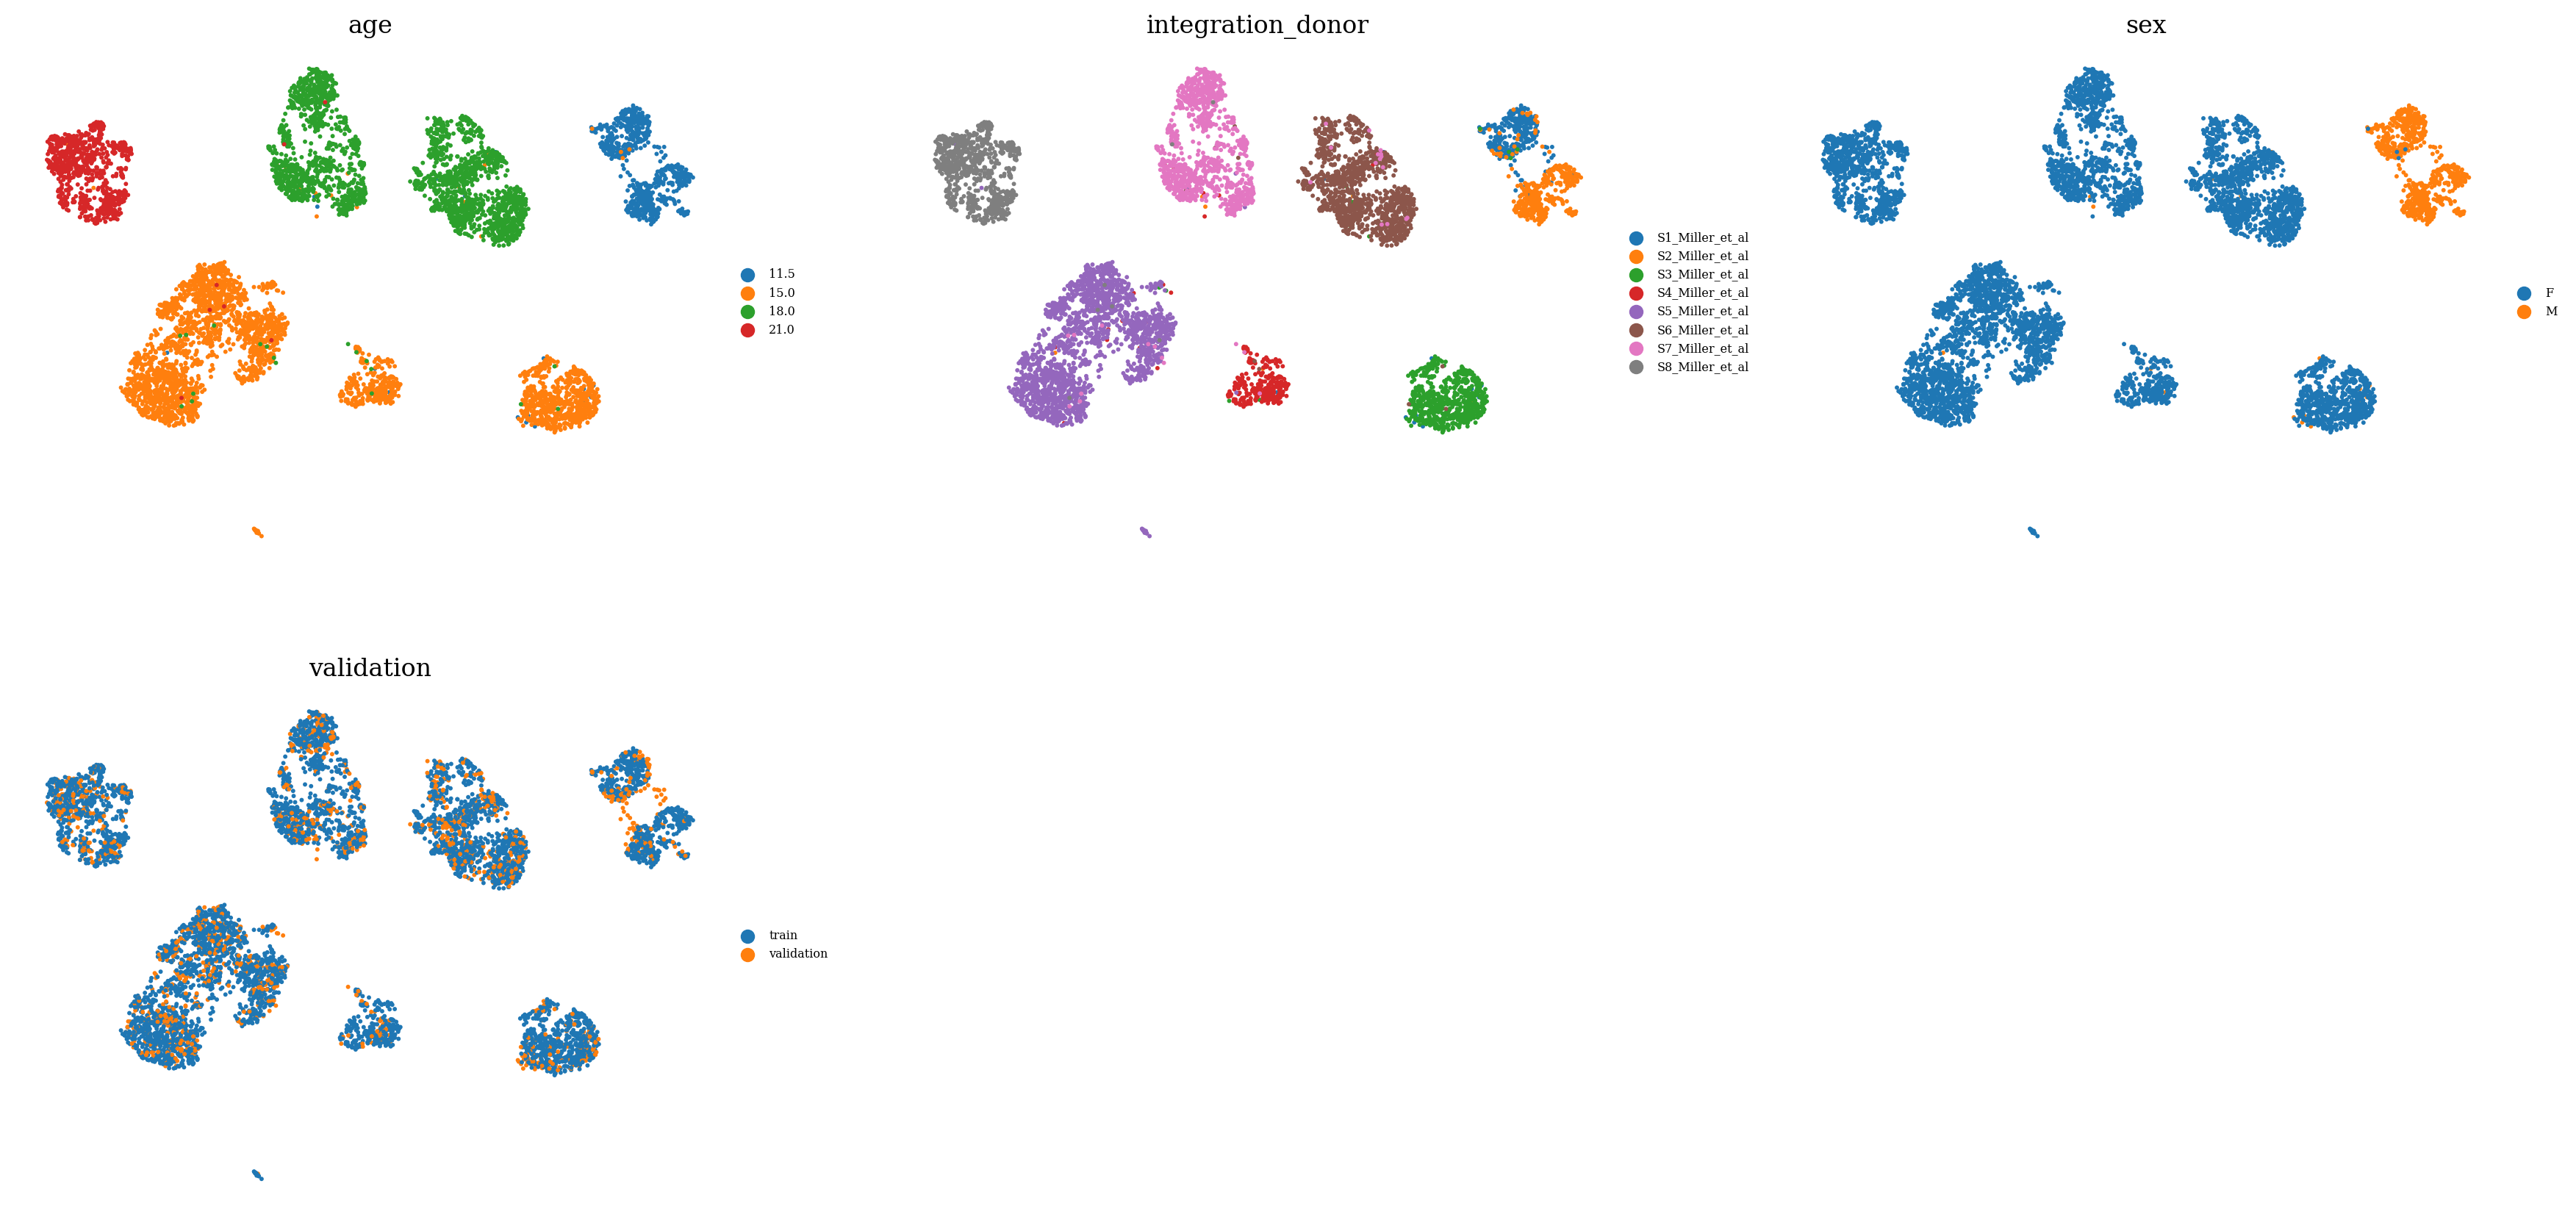

In [26]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [27]:
from tardis._disentanglementmanager import DisentanglementManager as DM

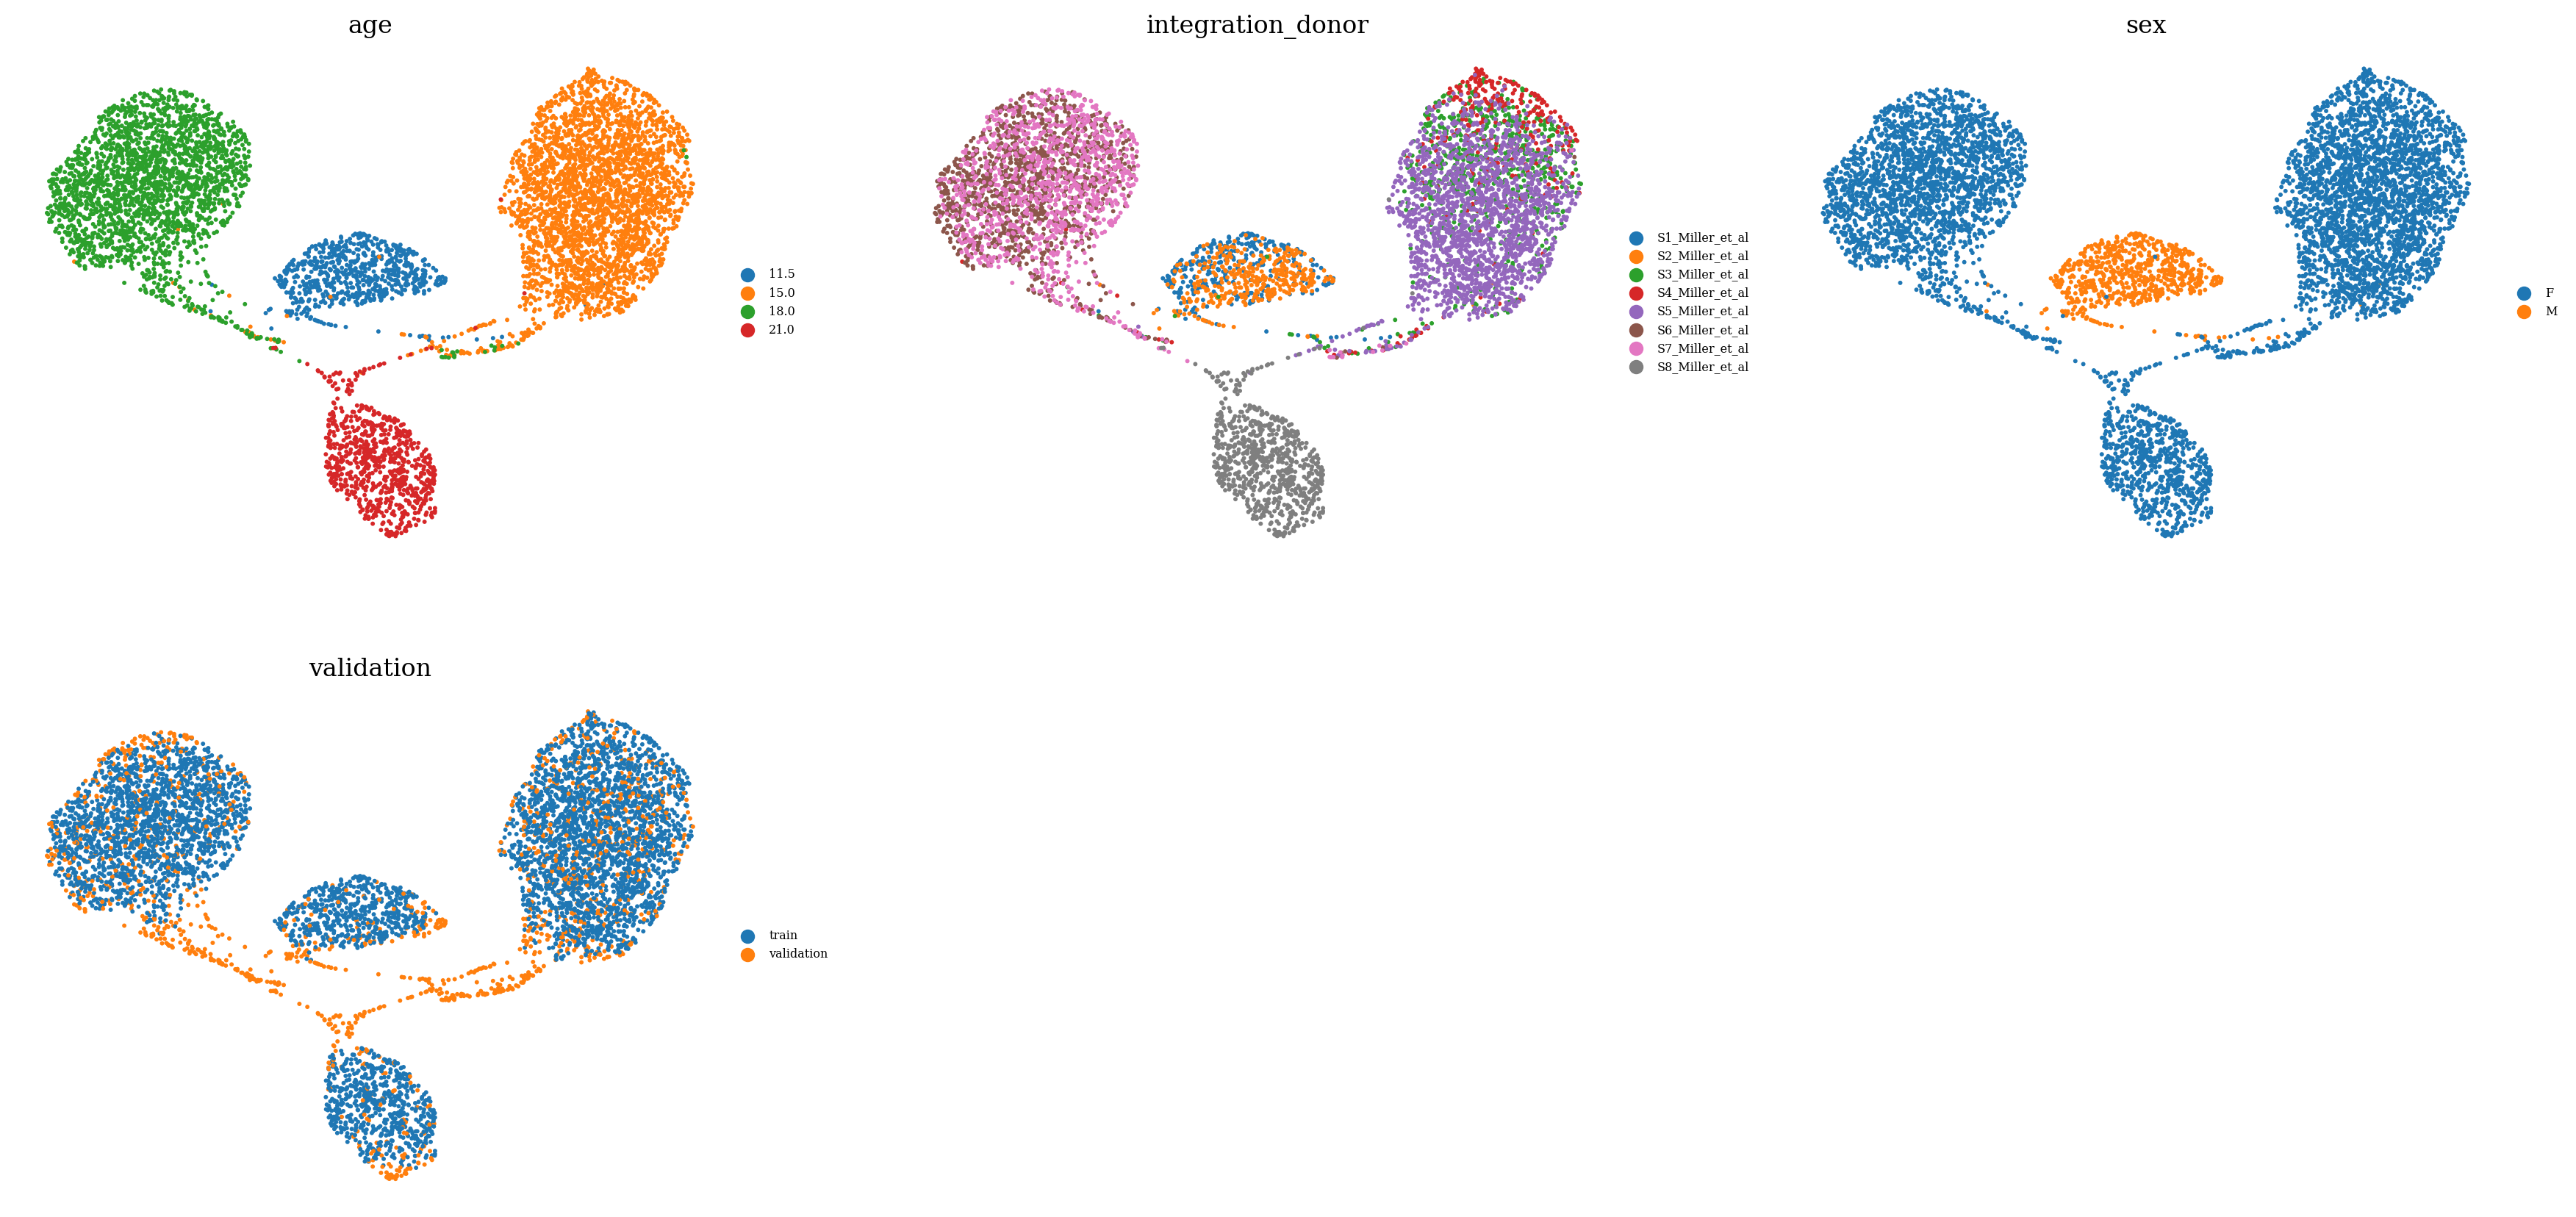

In [28]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

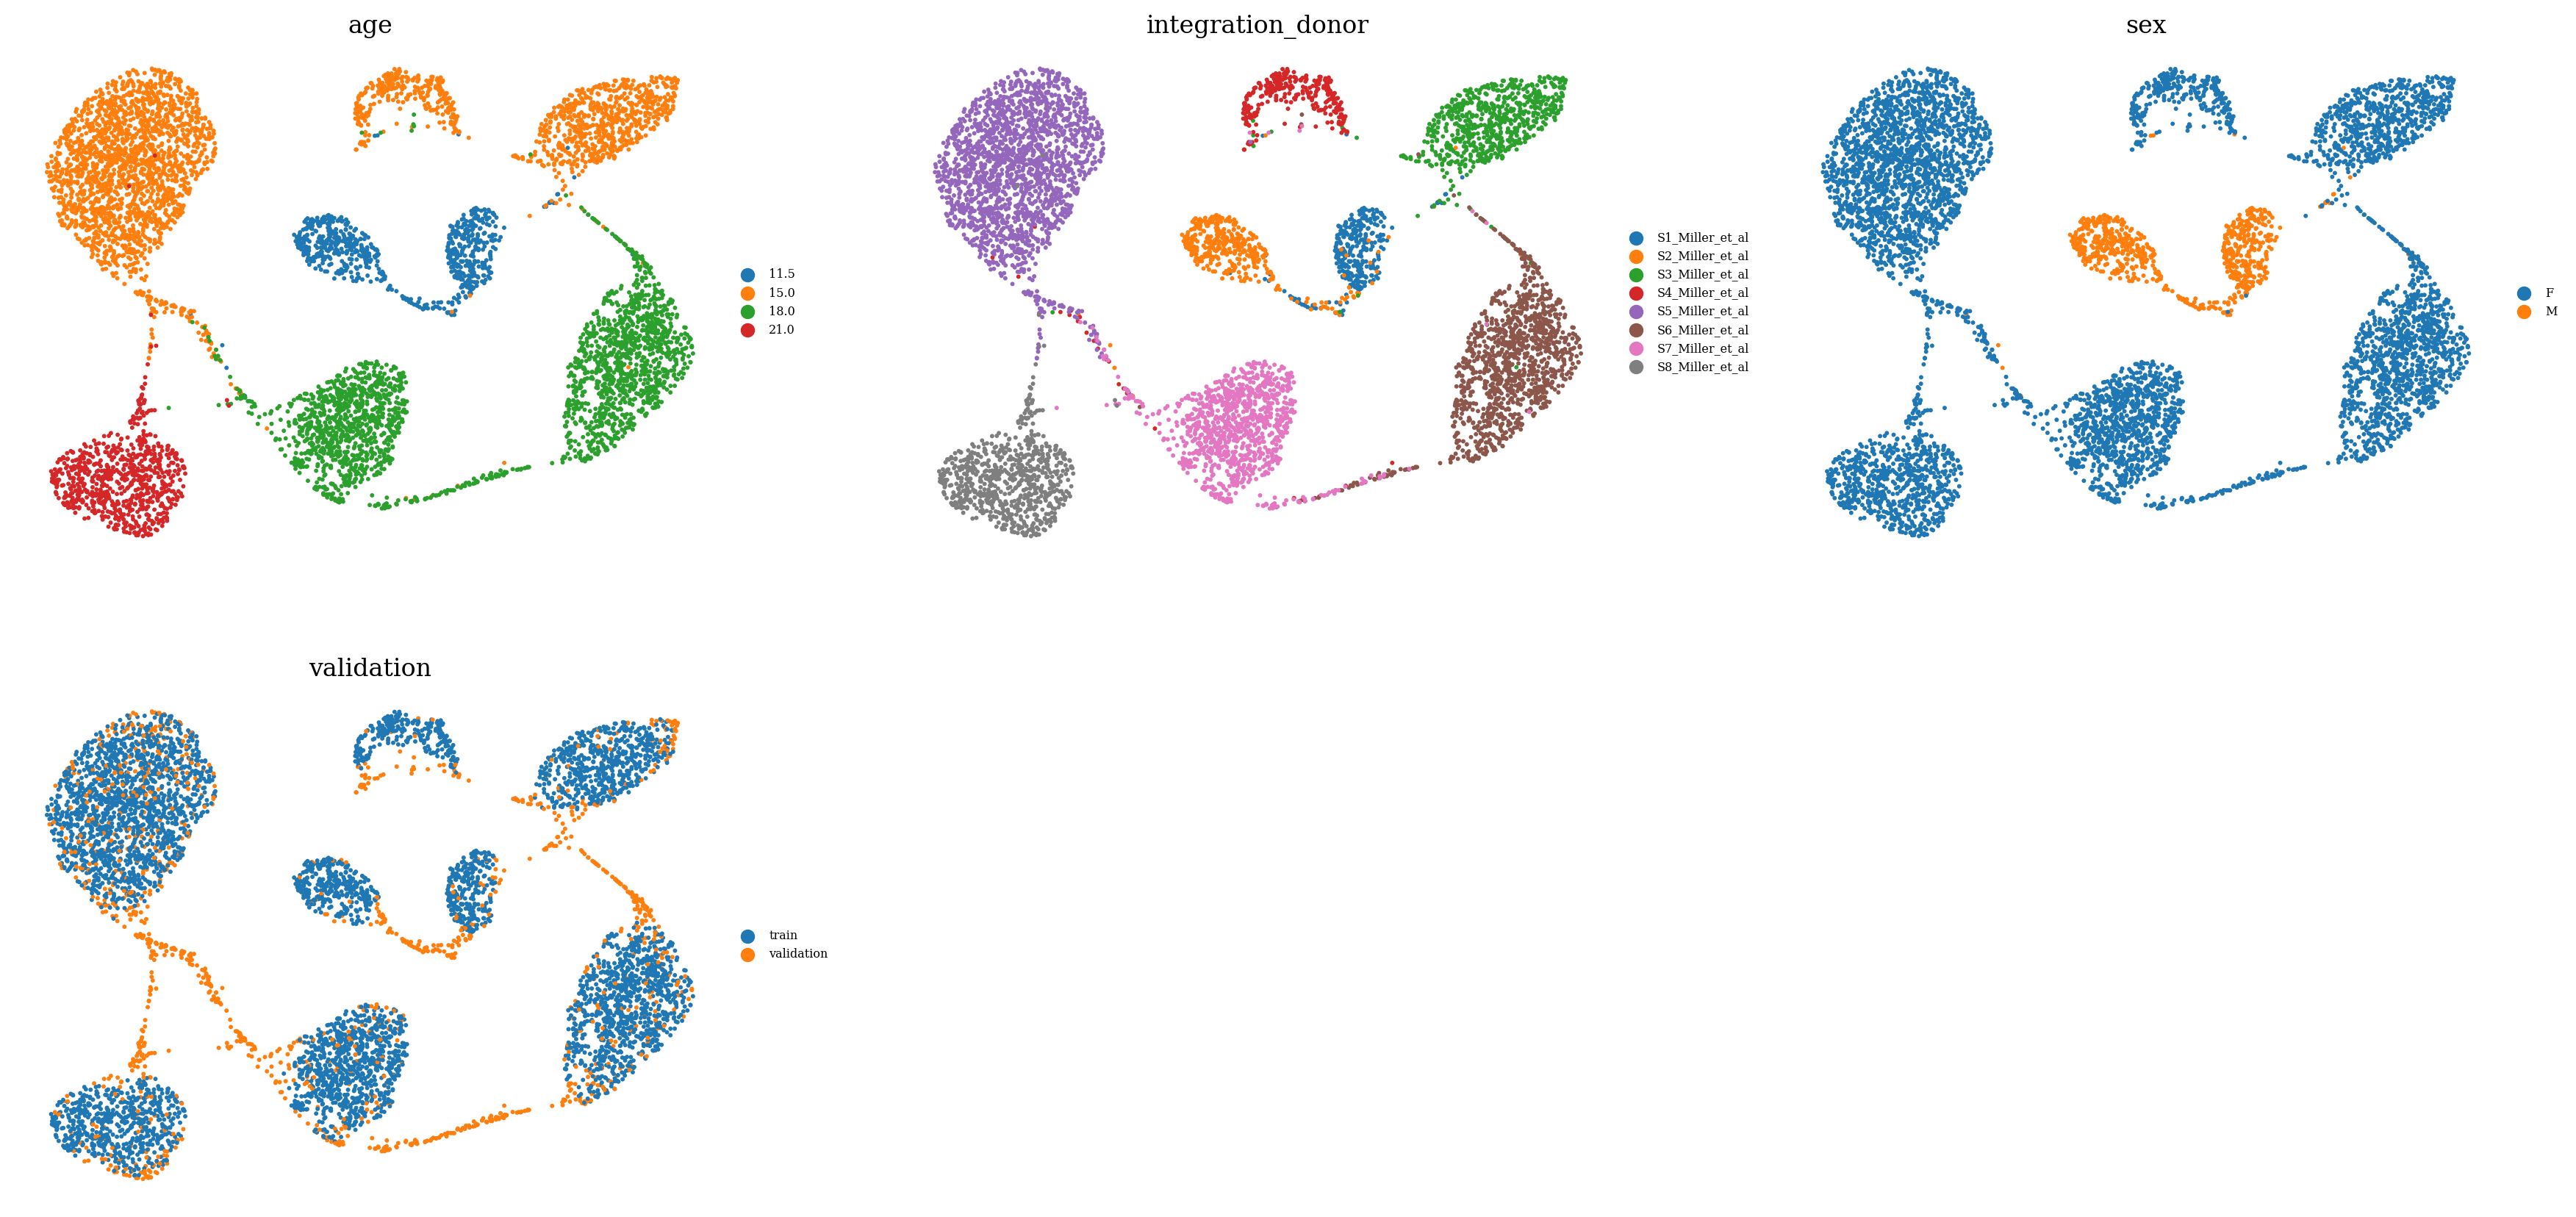

In [29]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("integration_donor").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [30]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs["age"] = adata_main.obs["age"].astype("str").astype("category")
adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [31]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main, n_neighbors = 30)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


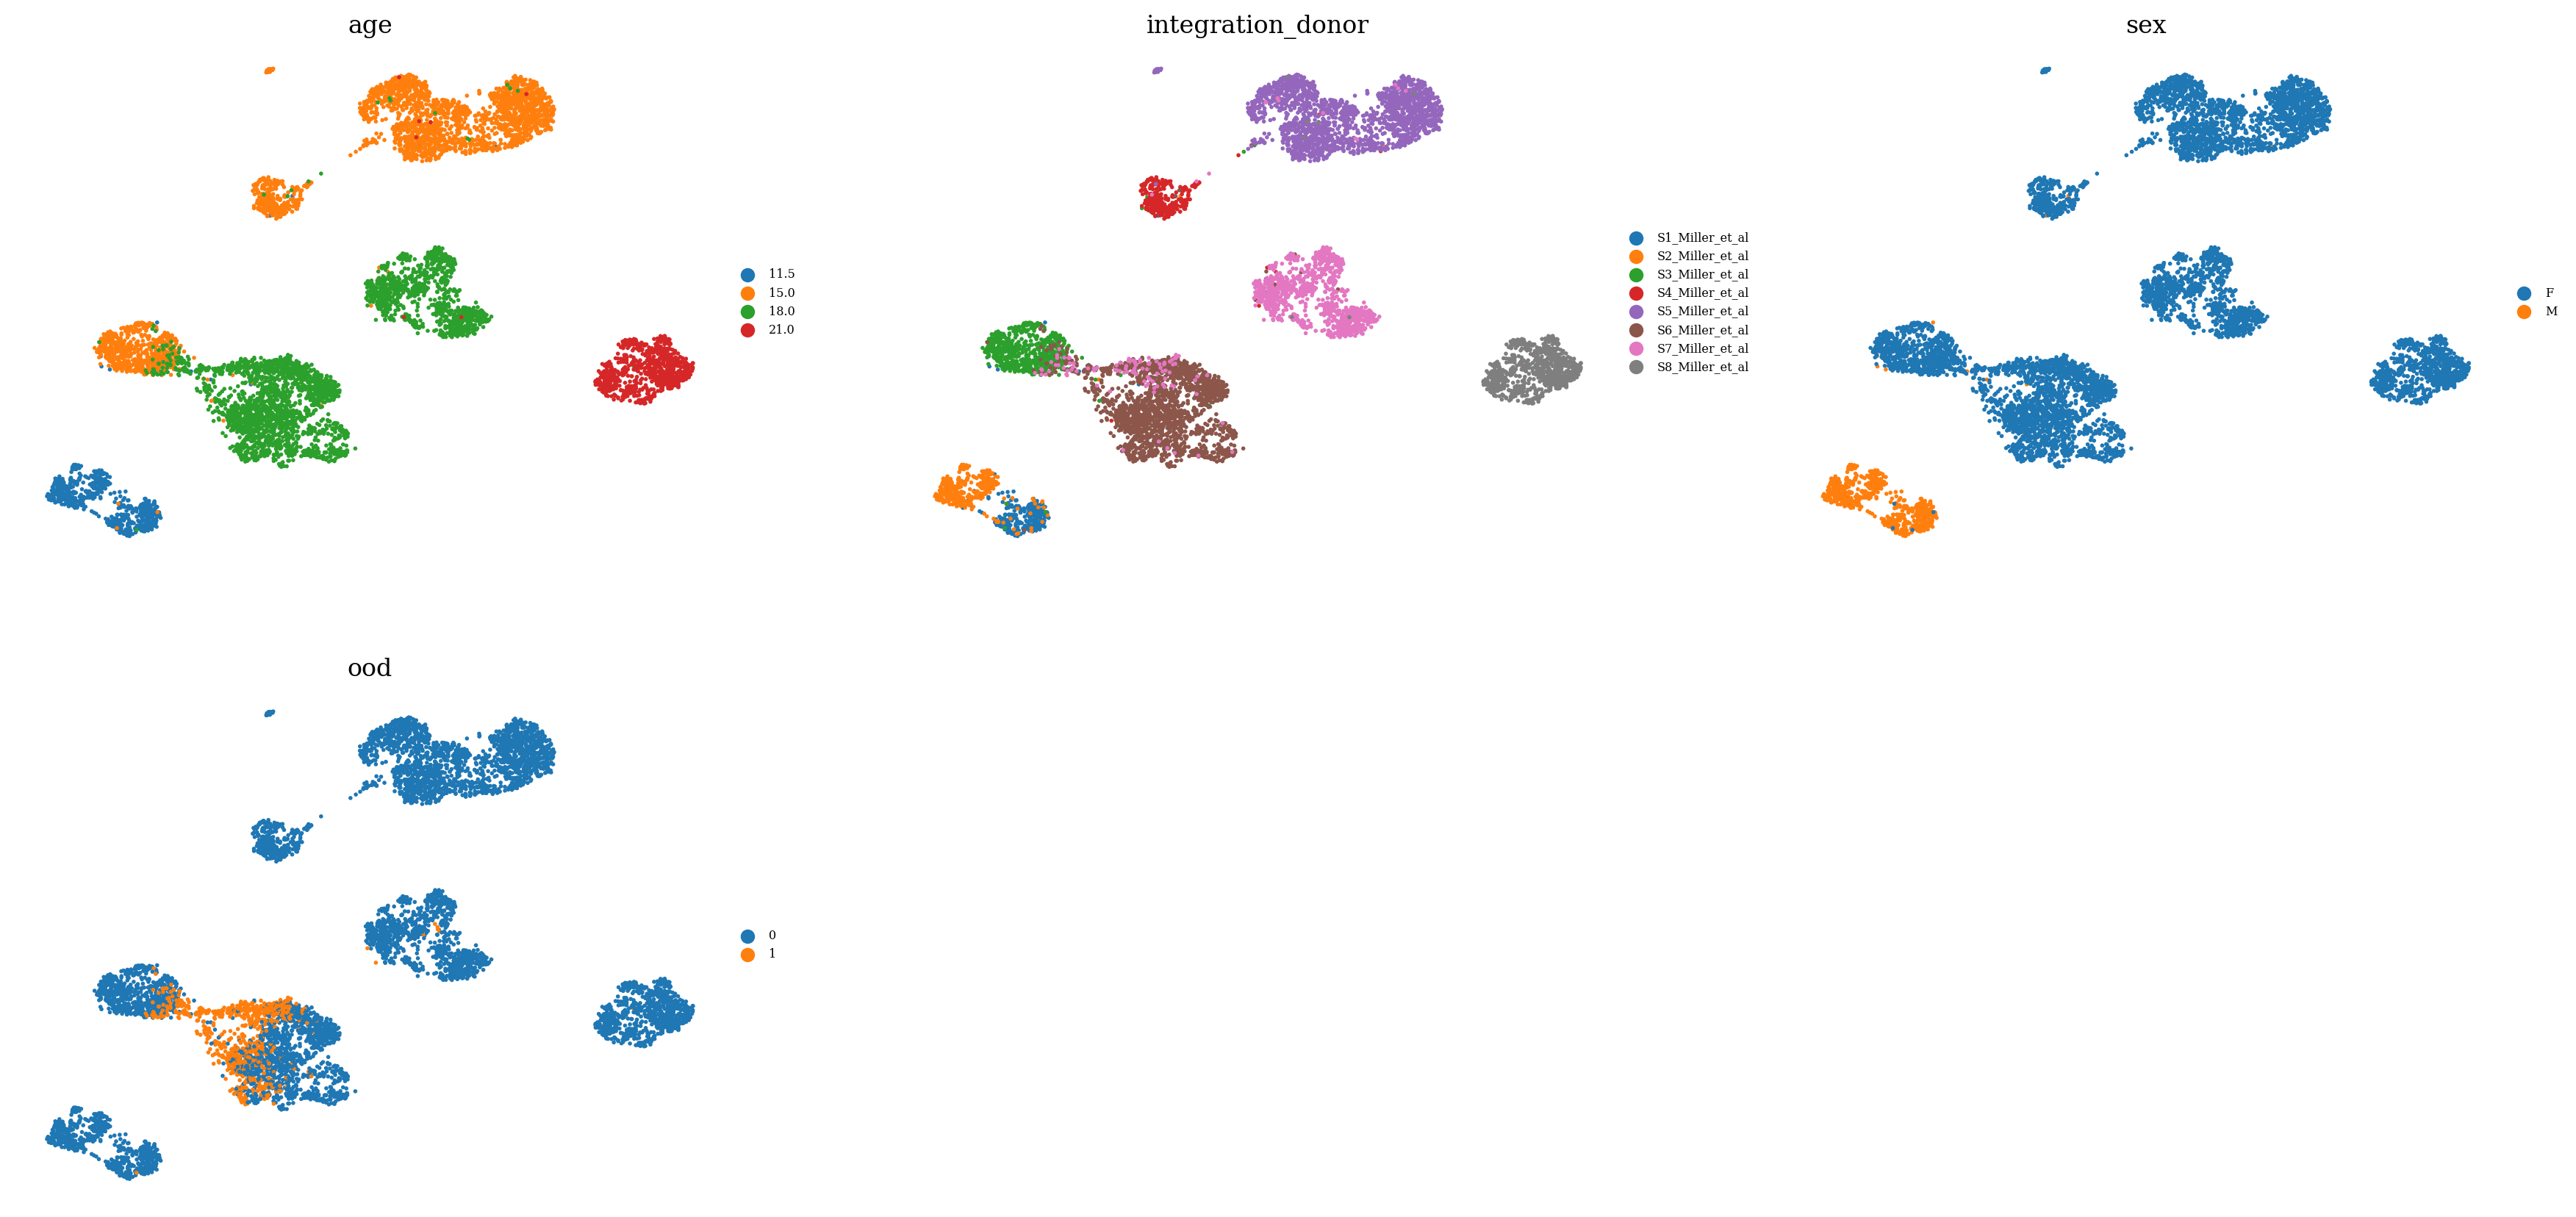

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=["age", "integration_donor", "sex", "ood"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [33]:
k = "age"

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)
label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
metrics

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


Baseline Accuracy: 0.40580688723835245
F1 Weighted: 0.23428428360254544

Baseline Accuracy: 0.336934503713707
F1 Weighted: 0.33709748181912297



{'accuracy': 0.8404118404118404,
 'precision_macro': 0.25,
 'recall_macro': 0.2101029601029601,
 'f1_score_macro': 0.22832167832167832,
 'precision_micro': 0.8404118404118404,
 'recall_micro': 0.8404118404118404,
 'f1_score_micro': 0.8404118404118404,
 'precision_weighted': 1.0,
 'recall_weighted': 0.8404118404118404,
 'f1_score_weighted': 0.9132867132867133,
 'confusion_matrix': array([[  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  4, 119, 653,   1],
        [  0,   0,   0,   0]])}

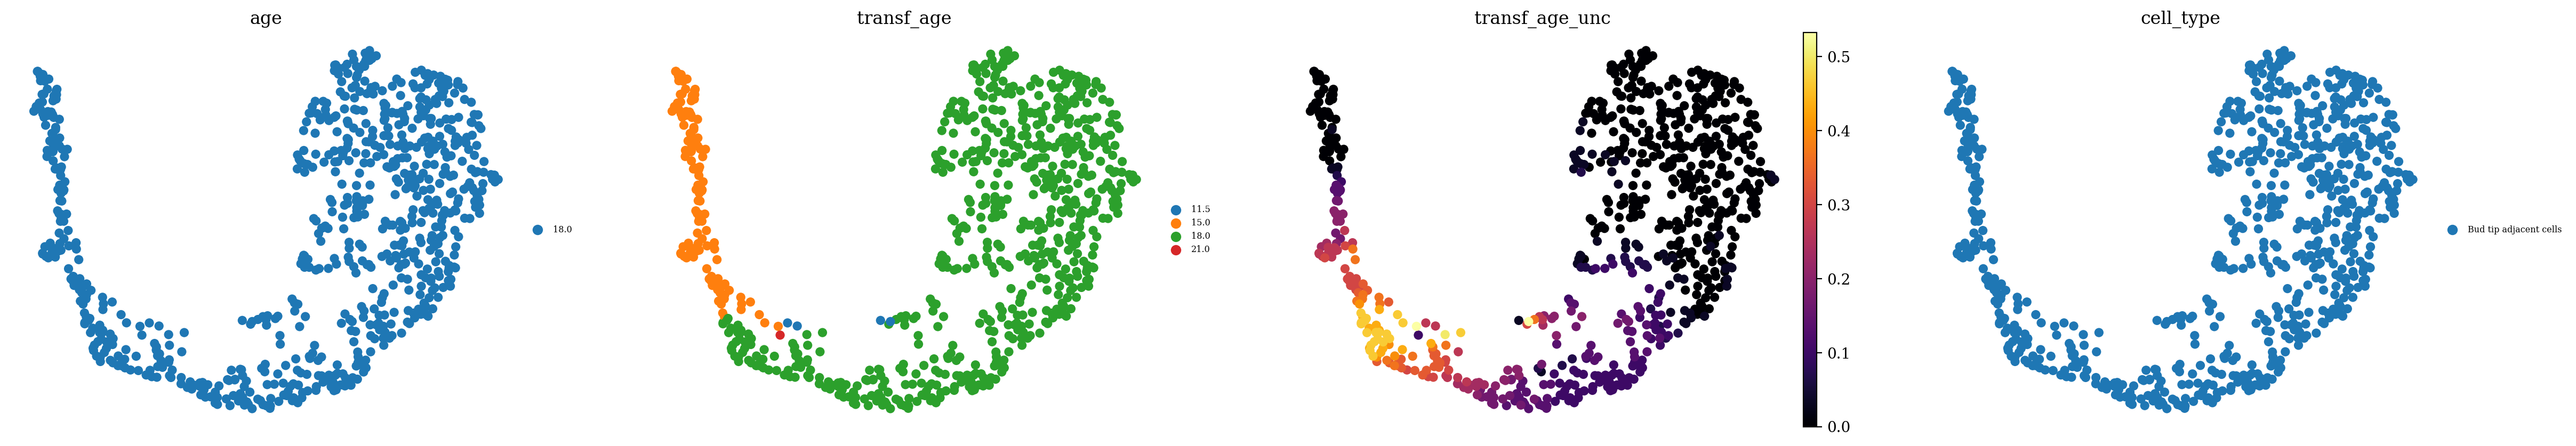

In [34]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc", "cell_type"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [35]:
k = "integration_donor"

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)
label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
metrics

Baseline Accuracy: 0.2613099257258609
F1 Weighted: 0.10827295637677535

Baseline Accuracy: 0.18541525995948682
F1 Weighted: 0.18604493019961577



{'accuracy': 0.7683397683397684,
 'precision_macro': 0.2912772585669782,
 'recall_macro': 0.1610546796038003,
 'f1_score_macro': 0.1785891083383068,
 'precision_micro': 0.7683397683397684,
 'recall_micro': 0.7683397683397684,
 'f1_score_micro': 0.7683397683397682,
 'precision_weighted': 0.9042186378634978,
 'recall_weighted': 0.7683397683397684,
 'f1_score_weighted': 0.8000914864299505,
 'confusion_matrix': array([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0],
        [  3,  87,   1, 587,   2,   0],
        [  0,  29,   2,  55,  10,   1],
        [  0,   0,   0,   0,   0,   0]])}

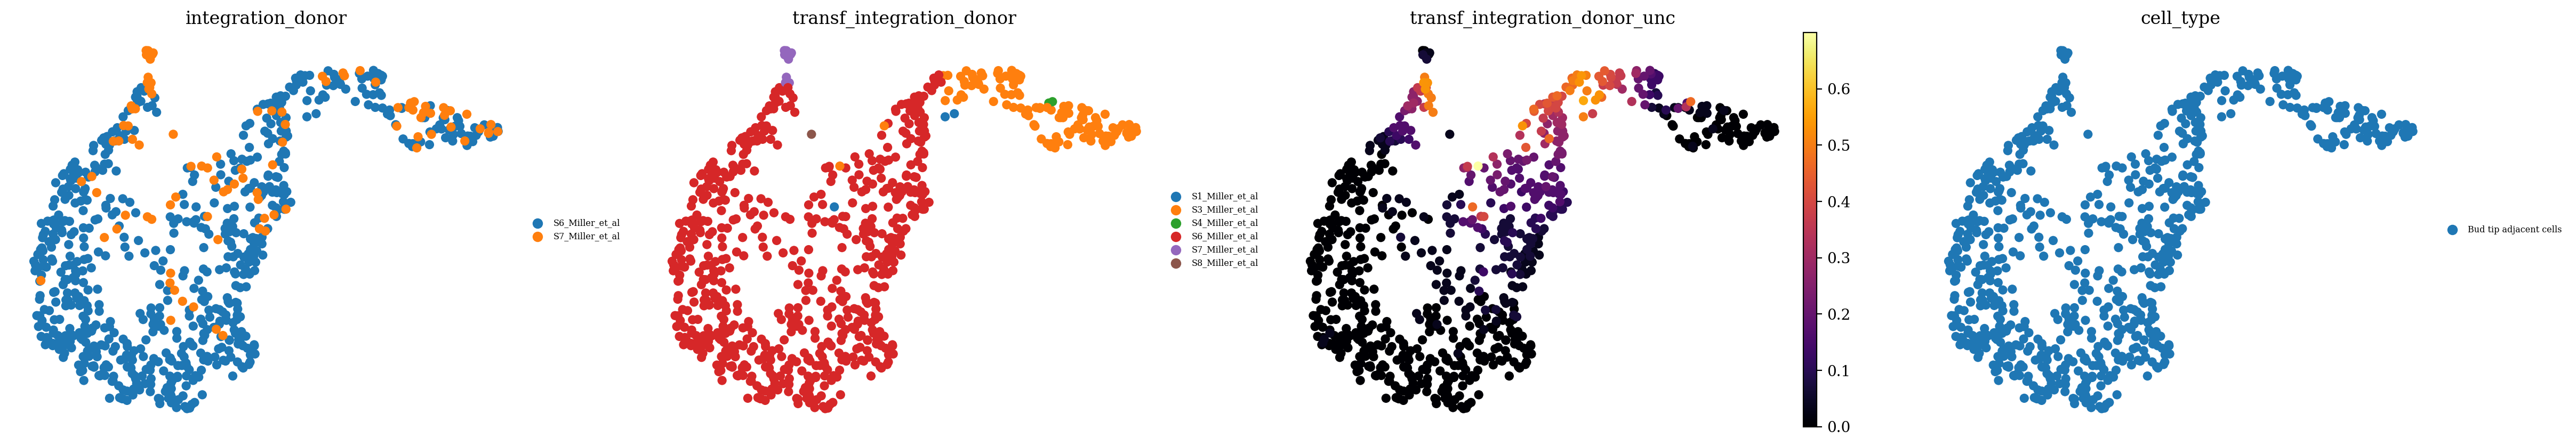

In [36]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc", "cell_type"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )